<a href="https://colab.research.google.com/github/TheJJL/Proyecto-Final-TG/blob/main/Reconocimiento2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segundo sistema de reconocimiento de rostros con Deep Learning
----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Universidad - Ingeniería Electrónica/10 Semestre/Trabajo de Grado II/'
#path = '/content/drive/MyDrive/Trabajo de Grado II/'

Mounted at /content/drive


In [ ]:
import os
import shutil
import numpy as np
import random
import seaborn
import pandas as pd
from os import listdir
from PIL import Image 
from numpy import asarray

from numpy import expand_dims
from numpy import eye
from numpy import load
from numpy import savez_compressed
from random import choice
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, Adamax, SGD
from keras.models import load_model 
from keras.callbacks import ModelCheckpoint
from keras.models import Model, Sequential
from keras.layers import Convolution2D, MaxPooling2D, LocallyConnected2D, Flatten, Dense, Dropout, Input, Add, Activation
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report  

%matplotlib inline

## 2. Preparación de datos utilizando el detector de rostros MTCNN

In [ ]:
# Función para aplicar data augmentation en caso de ser necesario
data_gen = ImageDataGenerator(
    rescale = .1, #Escalar aleatoriamente el múltiplo de la imagen RGB
    rotation_range = 0.15, #Rotar aleatoriamente el rango de la imagen
    zoom_range = 0.1, #Escalar aleatoriamente el rango de tamaño de la imagen
    width_shift_range = 0.2, #Cambiar aleatoriamente la imagen horizontalmente (fracción del ancho total)
    height_shift_range = 0.2, #Cambiar aleatoriamente la imagen verticalmente (fracción de la altura total)
    horizontal_flip = True,)

# Ejecutar directamente para obtener un iterador de imagen, que lee una imagen de la ruta cada vez y edita la imagen de acuerdo con las reglas del potenciador de datos.
dataflow_generator = data_gen.flow_from_directory(
    path + 'datasets/dataset/',
    target_size = (152, 152),
    batch_size = 3,
    color_mode = 'rgb',
    class_mode = 'categorical')

print(dataflow_generator.filenames)

Found 2452 images belonging to 2 classes.
['test/yaleB01/yaleB01_P00A+000E-35.jpg', 'test/yaleB01/yaleB01_P00A+005E-10.jpg', 'test/yaleB01/yaleB01_P00A+020E-10.jpg', 'test/yaleB01/yaleB01_P00A+070E+00.jpg', 'test/yaleB01/yaleB01_P00A+070E+45.jpg', 'test/yaleB01/yaleB01_P00A+085E-20.jpg', 'test/yaleB01/yaleB01_P00A+095E+00.jpg', 'test/yaleB01/yaleB01_P00A-010E-20.jpg', 'test/yaleB01/yaleB01_P00A-015E+20.jpg', 'test/yaleB01/yaleB01_P00A-035E+40.jpg', 'test/yaleB01/yaleB01_P00A-035E-20.jpg', 'test/yaleB01/yaleB01_P00A-070E+45.jpg', 'test/yaleB01/yaleB01_P00A-095E+00.jpg', 'test/yaleB01/yaleB01_P00A-110E+65.jpg', 'test/yaleB01/yaleB01_P00A-110E-20.jpg', 'test/yaleB02/yaleB02_P00A+000E+00.jpg', 'test/yaleB02/yaleB02_P00A+000E-35.jpg', 'test/yaleB02/yaleB02_P00A+020E+10.jpg', 'test/yaleB02/yaleB02_P00A+020E-40.jpg', 'test/yaleB02/yaleB02_P00A+035E+40.jpg', 'test/yaleB02/yaleB02_P00A+050E-40.jpg', 'test/yaleB02/yaleB02_P00A+085E+20.jpg', 'test/yaleB02/yaleB02_P00A+095E+00.jpg', 'test/yaleB02/

In [ ]:
# Función para extraer las imágenes
def extract_image(image):
  img = Image.open(image)            
  img = img.convert('RGB')          
  img = img.resize((152,152))  
  face_array = asarray(img)  
  return face_array

# Etiquetas Base de datos Yale (No existe el sujeto 14).
'''
name_dict = {'yaleB01':1,'yaleB02':2,'yaleB03':3,'yaleB04':4,'yaleB05':5,'yaleB06':6,'yaleB07':7,'yaleB08':8,'yaleB09':9,'yaleB10':10,
             'yaleB11':11,'yaleB12':12,'yaleB13':13,'yaleB15':15,'yaleB16':16,'yaleB17':17,'yaleB18':18,'yaleB19':19,'yaleB20':20,
             'yaleB21':21,'yaleB22':22,'yaleB23':23,'yaleB24':24,'yaleB25':25,'yaleB26':26,'yaleB27':27,'yaleB28':28,'yaleB29':29,'yaleB30':30,
             'yaleB31':31,'yaleB32':32,'yaleB33':33,'yaleB34':34,'yaleB35':35,'yaleB36':36,'yaleB37':37,'yaleB38':38,'yaleB39':39} 
'''
# Etiquetas Base de datos ROF

name_dict = {'ben_mendelsohn':1,'benedict_cumberbatch':2,'brad_pitt':3,'chris_evans':4,'chris_pratt':5,
             'colin_farell':6,'don_cheadle':7,'donnie_yen':8,'dwayne_johnson':9,'ed_skrein':10}

# Etiquetas Base de datos African
'''
name_dict = {'african_001':1,'african_002':2,'african_003':3,'african_004':4,'african_005':5,'african_006':6,'african_007':7,'african_008':8,'african_009':9,'african_010':10,
             'african_011':11,'african_012':12,'african_013':13,'african_014':14,'african_015':15,'african_016':16,'african_017':17,'african_018':18,'african_019':19,'african_020':20}
'''
# Etiquetas Base de datos Asian
'''
name_dict = {'asian_001':1,'asian_002':2,'asian_003':3,'asian_004':4,'asian_005':5,'asian_006':6,'asian_007':7,'asian_008':8,'asian_009':9,'asian_010':10,
             'asian_011':11,'asian_012':12,'asian_013':13,'asian_014':14,'asian_015':15,'asian_016':16,'asian_017':17,'asian_018':18,'asian_019':19,'asian_020':20}
'''
# Etiquetas Base de datos Latin
'''
name_dict = {'latin_001':1,'latin_002':2,'latin_003':3,'latin_004':4,'latin_005':5,'latin_006':6,'latin_007':7,'latin_008':8,'latin_009':9,'latin_010':10,
             'latin_011':11,'latin_012':12,'latin_013':13,'latin_014':14,'latin_015':15,'latin_016':16,'latin_017':17,'latin_018':18,'latin_019':19,'latin_020':20}
'''
# Etiquetas Base de datos Indian
'''
name_dict = {'indian_001':1,'indian_002':2,'indian_003':3,'indian_004':4,'indian_005':5,'indian_006':6,'indian_007':7,'indian_008':8,'indian_009':9,'indian_010':10,
             'indian_011':11,'indian_012':12,'indian_013':13,'indian_014':14,'indian_015':15,'indian_016':16,'indian_017':17,'indian_018':18,'indian_019':19,'indian_020':20}
'''

# Función para obtener datos faciales y sus etiquetas 
def load_dataset(directory, augment_times=2, is_train=True):
  x, y = [],[]
  for subdir in listdir(directory):
    path = directory + subdir + '/'
    for filename in listdir(path):
      path_file = path + filename
      faces = extract_image(path_file)
      #labels = [subdir for _ in range(len(faces))] #Creación de etiquetas
      x.append(faces)
      #y.append(labels)
      y.append(name_dict[subdir])
      if is_train:
        for _ in range(augment_times):
          faces_aug = data_gen.random_transform(faces)
          x.append(faces_aug)
          #y.append(labels)
          y.append(name_dict[subdir])

  return asarray(x), asarray(y)  

In [ ]:
#Cargar datos de entrenamiento
trainX, trainY = load_dataset(path + 'datasets/datasetROF2/train/', augment_times=0, is_train=False)
print('Cargando dataset train:')
print('Hay %d imágenes' %trainX.shape[0])  
print('Tamaño de imágenes: %d x %d pixeles' %(trainX.shape[1], trainX.shape[2]))

#Cargar datos de test
testX, testY = load_dataset(path + 'datasets/datasetROF2/test/sunglasses/', is_train=False)
print('Cargando dataset test:')
print('Hay %d imágenes' %testX.shape[0])  
print('Tamaño de imágenes: %d x %d pixeles' %(testX.shape[1], testX.shape[2]))

#Guardar datos en un archivo en formato comprimido 
savez_compressed('faces-dataset-ROF2_sunglasses.npz', trainX, trainY, testX, testY)
shutil.copy('faces-dataset-ROF2_sunglasses.npz', path + 'data_reconocimiento2') 

Cargando dataset train:
Hay 1601 imágenes
Tamaño de imágenes: 152 x 152 pixeles
Cargando dataset test:
Hay 200 imágenes
Tamaño de imágenes: 152 x 152 pixeles


'/content/drive/MyDrive/Universidad - Ingeniería Electrónica/10 Semestre/Trabajo de Grado II/data_reconocimiento2/faces-dataset-ROF2_sunglasses.npz'

## 3. Modelo de Deep Learning: DeepFace
----

In [ ]:
# Carga del conjunto de datos comprimido
data = load(path + 'data_reconocimiento2/faces-dataset-ROF1_mask.npz')
trainX, trainY, testX, testY = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Tamaño de data train:', trainX.shape)
print('Tamaño de data test:', testX.shape)

Tamaño de data train: (1000, 152, 152, 3)
Tamaño de data test: (200, 152, 152, 3)


In [ ]:
# Estandarización de los datos de entrenamiento y test
trainX = trainX/255
testX = testX/255
trainY = to_categorical(trainY)
testY = to_categorical(testY)

Sujeto #[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


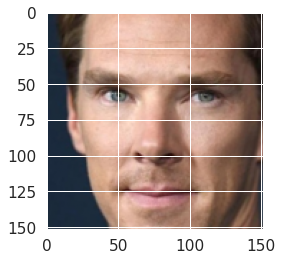

In [ ]:
# Ejemplo
print('Sujeto #{}'.format(trainY[20]))
plt.imshow(trainX[20])

### 3.1 Modelo base de DeepFace


In [ ]:
model = Sequential()
model.add(Convolution2D(32, (11, 11), activation='relu', name='C1', input_shape=(152, 152, 3), trainable=False))
model.add(MaxPooling2D(pool_size=3, strides=2, padding='same', name='M2', trainable=False))
model.add(Convolution2D(16, (9, 9), activation='relu', name='C3', trainable=False))
model.add(LocallyConnected2D(16, (9, 9), activation='relu', name='L4'))
model.add(LocallyConnected2D(16, (7, 7), strides=2, activation='relu', name='L5'))
model.add(LocallyConnected2D(16, (5, 5), activation='relu', name='L6'))
model.add(Flatten(name='F0'))
model.add(Dense(4096, activation='relu', name='F7'))
model.add(Dropout(rate=0.5, name='D0'))
model.add(Dense(8631, activation='softmax', name='F8'))

In [ ]:
#Carga de los pesos de un modelo pre-entrenado
model.load_weights(path + 'data_models/VGGFace2_DeepFace_weights_val-0.9034.h5')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

## 3.1.1 Pruebas Transfer Learning and Fine-tunning

##### Prueba 1: dejando todas las capas congeladas excepto F7

In [ ]:
model1 = Sequential()
model1.add(Convolution2D(32, (11, 11), activation='relu', name='C1', input_shape=(152, 152, 3), trainable=False))
model1.add(MaxPooling2D(pool_size=3, strides=2, padding='same', name='M2', trainable=False))
model1.add(Convolution2D(16, (9, 9), activation='relu', name='C3', trainable=False))
model1.add(LocallyConnected2D(16, (9, 9), activation='relu', name='L4', trainable=False))
model1.add(LocallyConnected2D(16, (7, 7), strides=2, activation='relu', name='L5', trainable=False))
model1.add(LocallyConnected2D(16, (5, 5), activation='relu', name='L6', trainable=False))
model1.add(Flatten(name='F0'))
model1.add(Dense(4096, activation='relu', name='F7'))
model1.add(Dropout(rate=0.5, name='D0'))
model1.add(Dense(8631, activation='softmax', name='F8'))

In [ ]:
#Carga de los pesos de un modelo entrenado
model1.load_weights(path + 'data_models/VGGFace2_DeepFace_weights_val-0.9034.h5')
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Eliminación de las capa F8. 
deepface_model1 = tf.keras.models.Sequential(model1.layers[:-1])
deepface_model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
deepface_model1.add(Dense(40, activation='softmax', name='Class'))
deepface_model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.001)
deepface_model1.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/deepface_model1.h5', monitor="val_loss", save_best_only=True)
result_model1 = deepface_model1.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.3, callbacks=[checkpointer])

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model1 = load_model(path + 'data_reconocimiento2/deepface_model1.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model1.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model1.evaluate(testX, testY)

##### Prueba 2: dejando todas las capas congeladas excepto L6 y F7




In [ ]:
model2 = Sequential()
model2.add(Convolution2D(32, (11, 11), activation='relu', name='C1', input_shape=(152, 152, 3), trainable=False))
model2.add(MaxPooling2D(pool_size=3, strides=2, padding='same', name='M2', trainable=False))
model2.add(Convolution2D(16, (9, 9), activation='relu', name='C3', trainable=False))
model2.add(LocallyConnected2D(16, (9, 9), activation='relu', name='L4', trainable=False))
model2.add(LocallyConnected2D(16, (7, 7), strides=2, activation='relu', name='L5', trainable=False))
model2.add(LocallyConnected2D(16, (5, 5), activation='relu', name='L6'))
model2.add(Flatten(name='F0'))
model2.add(Dense(4096, activation='relu', name='F7'))
model2.add(Dropout(rate=0.5, name='D0'))
model2.add(Dense(8631, activation='softmax', name='F8'))

In [ ]:
#Carga de los pesos de un modelo entrenado
model2.load_weights(path + 'data_models/VGGFace2_DeepFace_weights_val-0.9034.h5')
model2.summary()

In [ ]:
# Eliminación de las capas F8. 
deepface_model2 = tf.keras.models.Sequential(model2.layers[:-1])
deepface_model2.summary()

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
deepface_model2.add(Dense(40, activation='softmax', name='Class'))
deepface_model2.summary()

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.001)
deepface_model2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/deepface_model2.h5', monitor="val_loss", save_best_only=True)
result_model2 = deepface_model2.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.3, callbacks=[checkpointer])

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model2 = load_model(path + 'data_reconocimiento2/deepface_model2.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model2.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model2.evaluate(testX, testY)

##### Prueba 3: dejando todas las capas congeladas excepto L5, L6 y F7




In [ ]:
model3 = Sequential()
model3.add(Convolution2D(32, (11, 11), activation='relu', name='C1', input_shape=(152, 152, 3), trainable=False))
model3.add(MaxPooling2D(pool_size=3, strides=2, padding='same', name='M2', trainable=False))
model3.add(Convolution2D(16, (9, 9), activation='relu', name='C3', trainable=False))
model3.add(LocallyConnected2D(16, (9, 9), activation='relu', name='L4', trainable=False))
model3.add(LocallyConnected2D(16, (7, 7), strides=2, activation='relu', name='L5'))
model3.add(LocallyConnected2D(16, (5, 5), activation='relu', name='L6'))
model3.add(Flatten(name='F0'))
model3.add(Dense(4096, activation='relu', name='F7'))
model3.add(Dropout(rate=0.5, name='D0'))
model3.add(Dense(8631, activation='softmax', name='F8'))

In [ ]:
#Carga de los pesos de un modelo entrenado
model3.load_weights(path + 'data_models/VGGFace2_DeepFace_weights_val-0.9034.h5')
model3.summary()

In [ ]:
# Eliminación de las capa F8. 
deepface_model3 = tf.keras.models.Sequential(model3.layers[:-1])
deepface_model3.summary()

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
deepface_model3.add(Dense(40, activation='softmax', name='Class'))
deepface_model3.summary()

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.001)
deepface_model3.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/deepface_model3.h5', monitor="val_loss", save_best_only=True)
result_model3 = deepface_model3.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.3, callbacks=[checkpointer])

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model3 = load_model(path + 'data_reconocimiento2/deepface_model3.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model3.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model3.evaluate(testX, testY)

##### Prueba 4: dejando todas las capas congeladas excepto L4, L5, L6 y F7




In [ ]:
model4 = Sequential()
model4.add(Convolution2D(32, (11, 11), activation='relu', name='C1', input_shape=(152, 152, 3), trainable=False))
model4.add(MaxPooling2D(pool_size=3, strides=2, padding='same', name='M2', trainable=False))
model4.add(Convolution2D(16, (9, 9), activation='relu', name='C3', trainable=False))
model4.add(LocallyConnected2D(16, (9, 9), activation='relu', name='L4'))
model4.add(LocallyConnected2D(16, (7, 7), strides=2, activation='relu', name='L5'))
model4.add(LocallyConnected2D(16, (5, 5), activation='relu', name='L6'))
model4.add(Flatten(name='F0'))
model4.add(Dense(4096, activation='relu', name='F7'))
model4.add(Dropout(rate=0.5, name='D0'))
model4.add(Dense(8631, activation='softmax', name='F8'))

In [ ]:
#Carga de los pesos de un modelo entrenado
model4.load_weights(path + 'data_models/VGGFace2_DeepFace_weights_val-0.9034.h5')
model4.summary()

In [ ]:
# Eliminación de las capas F8. 
deepface_model4 = tf.keras.models.Sequential(model4.layers[:-1])
deepface_model4.summary()

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
deepface_model4.add(Dense(40, activation='softmax', name='Class'))
deepface_model4.summary()

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.001)
deepface_model4.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/deepface_model4.h5', monitor="val_loss", save_best_only=True)
result_model4 = deepface_model4.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.3, callbacks=[checkpointer])

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model4 = load_model(path + 'data_reconocimiento2/deepface_model4.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model4.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model4.evaluate(testX, testY)

## 4. Modelos con base de datos Yale para condiciones de iluminación

#### Modelo 1: (BTH = 30, EHS = 30, ValidSplit = 0.2, Dropout=0.3, INI = none, REG = none, OPT = adam[0.001])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_yale1 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_yale1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)            

In [ ]:
# Se agrega una capa final dropout y softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
#initializer = tf.keras.initializers.HeNormal()
#reg = tf.keras.regularizers.L2()
#deepface_model.add(Dense(40, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_yale1.add(Dropout(rate=0.3, name='D0'))
deepface_model_yale1.add(Dense(40, activation='softmax', name='Class'))
deepface_model_yale1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)            

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.001)
deepface_model_yale1.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/deepface_model_yale1.h5', monitor="val_loss", save_best_only=True)
hist_model_yale1 = deepface_model_yale1.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
50/50 [==============================] - 182s 1s/step - loss: 2.1600 - accuracy: 0.6088 - val_loss: 1.4661 - val_accuracy: 0.7778
Epoch 2/30
50/50 [==============================] - 14s 280ms/step - loss: 1.1081 - accuracy: 0.8441 - val_loss: 0.6847 - val_accuracy: 0.8726
Epoch 3/30
50/50 [==============================] - 7s 139ms/step - loss: 1.0775 - accuracy: 0.8983 - val_loss: 2.7776 - val_accuracy: 0.8076
Epoch 4/30
50/50 [==============================] - 7s 137ms/step - loss: 1.5965 - accuracy: 0.8827 - val_loss: 3.9999 - val_accuracy: 0.8293
Epoch 5/30
50/50 [==============================] - 7s 135ms/step - loss: 2.5493 - accuracy: 0.8834 - val_loss: 2.2862 - val_accuracy: 0.8753
Epoch 6/30
50/50 [==============================] - 7s 141ms/step - loss: 1.9293 - accuracy: 0.9139 - val_loss: 2.6108 - val_accuracy: 0.9079
Epoch 7/30
50/50 [==============================] - 7s 146ms/step - loss: 1.7420 - accuracy: 0.9342 - val_loss: 2.3258 - val_accuracy: 0.9214
Epoch 

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_yale1 = load_model(path + 'data_reconocimiento2/deepface_model_yale1.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_yale1.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_yale1.evaluate(testX, testY)

18/18 [==============================] - 1s 69ms/step - loss: 0.8686 - accuracy: 0.8754


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_yale1.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_yale1_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

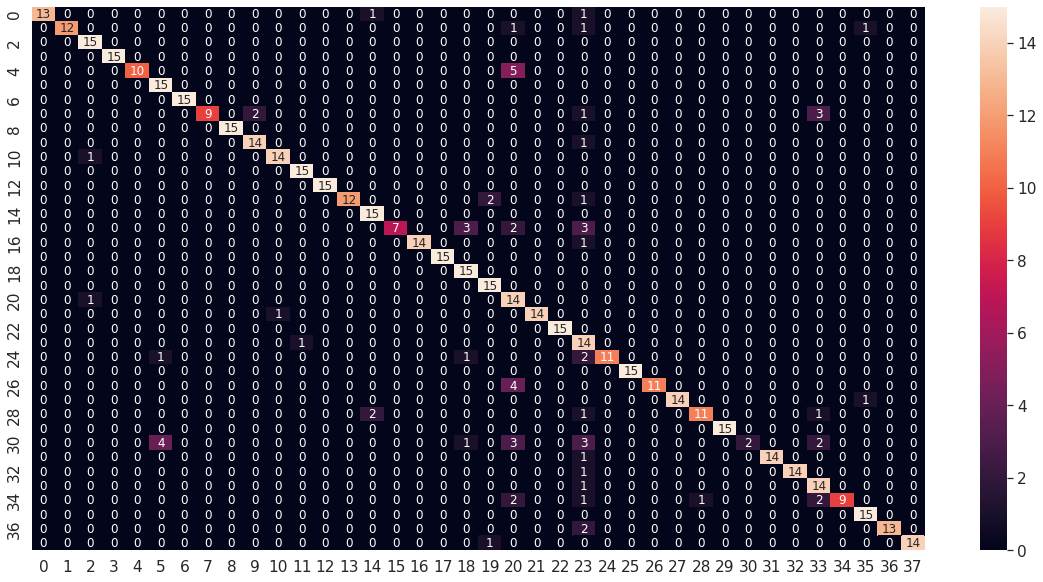

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_yale1_df_CM = pd.DataFrame(deepface_model_yale1_CM, range(38), range(38))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_yale1_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_yale1_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_yale1_report)

              precision    recall  f1-score   support

           1       1.00      0.87      0.93        15
           2       1.00      0.80      0.89        15
           3       0.88      1.00      0.94        15
           4       1.00      1.00      1.00        15
           5       1.00      0.67      0.80        15
           6       0.75      1.00      0.86        15
           7       1.00      1.00      1.00        15
           8       1.00      0.60      0.75        15
           9       1.00      1.00      1.00        15
          10       0.88      0.93      0.90        15
          11       0.93      0.93      0.93        15
          12       0.94      1.00      0.97        15
          13       1.00      1.00      1.00        15
          15       1.00      0.80      0.89        15
          16       0.83      1.00      0.91        15
          17       1.00      0.47      0.64        15
          18       1.00      0.93      0.97        15
          19       1.00    

#### Modelo 2: (BTH = 30, EHS = 20, ValidSplit = 0.2, Dropout=0.7, INI = none, REG = none, OPT = adam[0.001])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_yale2 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_yale2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)            

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
#initializer = tf.keras.initializers.HeNormal()
#reg = tf.keras.regularizers.L2()
#deepface_model.add(Dense(40, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_yale2.add(Dropout(rate=0.7, name='D0'))
deepface_model_yale2.add(Dense(40, activation='softmax', name='Class'))
deepface_model_yale2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)            

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.001)
deepface_model_yale2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/deepface_model_yale2.h5', monitor="val_loss", save_best_only=True)
hist_model_yale2 = deepface_model_yale2.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
50/50 [==============================] - 176s 1s/step - loss: 3.3906 - accuracy: 0.4129 - val_loss: 0.9456 - val_accuracy: 0.7778
Epoch 2/30
50/50 [==============================] - 11s 214ms/step - loss: 1.3604 - accuracy: 0.7336 - val_loss: 0.4301 - val_accuracy: 0.8835
Epoch 3/30
50/50 [==============================] - 6s 127ms/step - loss: 1.0549 - accuracy: 0.8339 - val_loss: 0.7051 - val_accuracy: 0.9024
Epoch 4/30
50/50 [==============================] - 11s 232ms/step - loss: 1.6551 - accuracy: 0.8339 - val_loss: 0.3994 - val_accuracy: 0.9458
Epoch 5/30
50/50 [==============================] - 6s 130ms/step - loss: 1.4855 - accuracy: 0.8712 - val_loss: 3.2475 - val_accuracy: 0.8130
Epoch 6/30
50/50 [==============================] - 7s 141ms/step - loss: 2.9488 - accuracy: 0.8441 - val_loss: 0.6507 - val_accuracy: 0.9485
Epoch 7/30
50/50 [==============================] - 7s 136ms/step - loss: 2.7853 - accuracy: 0.8773 - val_loss: 1.9464 - val_accuracy: 0.9187
Epoch

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_yale2 = load_model(path + 'data_reconocimiento2/deepface_model_yale2.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_yale2.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_yale2.evaluate(testX, testY)

18/18 [==============================] - 1s 69ms/step - loss: 1.6264 - accuracy: 0.9825


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_yale2.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_yale2_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

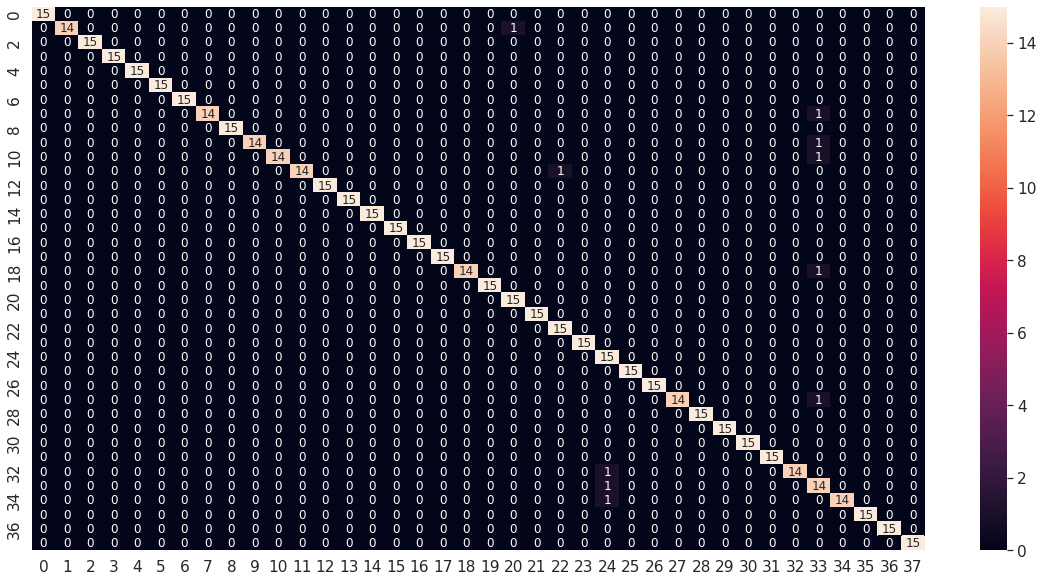

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_yale2_df_CM = pd.DataFrame(deepface_model_yale2_CM, range(38), range(38))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_yale2_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_yale2_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_yale2_report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       1.00      0.93      0.97        15
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15
           8       1.00      0.93      0.97        15
           9       1.00      1.00      1.00        15
          10       1.00      0.93      0.97        15
          11       1.00      0.93      0.97        15
          12       1.00      0.93      0.97        15
          13       1.00      1.00      1.00        15
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00        15
          17       1.00      1.00      1.00        15
          18       1.00      1.00      1.00        15
          19       1.00    

#### Modelo 3: (BTH = 30, EHS = 30, ValidSplit = 0.2, Dropout=0.2, INI = none, REG = none, OPT = adam[0.001])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_yale3 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_yale3.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)            

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
#initializer = tf.keras.initializers.HeNormal()
#reg = tf.keras.regularizers.L2()
#deepface_model.add(Dense(40, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_yale3.add(Dropout(rate=0.2, name='D0'))
deepface_model_yale3.add(Dense(40, activation='softmax', name='Class'))
deepface_model_yale3.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)            

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.001)
deepface_model_yale3.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/deepface_model_yale3.h5', monitor="val_loss", save_best_only=True)
hist_model_yale3 = deepface_model_yale3.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
50/50 [==============================] - 181s 1s/step - loss: 11.4011 - accuracy: 0.8495 - val_loss: 0.0624 - val_accuracy: 0.9946
Epoch 2/30
50/50 [==============================] - 12s 245ms/step - loss: 0.1233 - accuracy: 0.9912 - val_loss: 0.0357 - val_accuracy: 0.9946
Epoch 3/30
50/50 [==============================] - 6s 127ms/step - loss: 0.2145 - accuracy: 0.9919 - val_loss: 0.1869 - val_accuracy: 0.9892
Epoch 4/30
50/50 [==============================] - 7s 144ms/step - loss: 0.1394 - accuracy: 0.9925 - val_loss: 0.1584 - val_accuracy: 0.9946
Epoch 5/30
50/50 [==============================] - 9s 172ms/step - loss: 0.1421 - accuracy: 0.9925 - val_loss: 0.1148 - val_accuracy: 0.9946
Epoch 6/30
50/50 [==============================] - 8s 157ms/step - loss: 0.0743 - accuracy: 0.9932 - val_loss: 0.3535 - val_accuracy: 0.9783
Epoch 7/30
50/50 [==============================] - 7s 148ms/step - loss: 1.1778 - accuracy: 0.9878 - val_loss: 0.7188 - val_accuracy: 0.9783
Epoch

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_yale3 = load_model(path + 'data_reconocimiento2/deepface_model_yale3.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_yale3.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_yale3.evaluate(testX, testY)

18/18 [==============================] - 1s 77ms/step - loss: 1.5731 - accuracy: 0.9877


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_yale3.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_yale3_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

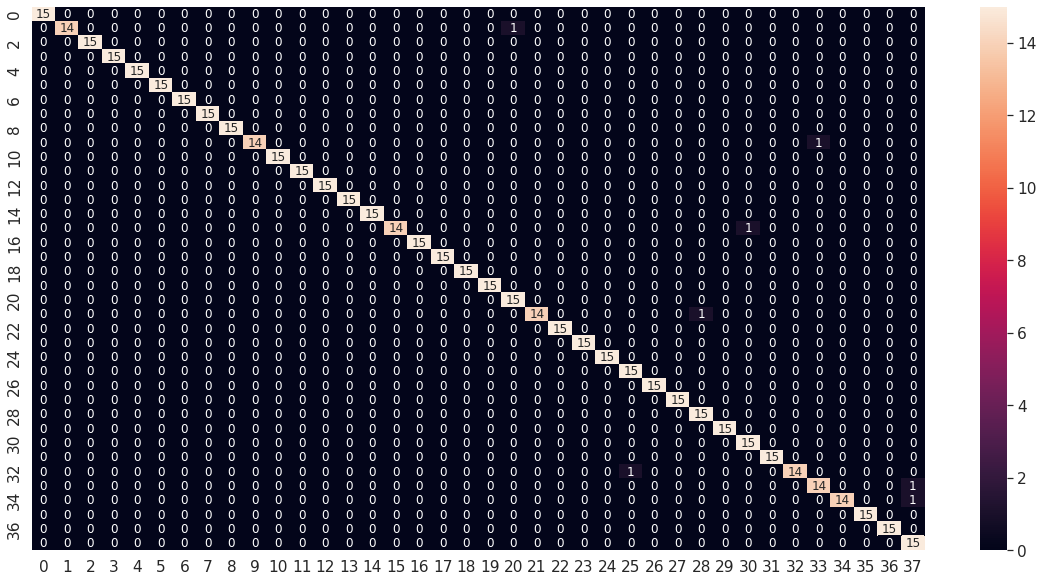

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_yale3_df_CM = pd.DataFrame(deepface_model_yale3_CM, range(38), range(38))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_yale3_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_yale3_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_yale3_report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       1.00      0.93      0.97        15
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00        15
          10       1.00      0.93      0.97        15
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        15
          13       1.00      1.00      1.00        15
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00        15
          17       1.00      0.93      0.97        15
          18       1.00      1.00      1.00        15
          19       1.00    

#### Modelo 4: (BTH = 30, EHS = 30, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_yale4 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_yale4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_yale4.add(Dropout(rate=0, name='D0'))
deepface_model_yale4.add(Dense(40, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_yale4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_yale4.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_YALE1/deepface_model_yale4.h5', monitor="val_loss", save_best_only=True)
hist_model_yale4 = deepface_model_yale4.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
50/50 [==============================] - 149s 898ms/step - loss: 1.9635 - accuracy: 0.7431 - val_loss: 0.6701 - val_accuracy: 0.9783
Epoch 2/30
50/50 [==============================] - 12s 246ms/step - loss: 0.5734 - accuracy: 0.9946 - val_loss: 0.5695 - val_accuracy: 0.9919
Epoch 3/30
50/50 [==============================] - 12s 248ms/step - loss: 0.5160 - accuracy: 0.9939 - val_loss: 0.5247 - val_accuracy: 0.9946
Epoch 4/30
50/50 [==============================] - 12s 246ms/step - loss: 0.4800 - accuracy: 0.9980 - val_loss: 0.4874 - val_accuracy: 0.9919
Epoch 5/30
50/50 [==============================] - 12s 244ms/step - loss: 0.4432 - accuracy: 0.9993 - val_loss: 0.4711 - val_accuracy: 0.9919
Epoch 6/30
50/50 [==============================] - 13s 263ms/step - loss: 0.4143 - accuracy: 0.9993 - val_loss: 0.4414 - val_accuracy: 0.9946
Epoch 7/30
50/50 [==============================] - 12s 249ms/step - loss: 0.3936 - accuracy: 0.9993 - val_loss: 0.4185 - val_accuracy: 0.994

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_yale4 = load_model(path + 'data_reconocimiento2/models_YALE1/deepface_model_yale4.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_yale4.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_yale4.evaluate(testX, testY)

18/18 [==============================] - 2s 89ms/step - loss: 0.1811 - accuracy: 0.9860


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_yale4.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_yale4_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

18/18 [==============================] - 42s 70ms/step


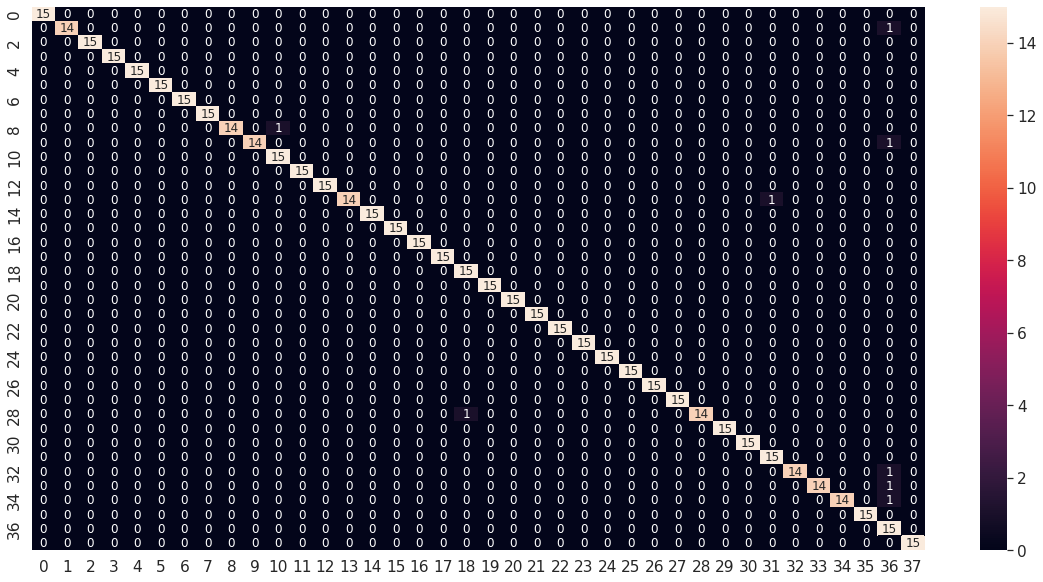

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_yale4_df_CM = pd.DataFrame(deepface_model_yale4_CM, range(38), range(38))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_yale4_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_yale4_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_yale4_report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       1.00      0.93      0.97        15
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        15
           9       1.00      0.93      0.97        15
          10       1.00      0.93      0.97        15
          11       0.94      1.00      0.97        15
          12       1.00      1.00      1.00        15
          13       1.00      1.00      1.00        15
          15       1.00      0.93      0.97        15
          16       1.00      1.00      1.00        15
          17       1.00      1.00      1.00        15
          18       1.00      1.00      1.00        15
          19       1.00    

#### Modelo 5: (BTH = 30, EHS = 60, ValidSplit = 0.2, INI = HeNormal, REG = L2, Dropout=0, OPT = adamax[0.001])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_yale5 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_yale5.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_yale5.add(Dropout(rate=0, name='D0'))
deepface_model_yale5.add(Dense(40, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_yale5.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_yale5.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_YALE1/deepface_model_yale5.h5', monitor="val_loss", save_best_only=True)
hist_model_yale5 = deepface_model_yale5.fit(new_trainX, new_trainY, batch_size=30, epochs=60, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/60
50/50 [==============================] - 139s 929ms/step - loss: 1.6945 - accuracy: 0.8075 - val_loss: 0.5285 - val_accuracy: 0.9756
Epoch 2/60
50/50 [==============================] - 12s 247ms/step - loss: 0.4590 - accuracy: 0.9939 - val_loss: 0.4595 - val_accuracy: 0.9919
Epoch 3/60
50/50 [==============================] - 14s 273ms/step - loss: 0.4146 - accuracy: 0.9980 - val_loss: 0.4098 - val_accuracy: 0.9973
Epoch 4/60
50/50 [==============================] - 14s 276ms/step - loss: 0.3862 - accuracy: 0.9986 - val_loss: 0.3978 - val_accuracy: 0.9946
Epoch 5/60
50/50 [==============================] - 14s 281ms/step - loss: 0.3717 - accuracy: 0.9980 - val_loss: 0.3797 - val_accuracy: 0.9919
Epoch 6/60
50/50 [==============================] - 13s 264ms/step - loss: 0.3525 - accuracy: 0.9986 - val_loss: 0.3536 - val_accuracy: 0.9973
Epoch 7/60
50/50 [==============================] - 13s 271ms/step - loss: 0.3376 - accuracy: 0.9980 - val_loss: 0.3400 - val_accuracy: 0.997

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_yale5 = load_model(path + 'data_reconocimiento2/models_YALE1/deepface_model_yale5.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_yale5.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_yale5.evaluate(testX, testY)

18/18 [==============================] - 1s 67ms/step - loss: 0.0773 - accuracy: 0.9912


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_yale5.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_yale5_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

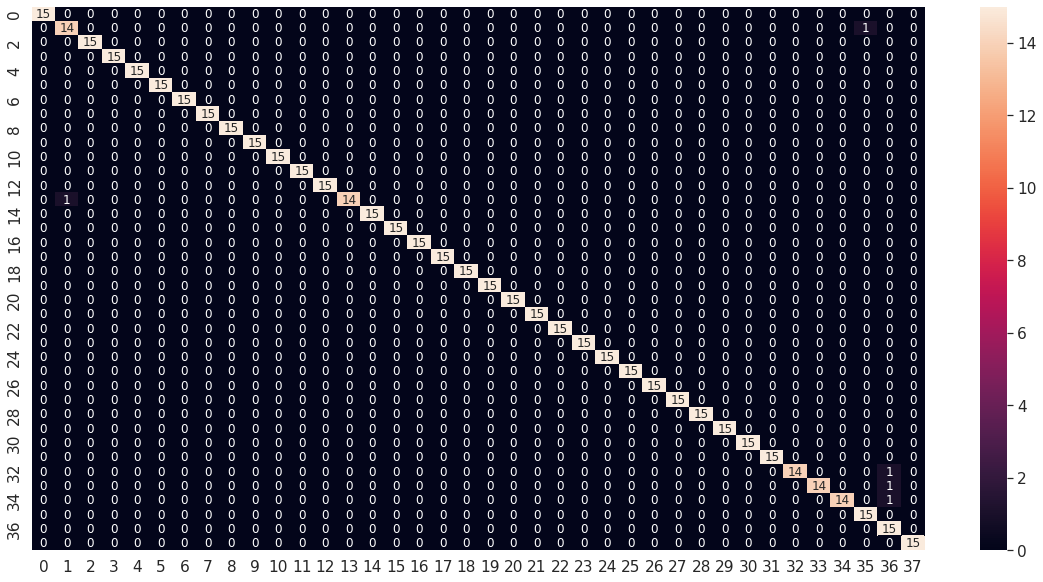

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_yale5_df_CM = pd.DataFrame(deepface_model_yale5_CM, range(38), range(38))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_yale5_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_yale5_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_yale5_report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       0.93      0.93      0.93        15
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00        15
          10       1.00      1.00      1.00        15
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        15
          13       1.00      1.00      1.00        15
          15       1.00      0.93      0.97        15
          16       1.00      1.00      1.00        15
          17       1.00      1.00      1.00        15
          18       1.00      1.00      1.00        15
          19       1.00    

#### Modelo 6: (BTH = 30, EHS = 30, ValidSplit = 0.3, Dropout = 0.2, INI = HeNormal, REG = L2, OPT = adam[0.001])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_yale6 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_yale6.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_yale6.add(Dropout(rate=0.2, name='D0'))
deepface_model_yale6.add(Dense(40, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_yale6.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.001)
deepface_model_yale6.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/deepface_model_yale6.h5', monitor="val_loss", save_best_only=True)
hist_model_yale6 = deepface_model_yale6.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
50/50 [==============================] - 196s 2s/step - loss: 1.7963 - accuracy: 0.7295 - val_loss: 1.0530 - val_accuracy: 0.8808
Epoch 2/30
50/50 [==============================] - 12s 240ms/step - loss: 1.1304 - accuracy: 0.8875 - val_loss: 1.0237 - val_accuracy: 0.8862
Epoch 3/30
50/50 [==============================] - 12s 240ms/step - loss: 0.9567 - accuracy: 0.9017 - val_loss: 0.6855 - val_accuracy: 0.9295
Epoch 4/30
50/50 [==============================] - 7s 140ms/step - loss: 1.3821 - accuracy: 0.8990 - val_loss: 1.1475 - val_accuracy: 0.8889
Epoch 5/30
50/50 [==============================] - 7s 148ms/step - loss: 0.8050 - accuracy: 0.9363 - val_loss: 1.4434 - val_accuracy: 0.8780
Epoch 6/30
50/50 [==============================] - 7s 150ms/step - loss: 0.6703 - accuracy: 0.9519 - val_loss: 0.8990 - val_accuracy: 0.9322
Epoch 7/30
50/50 [==============================] - 7s 146ms/step - loss: 1.0286 - accuracy: 0.9390 - val_loss: 2.3419 - val_accuracy: 0.9024
Epoch

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_yale6 = load_model(path + 'data_reconocimiento2/deepface_model_yale6.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_yale6.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_yale6.evaluate(testX, testY)

18/18 [==============================] - 1s 78ms/step - loss: 0.7633 - accuracy: 0.9368


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_yale6.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_yale6_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

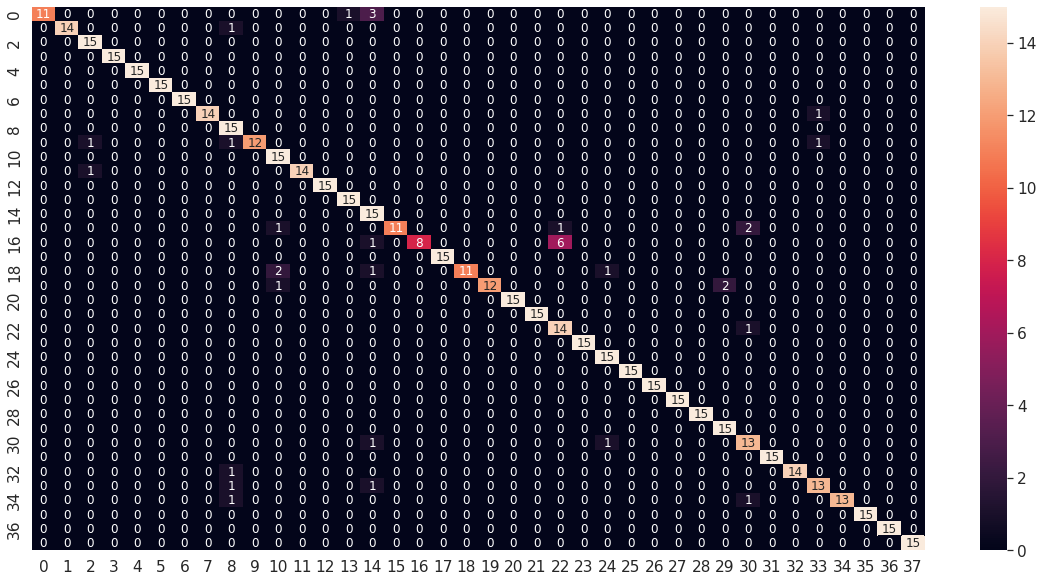

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_yale6_df_CM = pd.DataFrame(deepface_model_yale6_CM, range(38), range(38))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_yale6_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_yale6_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_yale6_report)

              precision    recall  f1-score   support

           1       1.00      0.73      0.85        15
           2       1.00      0.93      0.97        15
           3       0.88      1.00      0.94        15
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15
           8       1.00      0.93      0.97        15
           9       0.75      1.00      0.86        15
          10       1.00      0.80      0.89        15
          11       0.79      1.00      0.88        15
          12       1.00      0.93      0.97        15
          13       1.00      1.00      1.00        15
          15       0.94      1.00      0.97        15
          16       0.68      1.00      0.81        15
          17       1.00      0.73      0.85        15
          18       1.00      0.53      0.70        15
          19       1.00    

#### Modelo 7: (BTH = 30, EHS = 30, ValidSplit = 0.2, Dropout = 0.2, INI = none, REG = none, OPT = adamax[0.001])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_yale7 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_yale7.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)            

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
#initializer = tf.keras.initializers.HeNormal()
#reg = tf.keras.regularizers.L2()
#deepface_model.add(Dense(40, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_yale7.add(Dropout(rate=0.2, name='D0'))
deepface_model_yale7.add(Dense(40, activation='softmax', name='Class'))
deepface_model_yale7.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)            

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_yale7.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/deepface_model_yale7.h5', monitor="val_loss", save_best_only=True)
hist_model_yale7 = deepface_model_yale7.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
50/50 [==============================] - 242s 1s/step - loss: 1.3675 - accuracy: 0.7153 - val_loss: 0.1353 - val_accuracy: 0.9621
Epoch 2/30
50/50 [==============================] - 12s 241ms/step - loss: 0.0599 - accuracy: 0.9803 - val_loss: 0.0774 - val_accuracy: 0.9729
Epoch 3/30
50/50 [==============================] - 12s 234ms/step - loss: 0.0350 - accuracy: 0.9905 - val_loss: 0.0724 - val_accuracy: 0.9756
Epoch 4/30
50/50 [==============================] - 7s 144ms/step - loss: 0.0110 - accuracy: 0.9966 - val_loss: 0.0861 - val_accuracy: 0.9675
Epoch 5/30
50/50 [==============================] - 12s 243ms/step - loss: 0.0107 - accuracy: 0.9973 - val_loss: 0.0428 - val_accuracy: 0.9864
Epoch 6/30
50/50 [==============================] - 7s 140ms/step - loss: 0.0067 - accuracy: 0.9986 - val_loss: 0.0462 - val_accuracy: 0.9892
Epoch 7/30
50/50 [==============================] - 7s 145ms/step - loss: 0.0027 - accuracy: 0.9986 - val_loss: 0.0462 - val_accuracy: 0.9892
Epoc

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_yale7 = load_model(path + 'data_reconocimiento2/deepface_model_yale7.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_yale7.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_yale7.evaluate(testX, testY)

18/18 [==============================] - 1s 78ms/step - loss: 0.0739 - accuracy: 0.9807


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_yale7.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_yale7_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

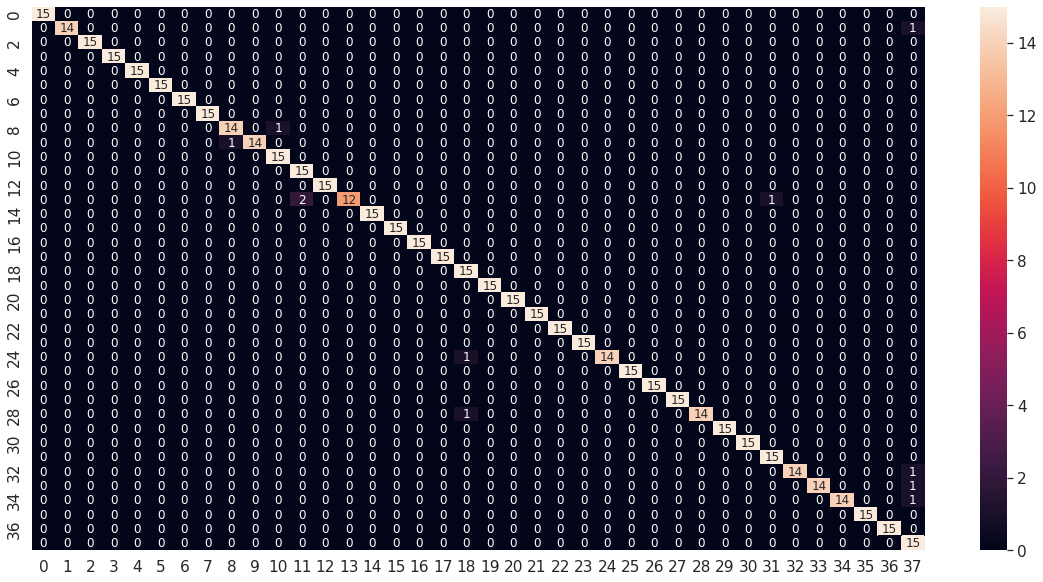

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_yale7_df_CM = pd.DataFrame(deepface_model_yale7_CM, range(38), range(38))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_yale7_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_yale7_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_yale7_report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       1.00      0.93      0.97        15
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        15
           9       0.93      0.93      0.93        15
          10       1.00      0.93      0.97        15
          11       0.94      1.00      0.97        15
          12       0.88      1.00      0.94        15
          13       1.00      1.00      1.00        15
          15       1.00      0.80      0.89        15
          16       1.00      1.00      1.00        15
          17       1.00      1.00      1.00        15
          18       1.00      1.00      1.00        15
          19       1.00    

#### Modelo 8: (BTH = 30, EHS = 30, ValidSplit = 0.2, Dropout = 0,7, INI = none, REG = none, OPT = adamax[0.001])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_yale8 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_yale8.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
#initializer = tf.keras.initializers.HeNormal()
#reg = tf.keras.regularizers.L2()
#deepface_model.add(Dense(40, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_yale8.add(Dropout(rate=0.7, name='D0'))
deepface_model_yale8.add(Dense(40, activation='softmax', name='Class'))
deepface_model_yale8.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_yale8.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/deepface_model_yale8.h5', monitor="val_loss", save_best_only=True)
hist_model_yale8 = deepface_model_yale8.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
50/50 [==============================] - 194s 1s/step - loss: 2.6717 - accuracy: 0.4468 - val_loss: 0.5274 - val_accuracy: 0.8726
Epoch 2/30
50/50 [==============================] - 11s 230ms/step - loss: 0.3870 - accuracy: 0.8780 - val_loss: 0.1936 - val_accuracy: 0.9404
Epoch 3/30
50/50 [==============================] - 12s 245ms/step - loss: 0.1099 - accuracy: 0.9661 - val_loss: 0.1500 - val_accuracy: 0.9539
Epoch 4/30
50/50 [==============================] - 12s 251ms/step - loss: 0.0778 - accuracy: 0.9756 - val_loss: 0.1384 - val_accuracy: 0.9648
Epoch 5/30
50/50 [==============================] - 13s 256ms/step - loss: 0.0389 - accuracy: 0.9878 - val_loss: 0.1204 - val_accuracy: 0.9702
Epoch 6/30
50/50 [==============================] - 8s 169ms/step - loss: 0.0283 - accuracy: 0.9932 - val_loss: 0.1346 - val_accuracy: 0.9702
Epoch 7/30
50/50 [==============================] - 9s 179ms/step - loss: 0.0134 - accuracy: 0.9973 - val_loss: 0.1391 - val_accuracy: 0.9675
Epo

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_yale8 = load_model(path + 'data_reconocimiento2/deepface_model_yale8.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_yale8.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_yale8.evaluate(testX, testY)

18/18 [==============================] - 1s 82ms/step - loss: 0.0805 - accuracy: 0.9842


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_yale8.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_yale8_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

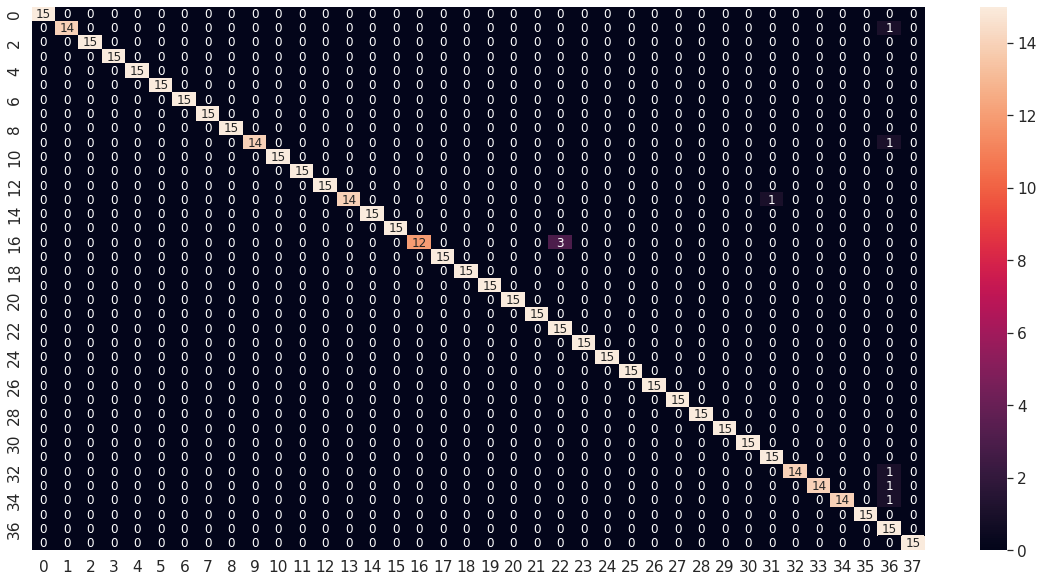

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_yale8_df_CM = pd.DataFrame(deepface_model_yale8_CM, range(38), range(38))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_yale8_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_yale8_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_yale8_report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       1.00      0.93      0.97        15
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00        15
          10       1.00      0.93      0.97        15
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        15
          13       1.00      1.00      1.00        15
          15       1.00      0.93      0.97        15
          16       1.00      1.00      1.00        15
          17       1.00      1.00      1.00        15
          18       1.00      0.80      0.89        15
          19       1.00    

#### Modelo 9: (BTH = 30, EHS = 30, ValidSplit = 0.2, Dropout = 0, INI = HeNormal, REG = L2, OPT = SGD[0.001, momentum=0.9])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_yale9 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_yale9.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_yale9.add(Dropout(rate=0, name='D0'))
deepface_model_yale9.add(Dense(40, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_yale9.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_yale9.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_YALE1/deepface_model_yale9.h5', monitor="val_loss", save_best_only=True)
hist_model_yale9 = deepface_model_yale9.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
50/50 [==============================] - 148s 934ms/step - loss: 2.8605 - accuracy: 0.8353 - val_loss: 0.8536 - val_accuracy: 0.9946
Epoch 2/30
50/50 [==============================] - 11s 216ms/step - loss: 0.8547 - accuracy: 0.9959 - val_loss: 0.8303 - val_accuracy: 1.0000
Epoch 3/30
50/50 [==============================] - 10s 204ms/step - loss: 0.8235 - accuracy: 0.9986 - val_loss: 0.8134 - val_accuracy: 1.0000
Epoch 4/30
50/50 [==============================] - 10s 207ms/step - loss: 0.8061 - accuracy: 0.9993 - val_loss: 0.7971 - val_accuracy: 1.0000
Epoch 5/30
50/50 [==============================] - 10s 208ms/step - loss: 0.7891 - accuracy: 0.9993 - val_loss: 0.7810 - val_accuracy: 1.0000
Epoch 6/30
50/50 [==============================] - 10s 203ms/step - loss: 0.7729 - accuracy: 1.0000 - val_loss: 0.7652 - val_accuracy: 1.0000
Epoch 7/30
50/50 [==============================] - 10s 209ms/step - loss: 0.7573 - accuracy: 1.0000 - val_loss: 0.7499 - val_accuracy: 1.000

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_yale9 = load_model(path + 'data_reconocimiento2/models_YALE1/deepface_model_yale9.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_yale9.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_yale9.evaluate(testX, testY)

18/18 [==============================] - 1s 68ms/step - loss: 0.5313 - accuracy: 0.9895


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_yale9.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_yale9_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

18/18 [==============================] - 36s 65ms/step


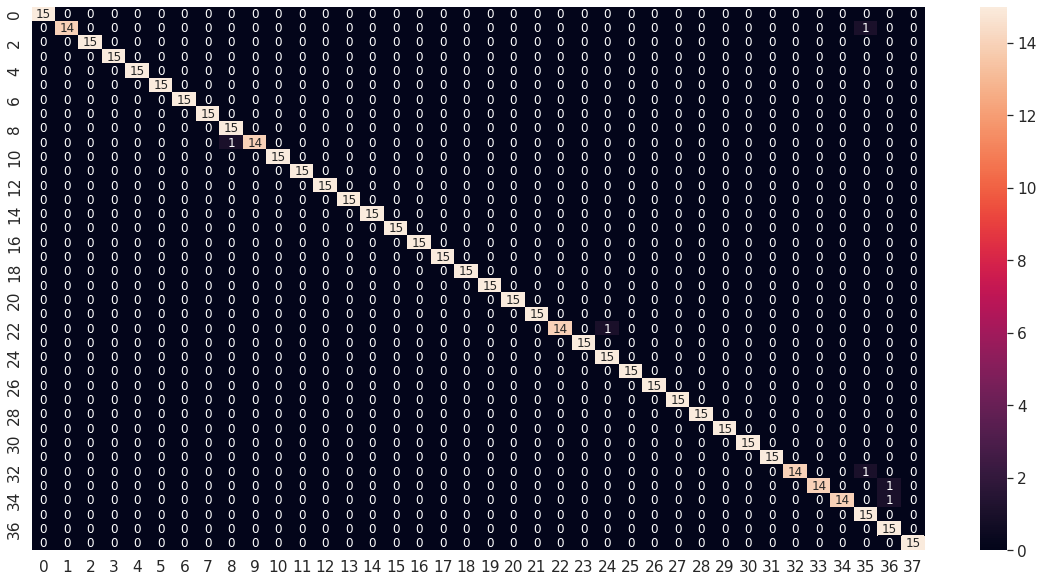

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_yale9_df_CM = pd.DataFrame(deepface_model_yale9_CM, range(38), range(38))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_yale9_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_yale9_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_yale9_report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       1.00      0.93      0.97        15
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        15
           9       0.94      1.00      0.97        15
          10       1.00      0.93      0.97        15
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        15
          13       1.00      1.00      1.00        15
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00        15
          17       1.00      1.00      1.00        15
          18       1.00      1.00      1.00        15
          19       1.00    

#### Modelo 10: (BTH = 30, EHS = 60, ValidSplit = 0.3, Dropout = 0, INI = HeNormal, REG = L2, OPT = SGD[0.001, momentum = 0.9])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_yale10 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_yale10.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_yale10.add(Dropout(rate=0, name='D0'))
deepface_model_yale10.add(Dense(40, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_yale10.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_yale10.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_YALE1/deepface_model_yale10.h5', monitor="val_loss", save_best_only=True)
hist_model_yale10 = deepface_model_yale10.fit(new_trainX, new_trainY, batch_size=30, epochs=60, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/60
50/50 [==============================] - 138s 848ms/step - loss: 1.8317 - accuracy: 0.8400 - val_loss: 0.8140 - val_accuracy: 0.9973
Epoch 2/60
50/50 [==============================] - 10s 207ms/step - loss: 0.8005 - accuracy: 0.9986 - val_loss: 0.7994 - val_accuracy: 0.9973
Epoch 3/60
50/50 [==============================] - 10s 210ms/step - loss: 0.7818 - accuracy: 0.9993 - val_loss: 0.7835 - val_accuracy: 0.9973
Epoch 4/60
50/50 [==============================] - 10s 210ms/step - loss: 0.7653 - accuracy: 1.0000 - val_loss: 0.7683 - val_accuracy: 0.9973
Epoch 5/60
50/50 [==============================] - 10s 209ms/step - loss: 0.7496 - accuracy: 1.0000 - val_loss: 0.7535 - val_accuracy: 0.9973
Epoch 6/60
50/50 [==============================] - 11s 217ms/step - loss: 0.7346 - accuracy: 1.0000 - val_loss: 0.7392 - val_accuracy: 0.9973
Epoch 7/60
50/50 [==============================] - 11s 215ms/step - loss: 0.7199 - accuracy: 1.0000 - val_loss: 0.7249 - val_accuracy: 0.997

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_yale10 = load_model(path + 'data_reconocimiento2/models_YALE1/deepface_model_yale10.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_yale10.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_yale10.evaluate(testX, testY)

18/18 [==============================] - 1s 73ms/step - loss: 0.3039 - accuracy: 0.9895


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_yale10.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_yale10_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

18/18 [==============================] - 35s 66ms/step


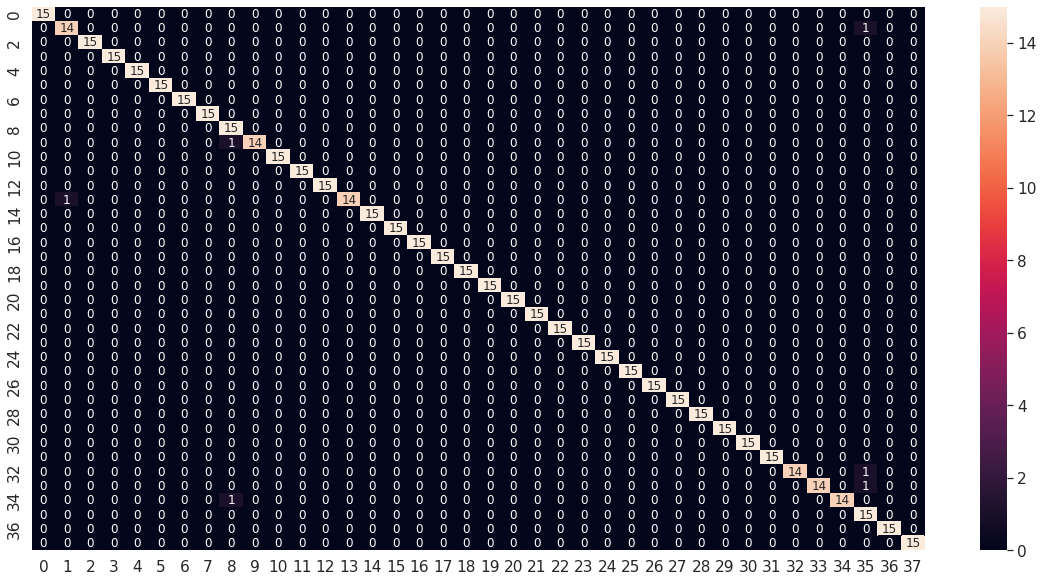

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_yale10_df_CM = pd.DataFrame(deepface_model_yale10_CM, range(38), range(38))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_yale10_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_yale10_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_yale10_report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       0.93      0.93      0.93        15
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        15
           9       0.88      1.00      0.94        15
          10       1.00      0.93      0.97        15
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        15
          13       1.00      1.00      1.00        15
          15       1.00      0.93      0.97        15
          16       1.00      1.00      1.00        15
          17       1.00      1.00      1.00        15
          18       1.00      1.00      1.00        15
          19       1.00    

#### Modelo 11: (BTH = 40, EHS = 40, ValidSplit = 0.2, Dropout = 0.2, INI = none, REG = none, OPT = adam[0.001])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_yale11 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_yale11.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
#initializer = tf.keras.initializers.HeNormal()
#reg = tf.keras.regularizers.L2()
#deepface_model_yale11.add(Dense(40, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_yale11.add(Dropout(rate=0.2, name='D0'))
deepface_model_yale11.add(Dense(40, activation='softmax', name='Class'))
deepface_model_yale11.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.001)
deepface_model_yale11.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/deepface_model_yale11.h5', monitor="val_loss", save_best_only=True)
hist_model_yale11 = deepface_model_yale11.fit(new_trainX, new_trainY, batch_size=40, epochs=40, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/40
37/37 [==============================] - 194s 2s/step - loss: 1.8627 - accuracy: 0.6312 - val_loss: 1.3042 - val_accuracy: 0.8211
Epoch 2/40
37/37 [==============================] - 6s 150ms/step - loss: 0.7816 - accuracy: 0.8644 - val_loss: 1.3475 - val_accuracy: 0.8238
Epoch 3/40
37/37 [==============================] - 10s 283ms/step - loss: 0.9948 - accuracy: 0.8739 - val_loss: 1.0354 - val_accuracy: 0.9024
Epoch 4/40
37/37 [==============================] - 6s 150ms/step - loss: 1.2954 - accuracy: 0.8922 - val_loss: 1.1764 - val_accuracy: 0.8889
Epoch 5/40
37/37 [==============================] - 6s 149ms/step - loss: 0.8056 - accuracy: 0.9356 - val_loss: 1.4918 - val_accuracy: 0.9024
Epoch 6/40
37/37 [==============================] - 5s 149ms/step - loss: 0.6956 - accuracy: 0.9431 - val_loss: 1.6822 - val_accuracy: 0.9160
Epoch 7/40
37/37 [==============================] - 10s 277ms/step - loss: 0.5193 - accuracy: 0.9688 - val_loss: 0.6946 - val_accuracy: 0.9485
Epoch

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_yale11 = load_model(path + 'data_reconocimiento2/deepface_model_yale11.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_yale11.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_yale11.evaluate(testX, testY)

18/18 [==============================] - 1s 80ms/step - loss: 0.8592 - accuracy: 0.9456


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_yale11.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_yale11_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

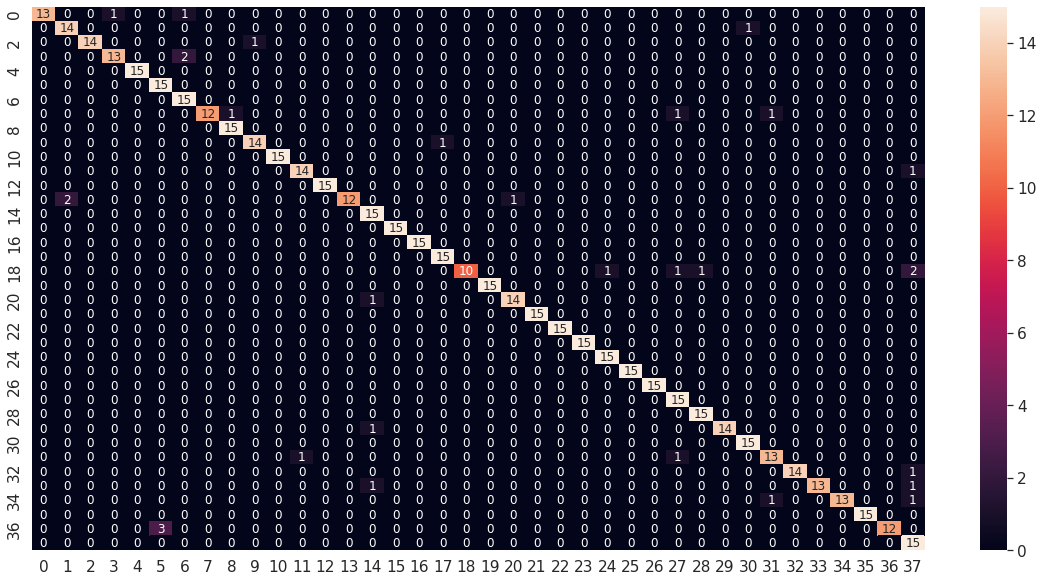

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_yale11_df_CM = pd.DataFrame(deepface_model_yale11_CM, range(38), range(38))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_yale11_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_yale11_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_yale11_report)

              precision    recall  f1-score   support

           1       1.00      0.87      0.93        15
           2       0.88      0.93      0.90        15
           3       1.00      0.93      0.97        15
           4       0.93      0.87      0.90        15
           5       1.00      1.00      1.00        15
           6       0.83      1.00      0.91        15
           7       0.83      1.00      0.91        15
           8       1.00      0.80      0.89        15
           9       0.94      1.00      0.97        15
          10       0.93      0.93      0.93        15
          11       1.00      1.00      1.00        15
          12       0.93      0.93      0.93        15
          13       1.00      1.00      1.00        15
          15       1.00      0.80      0.89        15
          16       0.83      1.00      0.91        15
          17       1.00      1.00      1.00        15
          18       1.00      1.00      1.00        15
          19       0.94    

#### Modelo 12: (BTH = 40, EHS = 40, ValidSplit = 0.2, Dropout = 0.7, INI = none, REG = none, OPT = adam[0.001])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_yale12 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_yale12.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
#initializer = tf.keras.initializers.HeNormal()
#reg = tf.keras.regularizers.L2()
#deepface_model_yale11.add(Dense(40, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_yale12.add(Dropout(rate=0.7, name='D0'))
deepface_model_yale12.add(Dense(40, activation='softmax', name='Class'))
deepface_model_yale12.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.001)
deepface_model_yale12.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/deepface_model_yale12.h5', monitor="val_loss", save_best_only=True)
hist_model_yale12 = deepface_model_yale12.fit(new_trainX, new_trainY, batch_size=40, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
37/37 [==============================] - 188s 2s/step - loss: 3.0532 - accuracy: 0.4515 - val_loss: 0.6366 - val_accuracy: 0.8293
Epoch 2/30
37/37 [==============================] - 15s 398ms/step - loss: 1.1017 - accuracy: 0.7892 - val_loss: 0.5962 - val_accuracy: 0.8808
Epoch 3/30
37/37 [==============================] - 10s 286ms/step - loss: 0.9550 - accuracy: 0.8671 - val_loss: 0.1848 - val_accuracy: 0.9593
Epoch 4/30
37/37 [==============================] - 6s 152ms/step - loss: 1.0021 - accuracy: 0.8841 - val_loss: 0.6377 - val_accuracy: 0.9106
Epoch 5/30
37/37 [==============================] - 6s 151ms/step - loss: 1.3012 - accuracy: 0.8888 - val_loss: 1.4680 - val_accuracy: 0.8645
Epoch 6/30
37/37 [==============================] - 5s 149ms/step - loss: 1.4470 - accuracy: 0.8895 - val_loss: 0.6130 - val_accuracy: 0.9350
Epoch 7/30
37/37 [==============================] - 6s 150ms/step - loss: 1.1228 - accuracy: 0.9247 - val_loss: 0.8534 - val_accuracy: 0.9377
Epoch

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_yale12 = load_model(path + 'data_reconocimiento2/deepface_model_yale12.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_yale12.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_yale12.evaluate(testX, testY)

18/18 [==============================] - 2s 82ms/step - loss: 0.3759 - accuracy: 0.9386


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_yale12.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_yale12_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

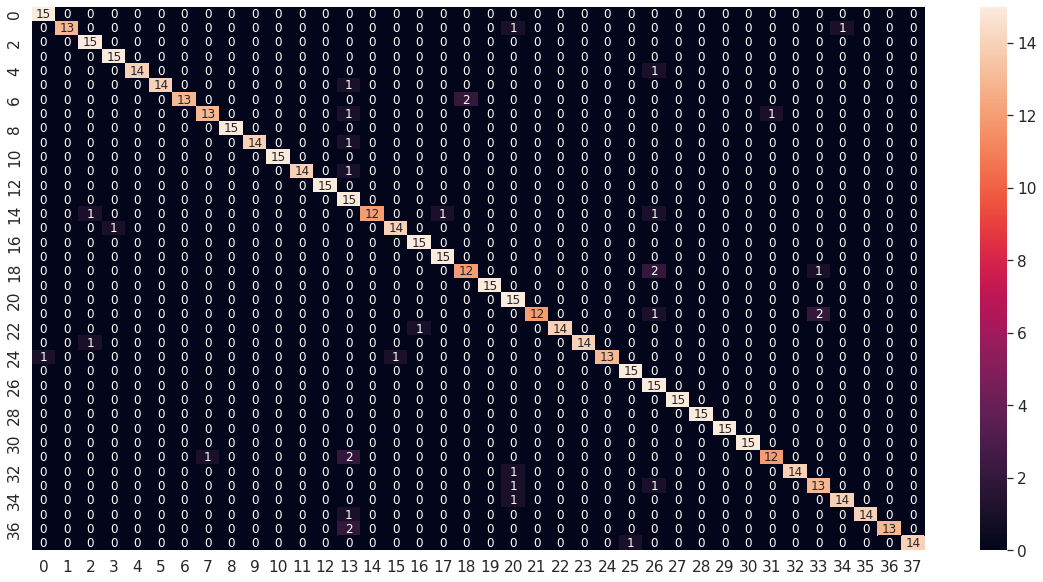

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_yale12_df_CM = pd.DataFrame(deepface_model_yale12_CM, range(38), range(38))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_yale12_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_yale12_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_yale12_report)

              precision    recall  f1-score   support

           1       0.94      1.00      0.97        15
           2       1.00      0.87      0.93        15
           3       0.88      1.00      0.94        15
           4       0.94      1.00      0.97        15
           5       1.00      0.93      0.97        15
           6       1.00      0.93      0.97        15
           7       1.00      0.87      0.93        15
           8       0.93      0.87      0.90        15
           9       1.00      1.00      1.00        15
          10       1.00      0.93      0.97        15
          11       1.00      1.00      1.00        15
          12       1.00      0.93      0.97        15
          13       1.00      1.00      1.00        15
          15       0.62      1.00      0.77        15
          16       1.00      0.80      0.89        15
          17       0.93      0.93      0.93        15
          18       0.94      1.00      0.97        15
          19       0.94    

#### Modelo 13: (BTH = 30, EHS = 30, ValidSplit = 0.2, Dropout = 0.2, INI = HeNormal, Dropout=0.2, REG = L2, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_yale13 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_yale13.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_yale13.add(Dropout(rate=0.2, name='D0'))
deepface_model_yale13.add(Dense(40, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_yale13.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_yale13.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/deepface_model_yale13.h5', monitor="val_loss", save_best_only=True)
hist_model_yale13 = deepface_model_yale13.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
50/50 [==============================] - 190s 1s/step - loss: 2.0924 - accuracy: 0.6908 - val_loss: 0.7238 - val_accuracy: 0.9675
Epoch 2/30
50/50 [==============================] - 13s 264ms/step - loss: 0.6247 - accuracy: 0.9810 - val_loss: 0.5696 - val_accuracy: 0.9892
Epoch 3/30
50/50 [==============================] - 12s 235ms/step - loss: 0.5313 - accuracy: 0.9959 - val_loss: 0.5371 - val_accuracy: 0.9892
Epoch 4/30
50/50 [==============================] - 12s 244ms/step - loss: 0.4923 - accuracy: 0.9980 - val_loss: 0.5180 - val_accuracy: 0.9892
Epoch 5/30
50/50 [==============================] - 12s 233ms/step - loss: 0.4676 - accuracy: 0.9980 - val_loss: 0.4699 - val_accuracy: 0.9946
Epoch 6/30
50/50 [==============================] - 11s 230ms/step - loss: 0.4417 - accuracy: 0.9973 - val_loss: 0.4494 - val_accuracy: 0.9919
Epoch 7/30
50/50 [==============================] - 11s 227ms/step - loss: 0.4174 - accuracy: 0.9993 - val_loss: 0.4405 - val_accuracy: 0.9892
E

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_yale13 = load_model(path + 'data_reconocimiento2/deepface_model_yale13.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_yale13.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_yale13.evaluate(testX, testY)

18/18 [==============================] - 1s 79ms/step - loss: 0.1910 - accuracy: 0.9895


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_yale13.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_yale13_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

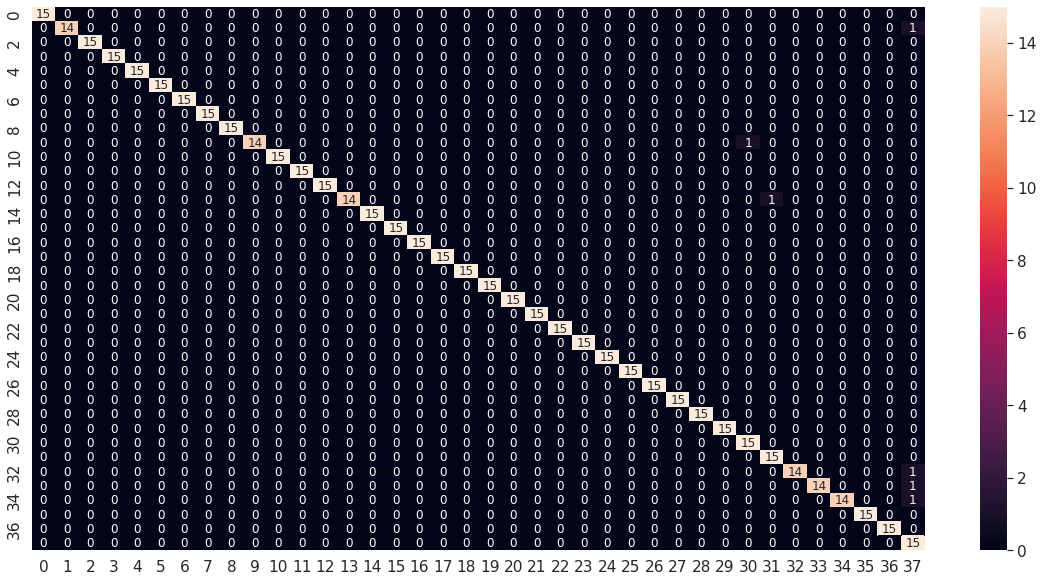

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_yale13_df_CM = pd.DataFrame(deepface_model_yale13_CM, range(38), range(38))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_yale13_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_yale13_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_yale13_report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       1.00      0.93      0.97        15
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00        15
          10       1.00      0.93      0.97        15
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        15
          13       1.00      1.00      1.00        15
          15       1.00      0.93      0.97        15
          16       1.00      1.00      1.00        15
          17       1.00      1.00      1.00        15
          18       1.00      1.00      1.00        15
          19       1.00    

#### Modelo 14: (BTH = 30, EHS = 30, ValidSplit = 0.2, INI = HeNormal, Dropout=0.7, REG = L2, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_yale14 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_yale14.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_yale14.add(Dropout(rate=0.7, name='D0'))
deepface_model_yale14.add(Dense(40, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_yale14.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_yale14.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/deepface_model_yale14.h5', monitor="val_loss", save_best_only=True)
hist_model_yale14 = deepface_model_yale14.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
50/50 [==============================] - 188s 1s/step - loss: 3.2918 - accuracy: 0.4359 - val_loss: 0.9684 - val_accuracy: 0.8916
Epoch 2/30
50/50 [==============================] - 13s 257ms/step - loss: 0.9568 - accuracy: 0.8671 - val_loss: 0.5530 - val_accuracy: 0.9837
Epoch 3/30
50/50 [==============================] - 11s 231ms/step - loss: 0.6069 - accuracy: 0.9627 - val_loss: 0.5106 - val_accuracy: 0.9864
Epoch 4/30
50/50 [==============================] - 12s 232ms/step - loss: 0.5245 - accuracy: 0.9837 - val_loss: 0.4819 - val_accuracy: 0.9919
Epoch 5/30
50/50 [==============================] - 11s 225ms/step - loss: 0.4785 - accuracy: 0.9912 - val_loss: 0.4681 - val_accuracy: 0.9946
Epoch 6/30
50/50 [==============================] - 12s 247ms/step - loss: 0.4632 - accuracy: 0.9925 - val_loss: 0.4427 - val_accuracy: 0.9973
Epoch 7/30
50/50 [==============================] - 13s 262ms/step - loss: 0.4421 - accuracy: 0.9932 - val_loss: 0.4398 - val_accuracy: 0.9946
E

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_yale14 = load_model(path + 'data_reconocimiento2/deepface_model_yale14.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_yale14.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_yale14.evaluate(testX, testY)

18/18 [==============================] - 1s 75ms/step - loss: 0.3070 - accuracy: 0.9860


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_yale14.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_yale14_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

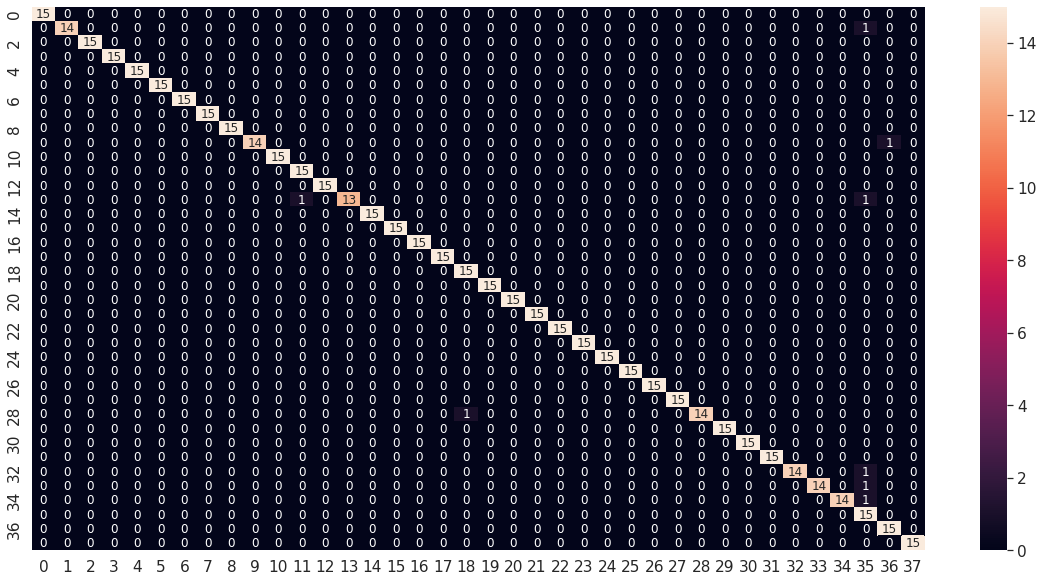

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_yale14_df_CM = pd.DataFrame(deepface_model_yale14_CM, range(38), range(38))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_yale14_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_yale14_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_yale14_report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       1.00      0.93      0.97        15
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00        15
          10       1.00      0.93      0.97        15
          11       1.00      1.00      1.00        15
          12       0.94      1.00      0.97        15
          13       1.00      1.00      1.00        15
          15       1.00      0.87      0.93        15
          16       1.00      1.00      1.00        15
          17       1.00      1.00      1.00        15
          18       1.00      1.00      1.00        15
          19       1.00    

#### Modelo 15: (BTH = 30, EHS = 30, ValidSplit = 0.2, Dropout = 0.2, INI = HeNoraml, REG = L2, OPT = SGD[0.001, momentum=0.9])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_yale15 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_yale15.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_yale15.add(Dropout(rate=0.2, name='D0'))
deepface_model_yale15.add(Dense(40, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_yale15.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_yale15.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/deepface_model_yale15.h5', monitor="val_loss", save_best_only=True)
hist_model_yale15 = deepface_model_yale15.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
50/50 [==============================] - 167s 987ms/step - loss: 3.0052 - accuracy: 0.4908 - val_loss: 1.3414 - val_accuracy: 0.8943
Epoch 2/30
50/50 [==============================] - 9s 183ms/step - loss: 1.0549 - accuracy: 0.9559 - val_loss: 1.0913 - val_accuracy: 0.9431
Epoch 3/30
50/50 [==============================] - 9s 185ms/step - loss: 0.8916 - accuracy: 0.9871 - val_loss: 0.9904 - val_accuracy: 0.9539
Epoch 4/30
50/50 [==============================] - 10s 207ms/step - loss: 0.8315 - accuracy: 0.9939 - val_loss: 0.9425 - val_accuracy: 0.9675
Epoch 5/30
50/50 [==============================] - 12s 233ms/step - loss: 0.7918 - accuracy: 0.9973 - val_loss: 0.9047 - val_accuracy: 0.9729
Epoch 6/30
50/50 [==============================] - 10s 202ms/step - loss: 0.7668 - accuracy: 0.9980 - val_loss: 0.8756 - val_accuracy: 0.9783
Epoch 7/30
50/50 [==============================] - 10s 195ms/step - loss: 0.7465 - accuracy: 0.9973 - val_loss: 0.8533 - val_accuracy: 0.9810


In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_yale15 = load_model(path + 'data_reconocimiento2/deepface_model_yale15.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_yale15.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_yale15.evaluate(testX, testY)

18/18 [==============================] - 1s 81ms/step - loss: 0.5903 - accuracy: 0.9754


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_yale15.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_yale15_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

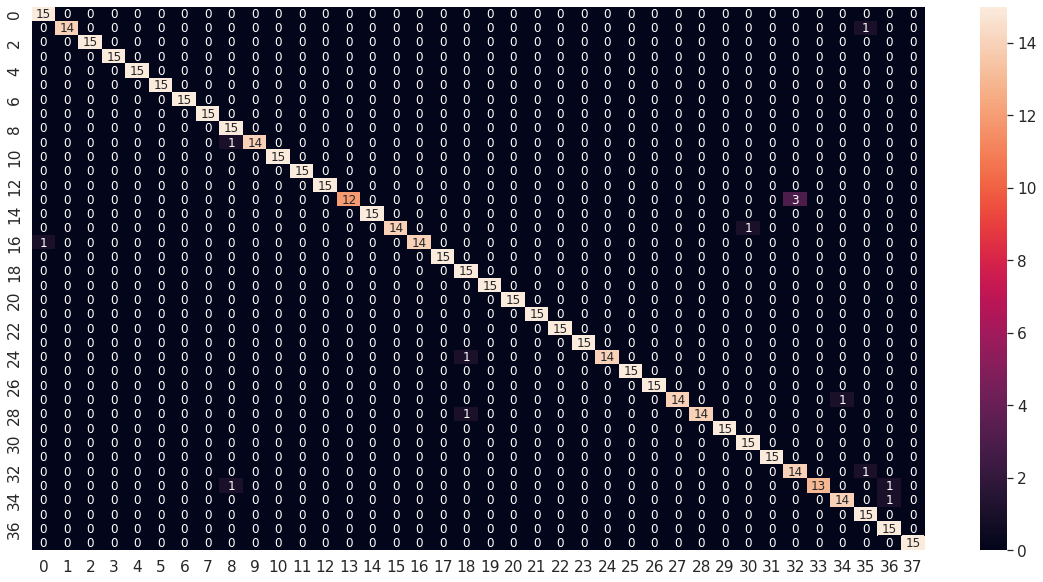

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_yale15_df_CM = pd.DataFrame(deepface_model_yale15_CM, range(38), range(38))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_yale15_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_yale15_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_yale15_report)

              precision    recall  f1-score   support

           1       0.94      1.00      0.97        15
           2       1.00      0.93      0.97        15
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        15
           9       0.88      1.00      0.94        15
          10       1.00      0.93      0.97        15
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        15
          13       1.00      1.00      1.00        15
          15       1.00      0.80      0.89        15
          16       1.00      1.00      1.00        15
          17       1.00      0.93      0.97        15
          18       1.00      0.93      0.97        15
          19       1.00    

#### Modelo 16: (BTH = 30, EHS = 30, ValidSplit = 0.2, Dropout = 0.7, INI = HeNoraml, REG = L2, OPT = SGD[0.001, momentum=0.9])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_yale16 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_yale16.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_yale16.add(Dropout(rate=0.7, name='D0'))
deepface_model_yale16.add(Dense(40, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_yale16.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_yale16.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/deepface_model_yale16.h5', monitor="val_loss", save_best_only=True)
hist_model_yale16 = deepface_model_yale16.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
50/50 [==============================] - 179s 1s/step - loss: 4.3384 - accuracy: 0.3342 - val_loss: 1.5382 - val_accuracy: 0.8564
Epoch 2/30
50/50 [==============================] - 10s 192ms/step - loss: 1.4490 - accuracy: 0.8136 - val_loss: 1.1850 - val_accuracy: 0.9322
Epoch 3/30
50/50 [==============================] - 9s 190ms/step - loss: 1.1127 - accuracy: 0.9064 - val_loss: 1.0401 - val_accuracy: 0.9648
Epoch 4/30
50/50 [==============================] - 10s 192ms/step - loss: 0.9639 - accuracy: 0.9559 - val_loss: 0.9679 - val_accuracy: 0.9702
Epoch 5/30
50/50 [==============================] - 11s 214ms/step - loss: 0.8847 - accuracy: 0.9708 - val_loss: 0.9195 - val_accuracy: 0.9756
Epoch 6/30
50/50 [==============================] - 10s 194ms/step - loss: 0.8356 - accuracy: 0.9790 - val_loss: 0.8893 - val_accuracy: 0.9783
Epoch 7/30
50/50 [==============================] - 10s 193ms/step - loss: 0.8050 - accuracy: 0.9864 - val_loss: 0.8526 - val_accuracy: 0.9783
Ep

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_yale16 = load_model(path + 'data_reconocimiento2/deepface_model_yale16.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_yale16.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_yale16.evaluate(testX, testY)

18/18 [==============================] - 1s 78ms/step - loss: 0.5665 - accuracy: 0.9825


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_yale16.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_yale16_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

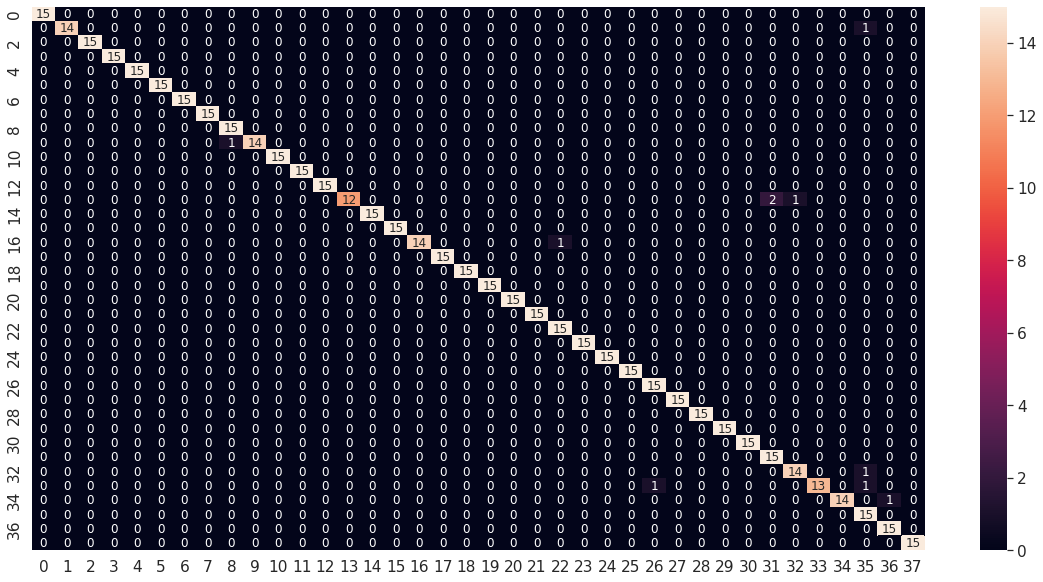

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_yale16_df_CM = pd.DataFrame(deepface_model_yale16_CM, range(38), range(38))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_yale16_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_yale16_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_yale16_report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       1.00      0.93      0.97        15
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        15
           9       0.94      1.00      0.97        15
          10       1.00      0.93      0.97        15
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        15
          13       1.00      1.00      1.00        15
          15       1.00      0.80      0.89        15
          16       1.00      1.00      1.00        15
          17       1.00      1.00      1.00        15
          18       1.00      0.93      0.97        15
          19       1.00    

#### Modelo 17: (BTH = 30, EHS = 30, ValidSplit = 0.2, Dropout=0.1, INI = none, REG = none, OPT = adam[0.001])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_yale17 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_yale17.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
#initializer = tf.keras.initializers.HeNormal()
#reg = tf.keras.regularizers.L2()
#deepface_model.add(Dense(40, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_yale17.add(Dropout(rate=0.1, name='D0'))
deepface_model_yale17.add(Dense(40, activation='softmax', name='Class'))
deepface_model_yale17.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.001)
deepface_model_yale17.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/deepface_model_yale17.h5', monitor="val_loss", save_best_only=True)
hist_model_yale17 = deepface_model_yale17.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
50/50 [==============================] - 248s 2s/step - loss: 1.9604 - accuracy: 0.6373 - val_loss: 1.4346 - val_accuracy: 0.7317
Epoch 2/30
50/50 [==============================] - 12s 235ms/step - loss: 0.8726 - accuracy: 0.8590 - val_loss: 1.2439 - val_accuracy: 0.8374
Epoch 3/30
50/50 [==============================] - 11s 229ms/step - loss: 0.9845 - accuracy: 0.8936 - val_loss: 0.8852 - val_accuracy: 0.8835
Epoch 4/30
50/50 [==============================] - 7s 140ms/step - loss: 1.2123 - accuracy: 0.8929 - val_loss: 1.7869 - val_accuracy: 0.8455
Epoch 5/30
50/50 [==============================] - 7s 138ms/step - loss: 1.2568 - accuracy: 0.9078 - val_loss: 3.0095 - val_accuracy: 0.8455
Epoch 6/30
50/50 [==============================] - 7s 142ms/step - loss: 1.8651 - accuracy: 0.9078 - val_loss: 1.4832 - val_accuracy: 0.9160
Epoch 7/30
50/50 [==============================] - 7s 139ms/step - loss: 1.2149 - accuracy: 0.9315 - val_loss: 2.1217 - val_accuracy: 0.9187
Epoch

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_yale17 = load_model(path + 'data_reconocimiento2/deepface_model_yale17.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_yale17.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_yale17.evaluate(testX, testY)

18/18 [==============================] - 1s 79ms/step - loss: 0.7718 - accuracy: 0.9772


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_yale17.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_yale17_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

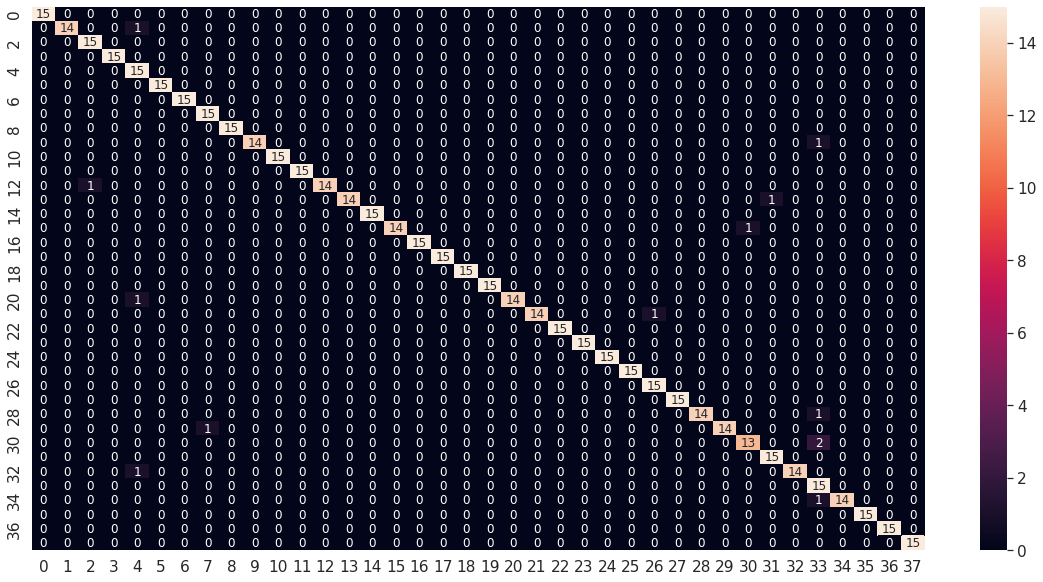

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_yale17_df_CM = pd.DataFrame(deepface_model_yale17_CM, range(38), range(38))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_yale17_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_yale17_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_yale17_report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       1.00      0.93      0.97        15
           3       0.94      1.00      0.97        15
           4       1.00      1.00      1.00        15
           5       0.83      1.00      0.91        15
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15
           8       0.94      1.00      0.97        15
           9       1.00      1.00      1.00        15
          10       1.00      0.93      0.97        15
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        15
          13       1.00      0.93      0.97        15
          15       1.00      0.93      0.97        15
          16       1.00      1.00      1.00        15
          17       1.00      0.93      0.97        15
          18       1.00      1.00      1.00        15
          19       1.00    

#### Modelo 18: (BTH = 30, EHS = 30, ValidSplit = 0.2, Dropout=0.8, INI = none, REG = none, OPT = adam[0.001])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_yale18 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_yale18.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
#initializer = tf.keras.initializers.HeNormal()
#reg = tf.keras.regularizers.L2()
#deepface_model.add(Dense(40, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_yale18.add(Dropout(rate=0.8, name='D0'))
deepface_model_yale18.add(Dense(40, activation='softmax', name='Class'))
deepface_model_yale18.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.001)
deepface_model_yale18.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/deepface_model_yale18.h5', monitor="val_loss", save_best_only=True)
hist_model_yale18 = deepface_model_yale18.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
50/50 [==============================] - 181s 1s/step - loss: 4.2434 - accuracy: 0.2868 - val_loss: 1.0972 - val_accuracy: 0.7073
Epoch 2/30
50/50 [==============================] - 12s 241ms/step - loss: 1.8447 - accuracy: 0.6475 - val_loss: 0.6775 - val_accuracy: 0.8374
Epoch 3/30
50/50 [==============================] - 7s 139ms/step - loss: 1.3988 - accuracy: 0.7641 - val_loss: 0.7244 - val_accuracy: 0.8618
Epoch 4/30
50/50 [==============================] - 7s 137ms/step - loss: 1.4008 - accuracy: 0.8149 - val_loss: 0.7126 - val_accuracy: 0.8780
Epoch 5/30
50/50 [==============================] - 7s 138ms/step - loss: 1.7482 - accuracy: 0.8258 - val_loss: 1.0400 - val_accuracy: 0.8753
Epoch 6/30
50/50 [==============================] - 7s 138ms/step - loss: 1.8844 - accuracy: 0.8488 - val_loss: 1.5093 - val_accuracy: 0.8509
Epoch 7/30
50/50 [==============================] - 7s 138ms/step - loss: 3.3801 - accuracy: 0.8359 - val_loss: 1.0757 - val_accuracy: 0.9160
Epoch 

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_yale18 = load_model(path + 'data_reconocimiento2/deepface_model_yale18.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_yale18.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_yale18.evaluate(testX, testY)

18/18 [==============================] - 1s 79ms/step - loss: 0.6134 - accuracy: 0.8737


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_yale18.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_yale18_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

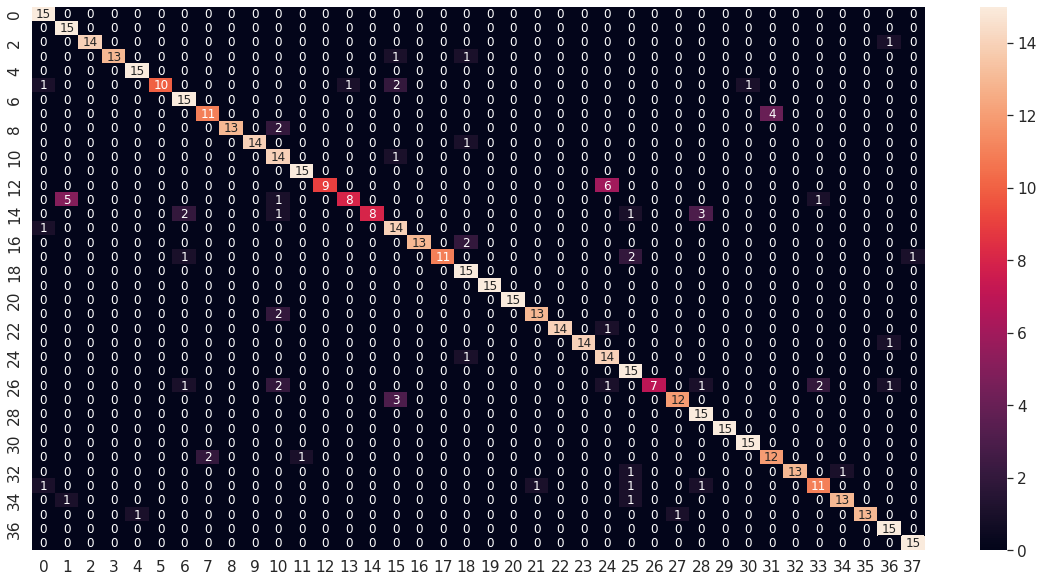

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_yale18_df_CM = pd.DataFrame(deepface_model_yale18_CM, range(38), range(38))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_yale18_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_yale18_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_yale18_report)

              precision    recall  f1-score   support

           1       0.83      1.00      0.91        15
           2       0.71      1.00      0.83        15
           3       1.00      0.93      0.97        15
           4       1.00      0.87      0.93        15
           5       0.94      1.00      0.97        15
           6       1.00      0.67      0.80        15
           7       0.79      1.00      0.88        15
           8       0.85      0.73      0.79        15
           9       1.00      0.87      0.93        15
          10       1.00      0.93      0.97        15
          11       0.64      0.93      0.76        15
          12       0.94      1.00      0.97        15
          13       1.00      0.60      0.75        15
          15       0.89      0.53      0.67        15
          16       1.00      0.53      0.70        15
          17       0.67      0.93      0.78        15
          18       1.00      0.87      0.93        15
          19       1.00    

#### Modelo 19: (BTH = 30, EHS = 40, ValidSplit = 0.2, Dropout = 0.2, INI = HeNormal, Dropout=0.2, REG = L2, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_yale19 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_yale19.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_yale19.add(Dropout(rate=0.2, name='D0'))
deepface_model_yale19.add(Dense(40, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_yale19.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_yale19.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/deepface_model_yale19.h5', monitor="val_loss", save_best_only=True)
hist_model_yale19 = deepface_model_yale19.fit(new_trainX, new_trainY, batch_size=30, epochs=40, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/40
50/50 [==============================] - 128s 850ms/step - loss: 1.9995 - accuracy: 0.7132 - val_loss: 0.7570 - val_accuracy: 0.9377
Epoch 2/40
50/50 [==============================] - 10s 207ms/step - loss: 0.6061 - accuracy: 0.9803 - val_loss: 0.6069 - val_accuracy: 0.9756
Epoch 3/40
50/50 [==============================] - 10s 203ms/step - loss: 0.5298 - accuracy: 0.9959 - val_loss: 0.5449 - val_accuracy: 0.9837
Epoch 4/40
50/50 [==============================] - 10s 202ms/step - loss: 0.4916 - accuracy: 0.9973 - val_loss: 0.5079 - val_accuracy: 0.9892
Epoch 5/40
50/50 [==============================] - 10s 206ms/step - loss: 0.4640 - accuracy: 0.9980 - val_loss: 0.4786 - val_accuracy: 0.9919
Epoch 6/40
50/50 [==============================] - 10s 204ms/step - loss: 0.4388 - accuracy: 0.9986 - val_loss: 0.4585 - val_accuracy: 0.9946
Epoch 7/40
50/50 [==============================] - 10s 208ms/step - loss: 0.4215 - accuracy: 0.9980 - val_loss: 0.4390 - val_accuracy: 0.991

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_yale19 = load_model(path + 'data_reconocimiento2/deepface_model_yale19.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_yale19.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_yale19.evaluate(testX, testY)

18/18 [==============================] - 1s 61ms/step - loss: 0.1341 - accuracy: 0.9877


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_yale19.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_yale19_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

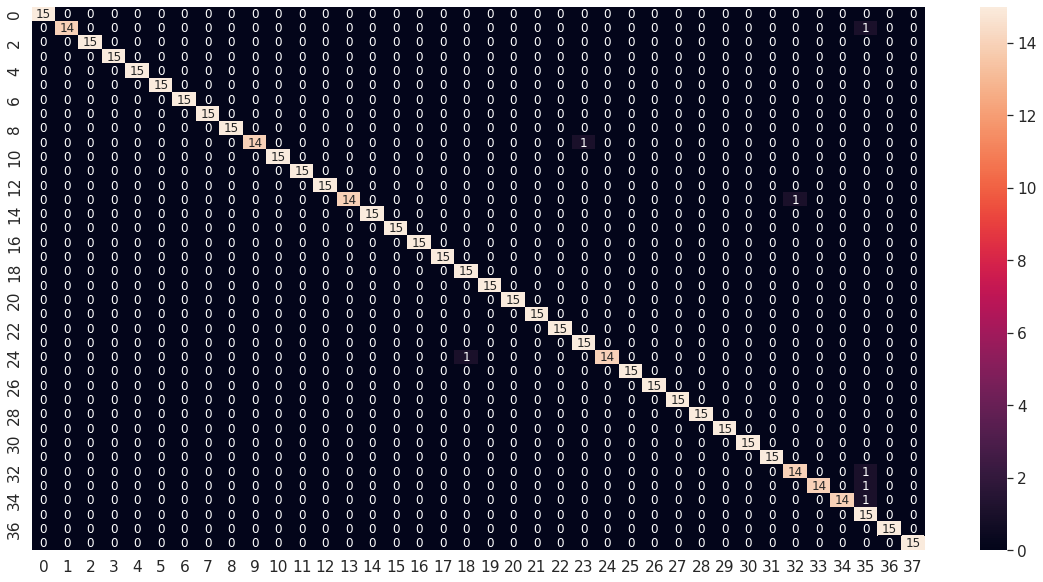

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_yale19_df_CM = pd.DataFrame(deepface_model_yale19_CM, range(38), range(38))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_yale19_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_yale19_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_yale19_report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       1.00      0.93      0.97        15
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00        15
          10       1.00      0.93      0.97        15
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        15
          13       1.00      1.00      1.00        15
          15       1.00      0.93      0.97        15
          16       1.00      1.00      1.00        15
          17       1.00      1.00      1.00        15
          18       1.00      1.00      1.00        15
          19       1.00    

#### Modelo 20: (BTH = 30, EHS = 40, ValidSplit = 0.2, Dropout = 0.2, INI = none, Dropout=0.2, REG = none, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_yale20 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_yale20.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
#initializer = tf.keras.initializers.HeNormal()
#reg = tf.keras.regularizers.L2()
deepface_model_yale20.add(Dropout(rate=0.2, name='D0'))
deepface_model_yale20.add(Dense(40, activation='softmax', name='Class'))
deepface_model_yale20.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_yale20.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/deepface_model_yale20.h5', monitor="val_loss", save_best_only=True)
hist_model_yale20 = deepface_model_yale20.fit(new_trainX, new_trainY, batch_size=30, epochs=40, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/40
50/50 [==============================] - 130s 827ms/step - loss: 1.3242 - accuracy: 0.7153 - val_loss: 0.1421 - val_accuracy: 0.9621
Epoch 2/40
50/50 [==============================] - 10s 202ms/step - loss: 0.0555 - accuracy: 0.9824 - val_loss: 0.0594 - val_accuracy: 0.9837
Epoch 3/40
50/50 [==============================] - 6s 118ms/step - loss: 0.0238 - accuracy: 0.9912 - val_loss: 0.0671 - val_accuracy: 0.9783
Epoch 4/40
50/50 [==============================] - 10s 204ms/step - loss: 0.0090 - accuracy: 0.9980 - val_loss: 0.0493 - val_accuracy: 0.9919
Epoch 5/40
50/50 [==============================] - 10s 199ms/step - loss: 0.0119 - accuracy: 0.9966 - val_loss: 0.0375 - val_accuracy: 0.9946
Epoch 6/40
50/50 [==============================] - 6s 120ms/step - loss: 0.0163 - accuracy: 0.9973 - val_loss: 0.0443 - val_accuracy: 0.9864
Epoch 7/40
50/50 [==============================] - 6s 124ms/step - loss: 0.0081 - accuracy: 0.9973 - val_loss: 0.0536 - val_accuracy: 0.9864
E

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_yale20 = load_model(path + 'data_reconocimiento2/deepface_model_yale20.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_yale20.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_yale20.evaluate(testX, testY)

18/18 [==============================] - 1s 61ms/step - loss: 0.0782 - accuracy: 0.9860


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_yale20.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_yale20_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

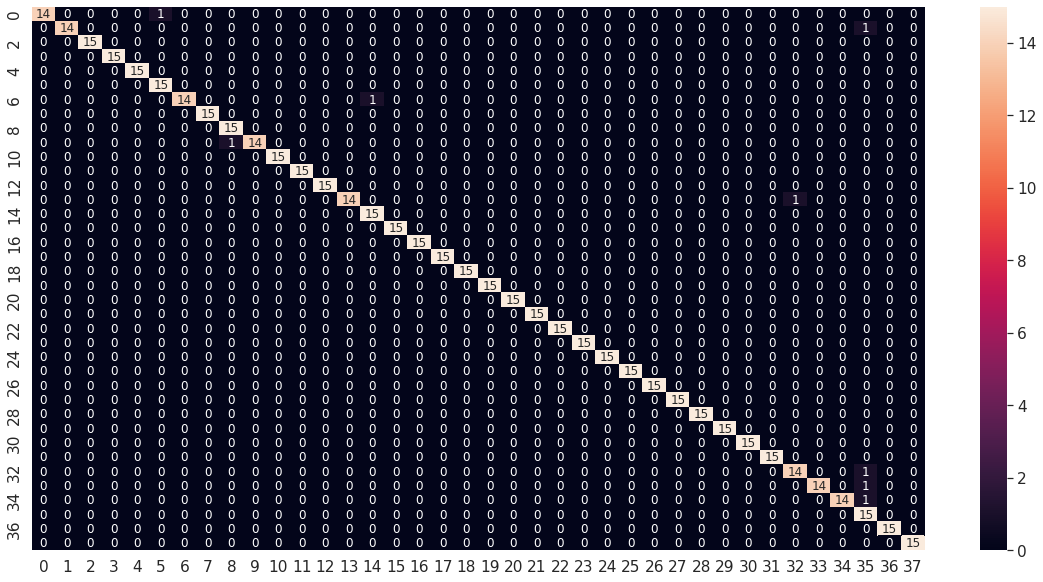

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_yale20_df_CM = pd.DataFrame(deepface_model_yale20_CM, range(38), range(38))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_yale20_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_yale20_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_yale20_report)

              precision    recall  f1-score   support

           1       1.00      0.93      0.97        15
           2       1.00      0.93      0.97        15
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        15
           6       0.94      1.00      0.97        15
           7       1.00      0.93      0.97        15
           8       1.00      1.00      1.00        15
           9       0.94      1.00      0.97        15
          10       1.00      0.93      0.97        15
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        15
          13       1.00      1.00      1.00        15
          15       1.00      0.93      0.97        15
          16       0.94      1.00      0.97        15
          17       1.00      1.00      1.00        15
          18       1.00      1.00      1.00        15
          19       1.00    

## 5. Modelos con base de datos ROF1 para condiciones de oclusión

#### Modelo 1: (BTH = 30, EHS = 30, ValidSplit = 0.2, Dropout=0, INI = HeNormal, REG = L2, OPT = adam[0.001])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof1_1 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof1_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final dropout y softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof1_1.add(Dropout(rate=0, name='D0'))
deepface_model_rof1_1.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof1_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)    
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.001)
deepface_model_rof1_1.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_1.h5', monitor="val_loss", save_best_only=True)
hist_model_rof1_1 = deepface_model_rof1_1.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
27/27 [==============================] - 146s 2s/step - loss: 3.3612 - accuracy: 0.4338 - val_loss: 1.9508 - val_accuracy: 0.5550
Epoch 2/30
27/27 [==============================] - 9s 321ms/step - loss: 0.9043 - accuracy: 0.8037 - val_loss: 1.8163 - val_accuracy: 0.6350
Epoch 3/30
27/27 [==============================] - 4s 148ms/step - loss: 0.5030 - accuracy: 0.8988 - val_loss: 2.7631 - val_accuracy: 0.6050
Epoch 4/30
27/27 [==============================] - 4s 148ms/step - loss: 0.5988 - accuracy: 0.8913 - val_loss: 3.3058 - val_accuracy: 0.6050
Epoch 5/30
27/27 [==============================] - 4s 159ms/step - loss: 0.6785 - accuracy: 0.9038 - val_loss: 2.7203 - val_accuracy: 0.6200
Epoch 6/30
27/27 [==============================] - 4s 152ms/step - loss: 0.6178 - accuracy: 0.9013 - val_loss: 3.0332 - val_accuracy: 0.6150
Epoch 7/30
27/27 [==============================] - 4s 159ms/step - loss: 0.5588 - accuracy: 0.9062 - val_loss: 4.1854 - val_accuracy: 0.6200
Epoch 8

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof1_1 = load_model(path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_1.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof1_1.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof1_1.evaluate(testX, testY)

7/7 [==============================] - 1s 67ms/step - loss: 3.6646 - accuracy: 0.4650


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof1_1.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof1_1_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

7/7 [==============================] - 31s 69ms/step


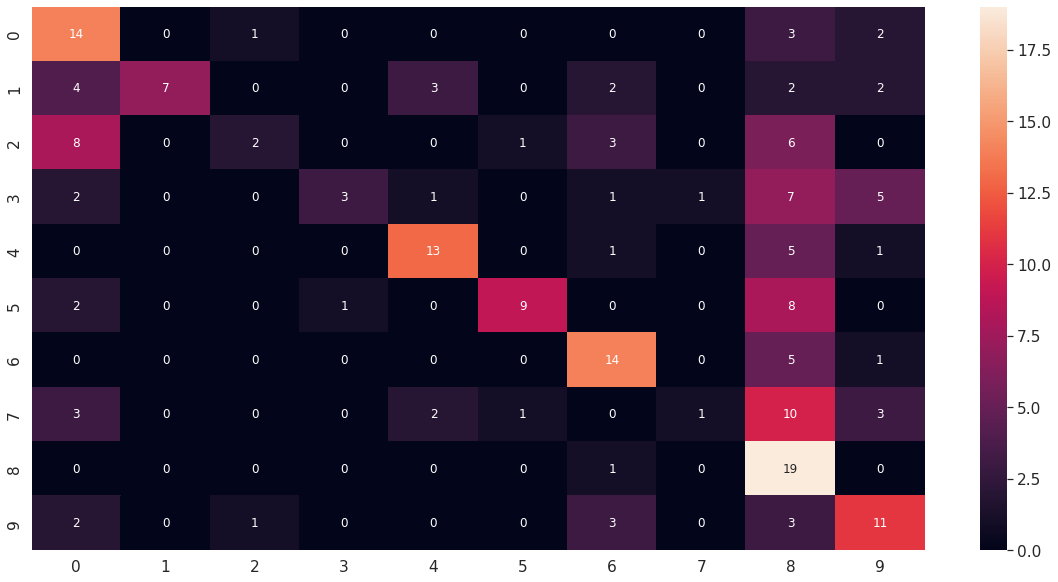

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof1_1_df_CM = pd.DataFrame(deepface_model_rof1_1_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof1_1_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof1_1_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof1_1_report)

              precision    recall  f1-score   support

           1       0.40      0.70      0.51        20
           2       1.00      0.35      0.52        20
           3       0.50      0.10      0.17        20
           4       0.75      0.15      0.25        20
           5       0.68      0.65      0.67        20
           6       0.82      0.45      0.58        20
           7       0.56      0.70      0.62        20
           8       0.50      0.05      0.09        20
           9       0.28      0.95      0.43        20
          10       0.44      0.55      0.49        20

    accuracy                           0.47       200
   macro avg       0.59      0.46      0.43       200
weighted avg       0.59      0.47      0.43       200



#### Modelo 2: (BTH = 30, EHS = 30, ValidSplit = 0.2, Dropout=0.5, INI = HeNormal, REG = L2, OPT = adam[0.001])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof1_2 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof1_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final dropout y softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof1_2.add(Dropout(rate=0.5, name='D0'))
deepface_model_rof1_2.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof1_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)    
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.001)
deepface_model_rof1_2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_2.h5', monitor="val_loss", save_best_only=True)
hist_model_rof1_2 = deepface_model_rof1_2.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
27/27 [==============================] - 139s 2s/step - loss: 32.4885 - accuracy: 0.6237 - val_loss: 11.6044 - val_accuracy: 0.6700
Epoch 2/30
27/27 [==============================] - 9s 341ms/step - loss: 1.7783 - accuracy: 0.9312 - val_loss: 10.5420 - val_accuracy: 0.6750
Epoch 3/30
27/27 [==============================] - 8s 319ms/step - loss: 0.3792 - accuracy: 0.9737 - val_loss: 9.2779 - val_accuracy: 0.6850
Epoch 4/30
27/27 [==============================] - 9s 338ms/step - loss: 0.3851 - accuracy: 0.9712 - val_loss: 8.0827 - val_accuracy: 0.7150
Epoch 5/30
27/27 [==============================] - 8s 316ms/step - loss: 0.5468 - accuracy: 0.9712 - val_loss: 7.9508 - val_accuracy: 0.7600
Epoch 6/30
27/27 [==============================] - 4s 148ms/step - loss: 0.1843 - accuracy: 0.9837 - val_loss: 8.3937 - val_accuracy: 0.7500
Epoch 7/30
27/27 [==============================] - 8s 315ms/step - loss: 0.2459 - accuracy: 0.9862 - val_loss: 7.7889 - val_accuracy: 0.7550
Epoc

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof1_2 = load_model(path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_2.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof1_2.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof1_2.evaluate(testX, testY)

7/7 [==============================] - 0s 65ms/step - loss: 18.5585 - accuracy: 0.6650


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof1_2.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof1_2_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

7/7 [==============================] - 33s 65ms/step


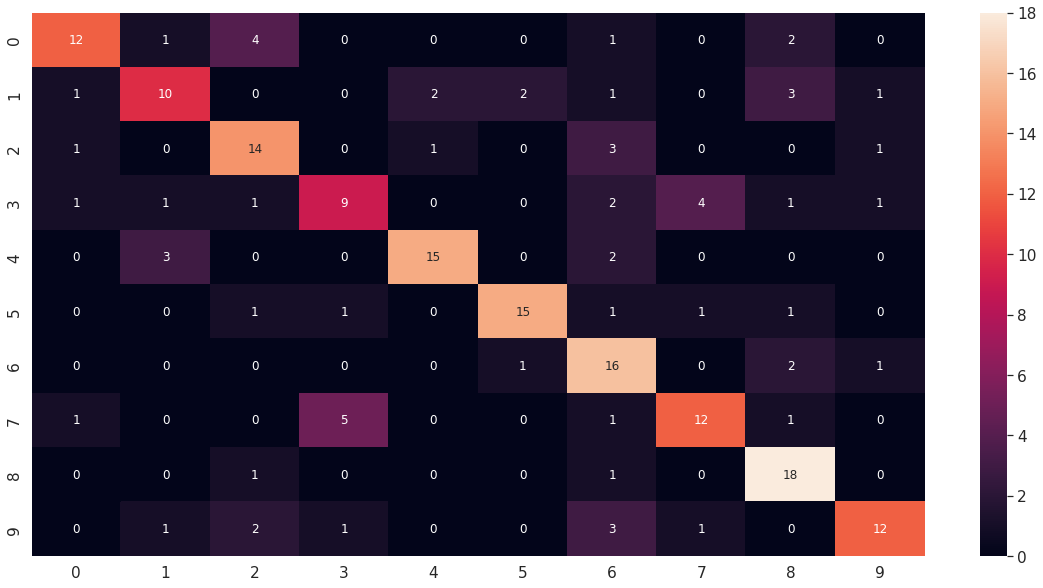

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof1_2_df_CM = pd.DataFrame(deepface_model_rof1_2_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof1_2_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof1_2_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof1_2_report)

              precision    recall  f1-score   support

           1       0.75      0.60      0.67        20
           2       0.62      0.50      0.56        20
           3       0.61      0.70      0.65        20
           4       0.56      0.45      0.50        20
           5       0.83      0.75      0.79        20
           6       0.83      0.75      0.79        20
           7       0.52      0.80      0.63        20
           8       0.67      0.60      0.63        20
           9       0.64      0.90      0.75        20
          10       0.75      0.60      0.67        20

    accuracy                           0.67       200
   macro avg       0.68      0.67      0.66       200
weighted avg       0.68      0.67      0.66       200



#### Modelo 3: (BTH = 10, EHS = 40, ValidSplit = 0.2, Dropout=0, INI = HeNormal, REG = L2, OPT = adam[0.001])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof1_3 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof1_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final dropout y softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof1_3.add(Dropout(rate=0, name='D0'))
deepface_model_rof1_3.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof1_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)    
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.001)
deepface_model_rof1_3.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_3.h5', monitor="val_loss", save_best_only=True)
hist_model_rof1_3 = deepface_model_rof1_3.fit(new_trainX, new_trainY, batch_size=10, epochs=40, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/40
80/80 [==============================] - 148s 654ms/step - loss: 5.1194 - accuracy: 0.9100 - val_loss: 20.9692 - val_accuracy: 0.6150
Epoch 2/40
80/80 [==============================] - 13s 169ms/step - loss: 0.2175 - accuracy: 0.9912 - val_loss: 15.2691 - val_accuracy: 0.7100
Epoch 3/40
80/80 [==============================] - 13s 166ms/step - loss: 0.2863 - accuracy: 0.9912 - val_loss: 15.2673 - val_accuracy: 0.6800
Epoch 4/40
80/80 [==============================] - 9s 110ms/step - loss: 0.3243 - accuracy: 0.9900 - val_loss: 18.8421 - val_accuracy: 0.6400
Epoch 5/40
80/80 [==============================] - 9s 112ms/step - loss: 1.3060 - accuracy: 0.9725 - val_loss: 35.8494 - val_accuracy: 0.5800
Epoch 6/40
80/80 [==============================] - 9s 113ms/step - loss: 3.3974 - accuracy: 0.9538 - val_loss: 33.4494 - val_accuracy: 0.6100
Epoch 7/40
80/80 [==============================] - 9s 110ms/step - loss: 4.6840 - accuracy: 0.9563 - val_loss: 30.1491 - val_accuracy: 0.

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof1_3 = load_model(path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_3.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof1_3.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof1_3.evaluate(testX, testY)

7/7 [==============================] - 0s 63ms/step - loss: 30.1616 - accuracy: 0.5950


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof1_3.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof1_3_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

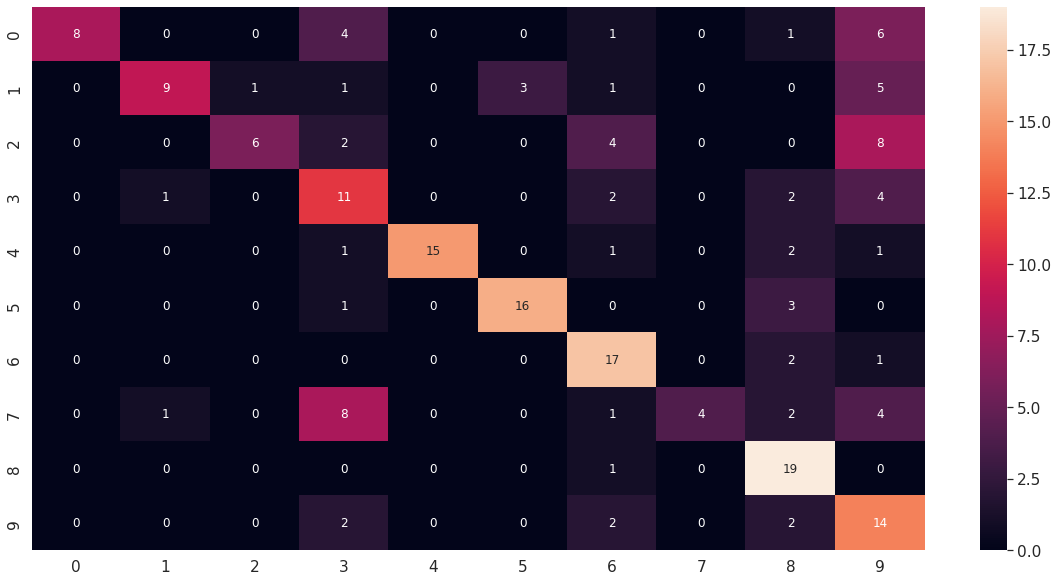

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof1_3_df_CM = pd.DataFrame(deepface_model_rof1_3_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof1_3_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof1_3_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof1_3_report)

              precision    recall  f1-score   support

           1       1.00      0.40      0.57        20
           2       0.82      0.45      0.58        20
           3       0.86      0.30      0.44        20
           4       0.37      0.55      0.44        20
           5       1.00      0.75      0.86        20
           6       0.84      0.80      0.82        20
           7       0.57      0.85      0.68        20
           8       1.00      0.20      0.33        20
           9       0.58      0.95      0.72        20
          10       0.33      0.70      0.44        20

    accuracy                           0.59       200
   macro avg       0.74      0.60      0.59       200
weighted avg       0.74      0.59      0.59       200

              precision    recall  f1-score   support

           1       1.00      0.40      0.57        20
           2       0.82      0.45      0.58        20
           3       0.86      0.30      0.44        20
           4       0.37 

#### Modelo 4: (BTH = 10, EHS = 100, ValidSplit = 0.2, INI = HeNormal, Dropout=0, REG = L2, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof1_4 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof1_4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof1_4.add(Dropout(rate=0, name='D0'))
deepface_model_rof1_4.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof1_4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_rof1_4.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_4.h5', monitor="val_loss", save_best_only=True)
hist_model_rof1_4 = deepface_model_rof1_4.fit(new_trainX, new_trainY, batch_size=10, epochs=100, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/100
80/80 [==============================] - 142s 587ms/step - loss: 2.1056 - accuracy: 0.7038 - val_loss: 1.5240 - val_accuracy: 0.6800
Epoch 2/100
80/80 [==============================] - 14s 182ms/step - loss: 0.1521 - accuracy: 0.9962 - val_loss: 1.3912 - val_accuracy: 0.6900
Epoch 3/100
80/80 [==============================] - 14s 174ms/step - loss: 0.1260 - accuracy: 1.0000 - val_loss: 1.2038 - val_accuracy: 0.7400
Epoch 4/100
80/80 [==============================] - 14s 176ms/step - loss: 0.1202 - accuracy: 1.0000 - val_loss: 1.1910 - val_accuracy: 0.7350
Epoch 5/100
80/80 [==============================] - 14s 177ms/step - loss: 0.1177 - accuracy: 1.0000 - val_loss: 1.1791 - val_accuracy: 0.7450
Epoch 6/100
80/80 [==============================] - 15s 191ms/step - loss: 0.1155 - accuracy: 1.0000 - val_loss: 1.1767 - val_accuracy: 0.7500
Epoch 7/100
80/80 [==============================] - 9s 113ms/step - loss: 0.1133 - accuracy: 1.0000 - val_loss: 1.1851 - val_accuracy:

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof1_4 = load_model(path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_4.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof1_4.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof1_4.evaluate(testX, testY)

ResourceExhaustedError: ignored

In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof1_4.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof1_4_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof1_4_df_CM = pd.DataFrame(deepface_model_rof1_4_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof1_4_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof1_4_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof1_4_report)

#### Modelo 5: (BTH = 20, EHS = 100, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof1_5 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof1_5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof1_5.add(Dropout(rate=0, name='D0'))
deepface_model_rof1_5.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof1_5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_rof1_5.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_5.h5', monitor="val_loss", save_best_only=True)
hist_model_rof1_5 = deepface_model_rof1_5.fit(new_trainX, new_trainY, batch_size=20, epochs=100, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/100
40/40 [==============================] - 140s 1s/step - loss: 2.8536 - accuracy: 0.5113 - val_loss: 1.1224 - val_accuracy: 0.7200
Epoch 2/100
40/40 [==============================] - 10s 253ms/step - loss: 0.2469 - accuracy: 0.9800 - val_loss: 1.1052 - val_accuracy: 0.7050
Epoch 3/100
40/40 [==============================] - 10s 263ms/step - loss: 0.1733 - accuracy: 0.9987 - val_loss: 1.0648 - val_accuracy: 0.7300
Epoch 4/100
40/40 [==============================] - 10s 250ms/step - loss: 0.1590 - accuracy: 1.0000 - val_loss: 1.0257 - val_accuracy: 0.7400
Epoch 5/100
40/40 [==============================] - 10s 247ms/step - loss: 0.1555 - accuracy: 1.0000 - val_loss: 1.0112 - val_accuracy: 0.7400
Epoch 6/100
40/40 [==============================] - 10s 251ms/step - loss: 0.1524 - accuracy: 1.0000 - val_loss: 1.0011 - val_accuracy: 0.7400
Epoch 7/100
40/40 [==============================] - 10s 251ms/step - loss: 0.1494 - accuracy: 1.0000 - val_loss: 0.9958 - val_accuracy: 0

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof1_5 = load_model(path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_5.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof1_5.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof1_5.evaluate(testX, testY)

7/7 [==============================] - 0s 65ms/step - loss: 1.3194 - accuracy: 0.7400


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof1_5.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof1_5_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

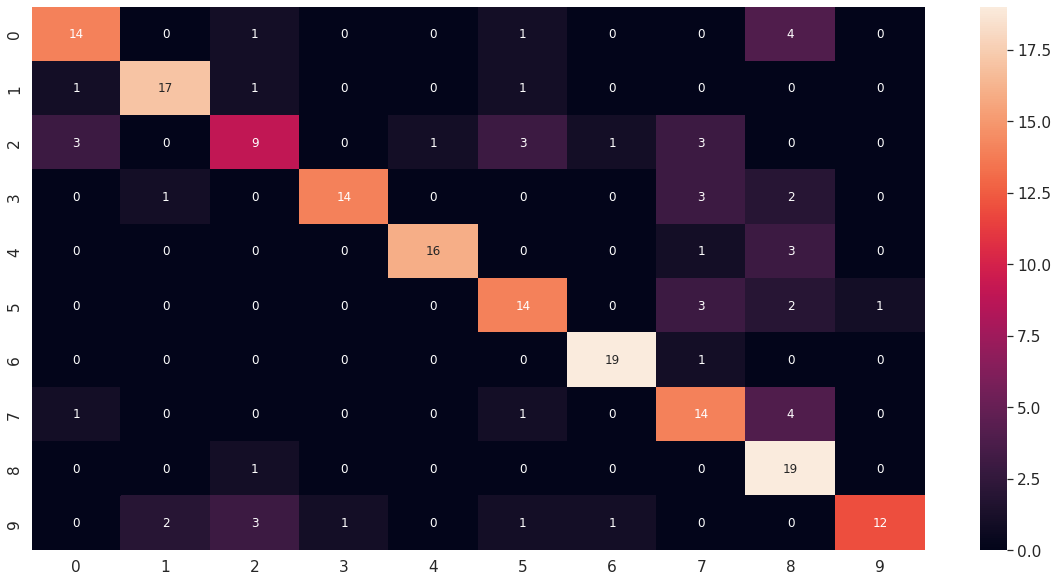

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof1_5_df_CM = pd.DataFrame(deepface_model_rof1_5_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof1_5_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof1_5_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof1_5_report)

              precision    recall  f1-score   support

           1       0.74      0.70      0.72        20
           2       0.85      0.85      0.85        20
           3       0.60      0.45      0.51        20
           4       0.93      0.70      0.80        20
           5       0.94      0.80      0.86        20
           6       0.67      0.70      0.68        20
           7       0.90      0.95      0.93        20
           8       0.56      0.70      0.62        20
           9       0.56      0.95      0.70        20
          10       0.92      0.60      0.73        20

    accuracy                           0.74       200
   macro avg       0.77      0.74      0.74       200
weighted avg       0.77      0.74      0.74       200

              precision    recall  f1-score   support

           1       0.74      0.70      0.72        20
           2       0.85      0.85      0.85        20
           3       0.60      0.45      0.51        20
           4       0.93 

#### Modelo 6: (BTH = 20, EHS = 20, ValidSplit = 0.2, INI = HeNormal, Dropout=0.2 REG = none, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof1_6 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof1_6.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
#reg = tf.keras.regularizers.L2()
deepface_model_rof1_6.add(Dropout(rate=0, name='D0'))
deepface_model_rof1_6.add(Dense(11, kernel_initializer=initializer, activation='softmax', name='Class'))
deepface_model_rof1_6.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_rof1_6.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_6.h5', monitor="val_loss", save_best_only=True)
hist_model_rof1_6 = deepface_model_rof1_6.fit(new_trainX, new_trainY, batch_size=20, epochs=20, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/20
40/40 [==============================] - 138s 1s/step - loss: 1.9644 - accuracy: 0.8012 - val_loss: 1.9322 - val_accuracy: 0.7200
Epoch 2/20
40/40 [==============================] - 9s 239ms/step - loss: 0.0203 - accuracy: 0.9925 - val_loss: 1.7842 - val_accuracy: 0.7400
Epoch 3/20
40/40 [==============================] - 5s 131ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.8653 - val_accuracy: 0.7200
Epoch 4/20
40/40 [==============================] - 6s 141ms/step - loss: 8.2916e-04 - accuracy: 1.0000 - val_loss: 1.8533 - val_accuracy: 0.7050
Epoch 5/20
40/40 [==============================] - 6s 140ms/step - loss: 5.8685e-04 - accuracy: 1.0000 - val_loss: 1.8664 - val_accuracy: 0.7050
Epoch 6/20
40/40 [==============================] - 5s 134ms/step - loss: 4.5405e-04 - accuracy: 1.0000 - val_loss: 1.8724 - val_accuracy: 0.7050
Epoch 7/20
40/40 [==============================] - 5s 130ms/step - loss: 3.7030e-04 - accuracy: 1.0000 - val_loss: 1.8809 - val_accuracy

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof1_6 = load_model(path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_6.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof1_6.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof1_6.evaluate(testX, testY)

7/7 [==============================] - 0s 66ms/step - loss: 3.2635 - accuracy: 0.5800


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof1_6.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof1_6_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

7/7 [==============================] - 32s 70ms/step


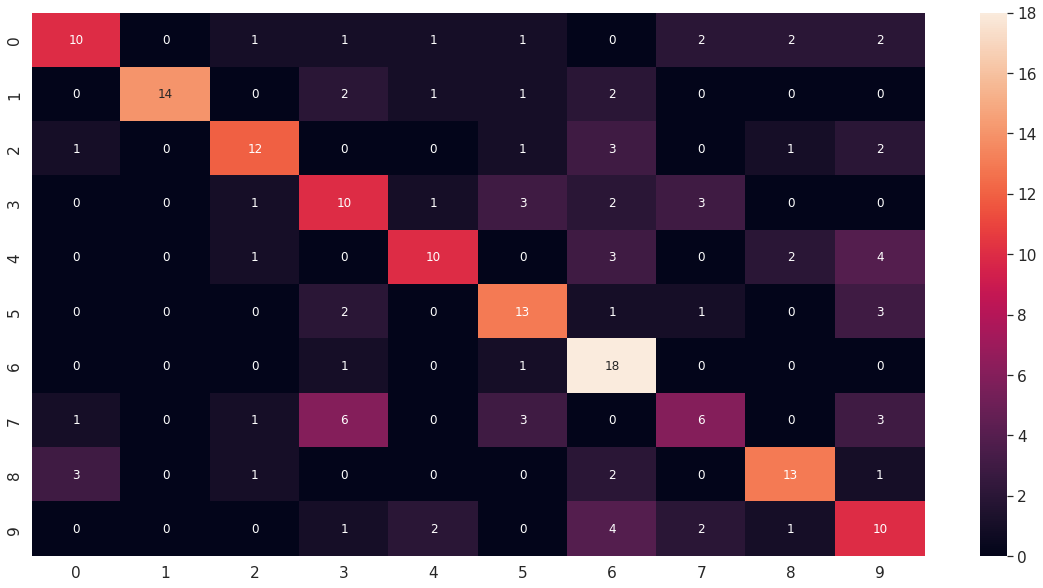

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof1_6_df_CM = pd.DataFrame(deepface_model_rof1_6_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof1_6_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof1_6_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof1_6_report)

              precision    recall  f1-score   support

           1       0.67      0.50      0.57        20
           2       1.00      0.70      0.82        20
           3       0.71      0.60      0.65        20
           4       0.43      0.50      0.47        20
           5       0.67      0.50      0.57        20
           6       0.57      0.65      0.60        20
           7       0.51      0.90      0.65        20
           8       0.43      0.30      0.35        20
           9       0.68      0.65      0.67        20
          10       0.40      0.50      0.44        20

    accuracy                           0.58       200
   macro avg       0.61      0.58      0.58       200
weighted avg       0.61      0.58      0.58       200



#### Modelo 7: (BTH = 30, EHS = 30, ValidSplit = 0.2, INI = none, Dropout=0 REG = L2, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof1_7 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof1_7.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof1_7.add(Dropout(rate=0, name='D0'))
deepface_model_rof1_7.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof1_7.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)  
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.001)
deepface_model_rof1_7.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_7.h5', monitor="val_loss", save_best_only=True)
hist_model_rof1_7 = deepface_model_rof1_7.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
27/27 [==============================] - 136s 2s/step - loss: 2.6637 - accuracy: 0.6100 - val_loss: 1.4474 - val_accuracy: 0.7500
Epoch 2/30
27/27 [==============================] - 9s 337ms/step - loss: 0.6413 - accuracy: 0.8813 - val_loss: 1.4098 - val_accuracy: 0.7500
Epoch 3/30
27/27 [==============================] - 4s 152ms/step - loss: 0.6915 - accuracy: 0.8975 - val_loss: 2.5864 - val_accuracy: 0.6050
Epoch 4/30
27/27 [==============================] - 4s 160ms/step - loss: 0.6210 - accuracy: 0.8963 - val_loss: 3.0266 - val_accuracy: 0.6500
Epoch 5/30
27/27 [==============================] - 4s 158ms/step - loss: 0.9629 - accuracy: 0.8700 - val_loss: 2.4851 - val_accuracy: 0.7300
Epoch 6/30
27/27 [==============================] - 4s 159ms/step - loss: 0.5630 - accuracy: 0.9162 - val_loss: 2.6881 - val_accuracy: 0.6900
Epoch 7/30
27/27 [==============================] - 4s 160ms/step - loss: 0.6439 - accuracy: 0.9175 - val_loss: 2.0666 - val_accuracy: 0.7300
Epoch 8

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof1_7 = load_model(path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_7.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof1_7.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof1_7.evaluate(testX, testY)

7/7 [==============================] - 0s 70ms/step - loss: 1.4797 - accuracy: 0.6250


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof1_7.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof1_7_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

7/7 [==============================] - 54s 69ms/step


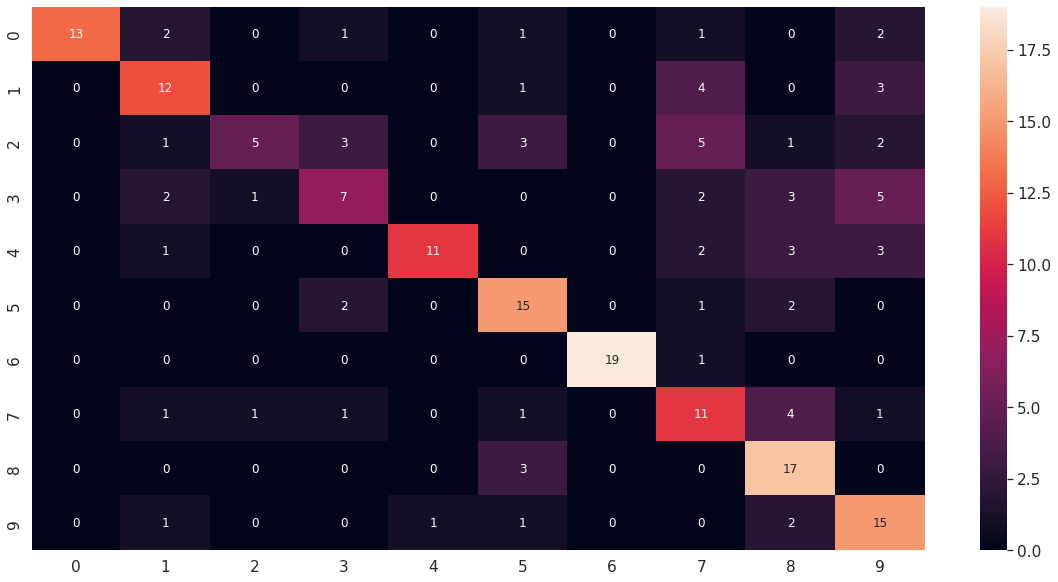

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof1_7_df_CM = pd.DataFrame(deepface_model_rof1_7_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof1_7_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof1_7_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof1_7_report)

              precision    recall  f1-score   support

           1       1.00      0.65      0.79        20
           2       0.60      0.60      0.60        20
           3       0.71      0.25      0.37        20
           4       0.50      0.35      0.41        20
           5       0.92      0.55      0.69        20
           6       0.60      0.75      0.67        20
           7       1.00      0.95      0.97        20
           8       0.41      0.55      0.47        20
           9       0.53      0.85      0.65        20
          10       0.48      0.75      0.59        20

    accuracy                           0.62       200
   macro avg       0.68      0.62      0.62       200
weighted avg       0.68      0.62      0.62       200



#### Modelo 8: (BTH = 30, EHS = 30, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = none, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof1_8 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof1_8.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
#reg = tf.keras.regularizers.L2()
deepface_model_rof1_8.add(Dropout(rate=0, name='D0'))
deepface_model_rof1_8.add(Dense(11, kernel_initializer=initializer, activation='softmax', name='Class'))
deepface_model_rof1_8.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)  
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_rof1_8.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_8.h5', monitor="val_loss", save_best_only=True)
hist_model_rof1_8 = deepface_model_rof1_8.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
27/27 [==============================] - 184s 2s/step - loss: 1.2240 - accuracy: 0.8363 - val_loss: 1.7976 - val_accuracy: 0.6800
Epoch 2/30
27/27 [==============================] - 9s 334ms/step - loss: 0.0268 - accuracy: 0.9937 - val_loss: 1.6114 - val_accuracy: 0.7100
Epoch 3/30
27/27 [==============================] - 4s 154ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.6229 - val_accuracy: 0.7150
Epoch 4/30
27/27 [==============================] - 4s 166ms/step - loss: 8.2910e-04 - accuracy: 1.0000 - val_loss: 1.6282 - val_accuracy: 0.7100
Epoch 5/30
27/27 [==============================] - 5s 177ms/step - loss: 5.9941e-04 - accuracy: 1.0000 - val_loss: 1.6320 - val_accuracy: 0.7100
Epoch 6/30
27/27 [==============================] - 4s 161ms/step - loss: 4.6985e-04 - accuracy: 1.0000 - val_loss: 1.6350 - val_accuracy: 0.7100
Epoch 7/30
27/27 [==============================] - 4s 152ms/step - loss: 3.9710e-04 - accuracy: 1.0000 - val_loss: 1.6409 - val_accuracy

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof1_8 = load_model(path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_8.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof1_8.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof1_8.evaluate(testX, testY)

7/7 [==============================] - 0s 64ms/step - loss: 5.2635 - accuracy: 0.6200


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof1_8.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof1_8_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

7/7 [==============================] - 55s 67ms/step


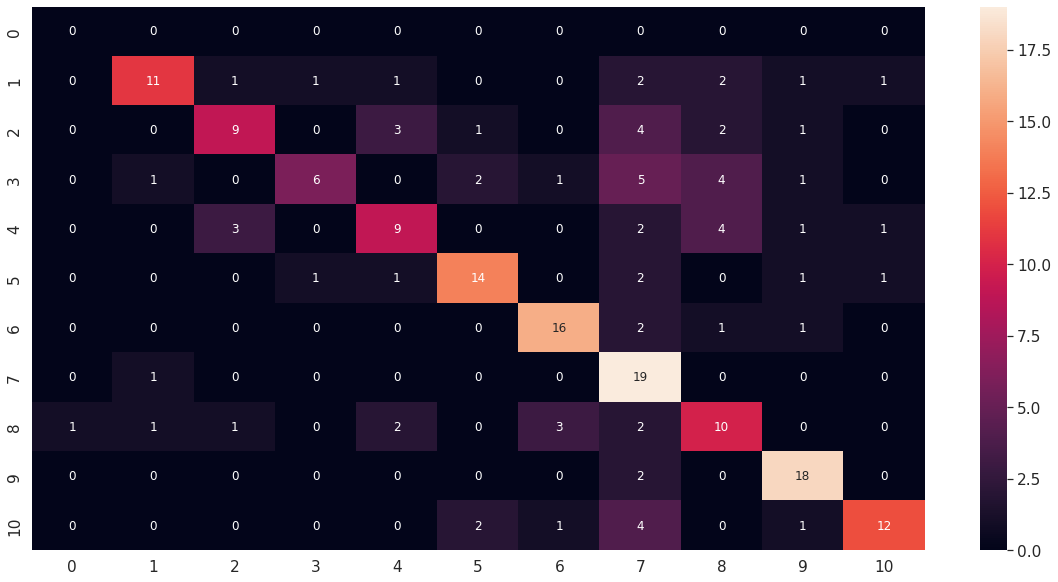

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof1_8_df_CM = pd.DataFrame(deepface_model_rof1_8_CM, range(11), range(11))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof1_8_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof1_8_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof1_8_report)

#### Modelo 9: (BTH = 30, EHS = 30, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof1_9 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof1_9.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof1_9.add(Dropout(rate=0, name='D0'))
deepface_model_rof1_9.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof1_9.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_rof1_9.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_9.h5', monitor="val_loss", save_best_only=True)
hist_model_rof1_9 = deepface_model_rof1_9.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
27/27 [==============================] - 151s 1s/step - loss: 1.1234 - accuracy: 0.9200 - val_loss: 8.4988 - val_accuracy: 0.7100
Epoch 2/30
27/27 [==============================] - 4s 146ms/step - loss: 0.2930 - accuracy: 0.9962 - val_loss: 9.4764 - val_accuracy: 0.6900
Epoch 3/30
27/27 [==============================] - 7s 266ms/step - loss: 0.2929 - accuracy: 0.9987 - val_loss: 7.8798 - val_accuracy: 0.7250
Epoch 4/30
27/27 [==============================] - 7s 264ms/step - loss: 0.2670 - accuracy: 1.0000 - val_loss: 7.8186 - val_accuracy: 0.7150
Epoch 5/30
27/27 [==============================] - 7s 273ms/step - loss: 0.2642 - accuracy: 1.0000 - val_loss: 7.7784 - val_accuracy: 0.7150
Epoch 6/30
27/27 [==============================] - 7s 272ms/step - loss: 0.2613 - accuracy: 1.0000 - val_loss: 7.7356 - val_accuracy: 0.7150
Epoch 7/30
27/27 [==============================] - 7s 268ms/step - loss: 0.2585 - accuracy: 1.0000 - val_loss: 7.6926 - val_accuracy: 0.7150
Epoch 8

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof1_9 = load_model(path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_9.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof1_9.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof1_9.evaluate(testX, testY)

7/7 [==============================] - 1s 70ms/step - loss: 36.7813 - accuracy: 0.5650


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof1_9.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof1_9_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

7/7 [==============================] - 36s 66ms/step


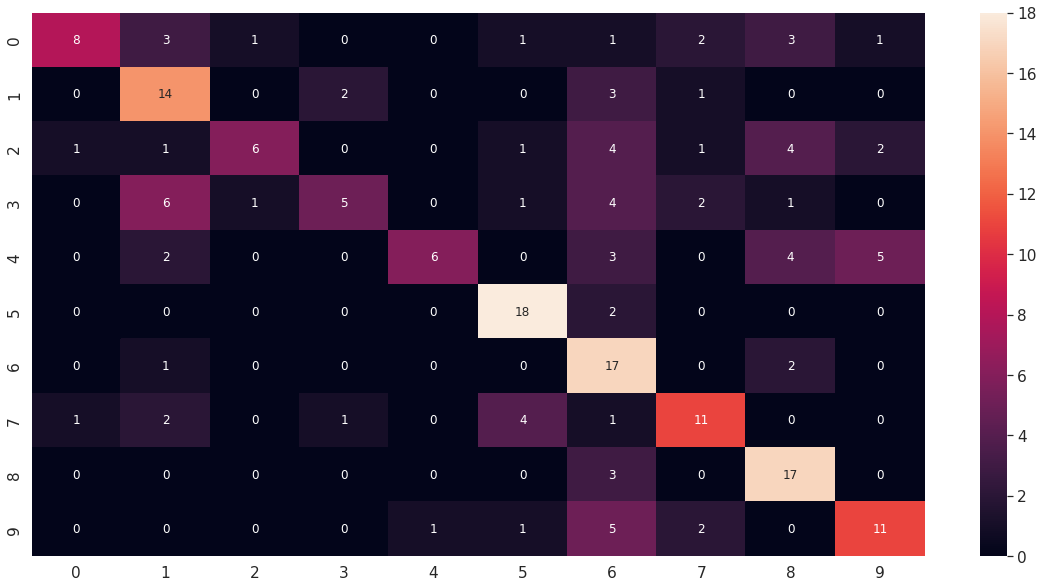

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof1_9_df_CM = pd.DataFrame(deepface_model_rof1_9_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof1_9_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof1_9_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof1_9_report)

              precision    recall  f1-score   support

           1       0.80      0.40      0.53        20
           2       0.48      0.70      0.57        20
           3       0.75      0.30      0.43        20
           4       0.62      0.25      0.36        20
           5       0.86      0.30      0.44        20
           6       0.69      0.90      0.78        20
           7       0.40      0.85      0.54        20
           8       0.58      0.55      0.56        20
           9       0.55      0.85      0.67        20
          10       0.58      0.55      0.56        20

    accuracy                           0.56       200
   macro avg       0.63      0.56      0.55       200
weighted avg       0.63      0.56      0.55       200



#### Modelo 10: (BTH = 20, EHS = 20, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof1_10 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof1_10.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof1_10.add(Dropout(rate=0, name='D0'))
deepface_model_rof1_10.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof1_10.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_rof1_10.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_10.h5', monitor="val_loss", save_best_only=True)
hist_model_rof1_10 = deepface_model_rof1_10.fit(new_trainX, new_trainY, batch_size=20, epochs=20, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/20
40/40 [==============================] - 142s 1s/step - loss: 0.9097 - accuracy: 0.9400 - val_loss: 6.1109 - val_accuracy: 0.7300
Epoch 2/20
40/40 [==============================] - 9s 222ms/step - loss: 0.3351 - accuracy: 0.9925 - val_loss: 5.1475 - val_accuracy: 0.7400
Epoch 3/20
40/40 [==============================] - 5s 128ms/step - loss: 0.2693 - accuracy: 0.9987 - val_loss: 5.5270 - val_accuracy: 0.7200
Epoch 4/20
40/40 [==============================] - 6s 138ms/step - loss: 0.2629 - accuracy: 0.9987 - val_loss: 5.5202 - val_accuracy: 0.7250
Epoch 5/20
40/40 [==============================] - 6s 141ms/step - loss: 0.2564 - accuracy: 1.0000 - val_loss: 5.4810 - val_accuracy: 0.7250
Epoch 6/20
40/40 [==============================] - 5s 128ms/step - loss: 0.2524 - accuracy: 1.0000 - val_loss: 5.4356 - val_accuracy: 0.7250
Epoch 7/20
40/40 [==============================] - 5s 128ms/step - loss: 0.2483 - accuracy: 1.0000 - val_loss: 5.3905 - val_accuracy: 0.7250
Epoch 8

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof1_10 = load_model(path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_10.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof1_10.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof1_10.evaluate(testX, testY)

7/7 [==============================] - 0s 67ms/step - loss: 28.4565 - accuracy: 0.4750


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof1_10.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof1_10_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

7/7 [==============================] - 34s 69ms/step


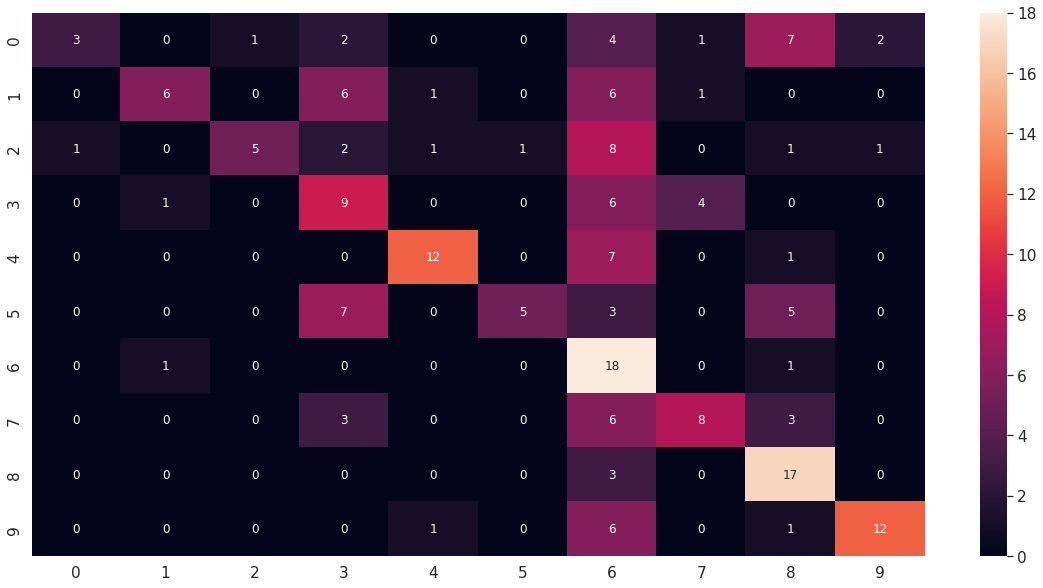

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof1_10_df_CM = pd.DataFrame(deepface_model_rof1_10_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof1_10_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof1_10_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof1_10_report)

              precision    recall  f1-score   support

           1       0.75      0.15      0.25        20
           2       0.75      0.30      0.43        20
           3       0.83      0.25      0.38        20
           4       0.31      0.45      0.37        20
           5       0.80      0.60      0.69        20
           6       0.83      0.25      0.38        20
           7       0.27      0.90      0.41        20
           8       0.57      0.40      0.47        20
           9       0.47      0.85      0.61        20
          10       0.80      0.60      0.69        20

    accuracy                           0.48       200
   macro avg       0.64      0.47      0.47       200
weighted avg       0.64      0.47      0.47       200



#### Modelo 11: (BTH = 40, EHS = 30, ValidSplit = 0.2, INI = HeNormal, Dropout=0.2 REG = L2 none, OPT = adam[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof1_11 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof1_11.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof1_11.add(Dropout(rate=0, name='D0'))
deepface_model_rof1_11.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof1_11.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.001)
deepface_model_rof1_11.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_11.h5', monitor="val_loss", save_best_only=True)
hist_model_rof1_11 = deepface_model_rof1_11.fit(new_trainX, new_trainY, batch_size=40, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
20/20 [==============================] - 142s 2s/step - loss: 4.4856 - accuracy: 0.3487 - val_loss: 1.7397 - val_accuracy: 0.5700
Epoch 2/30
20/20 [==============================] - 8s 396ms/step - loss: 0.8082 - accuracy: 0.8225 - val_loss: 1.5644 - val_accuracy: 0.6700
Epoch 3/30
20/20 [==============================] - 3s 170ms/step - loss: 0.3547 - accuracy: 0.9413 - val_loss: 2.2495 - val_accuracy: 0.6350
Epoch 4/30
20/20 [==============================] - 3s 169ms/step - loss: 0.4272 - accuracy: 0.9325 - val_loss: 2.0677 - val_accuracy: 0.6250
Epoch 5/30
20/20 [==============================] - 3s 172ms/step - loss: 0.4136 - accuracy: 0.9300 - val_loss: 2.5933 - val_accuracy: 0.6150
Epoch 6/30
20/20 [==============================] - 3s 175ms/step - loss: 0.5347 - accuracy: 0.9000 - val_loss: 2.5297 - val_accuracy: 0.5950
Epoch 7/30
20/20 [==============================] - 4s 179ms/step - loss: 0.8014 - accuracy: 0.8963 - val_loss: 2.2605 - val_accuracy: 0.6300
Epoch 8

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof1_11 = load_model(path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_11.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof1_11.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof1_11.evaluate(testX, testY)

7/7 [==============================] - 1s 70ms/step - loss: 2.8935 - accuracy: 0.4500


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof1_11.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof1_11_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

7/7 [==============================] - 51s 71ms/step


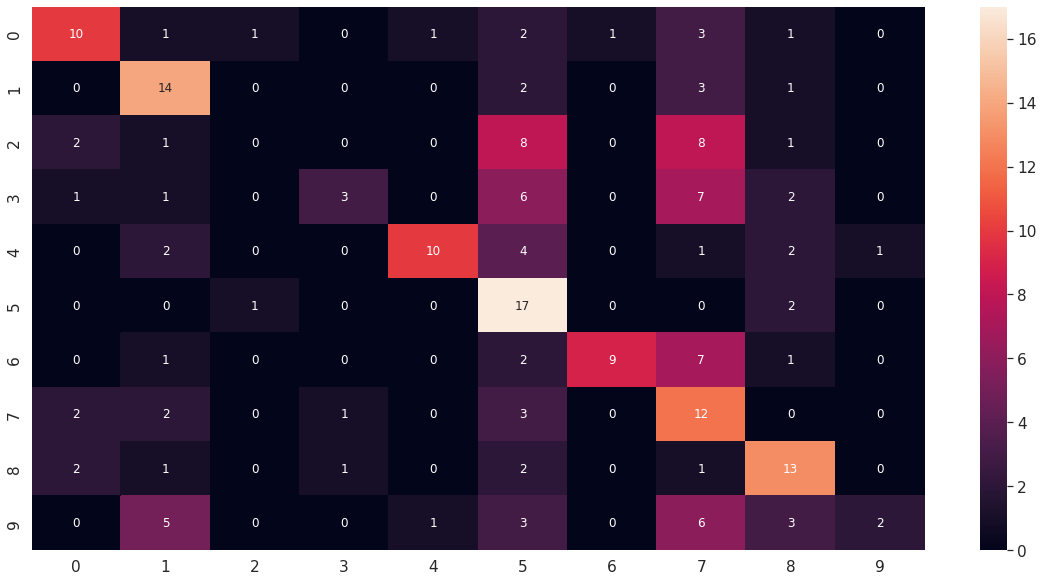

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof1_11_df_CM = pd.DataFrame(deepface_model_rof1_11_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof1_11_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof1_11_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof1_11_report)

              precision    recall  f1-score   support

           1       0.59      0.50      0.54        20
           2       0.50      0.70      0.58        20
           3       0.00      0.00      0.00        20
           4       0.60      0.15      0.24        20
           5       0.83      0.50      0.62        20
           6       0.35      0.85      0.49        20
           7       0.90      0.45      0.60        20
           8       0.25      0.60      0.35        20
           9       0.50      0.65      0.57        20
          10       0.67      0.10      0.17        20

    accuracy                           0.45       200
   macro avg       0.52      0.45      0.42       200
weighted avg       0.52      0.45      0.42       200



#### Modelo 12: (BTH = 20, EHS = 20, ValidSplit = 0.2, INI = HeNormal, Dropout=0.5 REG = L2 none, OPT = adam[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof1_12 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof1_12.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof1_12.add(Dropout(rate=0.5, name='D0'))
deepface_model_rof1_12.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof1_12.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.001)
deepface_model_rof1_12.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_12.h5', monitor="val_loss", save_best_only=True)
hist_model_rof1_12 = deepface_model_rof1_12.fit(new_trainX, new_trainY, batch_size=20, epochs=20, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/20
40/40 [==============================] - 139s 1s/step - loss: 2.3497 - accuracy: 0.7825 - val_loss: 3.1567 - val_accuracy: 0.6900
Epoch 2/20
40/40 [==============================] - 5s 131ms/step - loss: 0.3876 - accuracy: 0.9350 - val_loss: 3.3884 - val_accuracy: 0.7100
Epoch 3/20
40/40 [==============================] - 5s 135ms/step - loss: 0.3862 - accuracy: 0.9563 - val_loss: 5.1827 - val_accuracy: 0.6600
Epoch 4/20
40/40 [==============================] - 5s 136ms/step - loss: 0.5402 - accuracy: 0.9513 - val_loss: 6.8245 - val_accuracy: 0.6850
Epoch 5/20
40/40 [==============================] - 5s 134ms/step - loss: 1.4521 - accuracy: 0.9038 - val_loss: 8.3567 - val_accuracy: 0.6300
Epoch 6/20
40/40 [==============================] - 5s 134ms/step - loss: 1.2765 - accuracy: 0.9162 - val_loss: 15.8237 - val_accuracy: 0.6200
Epoch 7/20
40/40 [==============================] - 5s 134ms/step - loss: 1.8617 - accuracy: 0.9200 - val_loss: 17.4743 - val_accuracy: 0.5950
Epoch

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof1_12 = load_model(path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_12.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof1_12.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof1_12.evaluate(testX, testY)

7/7 [==============================] - 0s 65ms/step - loss: 8.7393 - accuracy: 0.5300


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof1_12.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof1_12_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

7/7 [==============================] - 32s 70ms/step


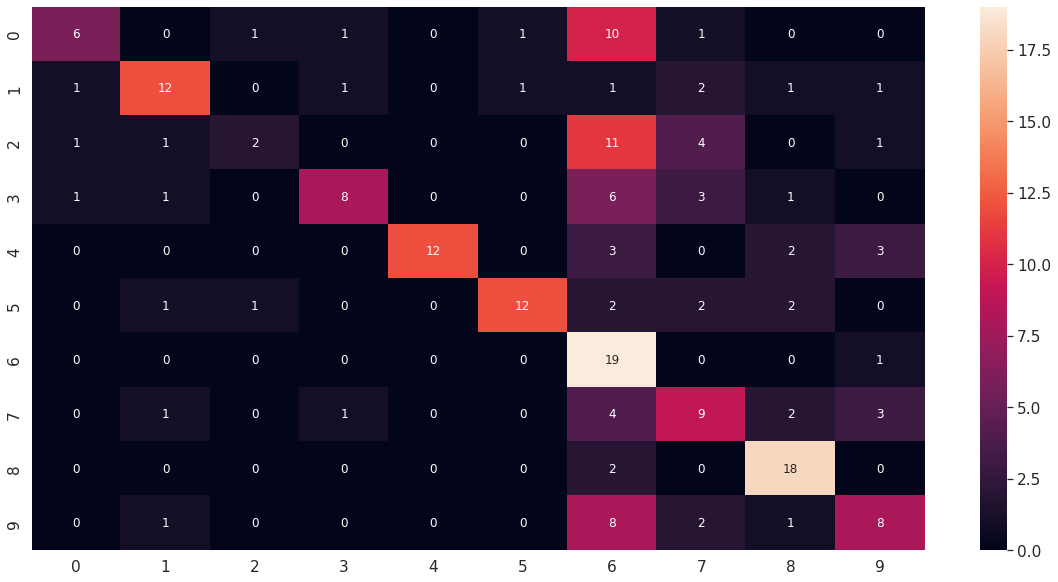

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof1_12_df_CM = pd.DataFrame(deepface_model_rof1_12_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof1_12_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof1_12_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof1_12_report)

              precision    recall  f1-score   support

           1       0.67      0.30      0.41        20
           2       0.71      0.60      0.65        20
           3       0.50      0.10      0.17        20
           4       0.73      0.40      0.52        20
           5       1.00      0.60      0.75        20
           6       0.86      0.60      0.71        20
           7       0.29      0.95      0.44        20
           8       0.39      0.45      0.42        20
           9       0.67      0.90      0.77        20
          10       0.47      0.40      0.43        20

    accuracy                           0.53       200
   macro avg       0.63      0.53      0.53       200
weighted avg       0.63      0.53      0.53       200



#### Modelo 13: (BTH = 40, EHS = 30, ValidSplit = 0.2, INI = HeNormal, Dropout=0, REG = L2, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof1_13 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof1_13.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof1_13.add(Dropout(rate=0, name='D0'))
deepface_model_rof1_13.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof1_13.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_rof1_13.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_13.h5', monitor="val_loss", save_best_only=True)
hist_model_rof1_13 = deepface_model_rof1_13.fit(new_trainX, new_trainY, batch_size=40, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
20/20 [==============================] - 135s 2s/step - loss: 6.9043 - accuracy: 0.8163 - val_loss: 7.3680 - val_accuracy: 0.7050
Epoch 2/30
20/20 [==============================] - 3s 173ms/step - loss: 0.0728 - accuracy: 0.9987 - val_loss: 7.5368 - val_accuracy: 0.7000
Epoch 3/30
20/20 [==============================] - 3s 175ms/step - loss: 0.0530 - accuracy: 1.0000 - val_loss: 7.5854 - val_accuracy: 0.7000
Epoch 4/30
20/20 [==============================] - 4s 176ms/step - loss: 0.0493 - accuracy: 1.0000 - val_loss: 7.5901 - val_accuracy: 0.7000
Epoch 5/30
20/20 [==============================] - 3s 175ms/step - loss: 0.0483 - accuracy: 1.0000 - val_loss: 7.5890 - val_accuracy: 0.7000
Epoch 6/30
20/20 [==============================] - 3s 174ms/step - loss: 0.0479 - accuracy: 1.0000 - val_loss: 7.5871 - val_accuracy: 0.7000
Epoch 7/30
20/20 [==============================] - 4s 176ms/step - loss: 0.0476 - accuracy: 1.0000 - val_loss: 7.5850 - val_accuracy: 0.7000
Epoch 8

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof1_13 = load_model(path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_13.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof1_13.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof1_13.evaluate(testX, testY)

7/7 [==============================] - 0s 64ms/step - loss: 11.0370 - accuracy: 0.5900


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof1_13.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof1_13_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

7/7 [==============================] - 51s 71ms/step


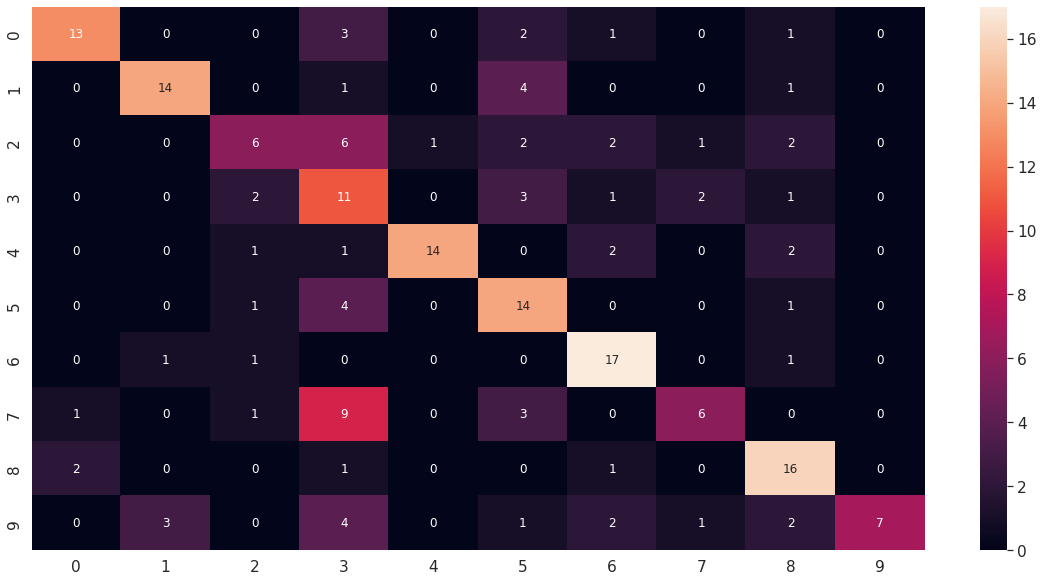

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof1_13_df_CM = pd.DataFrame(deepface_model_rof1_13_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof1_13_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof1_13_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof1_13_report)

              precision    recall  f1-score   support

           1       0.81      0.65      0.72        20
           2       0.78      0.70      0.74        20
           3       0.50      0.30      0.37        20
           4       0.28      0.55      0.37        20
           5       0.93      0.70      0.80        20
           6       0.48      0.70      0.57        20
           7       0.65      0.85      0.74        20
           8       0.60      0.30      0.40        20
           9       0.59      0.80      0.68        20
          10       1.00      0.35      0.52        20

    accuracy                           0.59       200
   macro avg       0.66      0.59      0.59       200
weighted avg       0.66      0.59      0.59       200



#### Modelo 14: (BTH = 10, EHS = 30, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof1_14 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof1_14.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof1_14.add(Dropout(rate=0, name='D0'))
deepface_model_rof1_14.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof1_14.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_rof1_14.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_14.h5', monitor="val_loss", save_best_only=True)
hist_model_rof1_14 = deepface_model_rof1_14.fit(new_trainX, new_trainY, batch_size=10, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
80/80 [==============================] - 149s 617ms/step - loss: 10.6206 - accuracy: 0.8800 - val_loss: 63.1325 - val_accuracy: 0.5350
Epoch 2/30
80/80 [==============================] - 14s 170ms/step - loss: 10.9501 - accuracy: 0.9013 - val_loss: 48.4456 - val_accuracy: 0.6600
Epoch 3/30
80/80 [==============================] - 9s 113ms/step - loss: 15.0970 - accuracy: 0.9075 - val_loss: 183.4887 - val_accuracy: 0.4700
Epoch 4/30
80/80 [==============================] - 9s 116ms/step - loss: 103.8986 - accuracy: 0.8037 - val_loss: 894.1603 - val_accuracy: 0.3200
Epoch 5/30
80/80 [==============================] - 9s 114ms/step - loss: nan - accuracy: 0.1562 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/30
80/80 [==============================] - 9s 109ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 7/30
80/80 [==============================] - 9s 115ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof1_14 = load_model(path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_14.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof1_14.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof1_14.evaluate(testX, testY)

7/7 [==============================] - 0s 64ms/step - loss: 68.4361 - accuracy: 0.5300


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof1_14.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof1_14_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

7/7 [==============================] - 38s 65ms/step


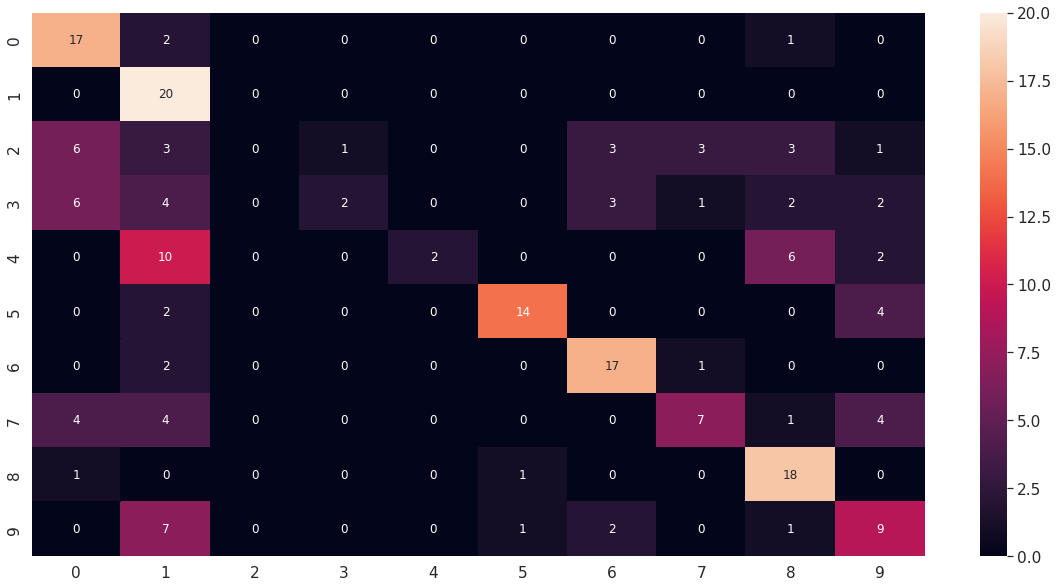

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof1_14_df_CM = pd.DataFrame(deepface_model_rof1_14_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof1_14_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof1_14_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof1_14_report)

              precision    recall  f1-score   support

           1       0.50      0.85      0.63        20
           2       0.37      1.00      0.54        20
           3       0.00      0.00      0.00        20
           4       0.67      0.10      0.17        20
           5       1.00      0.10      0.18        20
           6       0.88      0.70      0.78        20
           7       0.68      0.85      0.76        20
           8       0.58      0.35      0.44        20
           9       0.56      0.90      0.69        20
          10       0.41      0.45      0.43        20

    accuracy                           0.53       200
   macro avg       0.56      0.53      0.46       200
weighted avg       0.56      0.53      0.46       200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Modelo 15: (BTH = 40, EHS = 30, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof1_15 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof1_15.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof1_15.add(Dropout(rate=0, name='D0'))
deepface_model_rof1_15.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof1_15.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_rof1_15.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_15.h5', monitor="val_loss", save_best_only=True)
hist_model_rof1_15 = deepface_model_rof1_15.fit(new_trainX, new_trainY, batch_size=40, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30


ResourceExhaustedError: ignored

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof1_15 = load_model(path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_15.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof1_15.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof1_15.evaluate(testX, testY)

In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof1_15.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof1_15_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof1_15_df_CM = pd.DataFrame(deepface_model_rof1_15_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof1_15_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof1_15_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof1_15_report)

#### Modelo 16: (BTH = 20, EHS = 40, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof1_16 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof1_16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof1_16.add(Dropout(rate=0, name='D0'))
deepface_model_rof1_16.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof1_16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_rof1_16.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_16.h5', monitor="val_loss", save_best_only=True)
hist_model_rof1_16 = deepface_model_rof1_16.fit(new_trainX, new_trainY, batch_size=20, epochs=40, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/40
40/40 [==============================] - 144s 1s/step - loss: 2.7859 - accuracy: 0.4988 - val_loss: 1.2343 - val_accuracy: 0.6650
Epoch 2/40
40/40 [==============================] - 9s 239ms/step - loss: 0.2728 - accuracy: 0.9762 - val_loss: 1.0308 - val_accuracy: 0.7250
Epoch 3/40
40/40 [==============================] - 9s 237ms/step - loss: 0.1750 - accuracy: 0.9987 - val_loss: 0.9894 - val_accuracy: 0.7700
Epoch 4/40
40/40 [==============================] - 9s 238ms/step - loss: 0.1637 - accuracy: 1.0000 - val_loss: 0.9552 - val_accuracy: 0.7650
Epoch 5/40
40/40 [==============================] - 9s 238ms/step - loss: 0.1597 - accuracy: 1.0000 - val_loss: 0.9460 - val_accuracy: 0.7700
Epoch 6/40
40/40 [==============================] - 9s 238ms/step - loss: 0.1564 - accuracy: 1.0000 - val_loss: 0.9405 - val_accuracy: 0.7650
Epoch 7/40
40/40 [==============================] - 9s 234ms/step - loss: 0.1534 - accuracy: 1.0000 - val_loss: 0.9374 - val_accuracy: 0.7700
Epoch 8

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof1_16 = load_model(path + 'data_reconocimiento2/models_ROF1/deepface_model_ROF1_16.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof1_16.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof1_16.evaluate(testX, testY)

7/7 [==============================] - 0s 64ms/step - loss: 1.9347 - accuracy: 0.6050


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof1_16.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof1_16_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

7/7 [==============================] - 33s 70ms/step


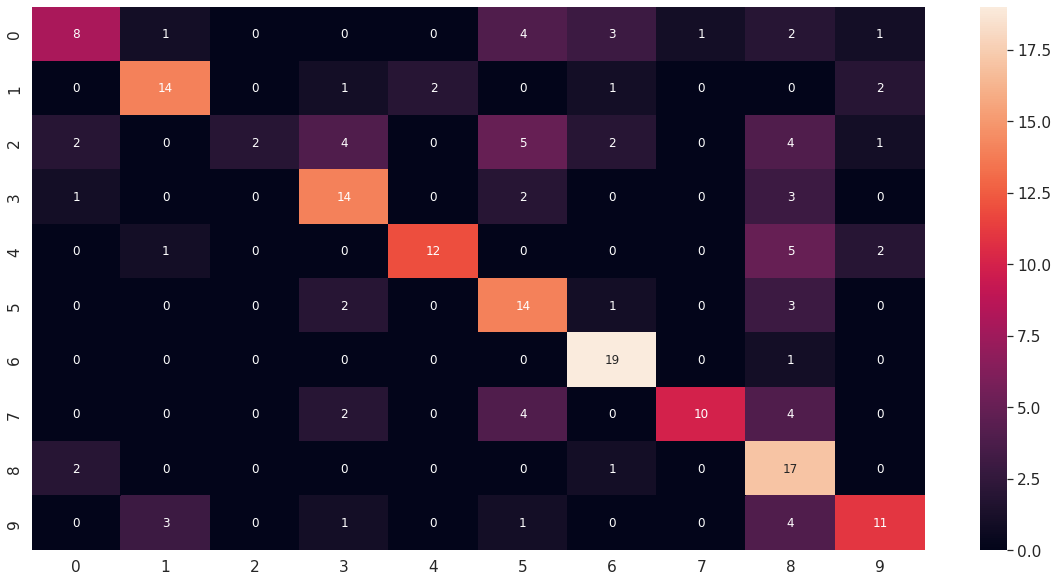

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof1_16_df_CM = pd.DataFrame(deepface_model_rof1_16_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof1_16_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof1_16_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof1_16_report)

              precision    recall  f1-score   support

           1       0.62      0.40      0.48        20
           2       0.74      0.70      0.72        20
           3       1.00      0.10      0.18        20
           4       0.58      0.70      0.64        20
           5       0.86      0.60      0.71        20
           6       0.47      0.70      0.56        20
           7       0.70      0.95      0.81        20
           8       0.91      0.50      0.65        20
           9       0.40      0.85      0.54        20
          10       0.65      0.55      0.59        20

    accuracy                           0.60       200
   macro avg       0.69      0.60      0.59       200
weighted avg       0.69      0.60      0.59       200



## 6. Modelos con base de datos ROF2 para condiciones de oclusión

#### Modelo 1: (BTH = 30, EHS = 30, ValidSplit = 0.2, Dropout=0, INI = HeNormal, REG = L2, OPT = adam[0.001])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof2_1 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof2_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final dropout y softmax de 11 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof2_1.add(Dropout(rate=0., name='D0'))
deepface_model_rof2_1.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof2_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)    
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.001)
deepface_model_rof2_1.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_1.h5', monitor="val_loss", save_best_only=True)
hist_model_rof2_1 = deepface_model_rof2_1.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
43/43 [==============================] - 149s 1s/step - loss: 2.9953 - accuracy: 0.4281 - val_loss: 1.6540 - val_accuracy: 0.5981
Epoch 2/30
43/43 [==============================] - 7s 156ms/step - loss: 0.7418 - accuracy: 0.8188 - val_loss: 1.9381 - val_accuracy: 0.6231
Epoch 3/30
43/43 [==============================] - 7s 170ms/step - loss: 0.7015 - accuracy: 0.8531 - val_loss: 1.9761 - val_accuracy: 0.7103
Epoch 4/30
43/43 [==============================] - 7s 156ms/step - loss: 0.6425 - accuracy: 0.8727 - val_loss: 2.3408 - val_accuracy: 0.6667
Epoch 5/30
43/43 [==============================] - 7s 152ms/step - loss: 0.8339 - accuracy: 0.8594 - val_loss: 1.6680 - val_accuracy: 0.7414
Epoch 6/30
43/43 [==============================] - 7s 154ms/step - loss: 0.5930 - accuracy: 0.9047 - val_loss: 1.6846 - val_accuracy: 0.7383
Epoch 7/30
43/43 [==============================] - 7s 152ms/step - loss: 0.6390 - accuracy: 0.8984 - val_loss: 1.6903 - val_accuracy: 0.7290
Epoch 8

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof2_1 = load_model(path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_1.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof2_1.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof2_1.evaluate(testX, testY)

7/7 [==============================] - 1s 85ms/step - loss: 2.1022 - accuracy: 0.4200


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof2_1.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof2_1_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

7/7 [==============================] - 34s 73ms/step


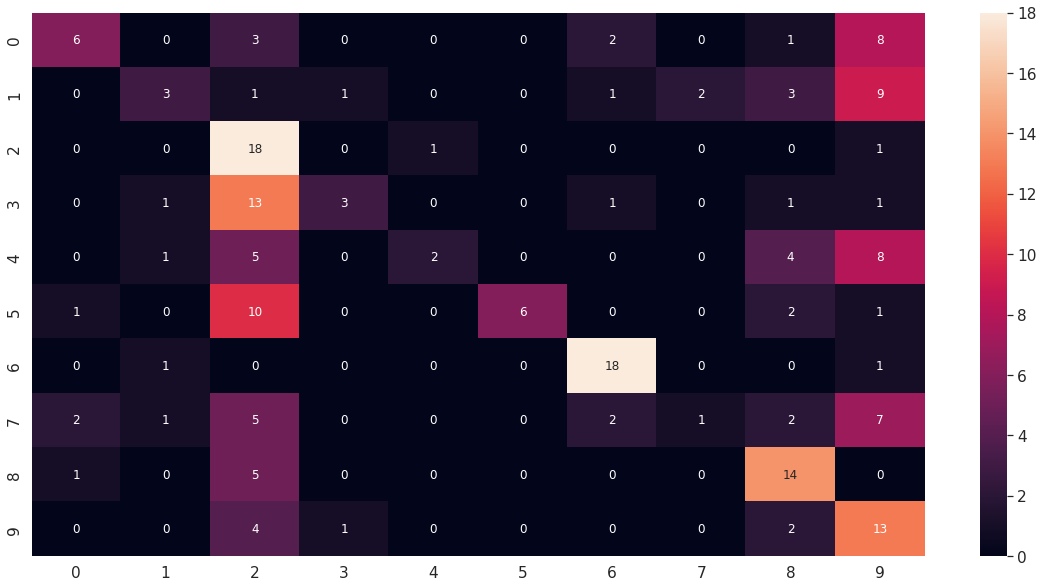

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof2_1_df_CM = pd.DataFrame(deepface_model_rof2_1_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof2_1_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof2_1_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof2_1_report)

              precision    recall  f1-score   support

           1       0.60      0.30      0.40        20
           2       0.43      0.15      0.22        20
           3       0.28      0.90      0.43        20
           4       0.60      0.15      0.24        20
           5       0.67      0.10      0.17        20
           6       1.00      0.30      0.46        20
           7       0.75      0.90      0.82        20
           8       0.33      0.05      0.09        20
           9       0.48      0.70      0.57        20
          10       0.27      0.65      0.38        20

    accuracy                           0.42       200
   macro avg       0.54      0.42      0.38       200
weighted avg       0.54      0.42      0.38       200



#### Modelo 2: (BTH = 30, EHS = 30, ValidSplit = 0.2, Dropout=0.5, INI = HeNormal, REG = L2, OPT = adam[0.001])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof2_2 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof2_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final dropout y softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof2_2.add(Dropout(rate=0.5, name='D0'))
deepface_model_rof2_2.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof2_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)    
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.001)
deepface_model_rof2_2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_2.h5', monitor="val_loss", save_best_only=True)
hist_model_rof2_2 = deepface_model_rof2_2.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
43/43 [==============================] - 147s 1s/step - loss: 5.3237 - accuracy: 0.7117 - val_loss: 2.0707 - val_accuracy: 0.7726
Epoch 2/30
43/43 [==============================] - 11s 256ms/step - loss: 0.2941 - accuracy: 0.9492 - val_loss: 1.6541 - val_accuracy: 0.7788
Epoch 3/30
43/43 [==============================] - 7s 164ms/step - loss: 0.1534 - accuracy: 0.9695 - val_loss: 2.0552 - val_accuracy: 0.7975
Epoch 4/30
43/43 [==============================] - 7s 163ms/step - loss: 0.1493 - accuracy: 0.9789 - val_loss: 2.2675 - val_accuracy: 0.7757
Epoch 5/30
43/43 [==============================] - 7s 162ms/step - loss: 0.0962 - accuracy: 0.9891 - val_loss: 2.1249 - val_accuracy: 0.8162
Epoch 6/30
43/43 [==============================] - 7s 156ms/step - loss: 0.1229 - accuracy: 0.9805 - val_loss: 3.0538 - val_accuracy: 0.7757
Epoch 7/30
43/43 [==============================] - 7s 154ms/step - loss: 0.3133 - accuracy: 0.9680 - val_loss: 3.3995 - val_accuracy: 0.7664
Epoch 

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof2_2 = load_model(path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_2.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof2_2.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof2_2.evaluate(testX, testY)

7/7 [==============================] - 0s 67ms/step - loss: 1.0488 - accuracy: 0.7650


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof2_2.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof2_2_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

7/7 [==============================] - 35s 68ms/step


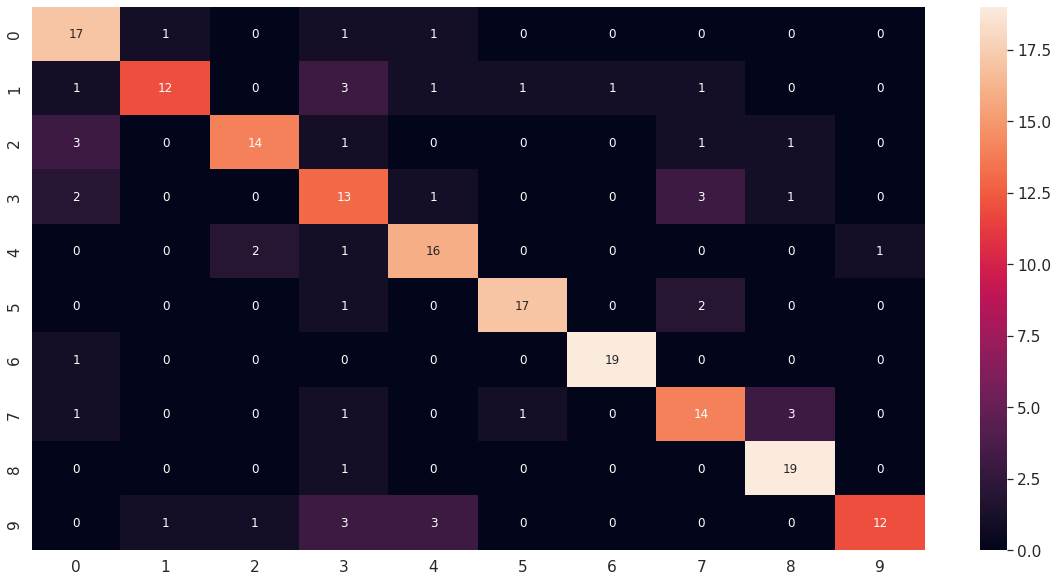

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof2_2_df_CM = pd.DataFrame(deepface_model_rof2_2_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof2_2_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof2_2_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof2_2_report)

              precision    recall  f1-score   support

           1       0.68      0.85      0.76        20
           2       0.86      0.60      0.71        20
           3       0.82      0.70      0.76        20
           4       0.52      0.65      0.58        20
           5       0.73      0.80      0.76        20
           6       0.89      0.85      0.87        20
           7       0.95      0.95      0.95        20
           8       0.67      0.70      0.68        20
           9       0.79      0.95      0.86        20
          10       0.92      0.60      0.73        20

    accuracy                           0.77       200
   macro avg       0.78      0.76      0.77       200
weighted avg       0.78      0.77      0.77       200



#### Modelo 3: (BTH = 10, EHS = 100, ValidSplit = 0.2, Dropout=0, INI = HeNormal, REG = L2, OPT = adamax[0.001])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof2_3 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof2_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final dropout y softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof2_3.add(Dropout(rate=0, name='D0'))
deepface_model_rof2_3.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof2_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)    
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_rof2_3.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_3.h5', monitor="val_loss", save_best_only=True)
hist_model_rof2_3 = deepface_model_rof2_3.fit(new_trainX, new_trainY, batch_size=10, epochs=100, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/100
128/128 [==============================] - 147s 392ms/step - loss: 2.5466 - accuracy: 0.7320 - val_loss: 0.9788 - val_accuracy: 0.7695
Epoch 2/100
128/128 [==============================] - 19s 151ms/step - loss: 0.1160 - accuracy: 0.9961 - val_loss: 0.8011 - val_accuracy: 0.8069
Epoch 3/100
128/128 [==============================] - 19s 150ms/step - loss: 0.0893 - accuracy: 1.0000 - val_loss: 0.7769 - val_accuracy: 0.8069
Epoch 4/100
128/128 [==============================] - 15s 114ms/step - loss: 0.0864 - accuracy: 1.0000 - val_loss: 0.7827 - val_accuracy: 0.8193
Epoch 5/100
128/128 [==============================] - 15s 115ms/step - loss: 0.0845 - accuracy: 1.0000 - val_loss: 0.8110 - val_accuracy: 0.8224
Epoch 6/100
128/128 [==============================] - 14s 112ms/step - loss: 0.0828 - accuracy: 1.0000 - val_loss: 0.8956 - val_accuracy: 0.8255
Epoch 7/100
128/128 [==============================] - 14s 109ms/step - loss: 0.0812 - accuracy: 1.0000 - val_loss: 0.9594 

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof2_3 = load_model(path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_3.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof2_3.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof2_3.evaluate(testX, testY)

7/7 [==============================] - 0s 62ms/step - loss: 1.1995 - accuracy: 0.6800


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof2_3.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof2_3_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

7/7 [==============================] - 32s 64ms/step


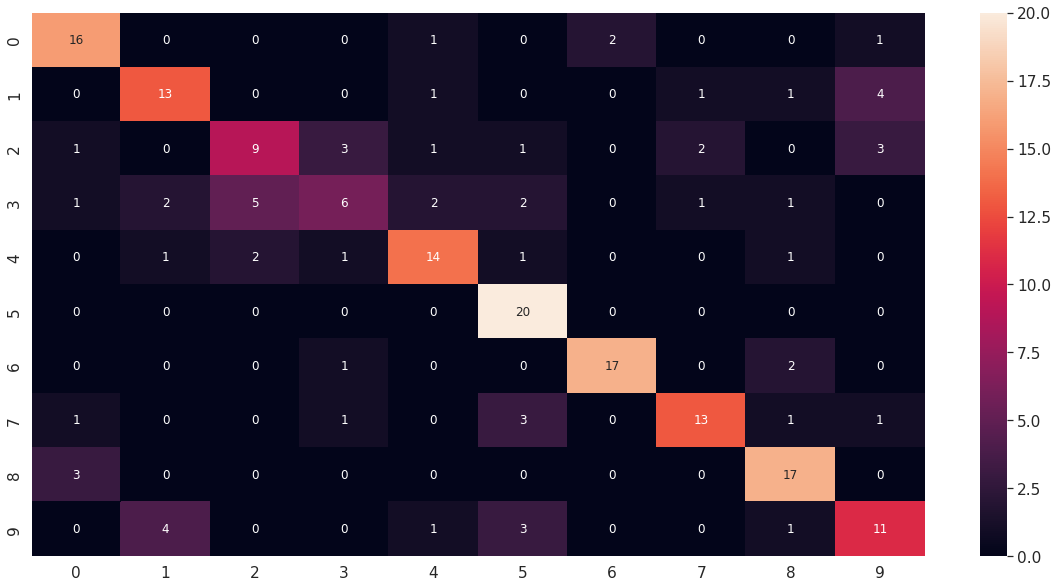

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof2_3_df_CM = pd.DataFrame(deepface_model_rof2_3_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof2_3_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof2_3_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof2_3_report)

              precision    recall  f1-score   support

           1       0.73      0.80      0.76        20
           2       0.65      0.65      0.65        20
           3       0.56      0.45      0.50        20
           4       0.50      0.30      0.37        20
           5       0.70      0.70      0.70        20
           6       0.67      1.00      0.80        20
           7       0.89      0.85      0.87        20
           8       0.76      0.65      0.70        20
           9       0.71      0.85      0.77        20
          10       0.55      0.55      0.55        20

    accuracy                           0.68       200
   macro avg       0.67      0.68      0.67       200
weighted avg       0.67      0.68      0.67       200



#### Modelo 4: (BTH = 10, EHS = 30, ValidSplit = 0.2, INI = HeNormal, Dropout=0.5 REG = L2, OPT = adam[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof2_4 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof2_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof2_4.add(Dropout(rate=0.5, name='D0'))
deepface_model_rof2_4.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof2_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.001)
deepface_model_rof2_4.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_4.h5', monitor="val_loss", save_best_only=True)
hist_model_rof2_4 = deepface_model_rof2_4.fit(new_trainX, new_trainY, batch_size=10, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
128/128 [==============================] - 158s 419ms/step - loss: 15.5206 - accuracy: 0.7633 - val_loss: 4.9398 - val_accuracy: 0.7072
Epoch 2/30
128/128 [==============================] - 20s 154ms/step - loss: 1.0763 - accuracy: 0.8805 - val_loss: 3.2953 - val_accuracy: 0.7227
Epoch 3/30
128/128 [==============================] - 16s 121ms/step - loss: 0.7550 - accuracy: 0.9117 - val_loss: 5.2808 - val_accuracy: 0.7383
Epoch 4/30
128/128 [==============================] - 15s 115ms/step - loss: 0.7207 - accuracy: 0.9273 - val_loss: 4.9294 - val_accuracy: 0.7290
Epoch 5/30
128/128 [==============================] - 14s 112ms/step - loss: 1.3497 - accuracy: 0.8789 - val_loss: 3.3895 - val_accuracy: 0.7290
Epoch 6/30
128/128 [==============================] - 24s 187ms/step - loss: 0.8142 - accuracy: 0.8695 - val_loss: 3.1155 - val_accuracy: 0.7259
Epoch 7/30
128/128 [==============================] - 15s 120ms/step - loss: 1.0040 - accuracy: 0.8867 - val_loss: 4.5000 - val_

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof2_4 = load_model(path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_4.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof2_4.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof2_4.evaluate(testX, testY)

7/7 [==============================] - 0s 66ms/step - loss: 1.9549 - accuracy: 0.5650


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof2_4.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof2_4_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

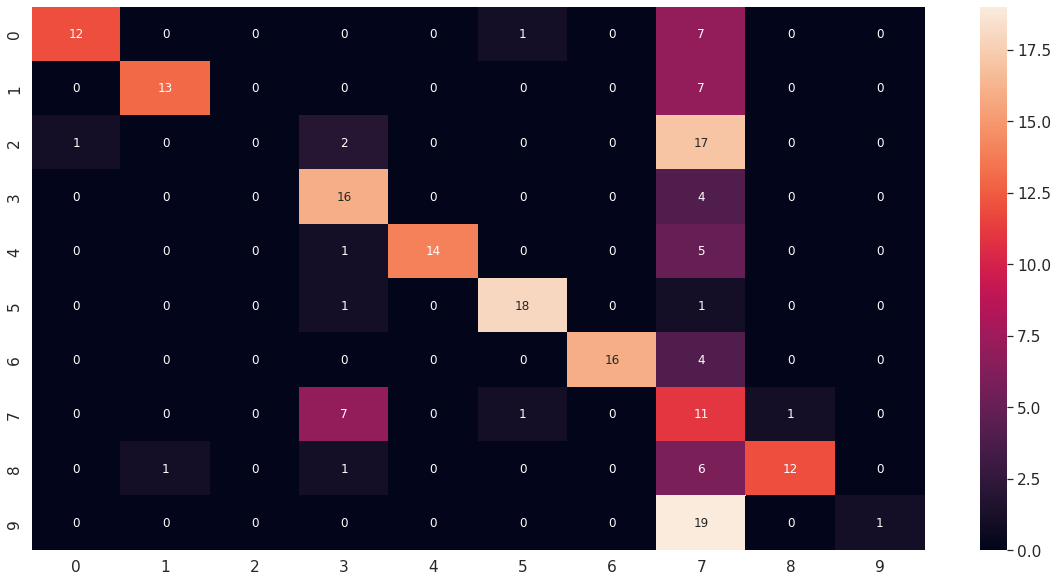

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof2_4_df_CM = pd.DataFrame(deepface_model_rof2_4_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof2_4_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof2_4_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof2_4_report)

              precision    recall  f1-score   support

           1       0.92      0.60      0.73        20
           2       0.93      0.65      0.76        20
           3       0.00      0.00      0.00        20
           4       0.57      0.80      0.67        20
           5       1.00      0.70      0.82        20
           6       0.90      0.90      0.90        20
           7       1.00      0.80      0.89        20
           8       0.14      0.55      0.22        20
           9       0.92      0.60      0.73        20
          10       1.00      0.05      0.10        20

    accuracy                           0.56       200
   macro avg       0.74      0.56      0.58       200
weighted avg       0.74      0.56      0.58       200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.92      0.60      0.73        20
           2       0.93      0.65      0.76        20
           3       0.00      0.00      0.00        20
           4       0.57      0.80      0.67        20
           5       1.00      0.70      0.82        20
           6       0.90      0.90      0.90        20
           7       1.00      0.80      0.89        20
           8       0.14      0.55      0.22        20
           9       0.92      0.60      0.73        20
          10       1.00      0.05      0.10        20

    accuracy                           0.56       200
   macro avg       0.74      0.56      0.58       200
weighted avg       0.74      0.56      0.58       200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Modelo 5: (BTH = 20, EHS = 100, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof2_5 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof2_5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof2_5.add(Dropout(rate=0, name='D0'))
deepface_model_rof2_5.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof2_5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_rof2_5.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_5.h5', monitor="val_loss", save_best_only=True)
hist_model_rof2_5 = deepface_model_rof2_5.fit(new_trainX, new_trainY, batch_size=20, epochs=100, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/100
64/64 [==============================] - 145s 670ms/step - loss: 2.4180 - accuracy: 0.5273 - val_loss: 1.0591 - val_accuracy: 0.7477
Epoch 2/100
64/64 [==============================] - 12s 195ms/step - loss: 0.2636 - accuracy: 0.9711 - val_loss: 0.8618 - val_accuracy: 0.7882
Epoch 3/100
64/64 [==============================] - 12s 195ms/step - loss: 0.1698 - accuracy: 0.9984 - val_loss: 0.7859 - val_accuracy: 0.8162
Epoch 4/100
64/64 [==============================] - 12s 195ms/step - loss: 0.1591 - accuracy: 1.0000 - val_loss: 0.7794 - val_accuracy: 0.8224
Epoch 5/100
64/64 [==============================] - 12s 194ms/step - loss: 0.1543 - accuracy: 1.0000 - val_loss: 0.7760 - val_accuracy: 0.8255
Epoch 6/100
64/64 [==============================] - 12s 194ms/step - loss: 0.1501 - accuracy: 1.0000 - val_loss: 0.7723 - val_accuracy: 0.8224
Epoch 7/100
64/64 [==============================] - 13s 200ms/step - loss: 0.1460 - accuracy: 1.0000 - val_loss: 0.7674 - val_accuracy

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof2_5 = load_model(path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_5.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof2_5.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof2_5.evaluate(testX, testY)

7/7 [==============================] - 1s 79ms/step - loss: 0.9252 - accuracy: 0.7550


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof2_5.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof2_5_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

7/7 [==============================] - 31s 66ms/step


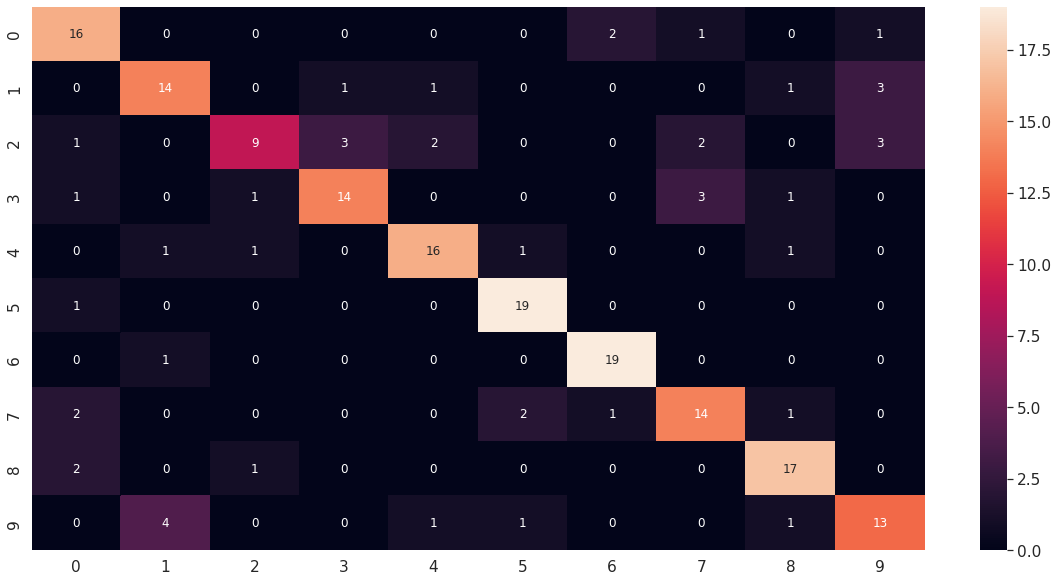

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof2_5_df_CM = pd.DataFrame(deepface_model_rof2_5_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof2_5_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof2_5_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof2_5_report)

              precision    recall  f1-score   support

           1       0.70      0.80      0.74        20
           2       0.70      0.70      0.70        20
           3       0.75      0.45      0.56        20
           4       0.78      0.70      0.74        20
           5       0.80      0.80      0.80        20
           6       0.83      0.95      0.88        20
           7       0.86      0.95      0.90        20
           8       0.70      0.70      0.70        20
           9       0.77      0.85      0.81        20
          10       0.65      0.65      0.65        20

    accuracy                           0.76       200
   macro avg       0.75      0.76      0.75       200
weighted avg       0.75      0.76      0.75       200



#### Modelo 6: (BTH = 20, EHS = 20, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = none, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof2_6 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof2_6.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof2_6.add(Dropout(rate=0, name='D0'))
deepface_model_rof2_6.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof2_6.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_rof2_6.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_6.h5', monitor="val_loss", save_best_only=True)
hist_model_rof2_6 = deepface_model_rof2_6.fit(new_trainX, new_trainY, batch_size=20, epochs=20, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/20
64/64 [==============================] - 146s 708ms/step - loss: 2.6442 - accuracy: 0.4922 - val_loss: 1.0664 - val_accuracy: 0.7072
Epoch 2/20
64/64 [==============================] - 13s 201ms/step - loss: 0.2760 - accuracy: 0.9711 - val_loss: 0.9282 - val_accuracy: 0.7601
Epoch 3/20
64/64 [==============================] - 13s 199ms/step - loss: 0.1709 - accuracy: 0.9977 - val_loss: 0.7640 - val_accuracy: 0.8318
Epoch 4/20
64/64 [==============================] - 13s 200ms/step - loss: 0.1580 - accuracy: 1.0000 - val_loss: 0.7480 - val_accuracy: 0.8349
Epoch 5/20
64/64 [==============================] - 13s 199ms/step - loss: 0.1534 - accuracy: 1.0000 - val_loss: 0.7415 - val_accuracy: 0.8349
Epoch 6/20
64/64 [==============================] - 13s 199ms/step - loss: 0.1495 - accuracy: 1.0000 - val_loss: 0.7371 - val_accuracy: 0.8349
Epoch 7/20
64/64 [==============================] - 13s 198ms/step - loss: 0.1458 - accuracy: 1.0000 - val_loss: 0.7371 - val_accuracy: 0.838

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof2_6 = load_model(path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_6.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof2_6.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof2_6.evaluate(testX, testY)

7/7 [==============================] - 1s 81ms/step - loss: 1.0418 - accuracy: 0.7250


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof2_6.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof2_6_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

7/7 [==============================] - 32s 68ms/step


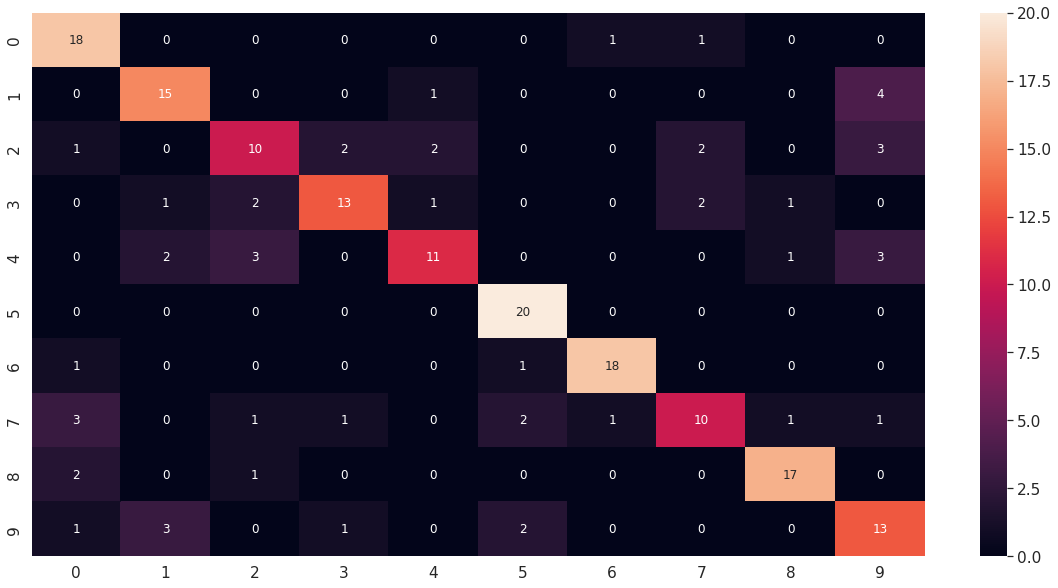

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof2_6_df_CM = pd.DataFrame(deepface_model_rof2_6_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof2_6_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof2_6_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof2_6_report)

              precision    recall  f1-score   support

           1       0.69      0.90      0.78        20
           2       0.71      0.75      0.73        20
           3       0.59      0.50      0.54        20
           4       0.76      0.65      0.70        20
           5       0.73      0.55      0.63        20
           6       0.80      1.00      0.89        20
           7       0.90      0.90      0.90        20
           8       0.67      0.50      0.57        20
           9       0.85      0.85      0.85        20
          10       0.54      0.65      0.59        20

    accuracy                           0.73       200
   macro avg       0.73      0.72      0.72       200
weighted avg       0.73      0.72      0.72       200



#### Modelo 7: (BTH = 30, EHS = 30, ValidSplit = 0.2, INI = none, Dropout=0 REG = L2, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof2_7 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof2_7.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof2_7.add(Dropout(rate=0, name='D0'))
deepface_model_rof2_7.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof2_7.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)  
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.001)
deepface_model_rof2_7.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_7.h5', monitor="val_loss", save_best_only=True)
hist_model_rof2_7 = deepface_model_rof2_7.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
43/43 [==============================] - 139s 1s/step - loss: 2.6132 - accuracy: 0.5156 - val_loss: 1.4655 - val_accuracy: 0.6262
Epoch 2/30
43/43 [==============================] - 11s 259ms/step - loss: 0.6799 - accuracy: 0.8422 - val_loss: 1.3735 - val_accuracy: 0.6947
Epoch 3/30
43/43 [==============================] - 6s 149ms/step - loss: 0.6150 - accuracy: 0.8758 - val_loss: 1.3810 - val_accuracy: 0.7477
Epoch 4/30
43/43 [==============================] - 7s 153ms/step - loss: 0.6088 - accuracy: 0.8914 - val_loss: 2.4088 - val_accuracy: 0.7165
Epoch 5/30
43/43 [==============================] - 7s 157ms/step - loss: 0.7630 - accuracy: 0.8750 - val_loss: 1.7045 - val_accuracy: 0.7383
Epoch 6/30
43/43 [==============================] - 7s 156ms/step - loss: 0.4544 - accuracy: 0.9187 - val_loss: 2.2707 - val_accuracy: 0.6885
Epoch 7/30
43/43 [==============================] - 6s 151ms/step - loss: 0.4622 - accuracy: 0.9367 - val_loss: 2.5390 - val_accuracy: 0.7290
Epoch 

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof2_7 = load_model(path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_7.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof2_7.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof2_7.evaluate(testX, testY)

7/7 [==============================] - 1s 80ms/step - loss: 1.8861 - accuracy: 0.6200


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof2_7.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof2_7_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

7/7 [==============================] - 33s 69ms/step


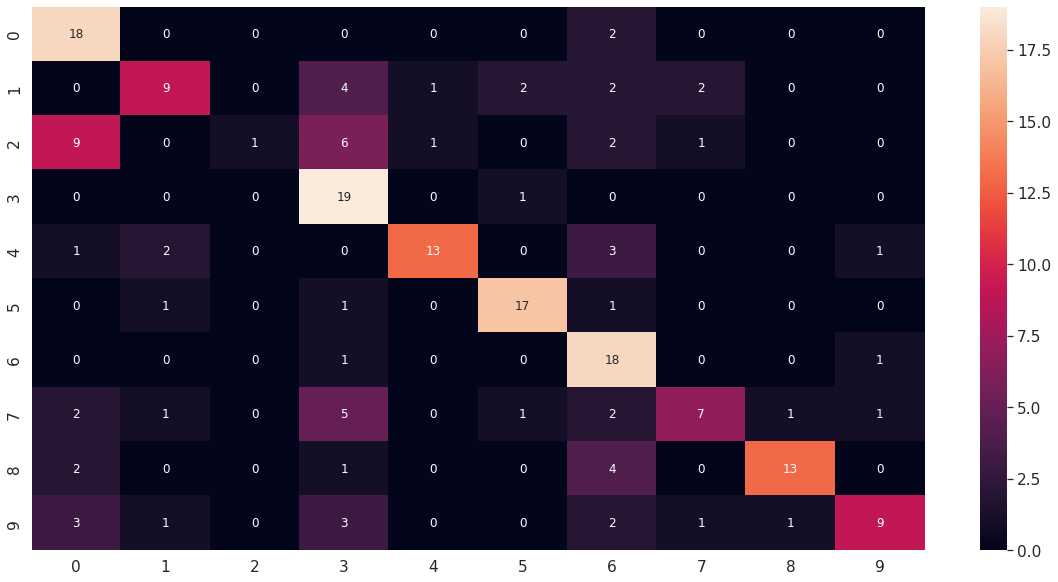

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof2_7_df_CM = pd.DataFrame(deepface_model_rof2_7_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof2_7_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof2_7_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof2_7_report)

              precision    recall  f1-score   support

           1       0.51      0.90      0.65        20
           2       0.64      0.45      0.53        20
           3       1.00      0.05      0.10        20
           4       0.47      0.95      0.63        20
           5       0.87      0.65      0.74        20
           6       0.81      0.85      0.83        20
           7       0.50      0.90      0.64        20
           8       0.64      0.35      0.45        20
           9       0.87      0.65      0.74        20
          10       0.75      0.45      0.56        20

    accuracy                           0.62       200
   macro avg       0.71      0.62      0.59       200
weighted avg       0.71      0.62      0.59       200



#### Modelo 8: (BTH = 10, EHS = 30, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = none, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof2_8 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof2_8.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof2_8.add(Dropout(rate=0, name='D0'))
deepface_model_rof2_8.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof2_8.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)  
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_rof2_8.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_8.h5', monitor="val_loss", save_best_only=True)
hist_model_rof2_8 = deepface_model_rof2_8.fit(new_trainX, new_trainY, batch_size=10, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
128/128 [==============================] - 156s 439ms/step - loss: 1.0881 - accuracy: 0.8781 - val_loss: 1.8391 - val_accuracy: 0.7695
Epoch 2/30
128/128 [==============================] - 21s 162ms/step - loss: 0.0376 - accuracy: 0.9961 - val_loss: 1.7316 - val_accuracy: 0.7819
Epoch 3/30
128/128 [==============================] - 21s 160ms/step - loss: 0.0196 - accuracy: 0.9992 - val_loss: 1.7240 - val_accuracy: 0.7850
Epoch 4/30
128/128 [==============================] - 16s 124ms/step - loss: 0.0159 - accuracy: 1.0000 - val_loss: 1.7320 - val_accuracy: 0.7850
Epoch 5/30
128/128 [==============================] - 16s 125ms/step - loss: 0.0154 - accuracy: 1.0000 - val_loss: 1.7358 - val_accuracy: 0.7850
Epoch 6/30
128/128 [==============================] - 15s 120ms/step - loss: 0.0149 - accuracy: 1.0000 - val_loss: 1.7419 - val_accuracy: 0.7850
Epoch 7/30
128/128 [==============================] - 15s 119ms/step - loss: 0.0146 - accuracy: 1.0000 - val_loss: 1.7463 - val_a

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof2_8 = load_model(path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_8.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof2_8.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof2_8.evaluate(testX, testY)

7/7 [==============================] - 0s 66ms/step - loss: 1.2243 - accuracy: 0.7550


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof2_8.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof2_8_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

7/7 [==============================] - 35s 66ms/step


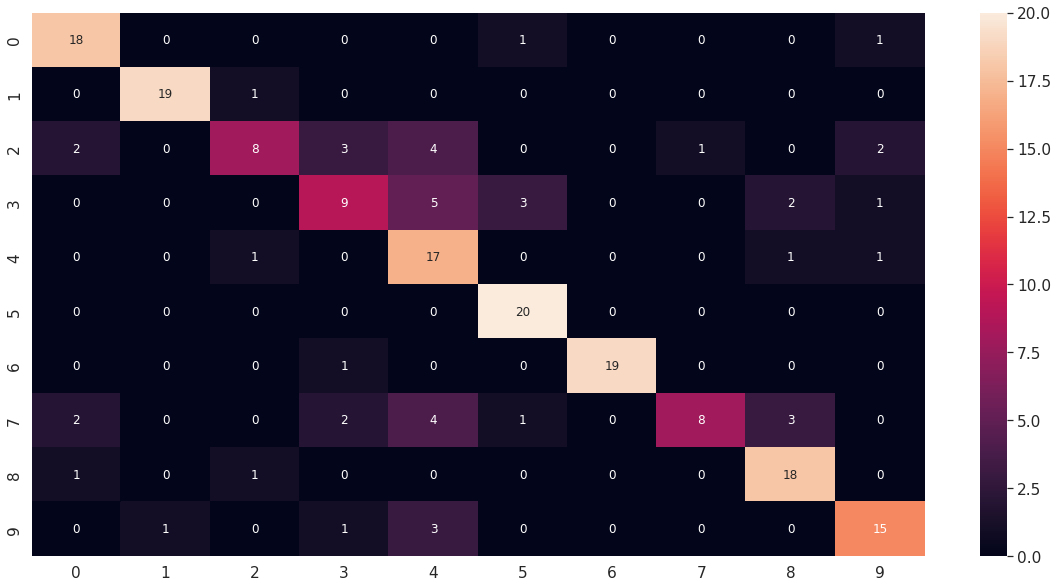

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof2_8_df_CM = pd.DataFrame(deepface_model_rof2_8_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof2_8_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof2_8_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof2_8_report)

              precision    recall  f1-score   support

           1       0.78      0.90      0.84        20
           2       0.95      0.95      0.95        20
           3       0.73      0.40      0.52        20
           4       0.56      0.45      0.50        20
           5       0.52      0.85      0.64        20
           6       0.80      1.00      0.89        20
           7       1.00      0.95      0.97        20
           8       0.89      0.40      0.55        20
           9       0.75      0.90      0.82        20
          10       0.75      0.75      0.75        20

    accuracy                           0.76       200
   macro avg       0.77      0.76      0.74       200
weighted avg       0.77      0.76      0.74       200



#### Modelo 9: (BTH = 30, EHS = 30, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof2_9 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof2_9.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof2_9.add(Dropout(rate=0, name='D0'))
deepface_model_rof2_9.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof2_9.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_rof2_9.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_9.h5', monitor="val_loss", save_best_only=True)
hist_model_rof2_9 = deepface_model_rof2_9.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
43/43 [==============================] - 139s 1s/step - loss: 2.2776 - accuracy: 0.4344 - val_loss: 1.3222 - val_accuracy: 0.6604
Epoch 2/30
43/43 [==============================] - 10s 225ms/step - loss: 0.5821 - accuracy: 0.8883 - val_loss: 1.0405 - val_accuracy: 0.7290
Epoch 3/30
43/43 [==============================] - 9s 209ms/step - loss: 0.3084 - accuracy: 0.9945 - val_loss: 0.9733 - val_accuracy: 0.7850
Epoch 4/30
43/43 [==============================] - 9s 206ms/step - loss: 0.2577 - accuracy: 1.0000 - val_loss: 0.9518 - val_accuracy: 0.7788
Epoch 5/30
43/43 [==============================] - 9s 207ms/step - loss: 0.2418 - accuracy: 1.0000 - val_loss: 0.9337 - val_accuracy: 0.7819
Epoch 6/30
43/43 [==============================] - 9s 203ms/step - loss: 0.2332 - accuracy: 1.0000 - val_loss: 0.9211 - val_accuracy: 0.7819
Epoch 7/30
43/43 [==============================] - 9s 222ms/step - loss: 0.2268 - accuracy: 1.0000 - val_loss: 0.9140 - val_accuracy: 0.7944
Epoch 

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof2_9 = load_model(path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_9.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof2_9.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof2_9.evaluate(testX, testY)

7/7 [==============================] - 1s 80ms/step - loss: 1.1816 - accuracy: 0.6750


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof2_9.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof2_9_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

7/7 [==============================] - 32s 64ms/step


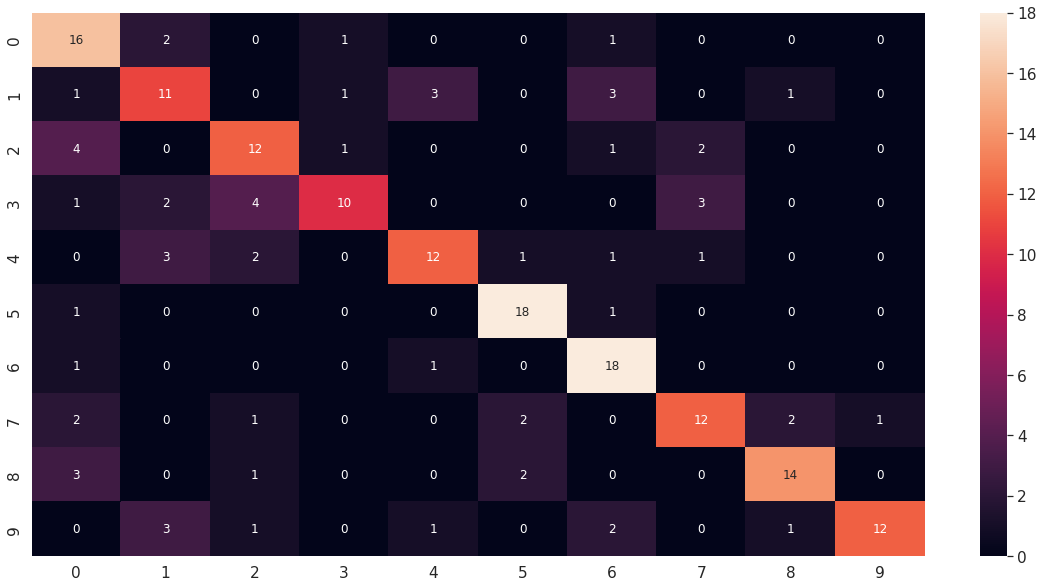

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof2_9_df_CM = pd.DataFrame(deepface_model_rof2_9_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof2_9_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof2_9_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof2_9_report)

              precision    recall  f1-score   support

           1       0.55      0.80      0.65        20
           2       0.52      0.55      0.54        20
           3       0.57      0.60      0.59        20
           4       0.77      0.50      0.61        20
           5       0.71      0.60      0.65        20
           6       0.78      0.90      0.84        20
           7       0.67      0.90      0.77        20
           8       0.67      0.60      0.63        20
           9       0.78      0.70      0.74        20
          10       0.92      0.60      0.73        20

    accuracy                           0.68       200
   macro avg       0.69      0.68      0.67       200
weighted avg       0.69      0.68      0.67       200



#### Modelo 10: (BTH = 20, EHS = 20, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof2_10 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof2_10.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof2_10.add(Dropout(rate=0, name='D0'))
deepface_model_rof2_10.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof2_10.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_rof2_10.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_10.h5', monitor="val_loss", save_best_only=True)
hist_model_rof2_10 = deepface_model_rof2_10.fit(new_trainX, new_trainY, batch_size=20, epochs=20, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/20
64/64 [==============================] - 133s 660ms/step - loss: 1.5000 - accuracy: 0.6219 - val_loss: 1.0159 - val_accuracy: 0.7819
Epoch 2/20
64/64 [==============================] - 11s 167ms/step - loss: 0.3023 - accuracy: 0.9789 - val_loss: 0.8545 - val_accuracy: 0.8193
Epoch 3/20
64/64 [==============================] - 11s 166ms/step - loss: 0.2340 - accuracy: 0.9992 - val_loss: 0.8378 - val_accuracy: 0.8255
Epoch 4/20
64/64 [==============================] - 11s 166ms/step - loss: 0.2212 - accuracy: 1.0000 - val_loss: 0.8305 - val_accuracy: 0.8287
Epoch 5/20
64/64 [==============================] - 11s 166ms/step - loss: 0.2148 - accuracy: 1.0000 - val_loss: 0.8212 - val_accuracy: 0.8287
Epoch 6/20
64/64 [==============================] - 10s 163ms/step - loss: 0.2093 - accuracy: 1.0000 - val_loss: 0.8177 - val_accuracy: 0.8318
Epoch 7/20
64/64 [==============================] - 11s 167ms/step - loss: 0.2040 - accuracy: 1.0000 - val_loss: 0.8115 - val_accuracy: 0.825

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof2_10 = load_model(path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_10.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof2_10.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof2_10.evaluate(testX, testY)

7/7 [==============================] - 0s 67ms/step - loss: 1.0770 - accuracy: 0.6950


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof2_10.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof2_10_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

7/7 [==============================] - 32s 67ms/step


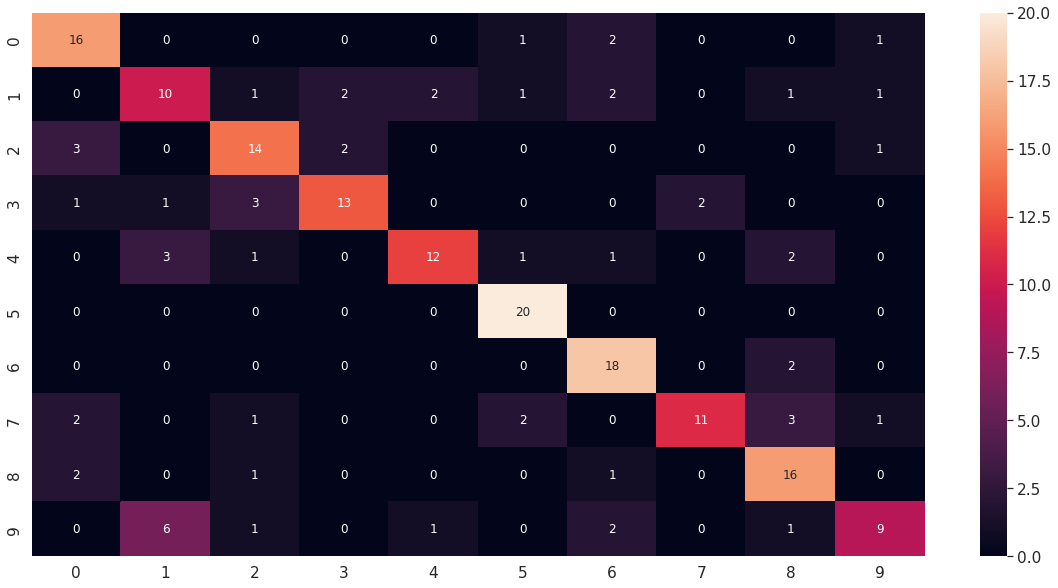

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof2_10_df_CM = pd.DataFrame(deepface_model_rof2_10_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof2_10_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof2_10_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof2_10_report)

              precision    recall  f1-score   support

           1       0.67      0.80      0.73        20
           2       0.50      0.50      0.50        20
           3       0.64      0.70      0.67        20
           4       0.76      0.65      0.70        20
           5       0.80      0.60      0.69        20
           6       0.80      1.00      0.89        20
           7       0.69      0.90      0.78        20
           8       0.85      0.55      0.67        20
           9       0.64      0.80      0.71        20
          10       0.69      0.45      0.55        20

    accuracy                           0.69       200
   macro avg       0.70      0.70      0.69       200
weighted avg       0.70      0.69      0.69       200



#### Modelo 11: (BTH = 40, EHS = 100, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof2_11 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof2_11.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof2_11.add(Dropout(rate=0, name='D0'))
deepface_model_rof2_11.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof2_11.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_rof2_11.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_11.h5', monitor="val_loss", save_best_only=True)
hist_model_rof2_11 = deepface_model_rof2_11.fit(new_trainX, new_trainY, batch_size=40, epochs=100, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/100
32/32 [==============================] - 140s 1s/step - loss: 2.5215 - accuracy: 0.7234 - val_loss: 1.4024 - val_accuracy: 0.7477
Epoch 2/100
32/32 [==============================] - 11s 342ms/step - loss: 0.2002 - accuracy: 0.9852 - val_loss: 0.9920 - val_accuracy: 0.8193
Epoch 3/100
32/32 [==============================] - 10s 327ms/step - loss: 0.1355 - accuracy: 1.0000 - val_loss: 0.9732 - val_accuracy: 0.8287
Epoch 4/100
32/32 [==============================] - 10s 326ms/step - loss: 0.1297 - accuracy: 1.0000 - val_loss: 0.9677 - val_accuracy: 0.8287
Epoch 5/100
32/32 [==============================] - 10s 316ms/step - loss: 0.1271 - accuracy: 1.0000 - val_loss: 0.9638 - val_accuracy: 0.8287
Epoch 6/100
32/32 [==============================] - 10s 318ms/step - loss: 0.1250 - accuracy: 1.0000 - val_loss: 0.9583 - val_accuracy: 0.8287
Epoch 7/100
32/32 [==============================] - 10s 319ms/step - loss: 0.1231 - accuracy: 1.0000 - val_loss: 0.9574 - val_accuracy: 0

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof2_11 = load_model(path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_11.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof2_11.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof2_11.evaluate(testX, testY)

7/7 [==============================] - 0s 64ms/step - loss: 1.1512 - accuracy: 0.7250


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof2_11.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof2_11_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

7/7 [==============================] - 35s 68ms/step


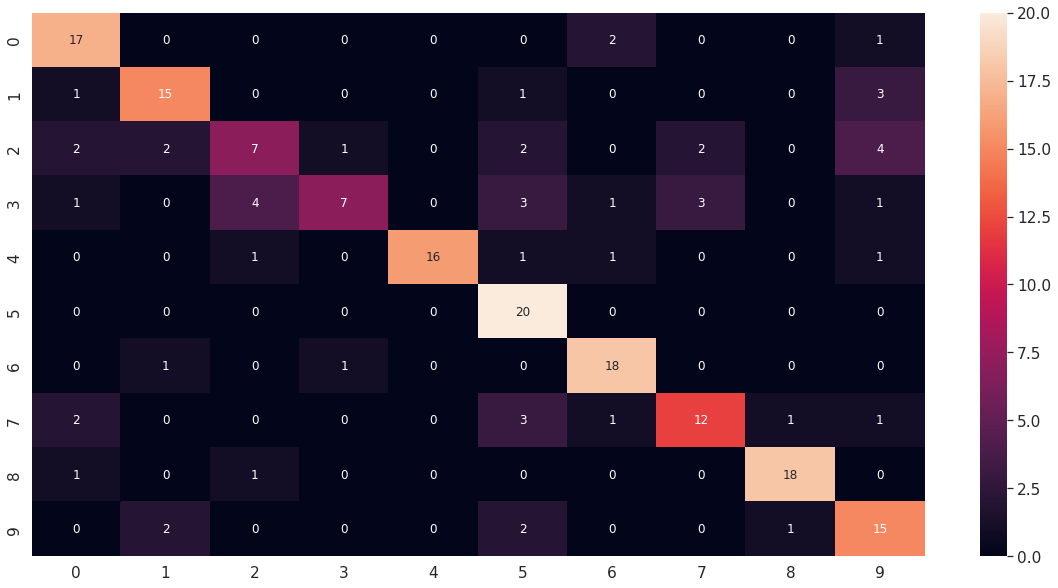

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof2_11_df_CM = pd.DataFrame(deepface_model_rof2_11_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof2_11_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof2_11_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof2_11_report)

              precision    recall  f1-score   support

           1       0.71      0.85      0.77        20
           2       0.75      0.75      0.75        20
           3       0.54      0.35      0.42        20
           4       0.78      0.35      0.48        20
           5       1.00      0.80      0.89        20
           6       0.62      1.00      0.77        20
           7       0.78      0.90      0.84        20
           8       0.71      0.60      0.65        20
           9       0.90      0.90      0.90        20
          10       0.58      0.75      0.65        20

    accuracy                           0.73       200
   macro avg       0.74      0.72      0.71       200
weighted avg       0.74      0.72      0.71       200



#### Modelo 12: (BTH = 20, EHS =20, ValidSplit = 0.2, INI = HeNormal, Dropout=0.5 REG = L2 none, OPT = adam[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof2_12 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof2_12.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof2_12.add(Dropout(rate=0.5, name='D0'))
deepface_model_rof2_12.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof2_12.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.001)
deepface_model_rof2_12.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_12.h5', monitor="val_loss", save_best_only=True)
hist_model_rof2_12 = deepface_model_rof2_12.fit(new_trainX, new_trainY, batch_size=20, epochs=20, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/20
64/64 [==============================] - 138s 725ms/step - loss: 3.5456 - accuracy: 0.7648 - val_loss: 1.8995 - val_accuracy: 0.7819
Epoch 2/20
64/64 [==============================] - 8s 127ms/step - loss: 0.3618 - accuracy: 0.9477 - val_loss: 2.4590 - val_accuracy: 0.7601
Epoch 3/20
64/64 [==============================] - 8s 132ms/step - loss: 0.3629 - accuracy: 0.9586 - val_loss: 3.2462 - val_accuracy: 0.7539
Epoch 4/20
64/64 [==============================] - 8s 132ms/step - loss: 0.8128 - accuracy: 0.9273 - val_loss: 5.0985 - val_accuracy: 0.7290
Epoch 5/20
64/64 [==============================] - 8s 129ms/step - loss: 0.7922 - accuracy: 0.9383 - val_loss: 7.7938 - val_accuracy: 0.7321
Epoch 6/20
64/64 [==============================] - 8s 127ms/step - loss: 1.8254 - accuracy: 0.9094 - val_loss: 9.2055 - val_accuracy: 0.7321
Epoch 7/20
64/64 [==============================] - 8s 126ms/step - loss: 2.1853 - accuracy: 0.9250 - val_loss: 8.4764 - val_accuracy: 0.7944
Epoc

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof2_12 = load_model(path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_12.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof2_12.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof2_12.evaluate(testX, testY)

7/7 [==============================] - 0s 63ms/step - loss: 1.9708 - accuracy: 0.7000


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof2_12.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof2_12_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

7/7 [==============================] - 49s 65ms/step


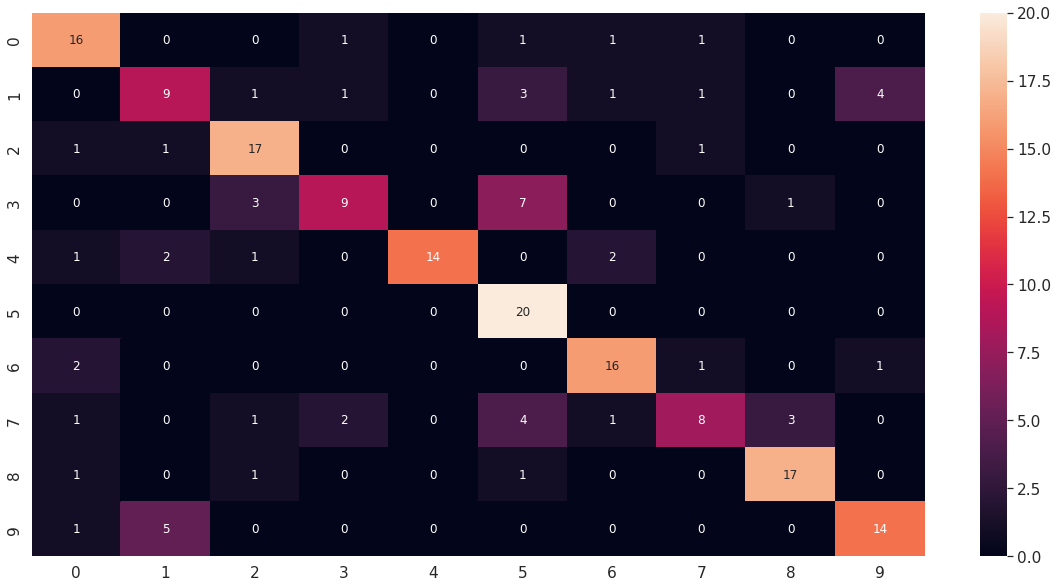

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof2_12_df_CM = pd.DataFrame(deepface_model_rof2_12_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof2_12_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof2_12_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof2_12_report)

              precision    recall  f1-score   support

           1       0.70      0.80      0.74        20
           2       0.53      0.45      0.49        20
           3       0.71      0.85      0.77        20
           4       0.69      0.45      0.55        20
           5       1.00      0.70      0.82        20
           6       0.56      1.00      0.71        20
           7       0.76      0.80      0.78        20
           8       0.67      0.40      0.50        20
           9       0.81      0.85      0.83        20
          10       0.74      0.70      0.72        20

    accuracy                           0.70       200
   macro avg       0.72      0.70      0.69       200
weighted avg       0.72      0.70      0.69       200



#### Modelo 13: (BTH = 40, EHS = 30, ValidSplit = 0.2, Dropout = 0.2, INI = HeNormal, Dropout=0, REG = L2, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof2_13 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof2_13.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof2_13.add(Dropout(rate=0, name='D0'))
deepface_model_rof2_13.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof2_13.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_rof2_13.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_13.h5', monitor="val_loss", save_best_only=True)
hist_model_rof2_13 = deepface_model_rof2_13.fit(new_trainX, new_trainY, batch_size=40, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
32/32 [==============================] - 146s 1s/step - loss: 3.0704 - accuracy: 0.4742 - val_loss: 1.0266 - val_accuracy: 0.7352
Epoch 2/30
32/32 [==============================] - 10s 310ms/step - loss: 0.3075 - accuracy: 0.9656 - val_loss: 0.7624 - val_accuracy: 0.8224
Epoch 3/30
32/32 [==============================] - 10s 311ms/step - loss: 0.1799 - accuracy: 1.0000 - val_loss: 0.7623 - val_accuracy: 0.8224
Epoch 4/30
32/32 [==============================] - 10s 316ms/step - loss: 0.1688 - accuracy: 1.0000 - val_loss: 0.7493 - val_accuracy: 0.8255
Epoch 5/30
32/32 [==============================] - 10s 311ms/step - loss: 0.1641 - accuracy: 1.0000 - val_loss: 0.7392 - val_accuracy: 0.8255
Epoch 6/30
32/32 [==============================] - 10s 310ms/step - loss: 0.1603 - accuracy: 1.0000 - val_loss: 0.7351 - val_accuracy: 0.8255
Epoch 7/30
32/32 [==============================] - 10s 310ms/step - loss: 0.1568 - accuracy: 1.0000 - val_loss: 0.7319 - val_accuracy: 0.8255
E

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof2_13 = load_model(path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_13.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof2_13.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof2_13.evaluate(testX, testY)

7/7 [==============================] - 1s 80ms/step - loss: 0.8843 - accuracy: 0.7700


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof2_13.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof2_13_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

7/7 [==============================] - 50s 65ms/step


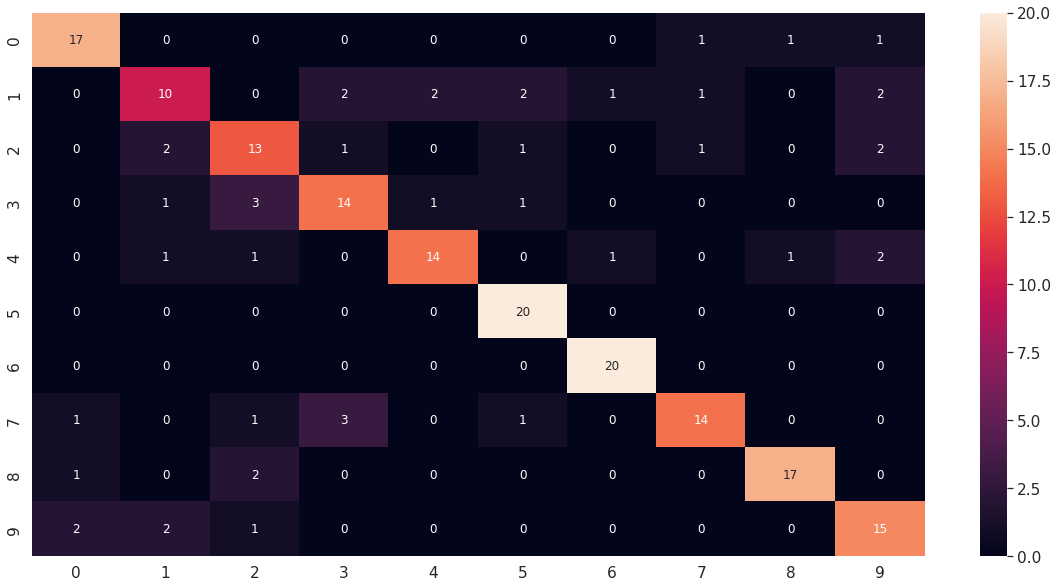

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof2_13_df_CM = pd.DataFrame(deepface_model_rof2_13_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof2_13_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof2_13_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof2_13_report)

              precision    recall  f1-score   support

           1       0.81      0.85      0.83        20
           2       0.62      0.50      0.56        20
           3       0.62      0.65      0.63        20
           4       0.70      0.70      0.70        20
           5       0.82      0.70      0.76        20
           6       0.80      1.00      0.89        20
           7       0.91      1.00      0.95        20
           8       0.82      0.70      0.76        20
           9       0.89      0.85      0.87        20
          10       0.68      0.75      0.71        20

    accuracy                           0.77       200
   macro avg       0.77      0.77      0.77       200
weighted avg       0.77      0.77      0.77       200



#### Modelo 14: (BTH = 10, EHS = 30, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof2_14 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof2_14.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof2_14.add(Dropout(rate=0, name='D0'))
deepface_model_rof2_14.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof2_14.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_rof2_14.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_14.h5', monitor="val_loss", save_best_only=True)
hist_model_rof2_14 = deepface_model_rof2_14.fit(new_trainX, new_trainY, batch_size=10, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
128/128 [==============================] - 139s 370ms/step - loss: 0.9564 - accuracy: 0.8711 - val_loss: 0.9067 - val_accuracy: 0.8255
Epoch 2/30
128/128 [==============================] - 16s 125ms/step - loss: 0.2296 - accuracy: 1.0000 - val_loss: 0.8837 - val_accuracy: 0.8255
Epoch 3/30
128/128 [==============================] - 16s 126ms/step - loss: 0.2164 - accuracy: 1.0000 - val_loss: 0.8615 - val_accuracy: 0.8255
Epoch 4/30
128/128 [==============================] - 16s 125ms/step - loss: 0.2057 - accuracy: 1.0000 - val_loss: 0.8442 - val_accuracy: 0.8255
Epoch 5/30
128/128 [==============================] - 16s 126ms/step - loss: 0.1958 - accuracy: 1.0000 - val_loss: 0.8254 - val_accuracy: 0.8287
Epoch 6/30
128/128 [==============================] - 16s 125ms/step - loss: 0.1864 - accuracy: 1.0000 - val_loss: 0.8097 - val_accuracy: 0.8287
Epoch 7/30
128/128 [==============================] - 16s 126ms/step - loss: 0.1774 - accuracy: 1.0000 - val_loss: 0.7953 - val_a

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof2_14 = load_model(path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_14.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof2_14.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof2_14.evaluate(testX, testY)

7/7 [==============================] - 1s 69ms/step - loss: 0.7717 - accuracy: 0.7550


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof2_14.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof2_14_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

7/7 [==============================] - 36s 65ms/step


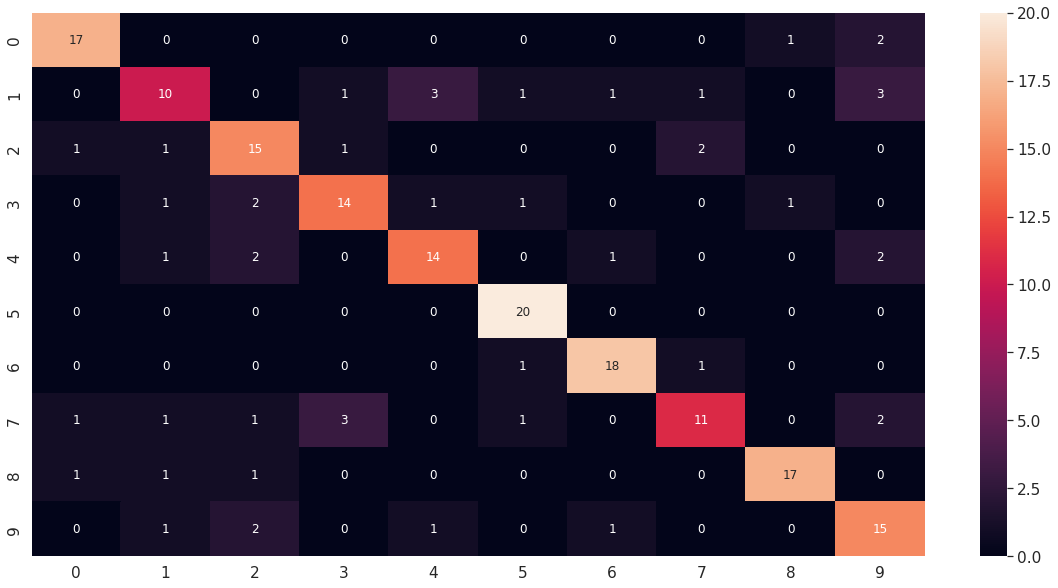

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof2_14_df_CM = pd.DataFrame(deepface_model_rof2_14_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof2_14_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof2_14_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof2_14_report)

              precision    recall  f1-score   support

           1       0.85      0.85      0.85        20
           2       0.62      0.50      0.56        20
           3       0.65      0.75      0.70        20
           4       0.74      0.70      0.72        20
           5       0.74      0.70      0.72        20
           6       0.83      1.00      0.91        20
           7       0.86      0.90      0.88        20
           8       0.73      0.55      0.63        20
           9       0.89      0.85      0.87        20
          10       0.62      0.75      0.68        20

    accuracy                           0.76       200
   macro avg       0.75      0.76      0.75       200
weighted avg       0.75      0.76      0.75       200



#### Modelo 15: (BTH = 40, EHS = 30, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof2_15 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof2_15.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof2_15.add(Dropout(rate=0, name='D0'))
deepface_model_rof2_15.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof2_15.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_rof2_15.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_15.h5', monitor="val_loss", save_best_only=True)
hist_model_rof2_15 = deepface_model_rof2_15.fit(new_trainX, new_trainY, batch_size=40, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
32/32 [==============================] - 132s 1s/step - loss: 0.9613 - accuracy: 0.7812 - val_loss: 0.9313 - val_accuracy: 0.7757
Epoch 2/30
32/32 [==============================] - 8s 257ms/step - loss: 0.2384 - accuracy: 1.0000 - val_loss: 0.8489 - val_accuracy: 0.8006
Epoch 3/30
32/32 [==============================] - 8s 259ms/step - loss: 0.2264 - accuracy: 1.0000 - val_loss: 0.8483 - val_accuracy: 0.8069
Epoch 4/30
32/32 [==============================] - 8s 258ms/step - loss: 0.2225 - accuracy: 1.0000 - val_loss: 0.8437 - val_accuracy: 0.8069
Epoch 5/30
32/32 [==============================] - 9s 273ms/step - loss: 0.2192 - accuracy: 1.0000 - val_loss: 0.8395 - val_accuracy: 0.8069
Epoch 6/30
32/32 [==============================] - 8s 264ms/step - loss: 0.2162 - accuracy: 1.0000 - val_loss: 0.8343 - val_accuracy: 0.8069
Epoch 7/30
32/32 [==============================] - 9s 273ms/step - loss: 0.2133 - accuracy: 1.0000 - val_loss: 0.8300 - val_accuracy: 0.8100
Epoch 8

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof2_15 = load_model(path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_15.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof2_15.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof2_15.evaluate(testX, testY)

7/7 [==============================] - 0s 64ms/step - loss: 0.8943 - accuracy: 0.7300


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof2_15.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof2_15_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

7/7 [==============================] - 36s 70ms/step


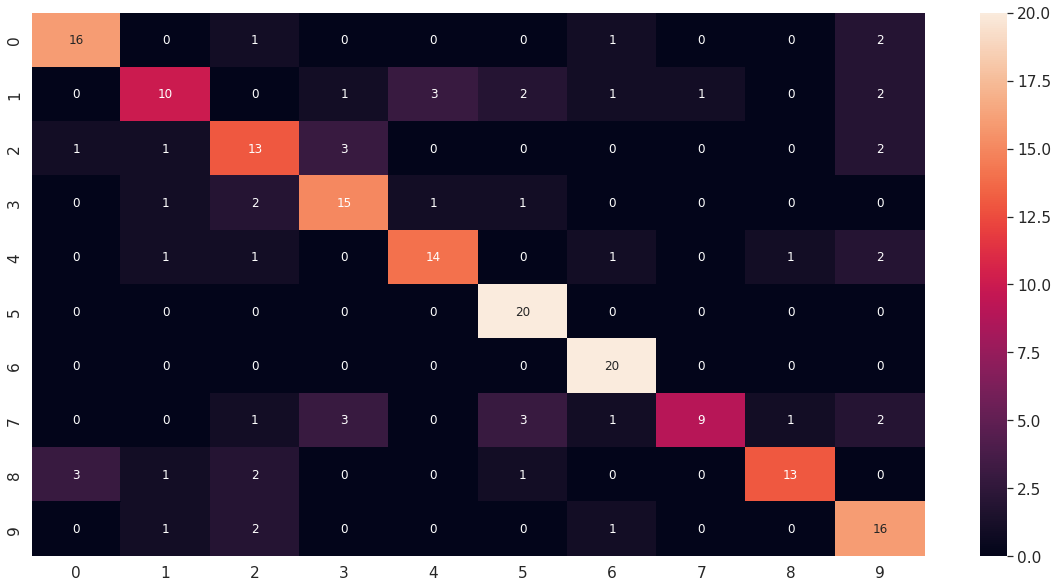

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof2_15_df_CM = pd.DataFrame(deepface_model_rof2_15_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof2_15_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof2_15_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof2_15_report)

              precision    recall  f1-score   support

           1       0.80      0.80      0.80        20
           2       0.67      0.50      0.57        20
           3       0.59      0.65      0.62        20
           4       0.68      0.75      0.71        20
           5       0.78      0.70      0.74        20
           6       0.74      1.00      0.85        20
           7       0.80      1.00      0.89        20
           8       0.90      0.45      0.60        20
           9       0.87      0.65      0.74        20
          10       0.62      0.80      0.70        20

    accuracy                           0.73       200
   macro avg       0.74      0.73      0.72       200
weighted avg       0.74      0.73      0.72       200



#### Modelo 16: (BTH = 20, EHS = 40, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_rof2_16 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_rof2_16.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_rof2_16.add(Dropout(rate=0, name='D0'))
deepface_model_rof2_16.add(Dense(11, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_rof2_16.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_rof2_16.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_16.h5', monitor="val_loss", save_best_only=True)
hist_model_rof2_16 = deepface_model_rof2_16.fit(new_trainX, new_trainY, batch_size=20, epochs=40, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/40
64/64 [==============================] - 138s 704ms/step - loss: 1.3695 - accuracy: 0.6969 - val_loss: 1.1244 - val_accuracy: 0.7508
Epoch 2/40
64/64 [==============================] - 13s 204ms/step - loss: 0.2117 - accuracy: 0.9812 - val_loss: 0.8777 - val_accuracy: 0.8162
Epoch 3/40
64/64 [==============================] - 13s 208ms/step - loss: 0.1542 - accuracy: 1.0000 - val_loss: 0.8301 - val_accuracy: 0.8318
Epoch 4/40
64/64 [==============================] - 13s 209ms/step - loss: 0.1463 - accuracy: 1.0000 - val_loss: 0.8145 - val_accuracy: 0.8318
Epoch 5/40
64/64 [==============================] - 13s 208ms/step - loss: 0.1406 - accuracy: 1.0000 - val_loss: 0.8085 - val_accuracy: 0.8349
Epoch 6/40
64/64 [==============================] - 14s 214ms/step - loss: 0.1354 - accuracy: 1.0000 - val_loss: 0.7993 - val_accuracy: 0.8411
Epoch 7/40
64/64 [==============================] - 8s 132ms/step - loss: 0.1304 - accuracy: 1.0000 - val_loss: 0.8205 - val_accuracy: 0.8411

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_rof2_16 = load_model(path + 'data_reconocimiento2/models_ROF2/deepface_model_ROF2_16.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_rof2_16.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_rof2_16.evaluate(testX, testY)

7/7 [==============================] - 0s 64ms/step - loss: 0.9881 - accuracy: 0.6950


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_rof2_16.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_rof2_16_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

7/7 [==============================] - 49s 69ms/step


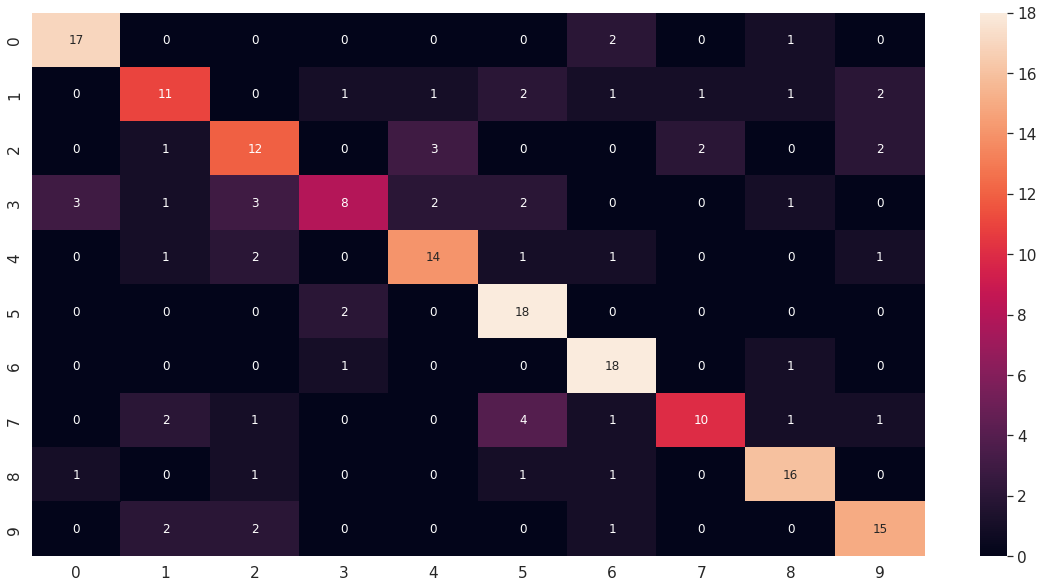

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_rof2_16_df_CM = pd.DataFrame(deepface_model_rof2_16_CM, range(10), range(10))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_rof2_16_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_rof2_16_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_rof2_16_report)

              precision    recall  f1-score   support

           1       0.81      0.85      0.83        20
           2       0.61      0.55      0.58        20
           3       0.57      0.60      0.59        20
           4       0.67      0.40      0.50        20
           5       0.70      0.70      0.70        20
           6       0.64      0.90      0.75        20
           7       0.72      0.90      0.80        20
           8       0.77      0.50      0.61        20
           9       0.76      0.80      0.78        20
          10       0.71      0.75      0.73        20

    accuracy                           0.69       200
   macro avg       0.70      0.70      0.69       200
weighted avg       0.70      0.69      0.69       200



## 7. Modelos con base de datos VGG-African para condiciones de etnia

#### Modelo 1: (BTH = 10, EHS = 60, ValidSplit = 0.2, Dropout=0, INI = HeNormal, REG = L2, OPT = SGD[0.001, momentum=0.9])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg1_1 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg1_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final dropout y softmax de 11 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg1_1.add(Dropout(rate=0, name='D0'))
deepface_model_vgg1_1.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg1_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)    
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg1_1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_1.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg1_1 = deepface_model_vgg1_1.fit(new_trainX, new_trainY, batch_size=10, epochs=60, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/60
208/208 [==============================] - 165s 294ms/step - loss: 1.5147 - accuracy: 0.7300 - val_loss: 0.9724 - val_accuracy: 0.8536
Epoch 2/60
208/208 [==============================] - 26s 124ms/step - loss: 0.4314 - accuracy: 0.9928 - val_loss: 0.8216 - val_accuracy: 0.8805
Epoch 3/60
208/208 [==============================] - 25s 120ms/step - loss: 0.3747 - accuracy: 1.0000 - val_loss: 0.7480 - val_accuracy: 0.9017
Epoch 4/60
208/208 [==============================] - 25s 123ms/step - loss: 0.3446 - accuracy: 1.0000 - val_loss: 0.7153 - val_accuracy: 0.9037
Epoch 5/60
208/208 [==============================] - 25s 122ms/step - loss: 0.3183 - accuracy: 1.0000 - val_loss: 0.6840 - val_accuracy: 0.9037
Epoch 6/60
208/208 [==============================] - 26s 125ms/step - loss: 0.2942 - accuracy: 1.0000 - val_loss: 0.6595 - val_accuracy: 0.9017
Epoch 7/60
208/208 [==============================] - 25s 122ms/step - loss: 0.2722 - accuracy: 1.0000 - val_loss: 0.6337 - val_a

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg1_1 = load_model(path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_1.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg1_1.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg1_1.evaluate(testX, testY)

32/32 [==============================] - 2s 72ms/step - loss: 0.2493 - accuracy: 0.9330


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg1_1.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg1_1_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

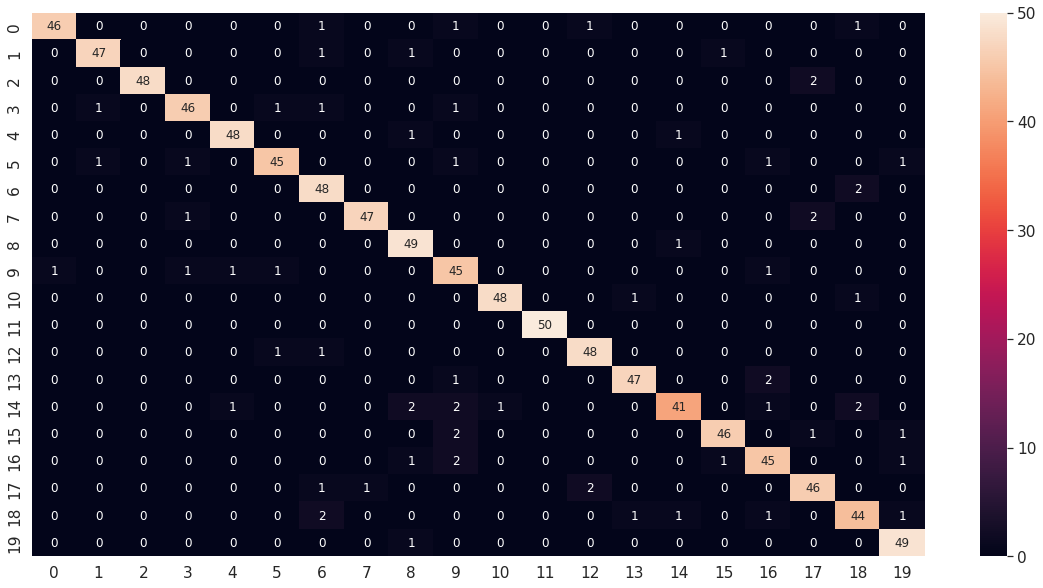

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg1_1_df_CM = pd.DataFrame(deepface_model_vgg1_1_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg1_1_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg1_1_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg1_1_report)

              precision    recall  f1-score   support

           1       0.98      0.92      0.95        50
           2       0.96      0.94      0.95        50
           3       1.00      0.96      0.98        50
           4       0.94      0.92      0.93        50
           5       0.96      0.96      0.96        50
           6       0.94      0.90      0.92        50
           7       0.87      0.96      0.91        50
           8       0.98      0.94      0.96        50
           9       0.89      0.98      0.93        50
          10       0.82      0.90      0.86        50
          11       0.98      0.96      0.97        50
          12       1.00      1.00      1.00        50
          13       0.94      0.96      0.95        50
          14       0.96      0.94      0.95        50
          15       0.93      0.82      0.87        50
          16       0.96      0.92      0.94        50
          17       0.88      0.90      0.89        50
          18       0.90    

#### Modelo 2: (BTH = 20, EHS = 60, ValidSplit = 0.2, Dropout=0.5, INI = HeNormal, REG = L2, OPT = SGD[0.001, momentum=0.9])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg1_2 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg1_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final dropout y softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg1_2.add(Dropout(rate=0, name='D0'))
deepface_model_vgg1_2.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg1_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)    
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg1_2.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_2.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg1_2 = deepface_model_vgg1_2.fit(new_trainX, new_trainY, batch_size=20, epochs=60, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/60
104/104 [==============================] - 145s 455ms/step - loss: 1.3354 - accuracy: 0.8226 - val_loss: 0.8900 - val_accuracy: 0.8767
Epoch 2/60
104/104 [==============================] - 16s 150ms/step - loss: 0.4258 - accuracy: 0.9986 - val_loss: 0.8840 - val_accuracy: 0.8709
Epoch 3/60
104/104 [==============================] - 15s 148ms/step - loss: 0.4016 - accuracy: 1.0000 - val_loss: 0.8033 - val_accuracy: 0.8825
Epoch 4/60
104/104 [==============================] - 15s 148ms/step - loss: 0.3844 - accuracy: 1.0000 - val_loss: 0.7811 - val_accuracy: 0.8825
Epoch 5/60
104/104 [==============================] - 15s 148ms/step - loss: 0.3689 - accuracy: 1.0000 - val_loss: 0.7595 - val_accuracy: 0.8902
Epoch 6/60
104/104 [==============================] - 15s 148ms/step - loss: 0.3541 - accuracy: 1.0000 - val_loss: 0.7403 - val_accuracy: 0.8940
Epoch 7/60
104/104 [==============================] - 16s 150ms/step - loss: 0.3399 - accuracy: 1.0000 - val_loss: 0.7220 - val_a

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg1_2 = load_model(path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_2.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg1_2.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg1_2.evaluate(testX, testY)

32/32 [==============================] - 2s 67ms/step - loss: 0.2903 - accuracy: 0.9350


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg1_2.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg1_2_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

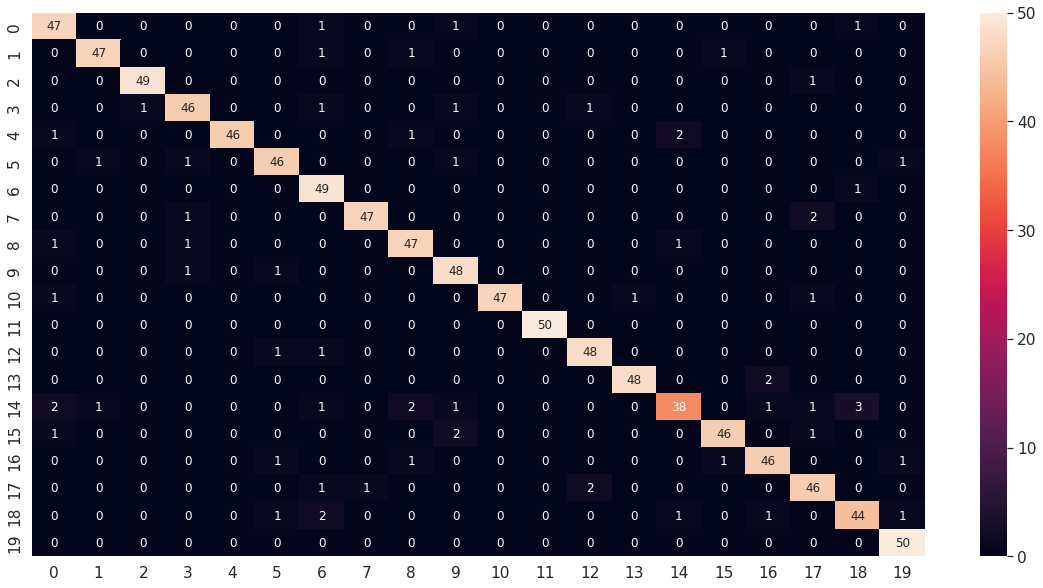

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg1_2_df_CM = pd.DataFrame(deepface_model_vgg1_2_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg1_2_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg1_2_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg1_2_report)

              precision    recall  f1-score   support

           1       0.89      0.94      0.91        50
           2       0.96      0.94      0.95        50
           3       0.98      0.98      0.98        50
           4       0.92      0.92      0.92        50
           5       1.00      0.92      0.96        50
           6       0.92      0.92      0.92        50
           7       0.86      0.98      0.92        50
           8       0.98      0.94      0.96        50
           9       0.90      0.94      0.92        50
          10       0.89      0.96      0.92        50
          11       1.00      0.94      0.97        50
          12       1.00      1.00      1.00        50
          13       0.94      0.96      0.95        50
          14       0.98      0.96      0.97        50
          15       0.90      0.76      0.83        50
          16       0.96      0.92      0.94        50
          17       0.92      0.92      0.92        50
          18       0.88    

#### Modelo 3: (BTH = 30, EHS = 60, ValidSplit = 0.2, Dropout=0, INI = HeNormal, REG = L2, OPT = SGD[0.001, momentum=0.9])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg1_3 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg1_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final dropout y softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg1_3.add(Dropout(rate=0, name='D0'))
deepface_model_vgg1_3.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg1_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)    
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg1_3.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_3.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg1_3 = deepface_model_vgg1_3.fit(new_trainX, new_trainY, batch_size=30, epochs=60, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/60
70/70 [==============================] - 160s 857ms/step - loss: 2.0001 - accuracy: 0.5892 - val_loss: 1.0403 - val_accuracy: 0.8285
Epoch 2/60
70/70 [==============================] - 13s 187ms/step - loss: 0.5737 - accuracy: 0.9691 - val_loss: 0.9117 - val_accuracy: 0.8555
Epoch 3/60
70/70 [==============================] - 13s 185ms/step - loss: 0.4451 - accuracy: 0.9995 - val_loss: 0.8815 - val_accuracy: 0.8709
Epoch 4/60
70/70 [==============================] - 13s 185ms/step - loss: 0.4197 - accuracy: 1.0000 - val_loss: 0.8478 - val_accuracy: 0.8805
Epoch 5/60
70/70 [==============================] - 13s 182ms/step - loss: 0.4041 - accuracy: 1.0000 - val_loss: 0.8312 - val_accuracy: 0.8825
Epoch 6/60
70/70 [==============================] - 13s 183ms/step - loss: 0.3915 - accuracy: 1.0000 - val_loss: 0.8120 - val_accuracy: 0.8844
Epoch 7/60
70/70 [==============================] - 13s 180ms/step - loss: 0.3802 - accuracy: 1.0000 - val_loss: 0.7977 - val_accuracy: 0.890

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg1_3 = load_model(path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_3.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg1_3.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg1_3.evaluate(testX, testY)

32/32 [==============================] - 2s 76ms/step - loss: 0.3656 - accuracy: 0.9260


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg1_3.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg1_3_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 37s 68ms/step


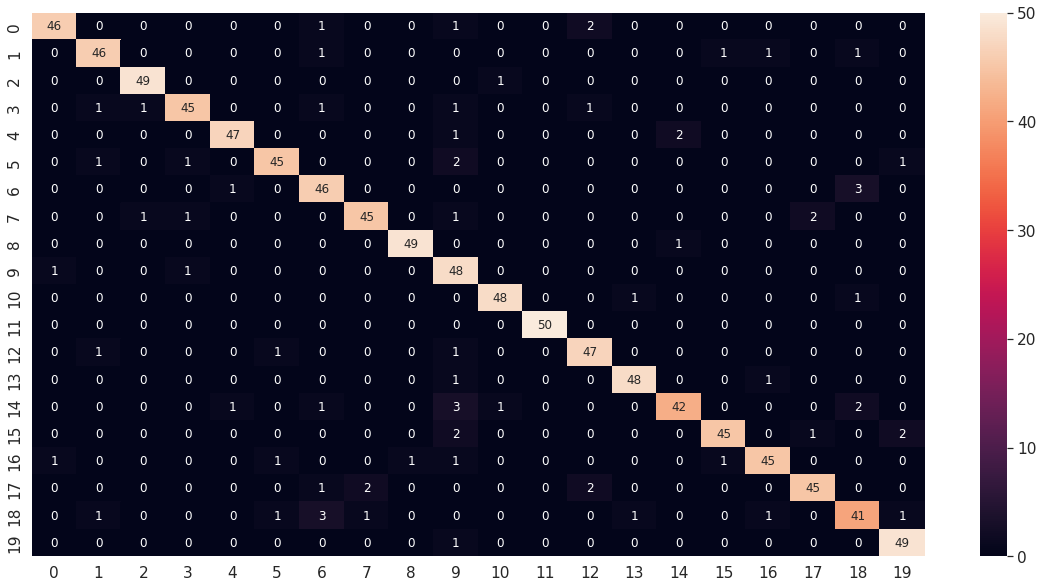

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg1_3_df_CM = pd.DataFrame(deepface_model_vgg1_3_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg1_3_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg1_3_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg1_3_report)

              precision    recall  f1-score   support

           1       0.96      0.92      0.94        50
           2       0.92      0.92      0.92        50
           3       0.96      0.98      0.97        50
           4       0.94      0.90      0.92        50
           5       0.96      0.94      0.95        50
           6       0.94      0.90      0.92        50
           7       0.85      0.92      0.88        50
           8       0.94      0.90      0.92        50
           9       0.98      0.98      0.98        50
          10       0.76      0.96      0.85        50
          11       0.96      0.96      0.96        50
          12       1.00      1.00      1.00        50
          13       0.90      0.94      0.92        50
          14       0.96      0.96      0.96        50
          15       0.93      0.84      0.88        50
          16       0.96      0.90      0.93        50
          17       0.94      0.90      0.92        50
          18       0.94    

#### Modelo 4: (BTH = 10, EHS = 30, ValidSplit = 0.2, INI = HeNormal, Dropout=0.5 REG = L2, OPT = adam[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg1_4 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg1_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg1_4.add(Dropout(rate=0.5, name='D0'))
deepface_model_vgg1_4.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg1_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.001)
deepface_model_vgg1_4.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_4.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg1_4 = deepface_model_vgg1_4.fit(new_trainX, new_trainY, batch_size=10, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
208/208 [==============================] - 150s 287ms/step - loss: 27.1300 - accuracy: 0.3809 - val_loss: 2.2592 - val_accuracy: 0.4162
Epoch 2/30
208/208 [==============================] - 34s 162ms/step - loss: 2.5999 - accuracy: 0.4050 - val_loss: 2.2223 - val_accuracy: 0.4200
Epoch 3/30
208/208 [==============================] - 25s 119ms/step - loss: 2.2341 - accuracy: 0.4286 - val_loss: 2.5894 - val_accuracy: 0.3565
Epoch 4/30
208/208 [==============================] - 23s 111ms/step - loss: 2.6116 - accuracy: 0.3732 - val_loss: 2.5100 - val_accuracy: 0.3565
Epoch 5/30
208/208 [==============================] - 23s 111ms/step - loss: 2.2427 - accuracy: 0.3992 - val_loss: 2.2997 - val_accuracy: 0.3834
Epoch 6/30
208/208 [==============================] - 33s 161ms/step - loss: 2.3031 - accuracy: 0.3934 - val_loss: 2.1670 - val_accuracy: 0.4008
Epoch 7/30
208/208 [==============================] - 24s 117ms/step - loss: 2.5419 - accuracy: 0.3616 - val_loss: 2.4517 - val_

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg1_4 = load_model(path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_4.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg1_4.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg1_4.evaluate(testX, testY)

32/32 [==============================] - 2s 65ms/step - loss: 2.2917 - accuracy: 0.3880


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg1_4.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg1_4_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 37s 63ms/step


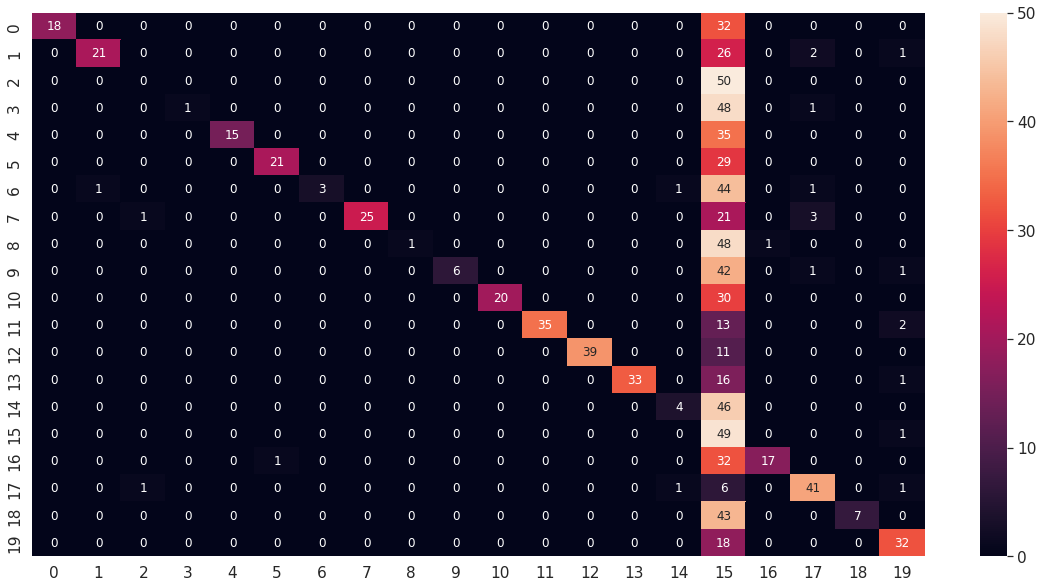

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg1_4_df_CM = pd.DataFrame(deepface_model_vgg1_4_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg1_4_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg1_4_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg1_4_report)

              precision    recall  f1-score   support

           1       1.00      0.36      0.53        50
           2       0.95      0.42      0.58        50
           3       0.00      0.00      0.00        50
           4       1.00      0.02      0.04        50
           5       1.00      0.30      0.46        50
           6       0.95      0.42      0.58        50
           7       1.00      0.06      0.11        50
           8       1.00      0.50      0.67        50
           9       1.00      0.02      0.04        50
          10       1.00      0.12      0.21        50
          11       1.00      0.40      0.57        50
          12       1.00      0.70      0.82        50
          13       1.00      0.78      0.88        50
          14       1.00      0.66      0.80        50
          15       0.67      0.08      0.14        50
          16       0.08      0.98      0.14        50
          17       0.94      0.34      0.50        50
          18       0.84    

#### Modelo 5: (BTH = 20, EHS = 100, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2, OPT = SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg1_5 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg1_5.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 21 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg1_5.add(Dropout(rate=0, name='D0'))
deepface_model_vgg1_5.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg1_5.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg1_5.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_5.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg1_5 = deepface_model_vgg1_5.fit(new_trainX, new_trainY, batch_size=20, epochs=100, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/100
104/104 [==============================] - 143s 475ms/step - loss: 1.5793 - accuracy: 0.7425 - val_loss: 0.9402 - val_accuracy: 0.8536
Epoch 2/100
104/104 [==============================] - 17s 160ms/step - loss: 0.4319 - accuracy: 0.9971 - val_loss: 0.8499 - val_accuracy: 0.8690
Epoch 3/100
104/104 [==============================] - 16s 157ms/step - loss: 0.4023 - accuracy: 1.0000 - val_loss: 0.8010 - val_accuracy: 0.8825
Epoch 4/100
104/104 [==============================] - 16s 156ms/step - loss: 0.3849 - accuracy: 1.0000 - val_loss: 0.7838 - val_accuracy: 0.8863
Epoch 5/100
104/104 [==============================] - 16s 154ms/step - loss: 0.3694 - accuracy: 1.0000 - val_loss: 0.7624 - val_accuracy: 0.8902
Epoch 6/100
104/104 [==============================] - 17s 163ms/step - loss: 0.3548 - accuracy: 1.0000 - val_loss: 0.7468 - val_accuracy: 0.8882
Epoch 7/100
104/104 [==============================] - 17s 163ms/step - loss: 0.3408 - accuracy: 1.0000 - val_loss: 0.7291 

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg1_5 = load_model(path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_5.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg1_5.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg1_5.evaluate(testX, testY)

32/32 [==============================] - 2s 65ms/step - loss: 0.2648 - accuracy: 0.9230


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg1_5.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg1_5_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 36s 62ms/step


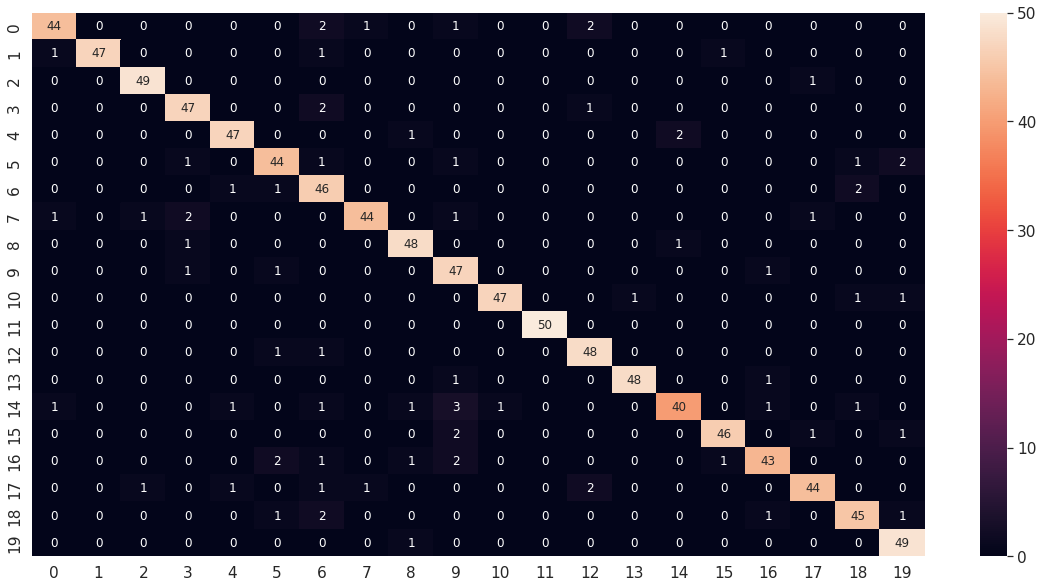

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg1_5_df_CM = pd.DataFrame(deepface_model_vgg1_5_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg1_5_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg1_5_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg1_5_report)

              precision    recall  f1-score   support

           1       0.94      0.88      0.91        50
           2       1.00      0.94      0.97        50
           3       0.96      0.98      0.97        50
           4       0.90      0.94      0.92        50
           5       0.94      0.94      0.94        50
           6       0.88      0.88      0.88        50
           7       0.79      0.92      0.85        50
           8       0.96      0.88      0.92        50
           9       0.92      0.96      0.94        50
          10       0.81      0.94      0.87        50
          11       0.98      0.94      0.96        50
          12       1.00      1.00      1.00        50
          13       0.91      0.96      0.93        50
          14       0.98      0.96      0.97        50
          15       0.93      0.80      0.86        50
          16       0.96      0.92      0.94        50
          17       0.91      0.86      0.89        50
          18       0.94    

#### Modelo 6: (BTH = 20, EHS = 20, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = none, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg1_6 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg1_6.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg1_6.add(Dropout(rate=0, name='D0'))
deepface_model_vgg1_6.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg1_6.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_vgg1_6.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_6.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg1_6 = deepface_model_vgg1_6.fit(new_trainX, new_trainY, batch_size=20, epochs=20, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/20
104/104 [==============================] - 149s 505ms/step - loss: 2.9281 - accuracy: 0.6823 - val_loss: 1.4826 - val_accuracy: 0.6898
Epoch 2/20
104/104 [==============================] - 19s 185ms/step - loss: 0.2052 - accuracy: 0.9479 - val_loss: 1.3475 - val_accuracy: 0.7187
Epoch 3/20
104/104 [==============================] - 19s 186ms/step - loss: 0.0779 - accuracy: 0.9841 - val_loss: 1.3291 - val_accuracy: 0.7457
Epoch 4/20
104/104 [==============================] - 15s 142ms/step - loss: 0.0439 - accuracy: 0.9961 - val_loss: 1.3487 - val_accuracy: 0.7553
Epoch 5/20
104/104 [==============================] - 15s 140ms/step - loss: 0.0318 - accuracy: 0.9986 - val_loss: 1.3317 - val_accuracy: 0.7630
Epoch 6/20
104/104 [==============================] - 14s 135ms/step - loss: 0.0261 - accuracy: 0.9995 - val_loss: 1.3392 - val_accuracy: 0.7649
Epoch 7/20
104/104 [==============================] - 14s 137ms/step - loss: 0.0231 - accuracy: 1.0000 - val_loss: 1.3470 - val_a

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg1_6 = load_model(path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_6.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg1_6.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg1_6.evaluate(testX, testY)

32/32 [==============================] - 2s 71ms/step - loss: 1.3401 - accuracy: 0.7380


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg1_6.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg1_6_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 37s 68ms/step


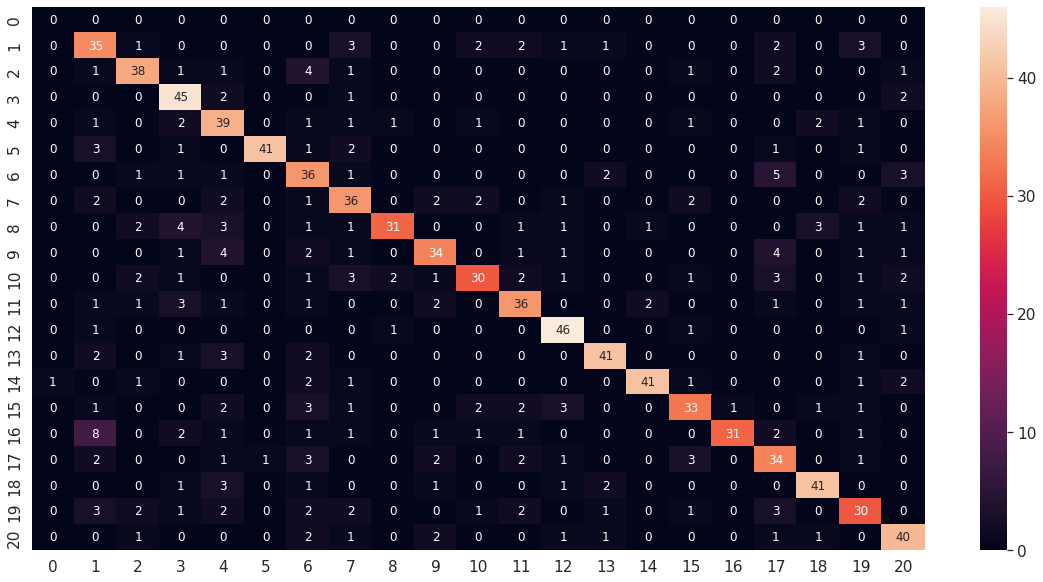

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg1_6_df_CM = pd.DataFrame(deepface_model_vgg1_6_CM, range(21), range(21))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg1_6_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg1_6_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg1_6_report)

#### Modelo 7: (BTH = 30, EHS = 30, ValidSplit = 0.2, INI = none, Dropout=0 REG = L2, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg1_7 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg1_7.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg1_7.add(Dropout(rate=0, name='D0'))
deepface_model_vgg1_7.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg1_7.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)  
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_vgg1_7.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_7.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg1_7 = deepface_model_vgg1_7.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
70/70 [==============================] - 161s 797ms/step - loss: 2.6477 - accuracy: 0.6712 - val_loss: 1.4515 - val_accuracy: 0.6628
Epoch 2/30
70/70 [==============================] - 16s 236ms/step - loss: 0.1977 - accuracy: 0.9479 - val_loss: 1.3929 - val_accuracy: 0.7283
Epoch 3/30
70/70 [==============================] - 17s 239ms/step - loss: 0.0663 - accuracy: 0.9884 - val_loss: 1.3636 - val_accuracy: 0.7322
Epoch 4/30
70/70 [==============================] - 17s 248ms/step - loss: 0.0361 - accuracy: 0.9966 - val_loss: 1.3478 - val_accuracy: 0.7380
Epoch 5/30
70/70 [==============================] - 11s 160ms/step - loss: 0.0261 - accuracy: 0.9986 - val_loss: 1.3514 - val_accuracy: 0.7360
Epoch 6/30
70/70 [==============================] - 11s 161ms/step - loss: 0.0218 - accuracy: 0.9990 - val_loss: 1.3594 - val_accuracy: 0.7437
Epoch 7/30
70/70 [==============================] - 11s 155ms/step - loss: 0.0193 - accuracy: 0.9995 - val_loss: 1.3654 - val_accuracy: 0.745

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg1_7 = load_model(path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_7.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg1_7.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg1_7.evaluate(testX, testY)

32/32 [==============================] - 2s 70ms/step - loss: 1.3269 - accuracy: 0.7220


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg1_7.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg1_7_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 40s 67ms/step


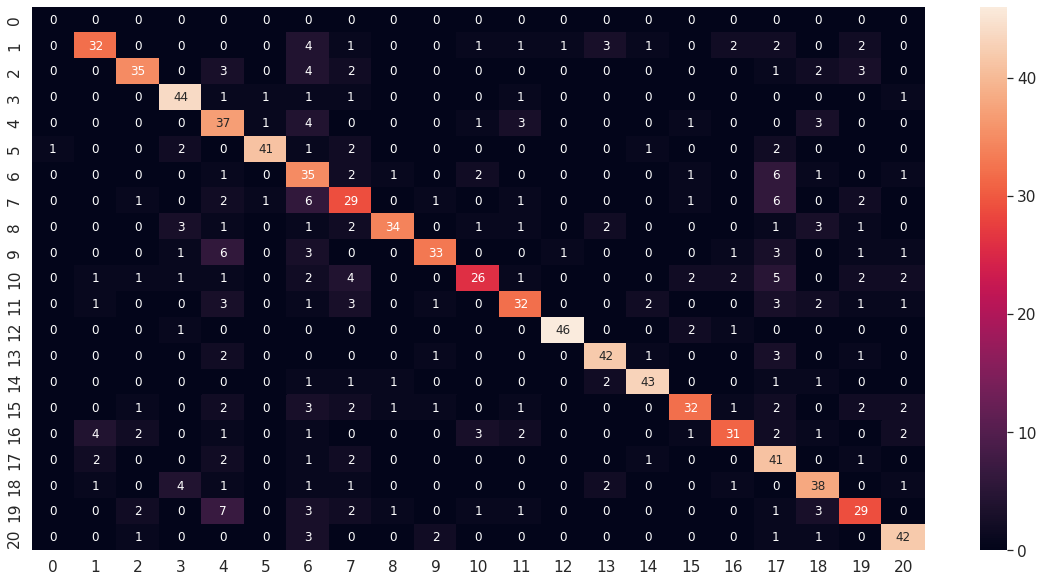

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg1_7_df_CM = pd.DataFrame(deepface_model_vgg1_7_CM, range(21), range(21))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg1_7_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg1_7_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg1_7_report)

#### Modelo 8: (BTH = 20, EHS = 30, ValidSplit = 0.2, INI = HeNormal, Dropout=0.5 REG = none, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg1_8 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg1_8.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg1_8.add(Dropout(rate=0.5, name='D0'))
deepface_model_vgg1_8.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg1_8.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)  
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_vgg1_8.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_8.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg1_8 = deepface_model_vgg1_8.fit(new_trainX, new_trainY, batch_size=20, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
104/104 [==============================] - 155s 530ms/step - loss: 4.1356 - accuracy: 0.3399 - val_loss: 1.7012 - val_accuracy: 0.5703
Epoch 2/30
104/104 [==============================] - 20s 191ms/step - loss: 1.4276 - accuracy: 0.5945 - val_loss: 1.3395 - val_accuracy: 0.6705
Epoch 3/30
104/104 [==============================] - 20s 191ms/step - loss: 1.0397 - accuracy: 0.7035 - val_loss: 1.1533 - val_accuracy: 0.7033
Epoch 4/30
104/104 [==============================] - 20s 192ms/step - loss: 0.7052 - accuracy: 0.7941 - val_loss: 1.0020 - val_accuracy: 0.7418
Epoch 5/30
104/104 [==============================] - 20s 193ms/step - loss: 0.4753 - accuracy: 0.8650 - val_loss: 0.9219 - val_accuracy: 0.7514
Epoch 6/30
104/104 [==============================] - 20s 193ms/step - loss: 0.3776 - accuracy: 0.8891 - val_loss: 0.8666 - val_accuracy: 0.7688
Epoch 7/30
104/104 [==============================] - 15s 143ms/step - loss: 0.3346 - accuracy: 0.9045 - val_loss: 0.8683 - val_a

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg1_8 = load_model(path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_8.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg1_8.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg1_8.evaluate(testX, testY)

32/32 [==============================] - 2s 76ms/step - loss: 0.7692 - accuracy: 0.8320


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg1_8.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg1_8_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 45s 67ms/step


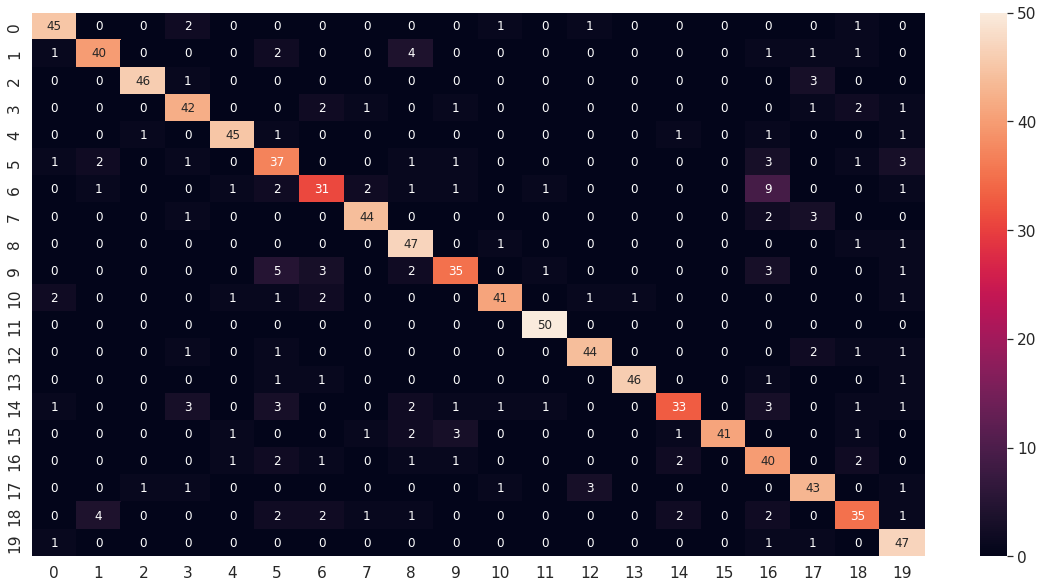

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg1_8_df_CM = pd.DataFrame(deepface_model_vgg1_8_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg1_8_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg1_8_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg1_8_report)

              precision    recall  f1-score   support

           1       0.88      0.90      0.89        50
           2       0.85      0.80      0.82        50
           3       0.96      0.92      0.94        50
           4       0.81      0.84      0.82        50
           5       0.92      0.90      0.91        50
           6       0.65      0.74      0.69        50
           7       0.74      0.62      0.67        50
           8       0.90      0.88      0.89        50
           9       0.77      0.94      0.85        50
          10       0.81      0.70      0.75        50
          11       0.91      0.82      0.86        50
          12       0.94      1.00      0.97        50
          13       0.90      0.88      0.89        50
          14       0.98      0.92      0.95        50
          15       0.85      0.66      0.74        50
          16       1.00      0.82      0.90        50
          17       0.61      0.80      0.69        50
          18       0.80    

#### Modelo 9: (BTH = 40, EHS = 60, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg1_9 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg1_9.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg1_9.add(Dropout(rate=0, name='D0'))
deepface_model_vgg1_9.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg1_9.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_vgg1_9.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_9.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg1_9 = deepface_model_vgg1_9.fit(new_trainX, new_trainY, batch_size=40, epochs=60, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/60
52/52 [==============================] - 141s 917ms/step - loss: 2.4320 - accuracy: 0.6350 - val_loss: 0.9727 - val_accuracy: 0.8015
Epoch 2/60
52/52 [==============================] - 14s 265ms/step - loss: 0.3566 - accuracy: 0.9889 - val_loss: 0.8416 - val_accuracy: 0.8478
Epoch 3/60
52/52 [==============================] - 14s 264ms/step - loss: 0.3027 - accuracy: 1.0000 - val_loss: 0.7864 - val_accuracy: 0.8478
Epoch 4/60
52/52 [==============================] - 15s 288ms/step - loss: 0.2887 - accuracy: 1.0000 - val_loss: 0.7692 - val_accuracy: 0.8536
Epoch 5/60
52/52 [==============================] - 14s 264ms/step - loss: 0.2781 - accuracy: 1.0000 - val_loss: 0.7487 - val_accuracy: 0.8536
Epoch 6/60
52/52 [==============================] - 14s 267ms/step - loss: 0.2685 - accuracy: 1.0000 - val_loss: 0.7362 - val_accuracy: 0.8536
Epoch 7/60
52/52 [==============================] - 14s 278ms/step - loss: 0.2594 - accuracy: 1.0000 - val_loss: 0.7227 - val_accuracy: 0.851

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg1_9 = load_model(path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_9.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg1_9.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg1_9.evaluate(testX, testY)

32/32 [==============================] - 2s 66ms/step - loss: 0.5088 - accuracy: 0.8830


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg1_9.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg1_9_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

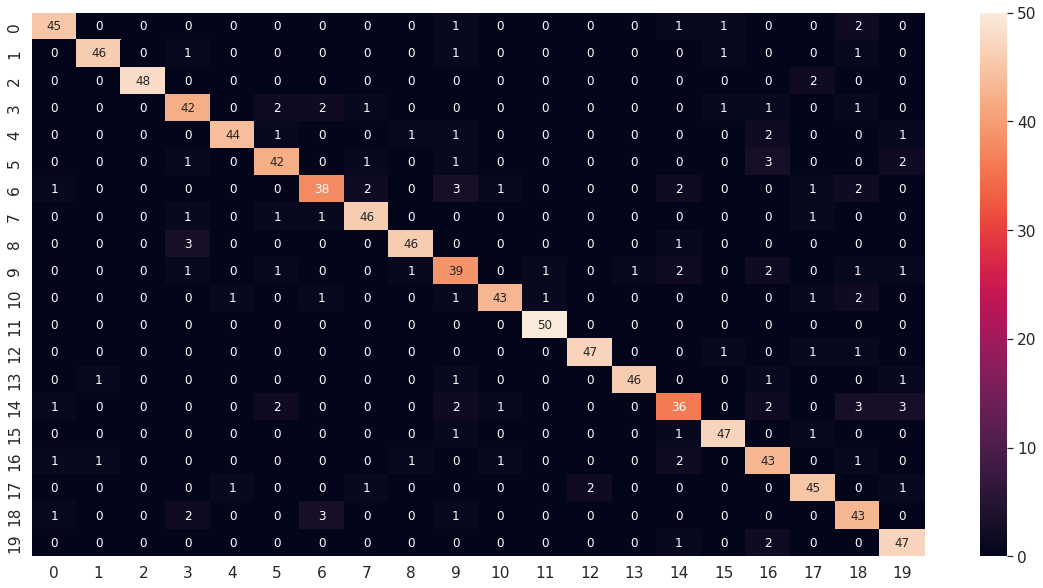

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg1_9_df_CM = pd.DataFrame(deepface_model_vgg1_9_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg1_9_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg1_9_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg1_9_report)

              precision    recall  f1-score   support

           1       0.92      0.90      0.91        50
           2       0.96      0.92      0.94        50
           3       1.00      0.96      0.98        50
           4       0.82      0.84      0.83        50
           5       0.96      0.88      0.92        50
           6       0.86      0.84      0.85        50
           7       0.84      0.76      0.80        50
           8       0.90      0.92      0.91        50
           9       0.94      0.92      0.93        50
          10       0.75      0.78      0.76        50
          11       0.93      0.86      0.90        50
          12       0.96      1.00      0.98        50
          13       0.96      0.94      0.95        50
          14       0.98      0.92      0.95        50
          15       0.78      0.72      0.75        50
          16       0.92      0.94      0.93        50
          17       0.77      0.86      0.81        50
          18       0.87    

#### Modelo 10: (BTH = 40, EHS = 100, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg1_10 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg1_10.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg1_10.add(Dropout(rate=0, name='D0'))
deepface_model_vgg1_10.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg1_10.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg1_10.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_10.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg1_10 = deepface_model_vgg1_10.fit(new_trainX, new_trainY, batch_size=40, epochs=100, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/100
52/52 [==============================] - 137s 857ms/step - loss: 1.3517 - accuracy: 0.8597 - val_loss: 1.6590 - val_accuracy: 0.8285
Epoch 2/100
52/52 [==============================] - 12s 238ms/step - loss: 0.4354 - accuracy: 0.9981 - val_loss: 1.5445 - val_accuracy: 0.8266
Epoch 3/100
52/52 [==============================] - 12s 228ms/step - loss: 0.4214 - accuracy: 1.0000 - val_loss: 1.5143 - val_accuracy: 0.8285
Epoch 4/100
52/52 [==============================] - 12s 228ms/step - loss: 0.4126 - accuracy: 1.0000 - val_loss: 1.4930 - val_accuracy: 0.8285
Epoch 5/100
52/52 [==============================] - 12s 227ms/step - loss: 0.4041 - accuracy: 1.0000 - val_loss: 1.4722 - val_accuracy: 0.8266
Epoch 6/100
52/52 [==============================] - 12s 231ms/step - loss: 0.3958 - accuracy: 1.0000 - val_loss: 1.4525 - val_accuracy: 0.8285
Epoch 7/100
52/52 [==============================] - 12s 225ms/step - loss: 0.3876 - accuracy: 1.0000 - val_loss: 1.4335 - val_accuracy

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg1_10 = load_model(path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_10.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg1_10.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg1_10.evaluate(testX, testY)

32/32 [==============================] - 2s 65ms/step - loss: 0.4915 - accuracy: 0.8850


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg1_10.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg1_10_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 35s 63ms/step


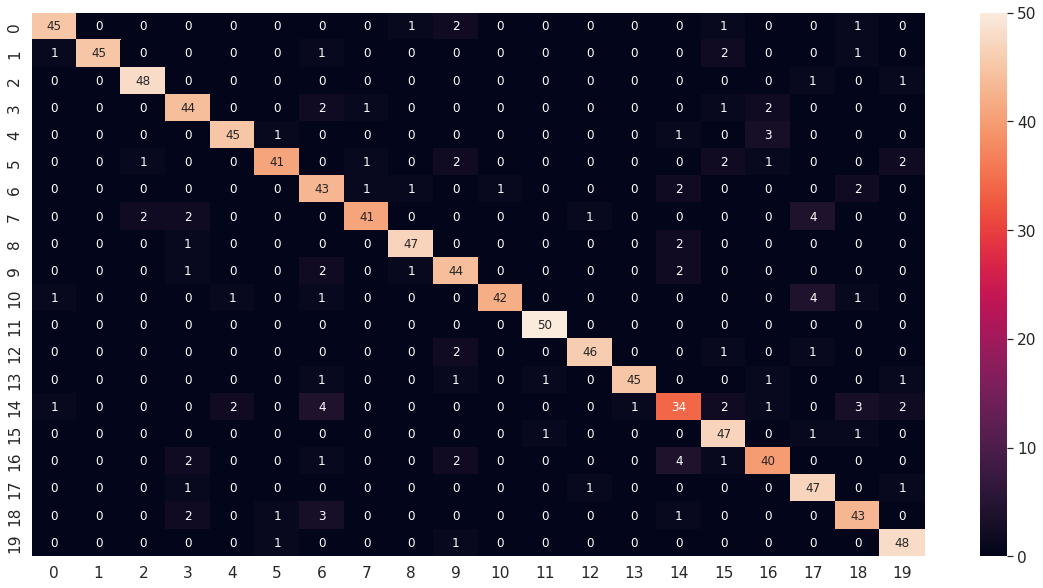

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg1_10_df_CM = pd.DataFrame(deepface_model_vgg1_10_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg1_10_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg1_10_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg1_10_report)

              precision    recall  f1-score   support

           1       0.94      0.90      0.92        50
           2       1.00      0.90      0.95        50
           3       0.94      0.96      0.95        50
           4       0.83      0.88      0.85        50
           5       0.94      0.90      0.92        50
           6       0.93      0.82      0.87        50
           7       0.74      0.86      0.80        50
           8       0.93      0.82      0.87        50
           9       0.94      0.94      0.94        50
          10       0.81      0.88      0.85        50
          11       0.98      0.84      0.90        50
          12       0.96      1.00      0.98        50
          13       0.96      0.92      0.94        50
          14       0.98      0.90      0.94        50
          15       0.74      0.68      0.71        50
          16       0.82      0.94      0.88        50
          17       0.83      0.80      0.82        50
          18       0.81    

#### Modelo 11: (BTH = 20, EHS = 40, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg1_11 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg1_11.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg1_11.add(Dropout(rate=0, name='D0'))
deepface_model_vgg1_11.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg1_11.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_vgg1_11.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_11.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg1_11 = deepface_model_vgg1_11.fit(new_trainX, new_trainY, batch_size=20, epochs=40, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/40
104/104 [==============================] - 159s 505ms/step - loss: 1.7970 - accuracy: 0.6615 - val_loss: 1.0248 - val_accuracy: 0.7996
Epoch 2/40
104/104 [==============================] - 19s 180ms/step - loss: 0.3282 - accuracy: 0.9894 - val_loss: 0.8957 - val_accuracy: 0.8478
Epoch 3/40
104/104 [==============================] - 19s 179ms/step - loss: 0.2748 - accuracy: 1.0000 - val_loss: 0.8136 - val_accuracy: 0.8574
Epoch 4/40
104/104 [==============================] - 19s 179ms/step - loss: 0.2590 - accuracy: 1.0000 - val_loss: 0.7995 - val_accuracy: 0.8593
Epoch 5/40
104/104 [==============================] - 19s 181ms/step - loss: 0.2457 - accuracy: 1.0000 - val_loss: 0.7842 - val_accuracy: 0.8555
Epoch 6/40
104/104 [==============================] - 19s 183ms/step - loss: 0.2330 - accuracy: 1.0000 - val_loss: 0.7695 - val_accuracy: 0.8574
Epoch 7/40
104/104 [==============================] - 19s 181ms/step - loss: 0.2208 - accuracy: 1.0000 - val_loss: 0.7625 - val_a

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg1_11 = load_model(path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_11.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg1_11.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg1_11.evaluate(testX, testY)

32/32 [==============================] - 2s 68ms/step - loss: 0.4540 - accuracy: 0.8820


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg1_11.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg1_11_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 33s 61ms/step


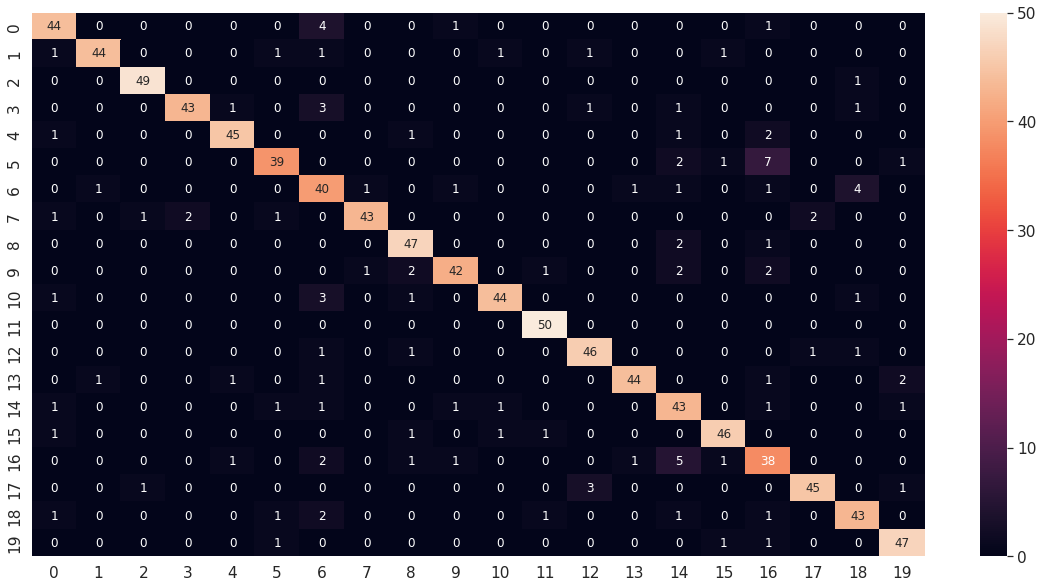

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg1_11_df_CM = pd.DataFrame(deepface_model_vgg1_11_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg1_11_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg1_11_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg1_11_report)

              precision    recall  f1-score   support

           1       0.86      0.88      0.87        50
           2       0.96      0.88      0.92        50
           3       0.96      0.98      0.97        50
           4       0.96      0.86      0.91        50
           5       0.94      0.90      0.92        50
           6       0.89      0.78      0.83        50
           7       0.69      0.80      0.74        50
           8       0.96      0.86      0.91        50
           9       0.87      0.94      0.90        50
          10       0.91      0.84      0.87        50
          11       0.94      0.88      0.91        50
          12       0.94      1.00      0.97        50
          13       0.90      0.92      0.91        50
          14       0.96      0.88      0.92        50
          15       0.74      0.86      0.80        50
          16       0.92      0.92      0.92        50
          17       0.68      0.76      0.72        50
          18       0.94    

#### Modelo 12: (BTH = 20, EHS = 40, ValidSplit = 0.2, INI = HeNormal, Dropout=0.5 REG = L2 none, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg1_12 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg1_12.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg1_12.add(Dropout(rate=0.5, name='D0'))
deepface_model_vgg1_12.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg1_12.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_vgg1_12.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_12.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg1_12 = deepface_model_vgg1_12.fit(new_trainX, new_trainY, batch_size=20, epochs=40, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/40
104/104 [==============================] - 146s 495ms/step - loss: 2.3648 - accuracy: 0.6847 - val_loss: 0.9403 - val_accuracy: 0.8035
Epoch 2/40
104/104 [==============================] - 19s 184ms/step - loss: 0.3412 - accuracy: 0.9662 - val_loss: 0.8361 - val_accuracy: 0.8439
Epoch 3/40
104/104 [==============================] - 18s 176ms/step - loss: 0.2480 - accuracy: 0.9937 - val_loss: 0.7820 - val_accuracy: 0.8536
Epoch 4/40
104/104 [==============================] - 14s 136ms/step - loss: 0.2290 - accuracy: 0.9990 - val_loss: 0.8418 - val_accuracy: 0.8459
Epoch 5/40
104/104 [==============================] - 14s 133ms/step - loss: 0.2227 - accuracy: 0.9990 - val_loss: 0.7962 - val_accuracy: 0.8516
Epoch 6/40
104/104 [==============================] - 13s 130ms/step - loss: 0.2166 - accuracy: 0.9995 - val_loss: 0.8265 - val_accuracy: 0.8439
Epoch 7/40
104/104 [==============================] - 13s 129ms/step - loss: 0.2115 - accuracy: 0.9976 - val_loss: 0.7956 - val_a

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg1_12 = load_model(path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_12.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg1_12.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg1_12.evaluate(testX, testY)

32/32 [==============================] - 2s 64ms/step - loss: 0.5674 - accuracy: 0.8830


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg1_12.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg1_12_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 42s 62ms/step


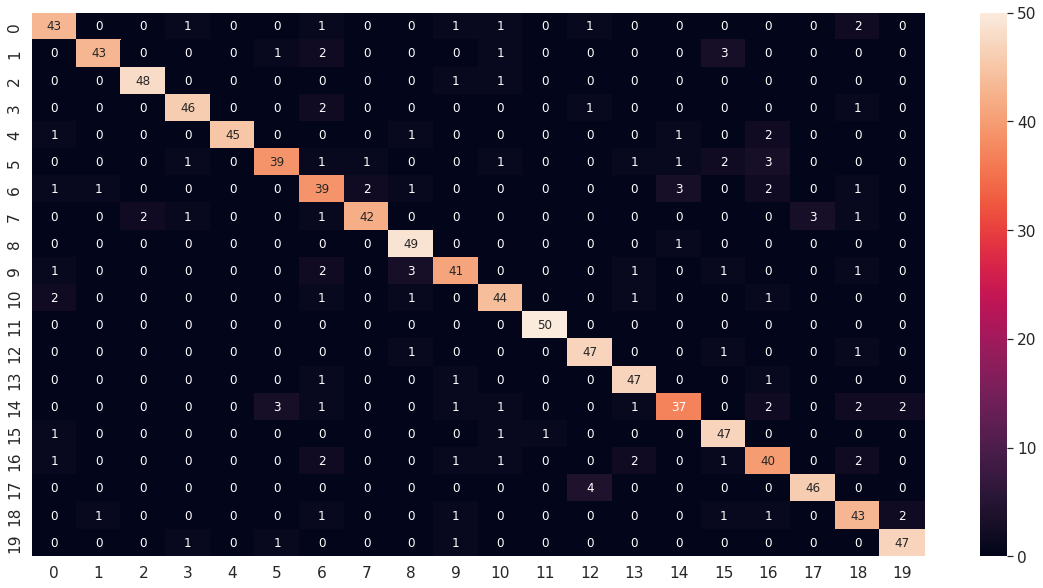

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg1_12_df_CM = pd.DataFrame(deepface_model_vgg1_12_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg1_12_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg1_12_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg1_12_report)

              precision    recall  f1-score   support

           1       0.86      0.86      0.86        50
           2       0.96      0.86      0.91        50
           3       0.96      0.96      0.96        50
           4       0.92      0.92      0.92        50
           5       1.00      0.90      0.95        50
           6       0.89      0.78      0.83        50
           7       0.72      0.78      0.75        50
           8       0.93      0.84      0.88        50
           9       0.88      0.98      0.92        50
          10       0.85      0.82      0.84        50
          11       0.86      0.88      0.87        50
          12       0.98      1.00      0.99        50
          13       0.89      0.94      0.91        50
          14       0.89      0.94      0.91        50
          15       0.86      0.74      0.80        50
          16       0.84      0.94      0.89        50
          17       0.77      0.80      0.78        50
          18       0.94    

#### Modelo 13: (BTH = 20, EHS = 60, ValidSplit = 0.2, Dropout = 0, INI = HeNormal, Dropout=0, REG = L2, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg1_13 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg1_13.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg1_13.add(Dropout(rate=0, name='D0'))
deepface_model_vgg1_13.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg1_13.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_vgg1_13.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_13.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg1_13 = deepface_model_vgg1_13.fit(new_trainX, new_trainY, batch_size=20, epochs=60, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/60
104/104 [==============================] - 144s 491ms/step - loss: 1.0994 - accuracy: 0.8544 - val_loss: 1.1770 - val_accuracy: 0.7977
Epoch 2/60
104/104 [==============================] - 19s 184ms/step - loss: 0.2311 - accuracy: 0.9957 - val_loss: 0.9996 - val_accuracy: 0.8150
Epoch 3/60
104/104 [==============================] - 19s 187ms/step - loss: 0.2062 - accuracy: 1.0000 - val_loss: 0.9572 - val_accuracy: 0.8285
Epoch 4/60
104/104 [==============================] - 14s 137ms/step - loss: 0.1977 - accuracy: 1.0000 - val_loss: 0.9691 - val_accuracy: 0.8285
Epoch 5/60
104/104 [==============================] - 14s 132ms/step - loss: 0.1901 - accuracy: 1.0000 - val_loss: 0.9843 - val_accuracy: 0.8304
Epoch 6/60
104/104 [==============================] - 13s 129ms/step - loss: 0.1829 - accuracy: 1.0000 - val_loss: 1.0029 - val_accuracy: 0.8285
Epoch 7/60
104/104 [==============================] - 13s 129ms/step - loss: 0.1758 - accuracy: 1.0000 - val_loss: 1.0098 - val_a

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg1_13 = load_model(path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_13.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg1_13.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg1_13.evaluate(testX, testY)

32/32 [==============================] - 2s 64ms/step - loss: 0.5941 - accuracy: 0.8700


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg1_13.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg1_13_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 32s 63ms/step


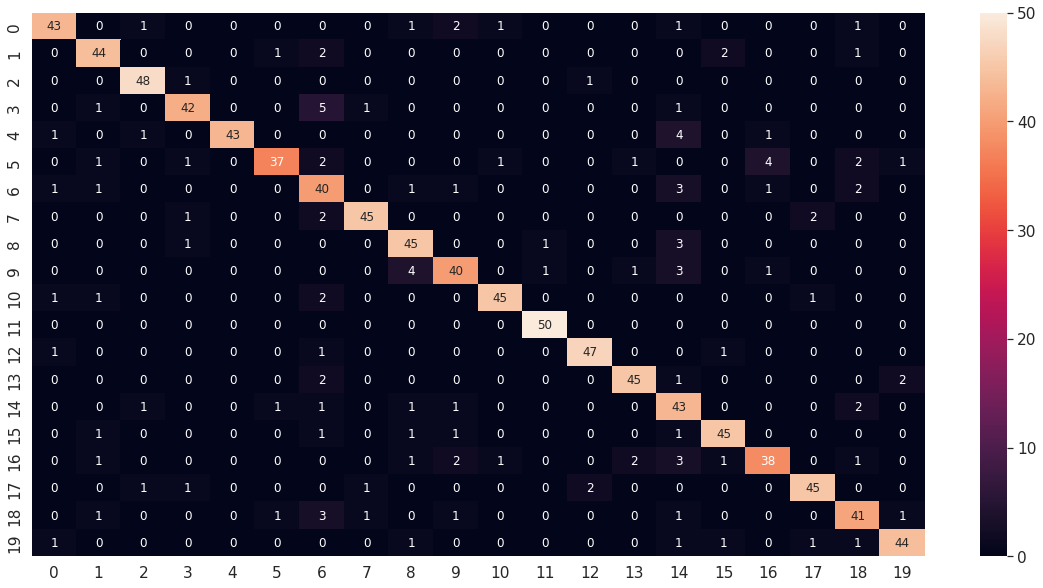

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg1_13_df_CM = pd.DataFrame(deepface_model_vgg1_13_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg1_13_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg1_13_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg1_13_report)

              precision    recall  f1-score   support

           1       0.90      0.86      0.88        50
           2       0.86      0.88      0.87        50
           3       0.92      0.96      0.94        50
           4       0.89      0.84      0.87        50
           5       1.00      0.86      0.92        50
           6       0.93      0.74      0.82        50
           7       0.66      0.80      0.72        50
           8       0.94      0.90      0.92        50
           9       0.82      0.90      0.86        50
          10       0.83      0.80      0.82        50
          11       0.94      0.90      0.92        50
          12       0.96      1.00      0.98        50
          13       0.94      0.94      0.94        50
          14       0.92      0.90      0.91        50
          15       0.66      0.86      0.75        50
          16       0.90      0.90      0.90        50
          17       0.84      0.76      0.80        50
          18       0.92    

#### Modelo 14: (BTH = 40, EHS = 30, ValidSplit = 0.2, INI = HeNormal, Dropout=0.7 REG = L2 none, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg1_14 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg1_14.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg1_14.add(Dropout(rate=0, name='D0'))
deepface_model_vgg1_14.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg1_14.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_vgg1_14.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_14.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg1_14 = deepface_model_vgg1_14.fit(new_trainX, new_trainY, batch_size=40, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
52/52 [==============================] - 140s 868ms/step - loss: 2.0271 - accuracy: 0.6205 - val_loss: 1.0805 - val_accuracy: 0.7746
Epoch 2/30
52/52 [==============================] - 14s 267ms/step - loss: 0.3742 - accuracy: 0.9846 - val_loss: 0.8650 - val_accuracy: 0.8324
Epoch 3/30
52/52 [==============================] - 13s 257ms/step - loss: 0.3034 - accuracy: 0.9995 - val_loss: 0.8209 - val_accuracy: 0.8459
Epoch 4/30
52/52 [==============================] - 13s 258ms/step - loss: 0.2871 - accuracy: 1.0000 - val_loss: 0.7949 - val_accuracy: 0.8516
Epoch 5/30
52/52 [==============================] - 13s 258ms/step - loss: 0.2749 - accuracy: 1.0000 - val_loss: 0.7807 - val_accuracy: 0.8536
Epoch 6/30
52/52 [==============================] - 13s 257ms/step - loss: 0.2639 - accuracy: 1.0000 - val_loss: 0.7677 - val_accuracy: 0.8536
Epoch 7/30
52/52 [==============================] - 13s 258ms/step - loss: 0.2535 - accuracy: 1.0000 - val_loss: 0.7559 - val_accuracy: 0.857

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg1_14 = load_model(path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_14.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg1_14.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg1_14.evaluate(testX, testY)

32/32 [==============================] - 2s 68ms/step - loss: 0.5687 - accuracy: 0.8840


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg1_14.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg1_14_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 35s 62ms/step


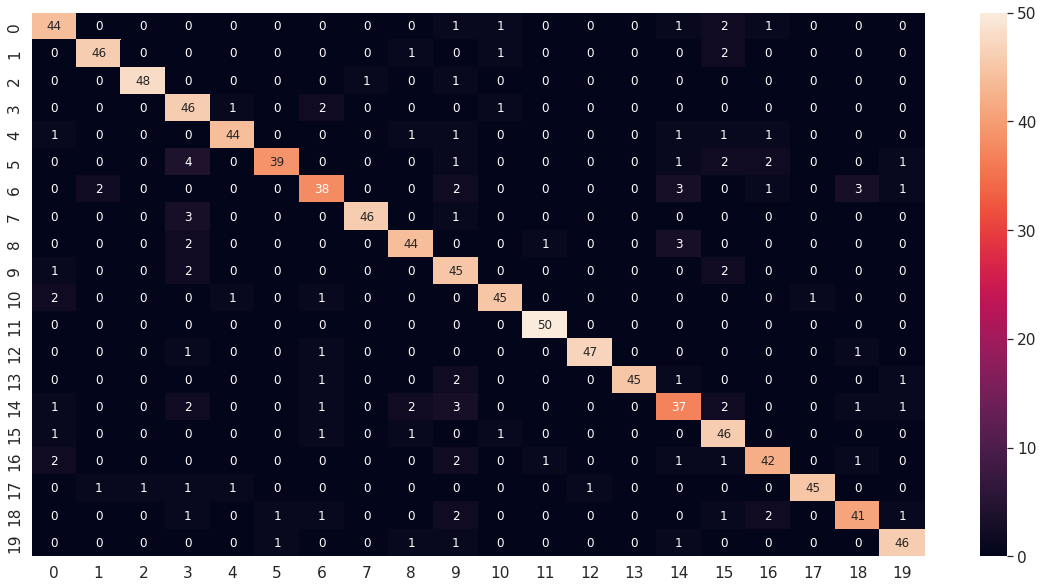

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg1_14_df_CM = pd.DataFrame(deepface_model_vgg1_14_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg1_14_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg1_14_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg1_14_report)

              precision    recall  f1-score   support

           1       0.85      0.88      0.86        50
           2       0.94      0.92      0.93        50
           3       0.98      0.96      0.97        50
           4       0.74      0.92      0.82        50
           5       0.94      0.88      0.91        50
           6       0.95      0.78      0.86        50
           7       0.83      0.76      0.79        50
           8       0.98      0.92      0.95        50
           9       0.88      0.88      0.88        50
          10       0.73      0.90      0.80        50
          11       0.92      0.90      0.91        50
          12       0.96      1.00      0.98        50
          13       0.98      0.94      0.96        50
          14       1.00      0.90      0.95        50
          15       0.76      0.74      0.75        50
          16       0.78      0.92      0.84        50
          17       0.86      0.84      0.85        50
          18       0.98    

#### Modelo 15: (BTH = 40, EHS = 50, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg1_15 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg1_15.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg1_15.add(Dropout(rate=0, name='D0'))
deepface_model_vgg1_15.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg1_15.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg1_15.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_15.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg1_15 = deepface_model_vgg1_15.fit(new_trainX, new_trainY, batch_size=40, epochs=50, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/50
52/52 [==============================] - 138s 829ms/step - loss: 2.1082 - accuracy: 0.5477 - val_loss: 1.1345 - val_accuracy: 0.8092
Epoch 2/50
52/52 [==============================] - 11s 218ms/step - loss: 0.6457 - accuracy: 0.9474 - val_loss: 0.9464 - val_accuracy: 0.8555
Epoch 3/50
52/52 [==============================] - 11s 215ms/step - loss: 0.4808 - accuracy: 0.9947 - val_loss: 0.8695 - val_accuracy: 0.8767
Epoch 4/50
52/52 [==============================] - 11s 216ms/step - loss: 0.4391 - accuracy: 0.9995 - val_loss: 0.8515 - val_accuracy: 0.8882
Epoch 5/50
52/52 [==============================] - 11s 221ms/step - loss: 0.4209 - accuracy: 1.0000 - val_loss: 0.8400 - val_accuracy: 0.8882
Epoch 6/50
52/52 [==============================] - 11s 213ms/step - loss: 0.4087 - accuracy: 1.0000 - val_loss: 0.8258 - val_accuracy: 0.8902
Epoch 7/50
52/52 [==============================] - 11s 210ms/step - loss: 0.3984 - accuracy: 1.0000 - val_loss: 0.8112 - val_accuracy: 0.890

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg1_15 = load_model(path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_15.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg1_15.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg1_15.evaluate(testX, testY)

32/32 [==============================] - 2s 72ms/step - loss: 0.4561 - accuracy: 0.9210


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg1_15.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg1_15_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 35s 66ms/step


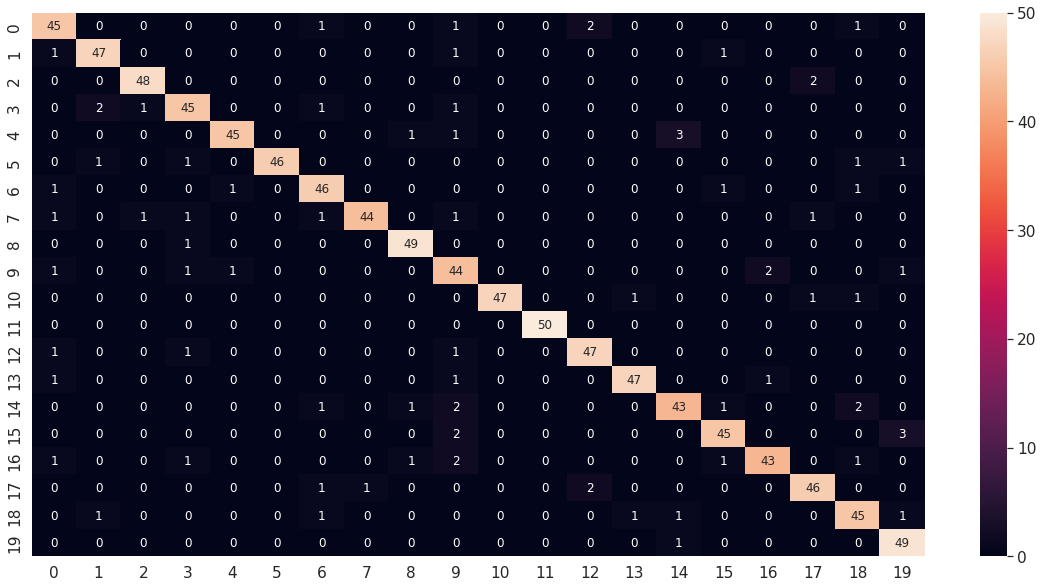

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg1_15_df_CM = pd.DataFrame(deepface_model_vgg1_15_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg1_15_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg1_15_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg1_15_report)

              precision    recall  f1-score   support

           1       0.87      0.90      0.88        50
           2       0.92      0.94      0.93        50
           3       0.96      0.96      0.96        50
           4       0.88      0.90      0.89        50
           5       0.96      0.90      0.93        50
           6       1.00      0.92      0.96        50
           7       0.88      0.92      0.90        50
           8       0.98      0.88      0.93        50
           9       0.94      0.98      0.96        50
          10       0.77      0.88      0.82        50
          11       1.00      0.94      0.97        50
          12       1.00      1.00      1.00        50
          13       0.92      0.94      0.93        50
          14       0.96      0.94      0.95        50
          15       0.90      0.86      0.88        50
          16       0.92      0.90      0.91        50
          17       0.93      0.86      0.90        50
          18       0.92    

#### Modelo 16: (BTH = 40, EHS = 80, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg1_16 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg1_16.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg1_16.add(Dropout(rate=0, name='D0'))
deepface_model_vgg1_16.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg1_16.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg1_16.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_16.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg1_16 = deepface_model_vgg1_16.fit(new_trainX, new_trainY, batch_size=40, epochs=80, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/80
52/52 [==============================] - 138s 848ms/step - loss: 1.8360 - accuracy: 0.6408 - val_loss: 0.9555 - val_accuracy: 0.8516
Epoch 2/80
52/52 [==============================] - 13s 242ms/step - loss: 0.4951 - accuracy: 0.9889 - val_loss: 0.8791 - val_accuracy: 0.8902
Epoch 3/80
52/52 [==============================] - 12s 228ms/step - loss: 0.4356 - accuracy: 0.9990 - val_loss: 0.8443 - val_accuracy: 0.8863
Epoch 4/80
52/52 [==============================] - 12s 225ms/step - loss: 0.4168 - accuracy: 1.0000 - val_loss: 0.8312 - val_accuracy: 0.8882
Epoch 5/80
52/52 [==============================] - 12s 224ms/step - loss: 0.4064 - accuracy: 1.0000 - val_loss: 0.8233 - val_accuracy: 0.8902
Epoch 6/80
52/52 [==============================] - 12s 225ms/step - loss: 0.3972 - accuracy: 1.0000 - val_loss: 0.8091 - val_accuracy: 0.8921
Epoch 7/80
52/52 [==============================] - 12s 230ms/step - loss: 0.3887 - accuracy: 1.0000 - val_loss: 0.7972 - val_accuracy: 0.896

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg1_16 = load_model(path + 'data_reconocimiento2/models_VGG1/deepface_model_VGG1_16.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg1_16.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg1_16.evaluate(testX, testY)

32/32 [==============================] - 2s 66ms/step - loss: 0.3723 - accuracy: 0.9210


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg1_16.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg1_16_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 36s 62ms/step


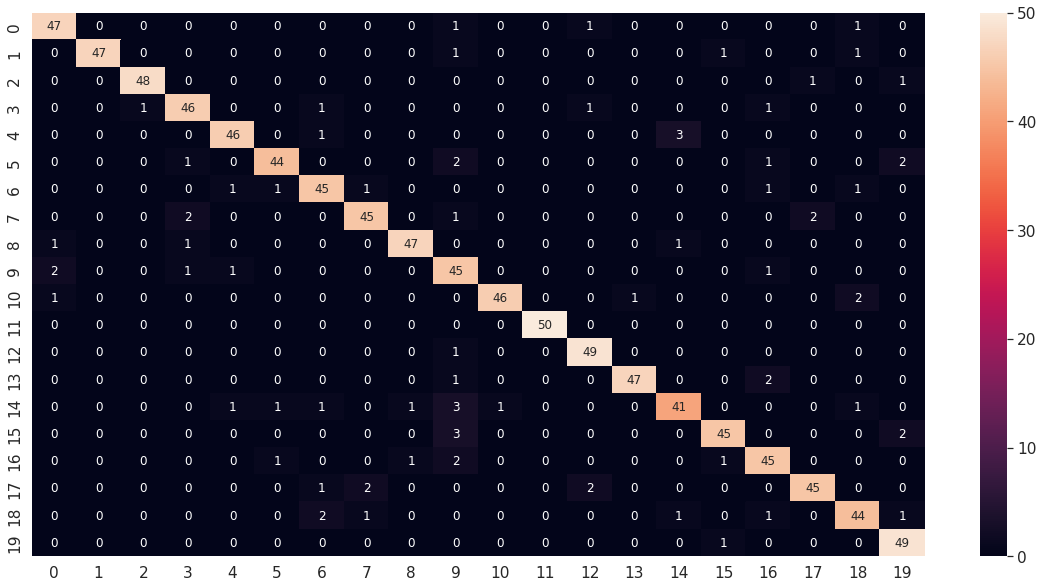

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg1_16_df_CM = pd.DataFrame(deepface_model_vgg1_16_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg1_16_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg1_16_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg1_16_report)

              precision    recall  f1-score   support

           1       0.92      0.94      0.93        50
           2       1.00      0.94      0.97        50
           3       0.98      0.96      0.97        50
           4       0.90      0.92      0.91        50
           5       0.94      0.92      0.93        50
           6       0.94      0.88      0.91        50
           7       0.88      0.90      0.89        50
           8       0.92      0.90      0.91        50
           9       0.96      0.94      0.95        50
          10       0.75      0.90      0.82        50
          11       0.98      0.92      0.95        50
          12       1.00      1.00      1.00        50
          13       0.92      0.98      0.95        50
          14       0.98      0.94      0.96        50
          15       0.89      0.82      0.85        50
          16       0.94      0.90      0.92        50
          17       0.87      0.90      0.88        50
          18       0.94    

## 8. Modelos con base de datos VGG-Asian para condiciones de etnia

#### Modelo 1: (BTH = 10, EHS = 60, ValidSplit = 0.2, Dropout=0, INI = HeNormal, REG = L2, OPT = SGD[0.001, momentum=0.9])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg2_1 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg2_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final dropout y softmax de 11 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg2_1.add(Dropout(rate=0, name='D0'))
deepface_model_vgg2_1.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg2_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)    
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg2_1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_1.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg2_1 = deepface_model_vgg2_1.fit(new_trainX, new_trainY, batch_size=10, epochs=60, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/60
214/214 [==============================] - 148s 265ms/step - loss: 2.2345 - accuracy: 0.6286 - val_loss: 1.1484 - val_accuracy: 0.7996
Epoch 2/60
214/214 [==============================] - 26s 120ms/step - loss: 0.4827 - accuracy: 0.9813 - val_loss: 0.9785 - val_accuracy: 0.8165
Epoch 3/60
214/214 [==============================] - 26s 120ms/step - loss: 0.3858 - accuracy: 1.0000 - val_loss: 0.8968 - val_accuracy: 0.8521
Epoch 4/60
214/214 [==============================] - 27s 124ms/step - loss: 0.3528 - accuracy: 1.0000 - val_loss: 0.8631 - val_accuracy: 0.8633
Epoch 5/60
214/214 [==============================] - 27s 126ms/step - loss: 0.3251 - accuracy: 1.0000 - val_loss: 0.8321 - val_accuracy: 0.8633
Epoch 6/60
214/214 [==============================] - 27s 125ms/step - loss: 0.3001 - accuracy: 1.0000 - val_loss: 0.8020 - val_accuracy: 0.8633
Epoch 7/60
214/214 [==============================] - 27s 125ms/step - loss: 0.2772 - accuracy: 1.0000 - val_loss: 0.7749 - val_a

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg2_1 = load_model(path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_1.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg2_1.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg2_1.evaluate(testX, testY)

32/32 [==============================] - 2s 67ms/step - loss: 0.5104 - accuracy: 0.8530


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg2_1.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg2_1_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 34s 64ms/step


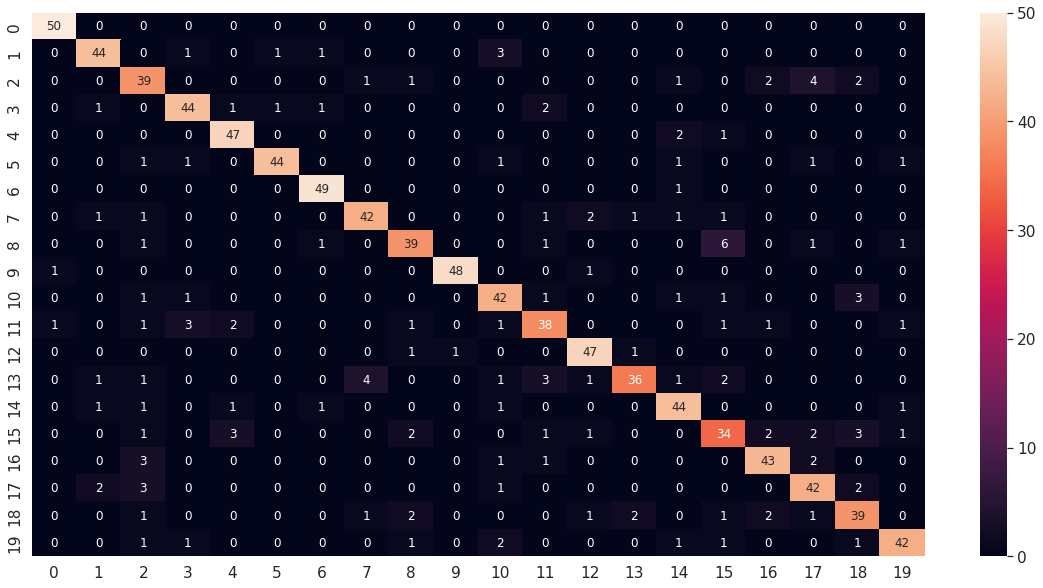

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg2_1_df_CM = pd.DataFrame(deepface_model_vgg2_1_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg2_1_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg2_1_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg2_1_report)

              precision    recall  f1-score   support

           1       0.96      1.00      0.98        50
           2       0.88      0.88      0.88        50
           3       0.71      0.78      0.74        50
           4       0.86      0.88      0.87        50
           5       0.87      0.94      0.90        50
           6       0.96      0.88      0.92        50
           7       0.92      0.98      0.95        50
           8       0.88      0.84      0.86        50
           9       0.83      0.78      0.80        50
          10       0.98      0.96      0.97        50
          11       0.79      0.84      0.82        50
          12       0.79      0.76      0.78        50
          13       0.89      0.94      0.91        50
          14       0.90      0.72      0.80        50
          15       0.83      0.88      0.85        50
          16       0.71      0.68      0.69        50
          17       0.86      0.86      0.86        50
          18       0.79    

#### Modelo 2: (BTH = 20, EHS = 60, ValidSplit = 0.2, Dropout=0, INI = HeNormal, REG = L2, OPT = SGD[0.001, momentum=0.9])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg2_2 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg2_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final dropout y softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg2_2.add(Dropout(rate=0, name='D0'))
deepface_model_vgg2_2.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg2_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)    
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg2_2.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_2.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg2_2 = deepface_model_vgg2_2.fit(new_trainX, new_trainY, batch_size=20, epochs=60, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/60
107/107 [==============================] - 152s 474ms/step - loss: 1.6203 - accuracy: 0.7874 - val_loss: 1.1161 - val_accuracy: 0.8258
Epoch 2/60
107/107 [==============================] - 17s 157ms/step - loss: 0.4281 - accuracy: 0.9991 - val_loss: 1.0412 - val_accuracy: 0.8446
Epoch 3/60
107/107 [==============================] - 17s 158ms/step - loss: 0.4033 - accuracy: 1.0000 - val_loss: 1.0030 - val_accuracy: 0.8371
Epoch 4/60
107/107 [==============================] - 17s 156ms/step - loss: 0.3859 - accuracy: 1.0000 - val_loss: 0.9779 - val_accuracy: 0.8390
Epoch 5/60
107/107 [==============================] - 17s 154ms/step - loss: 0.3700 - accuracy: 1.0000 - val_loss: 0.9556 - val_accuracy: 0.8408
Epoch 6/60
107/107 [==============================] - 17s 163ms/step - loss: 0.3547 - accuracy: 1.0000 - val_loss: 0.9341 - val_accuracy: 0.8427
Epoch 7/60
107/107 [==============================] - 18s 164ms/step - loss: 0.3402 - accuracy: 1.0000 - val_loss: 0.9128 - val_a

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg2_2 = load_model(path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_2.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg2_2.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg2_2.evaluate(testX, testY)

32/32 [==============================] - 2s 67ms/step - loss: 0.5441 - accuracy: 0.8580


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg2_2.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg2_2_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

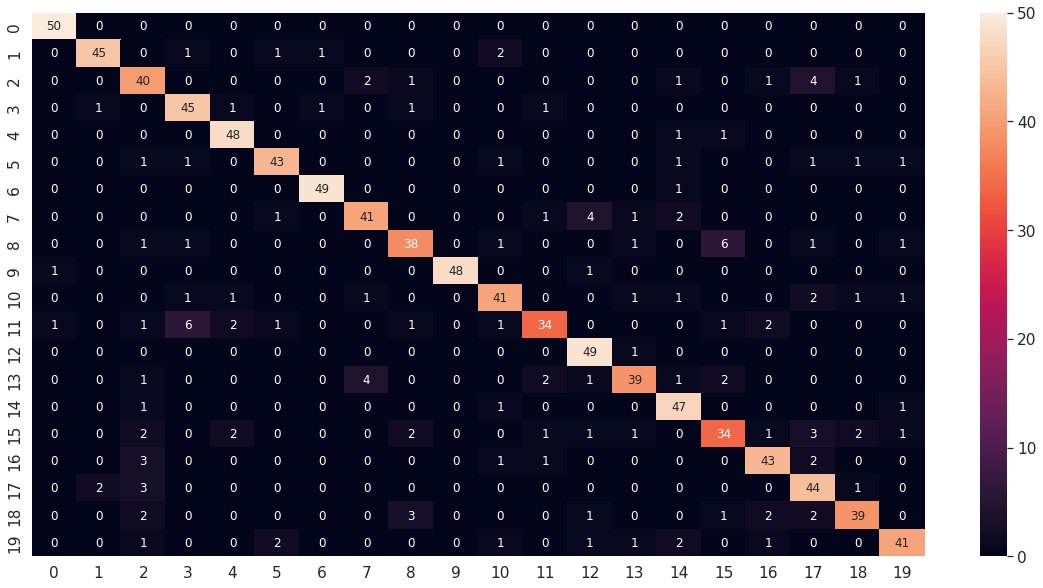

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg2_2_df_CM = pd.DataFrame(deepface_model_vgg2_2_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg2_2_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg2_2_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg2_2_report)

              precision    recall  f1-score   support

           1       0.96      1.00      0.98        50
           2       0.94      0.90      0.92        50
           3       0.71      0.80      0.75        50
           4       0.82      0.90      0.86        50
           5       0.89      0.96      0.92        50
           6       0.90      0.86      0.88        50
           7       0.96      0.98      0.97        50
           8       0.85      0.82      0.84        50
           9       0.83      0.76      0.79        50
          10       1.00      0.96      0.98        50
          11       0.84      0.82      0.83        50
          12       0.85      0.68      0.76        50
          13       0.84      0.98      0.91        50
          14       0.87      0.78      0.82        50
          15       0.82      0.94      0.88        50
          16       0.76      0.68      0.72        50
          17       0.86      0.86      0.86        50
          18       0.75    

#### Modelo 3: (BTH = 30, EHS = 60, ValidSplit = 0.2, Dropout=0, INI = HeNormal, REG = L2, OPT = SGD[0.001, momentum=0.9])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg2_3 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg2_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final dropout y softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg2_3.add(Dropout(rate=0, name='D0'))
deepface_model_vgg2_3.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg2_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)    
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg2_3.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_3.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg2_3 = deepface_model_vgg2_3.fit(new_trainX, new_trainY, batch_size=30, epochs=60, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/60
72/72 [==============================] - 140s 677ms/step - loss: 1.3495 - accuracy: 0.7845 - val_loss: 1.1344 - val_accuracy: 0.8184
Epoch 2/60
72/72 [==============================] - 14s 195ms/step - loss: 0.4251 - accuracy: 0.9995 - val_loss: 1.0558 - val_accuracy: 0.8390
Epoch 3/60
72/72 [==============================] - 14s 190ms/step - loss: 0.4069 - accuracy: 1.0000 - val_loss: 1.0213 - val_accuracy: 0.8390
Epoch 4/60
72/72 [==============================] - 14s 193ms/step - loss: 0.3950 - accuracy: 1.0000 - val_loss: 1.0026 - val_accuracy: 0.8408
Epoch 5/60
72/72 [==============================] - 14s 198ms/step - loss: 0.3838 - accuracy: 1.0000 - val_loss: 0.9840 - val_accuracy: 0.8408
Epoch 6/60
72/72 [==============================] - 14s 191ms/step - loss: 0.3730 - accuracy: 1.0000 - val_loss: 0.9683 - val_accuracy: 0.8408
Epoch 7/60
72/72 [==============================] - 14s 198ms/step - loss: 0.3626 - accuracy: 1.0000 - val_loss: 0.9536 - val_accuracy: 0.840

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg2_3 = load_model(path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_3.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg2_3.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg2_3.evaluate(testX, testY)

32/32 [==============================] - 2s 67ms/step - loss: 0.6098 - accuracy: 0.8540


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg2_3.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg2_3_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 35s 66ms/step


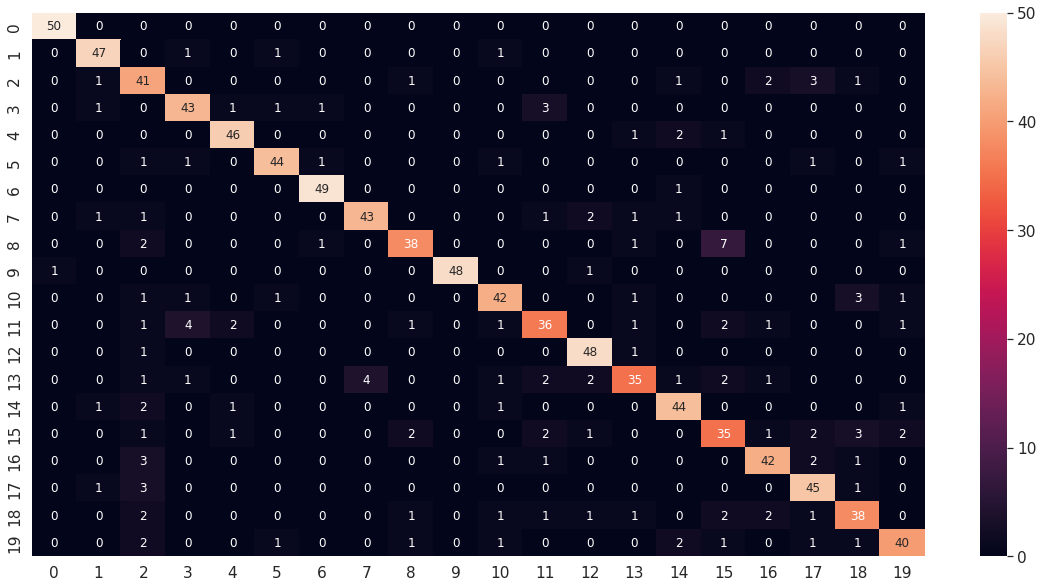

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg2_3_df_CM = pd.DataFrame(deepface_model_vgg2_3_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg2_3_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg2_3_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg2_3_report)

              precision    recall  f1-score   support

           1       0.98      1.00      0.99        50
           2       0.90      0.94      0.92        50
           3       0.66      0.82      0.73        50
           4       0.84      0.86      0.85        50
           5       0.90      0.92      0.91        50
           6       0.92      0.88      0.90        50
           7       0.94      0.98      0.96        50
           8       0.91      0.86      0.89        50
           9       0.86      0.76      0.81        50
          10       1.00      0.96      0.98        50
          11       0.84      0.84      0.84        50
          12       0.78      0.72      0.75        50
          13       0.87      0.96      0.91        50
          14       0.83      0.70      0.76        50
          15       0.85      0.88      0.86        50
          16       0.70      0.70      0.70        50
          17       0.86      0.84      0.85        50
          18       0.82    

#### Modelo 4: (BTH = 20, EHS = 100, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2, OPT =  SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg2_4 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg2_4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg2_4.add(Dropout(rate=0, name='D0'))
deepface_model_vgg2_4.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg2_4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg2_4.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_4.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg2_4 = deepface_model_vgg2_4.fit(new_trainX, new_trainY, batch_size=20, epochs=100, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/100
107/107 [==============================] - 156s 486ms/step - loss: 2.1152 - accuracy: 0.5686 - val_loss: 1.2305 - val_accuracy: 0.7622
Epoch 2/100
107/107 [==============================] - 17s 157ms/step - loss: 0.5640 - accuracy: 0.9677 - val_loss: 1.0942 - val_accuracy: 0.7959
Epoch 3/100
107/107 [==============================] - 17s 158ms/step - loss: 0.4328 - accuracy: 0.9991 - val_loss: 0.9779 - val_accuracy: 0.8427
Epoch 4/100
107/107 [==============================] - 17s 158ms/step - loss: 0.4005 - accuracy: 1.0000 - val_loss: 0.9482 - val_accuracy: 0.8446
Epoch 5/100
107/107 [==============================] - 17s 157ms/step - loss: 0.3818 - accuracy: 1.0000 - val_loss: 0.9241 - val_accuracy: 0.8483
Epoch 6/100
107/107 [==============================] - 17s 157ms/step - loss: 0.3655 - accuracy: 1.0000 - val_loss: 0.9119 - val_accuracy: 0.8427
Epoch 7/100
107/107 [==============================] - 17s 156ms/step - loss: 0.3508 - accuracy: 1.0000 - val_loss: 0.8932 

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg2_4 = load_model(path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_4.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg2_4.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg2_4.evaluate(testX, testY)

32/32 [==============================] - 2s 74ms/step - loss: 0.4981 - accuracy: 0.8600


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg2_4.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg2_4_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 39s 67ms/step


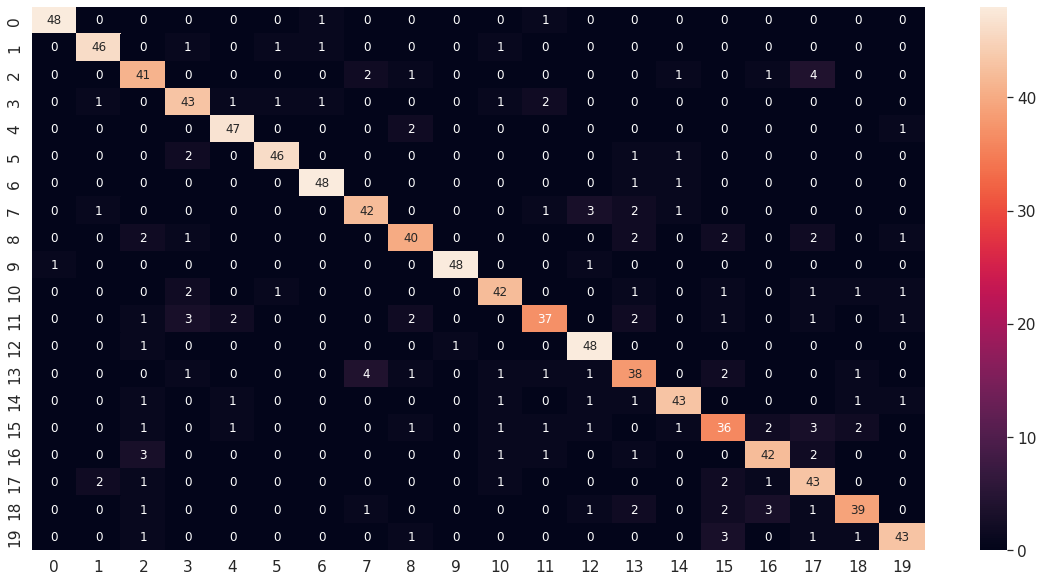

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg2_4_df_CM = pd.DataFrame(deepface_model_vgg2_4_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg2_4_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg2_4_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg2_4_report)

              precision    recall  f1-score   support

           1       0.98      0.96      0.97        50
           2       0.92      0.92      0.92        50
           3       0.77      0.82      0.80        50
           4       0.81      0.86      0.83        50
           5       0.90      0.94      0.92        50
           6       0.94      0.92      0.93        50
           7       0.94      0.96      0.95        50
           8       0.86      0.84      0.85        50
           9       0.83      0.80      0.82        50
          10       0.98      0.96      0.97        50
          11       0.86      0.84      0.85        50
          12       0.84      0.74      0.79        50
          13       0.86      0.96      0.91        50
          14       0.75      0.76      0.75        50
          15       0.90      0.86      0.88        50
          16       0.73      0.72      0.73        50
          17       0.86      0.84      0.85        50
          18       0.74    

#### Modelo 5: (BTH = 30, EHS = 100, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2, OPT = SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg2_5 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg2_5.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 21 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg2_5.add(Dropout(rate=0, name='D0'))
deepface_model_vgg2_5.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg2_5.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg2_5.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_5.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg2_5 = deepface_model_vgg2_5.fit(new_trainX, new_trainY, batch_size=30, epochs=100, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/100
72/72 [==============================] - 138s 646ms/step - loss: 1.7647 - accuracy: 0.7194 - val_loss: 1.2488 - val_accuracy: 0.7790
Epoch 2/100
72/72 [==============================] - 14s 190ms/step - loss: 0.4472 - accuracy: 0.9934 - val_loss: 1.0296 - val_accuracy: 0.8315
Epoch 3/100
72/72 [==============================] - 14s 189ms/step - loss: 0.4118 - accuracy: 1.0000 - val_loss: 0.9895 - val_accuracy: 0.8390
Epoch 4/100
72/72 [==============================] - 14s 190ms/step - loss: 0.3987 - accuracy: 1.0000 - val_loss: 0.9631 - val_accuracy: 0.8408
Epoch 5/100
72/72 [==============================] - 14s 193ms/step - loss: 0.3873 - accuracy: 1.0000 - val_loss: 0.9470 - val_accuracy: 0.8408
Epoch 6/100
72/72 [==============================] - 14s 191ms/step - loss: 0.3764 - accuracy: 1.0000 - val_loss: 0.9306 - val_accuracy: 0.8446
Epoch 7/100
72/72 [==============================] - 13s 187ms/step - loss: 0.3658 - accuracy: 1.0000 - val_loss: 0.9188 - val_accuracy

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg2_5 = load_model(path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_5.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg2_5.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg2_5.evaluate(testX, testY)

32/32 [==============================] - 2s 71ms/step - loss: 0.5106 - accuracy: 0.8620


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg2_5.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg2_5_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

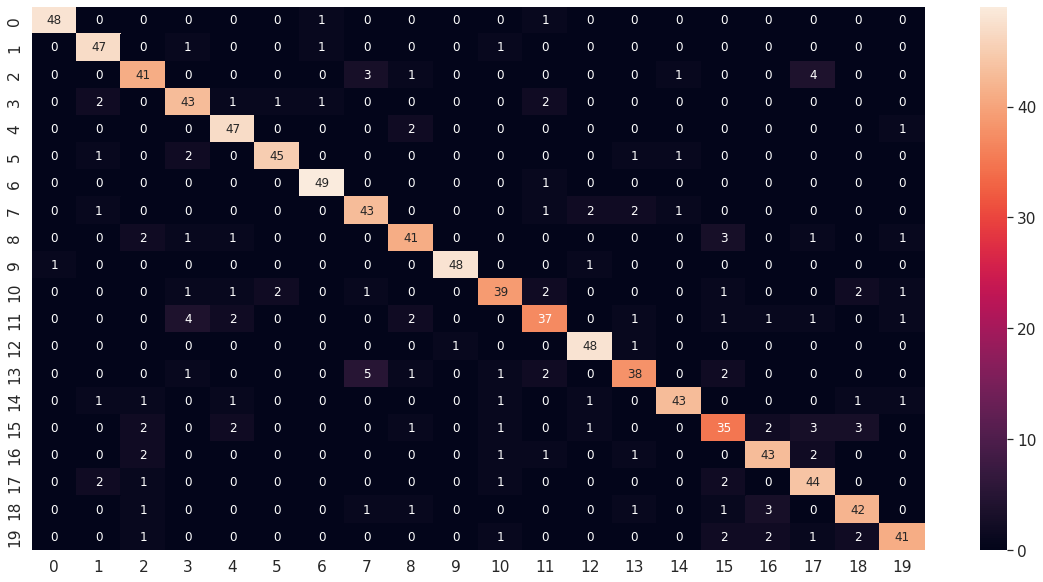

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg2_5_df_CM = pd.DataFrame(deepface_model_vgg2_5_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg2_5_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg2_5_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg2_5_report)

              precision    recall  f1-score   support

           1       0.98      0.96      0.97        50
           2       0.87      0.94      0.90        50
           3       0.80      0.82      0.81        50
           4       0.81      0.86      0.83        50
           5       0.85      0.94      0.90        50
           6       0.94      0.90      0.92        50
           7       0.94      0.98      0.96        50
           8       0.81      0.86      0.83        50
           9       0.84      0.82      0.83        50
          10       0.98      0.96      0.97        50
          11       0.85      0.78      0.81        50
          12       0.79      0.74      0.76        50
          13       0.91      0.96      0.93        50
          14       0.84      0.76      0.80        50
          15       0.93      0.86      0.90        50
          16       0.74      0.70      0.72        50
          17       0.84      0.86      0.85        50
          18       0.79    

#### Modelo 6: (BTH = 20, EHS = 40, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = none, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg2_6 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg2_6.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg2_6.add(Dropout(rate=0, name='D0'))
deepface_model_vgg2_6.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg2_6.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_vgg2_6.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_6.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg2_6 = deepface_model_vgg2_6.fit(new_trainX, new_trainY, batch_size=20, epochs=40, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/40
107/107 [==============================] - 156s 503ms/step - loss: 1.2943 - accuracy: 0.8834 - val_loss: 1.1952 - val_accuracy: 0.7959
Epoch 2/40
107/107 [==============================] - 15s 144ms/step - loss: 0.1635 - accuracy: 0.9995 - val_loss: 1.2059 - val_accuracy: 0.7921
Epoch 3/40
107/107 [==============================] - 20s 191ms/step - loss: 0.1564 - accuracy: 1.0000 - val_loss: 1.1879 - val_accuracy: 0.7921
Epoch 4/40
107/107 [==============================] - 21s 192ms/step - loss: 0.1525 - accuracy: 1.0000 - val_loss: 1.1744 - val_accuracy: 0.7940
Epoch 5/40
107/107 [==============================] - 21s 194ms/step - loss: 0.1489 - accuracy: 1.0000 - val_loss: 1.1586 - val_accuracy: 0.7996
Epoch 6/40
107/107 [==============================] - 21s 194ms/step - loss: 0.1455 - accuracy: 1.0000 - val_loss: 1.1539 - val_accuracy: 0.8052
Epoch 7/40
107/107 [==============================] - 15s 141ms/step - loss: 0.1420 - accuracy: 1.0000 - val_loss: 1.1602 - val_a

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg2_6 = load_model(path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_6.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg2_6.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg2_6.evaluate(testX, testY)

32/32 [==============================] - 2s 71ms/step - loss: 1.1337 - accuracy: 0.8040


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg2_6.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg2_6_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 45s 66ms/step


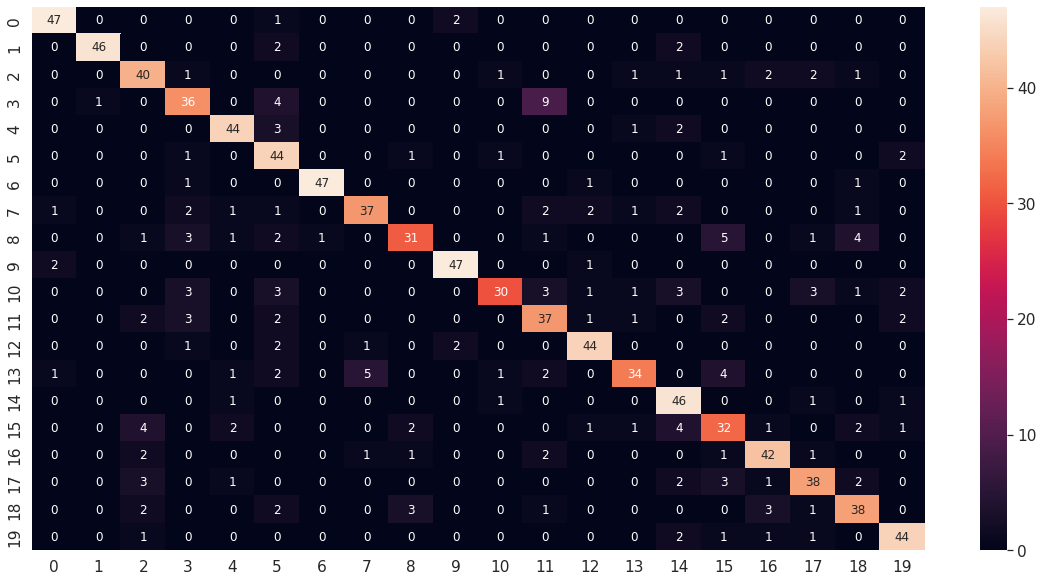

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg2_6_df_CM = pd.DataFrame(deepface_model_vgg2_6_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg2_6_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg2_6_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg2_6_report)

              precision    recall  f1-score   support

           1       0.92      0.94      0.93        50
           2       0.98      0.92      0.95        50
           3       0.73      0.80      0.76        50
           4       0.71      0.72      0.71        50
           5       0.86      0.88      0.87        50
           6       0.65      0.88      0.75        50
           7       0.98      0.94      0.96        50
           8       0.84      0.74      0.79        50
           9       0.82      0.62      0.70        50
          10       0.92      0.94      0.93        50
          11       0.88      0.60      0.71        50
          12       0.65      0.74      0.69        50
          13       0.86      0.88      0.87        50
          14       0.85      0.68      0.76        50
          15       0.72      0.92      0.81        50
          16       0.64      0.64      0.64        50
          17       0.84      0.84      0.84        50
          18       0.79    

#### Modelo 7: (BTH = 40, EHS = 40, ValidSplit = 0.2, INI = none, Dropout=0 REG = L2, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg2_7 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg2_7.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg2_7.add(Dropout(rate=0, name='D0'))
deepface_model_vgg2_7.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg2_7.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)  
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_vgg2_7.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_7.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg2_7 = deepface_model_vgg2_7.fit(new_trainX, new_trainY, batch_size=40, epochs=40, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/40
54/54 [==============================] - 146s 863ms/step - loss: 2.4640 - accuracy: 0.5400 - val_loss: 1.1789 - val_accuracy: 0.7303
Epoch 2/40
54/54 [==============================] - 14s 255ms/step - loss: 0.4649 - accuracy: 0.9536 - val_loss: 1.0288 - val_accuracy: 0.7790
Epoch 3/40
54/54 [==============================] - 14s 259ms/step - loss: 0.3051 - accuracy: 0.9977 - val_loss: 0.8978 - val_accuracy: 0.8202
Epoch 4/40
54/54 [==============================] - 14s 258ms/step - loss: 0.2771 - accuracy: 1.0000 - val_loss: 0.8610 - val_accuracy: 0.8258
Epoch 5/40
54/54 [==============================] - 14s 256ms/step - loss: 0.2647 - accuracy: 1.0000 - val_loss: 0.8472 - val_accuracy: 0.8315
Epoch 6/40
54/54 [==============================] - 14s 257ms/step - loss: 0.2540 - accuracy: 1.0000 - val_loss: 0.8359 - val_accuracy: 0.8296
Epoch 7/40
54/54 [==============================] - 15s 273ms/step - loss: 0.2440 - accuracy: 1.0000 - val_loss: 0.8280 - val_accuracy: 0.831

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg2_7 = load_model(path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_7.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg2_7.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg2_7.evaluate(testX, testY)

32/32 [==============================] - 2s 71ms/step - loss: 0.8636 - accuracy: 0.8260


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg2_7.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg2_7_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

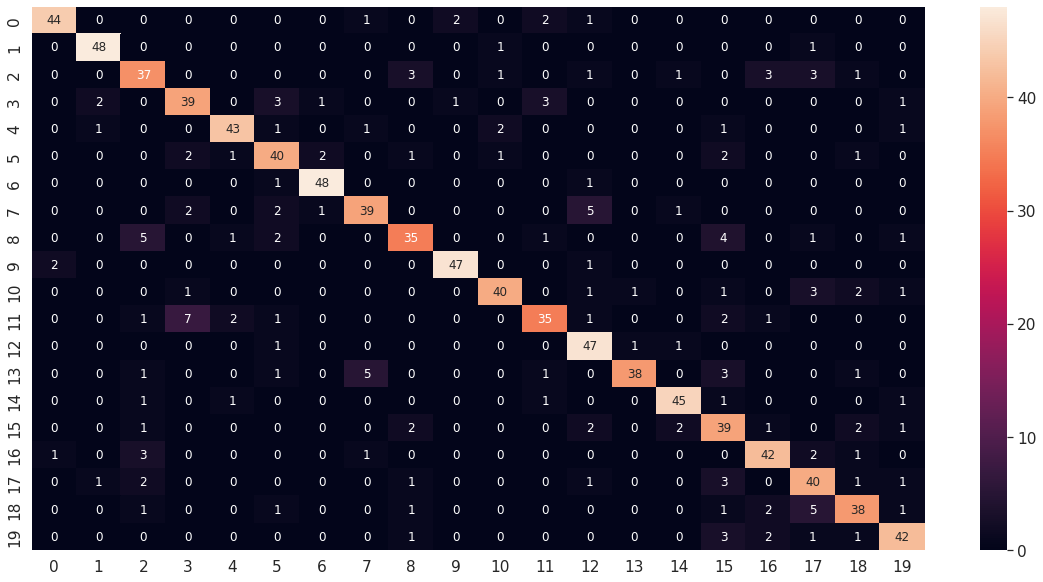

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg2_7_df_CM = pd.DataFrame(deepface_model_vgg2_7_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg2_7_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg2_7_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg2_7_report)

              precision    recall  f1-score   support

           1       0.94      0.88      0.91        50
           2       0.92      0.96      0.94        50
           3       0.71      0.74      0.73        50
           4       0.76      0.78      0.77        50
           5       0.90      0.86      0.88        50
           6       0.75      0.80      0.78        50
           7       0.92      0.96      0.94        50
           8       0.83      0.78      0.80        50
           9       0.80      0.70      0.74        50
          10       0.94      0.94      0.94        50
          11       0.89      0.80      0.84        50
          12       0.81      0.70      0.75        50
          13       0.77      0.94      0.85        50
          14       0.95      0.76      0.84        50
          15       0.90      0.90      0.90        50
          16       0.65      0.78      0.71        50
          17       0.82      0.84      0.83        50
          18       0.71    

#### Modelo 8: (BTH = 30, EHS = 40, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = none, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg2_8 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg2_8.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg2_8.add(Dropout(rate=0, name='D0'))
deepface_model_vgg2_8.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg2_8.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)  
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_vgg2_8.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_8.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg2_8 = deepface_model_vgg2_8.fit(new_trainX, new_trainY, batch_size=30, epochs=40, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/40
72/72 [==============================] - 148s 707ms/step - loss: 3.2352 - accuracy: 0.5827 - val_loss: 1.1769 - val_accuracy: 0.7285
Epoch 2/40
72/72 [==============================] - 16s 216ms/step - loss: 0.4369 - accuracy: 0.9499 - val_loss: 1.0626 - val_accuracy: 0.7528
Epoch 3/40
72/72 [==============================] - 16s 217ms/step - loss: 0.2834 - accuracy: 0.9986 - val_loss: 0.9774 - val_accuracy: 0.7996
Epoch 4/40
72/72 [==============================] - 17s 231ms/step - loss: 0.2633 - accuracy: 1.0000 - val_loss: 0.9460 - val_accuracy: 0.8090
Epoch 5/40
72/72 [==============================] - 16s 220ms/step - loss: 0.2561 - accuracy: 1.0000 - val_loss: 0.9457 - val_accuracy: 0.8071
Epoch 6/40
72/72 [==============================] - 11s 153ms/step - loss: 0.2500 - accuracy: 1.0000 - val_loss: 0.9476 - val_accuracy: 0.8109
Epoch 7/40
72/72 [==============================] - 11s 155ms/step - loss: 0.2442 - accuracy: 1.0000 - val_loss: 0.9530 - val_accuracy: 0.812

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg2_8 = load_model(path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_8.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg2_8.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg2_8.evaluate(testX, testY)

32/32 [==============================] - 2s 68ms/step - loss: 1.0352 - accuracy: 0.8140


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg2_8.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg2_8_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

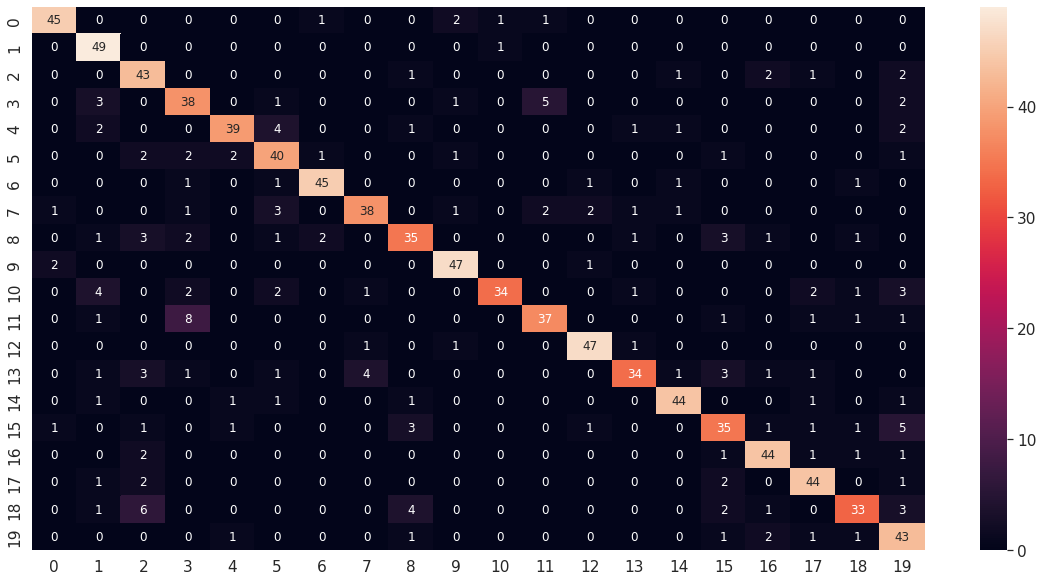

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg2_8_df_CM = pd.DataFrame(deepface_model_vgg2_8_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg2_8_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg2_8_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg2_8_report)

              precision    recall  f1-score   support

           1       0.92      0.90      0.91        50
           2       0.77      0.98      0.86        50
           3       0.69      0.86      0.77        50
           4       0.69      0.76      0.72        50
           5       0.89      0.78      0.83        50
           6       0.74      0.80      0.77        50
           7       0.92      0.90      0.91        50
           8       0.86      0.76      0.81        50
           9       0.76      0.70      0.73        50
          10       0.89      0.94      0.91        50
          11       0.94      0.68      0.79        50
          12       0.82      0.74      0.78        50
          13       0.90      0.94      0.92        50
          14       0.87      0.68      0.76        50
          15       0.90      0.88      0.89        50
          16       0.71      0.70      0.71        50
          17       0.85      0.88      0.86        50
          18       0.83    

#### Modelo 9: (BTH = 30, EHS = 150, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg2_9 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg2_9.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg2_9.add(Dropout(rate=0, name='D0'))
deepface_model_vgg2_9.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg2_9.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg2_9.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_9.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg2_9 = deepface_model_vgg2_9.fit(new_trainX, new_trainY, batch_size=30, epochs=150, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/150
72/72 [==============================] - 144s 675ms/step - loss: 1.8052 - accuracy: 0.7480 - val_loss: 1.2229 - val_accuracy: 0.7959
Epoch 2/150
72/72 [==============================] - 14s 194ms/step - loss: 0.4316 - accuracy: 0.9981 - val_loss: 1.0869 - val_accuracy: 0.8371
Epoch 3/150
72/72 [==============================] - 14s 193ms/step - loss: 0.4095 - accuracy: 1.0000 - val_loss: 1.0618 - val_accuracy: 0.8390
Epoch 4/150
72/72 [==============================] - 14s 196ms/step - loss: 0.3975 - accuracy: 1.0000 - val_loss: 1.0415 - val_accuracy: 0.8408
Epoch 5/150
72/72 [==============================] - 14s 192ms/step - loss: 0.3862 - accuracy: 1.0000 - val_loss: 1.0200 - val_accuracy: 0.8408
Epoch 6/150
72/72 [==============================] - 14s 196ms/step - loss: 0.3753 - accuracy: 1.0000 - val_loss: 1.0007 - val_accuracy: 0.8446
Epoch 7/150
72/72 [==============================] - 14s 194ms/step - loss: 0.3648 - accuracy: 1.0000 - val_loss: 0.9831 - val_accuracy

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg2_9 = load_model(path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_9.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg2_9.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg2_9.evaluate(testX, testY)

32/32 [==============================] - 2s 69ms/step - loss: 0.4789 - accuracy: 0.8600


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg2_9.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg2_9_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 41s 66ms/step


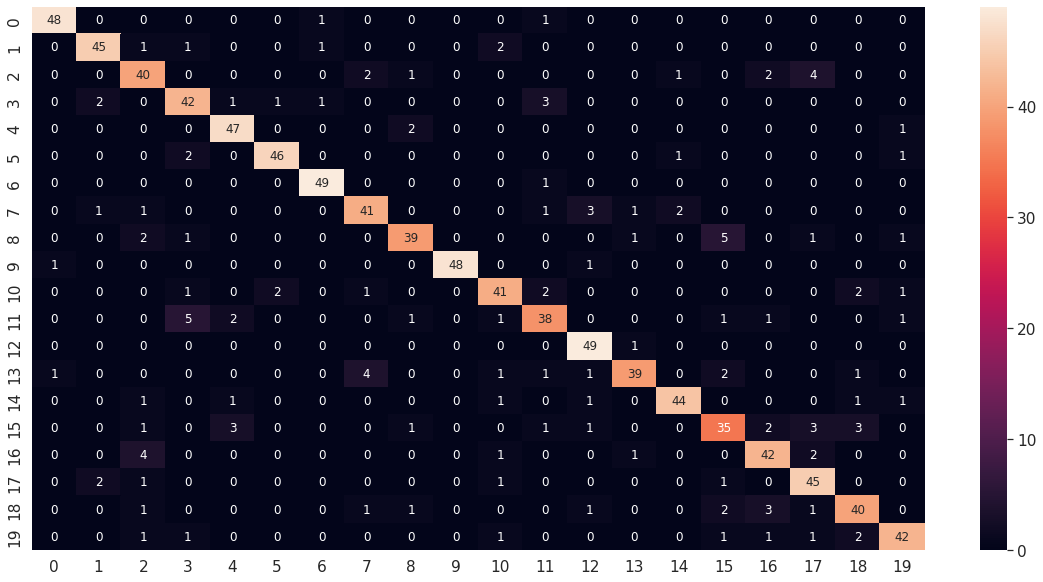

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg2_9_df_CM = pd.DataFrame(deepface_model_vgg2_9_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg2_9_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg2_9_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg2_9_report)

              precision    recall  f1-score   support

           1       0.96      0.96      0.96        50
           2       0.90      0.90      0.90        50
           3       0.75      0.80      0.78        50
           4       0.79      0.84      0.82        50
           5       0.87      0.94      0.90        50
           6       0.94      0.92      0.93        50
           7       0.94      0.98      0.96        50
           8       0.84      0.82      0.83        50
           9       0.87      0.78      0.82        50
          10       1.00      0.96      0.98        50
          11       0.84      0.82      0.83        50
          12       0.79      0.76      0.78        50
          13       0.86      0.98      0.92        50
          14       0.91      0.78      0.84        50
          15       0.92      0.88      0.90        50
          16       0.74      0.70      0.72        50
          17       0.82      0.84      0.83        50
          18       0.79    

#### Modelo 10: (BTH = 40, EHS = 100, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg2_10 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg2_10.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg2_10.add(Dropout(rate=0, name='D0'))
deepface_model_vgg2_10.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg2_10.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg2_10.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_10.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg2_10 = deepface_model_vgg2_10.fit(new_trainX, new_trainY, batch_size=40, epochs=100, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/100
54/54 [==============================] - 142s 847ms/step - loss: 1.3507 - accuracy: 0.7934 - val_loss: 1.1844 - val_accuracy: 0.7809
Epoch 2/100
54/54 [==============================] - 12s 227ms/step - loss: 0.4435 - accuracy: 0.9981 - val_loss: 1.1177 - val_accuracy: 0.7996
Epoch 3/100
54/54 [==============================] - 12s 227ms/step - loss: 0.4194 - accuracy: 1.0000 - val_loss: 1.1037 - val_accuracy: 0.7959
Epoch 4/100
54/54 [==============================] - 13s 235ms/step - loss: 0.4081 - accuracy: 1.0000 - val_loss: 1.0857 - val_accuracy: 0.8165
Epoch 5/100
54/54 [==============================] - 13s 239ms/step - loss: 0.3985 - accuracy: 1.0000 - val_loss: 1.0777 - val_accuracy: 0.8034
Epoch 6/100
54/54 [==============================] - 12s 226ms/step - loss: 0.3895 - accuracy: 1.0000 - val_loss: 1.0681 - val_accuracy: 0.8146
Epoch 7/100
54/54 [==============================] - 12s 226ms/step - loss: 0.3809 - accuracy: 1.0000 - val_loss: 1.0591 - val_accuracy

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg2_10 = load_model(path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_10.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg2_10.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg2_10.evaluate(testX, testY)

32/32 [==============================] - 2s 71ms/step - loss: 0.7446 - accuracy: 0.8150


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg2_10.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg2_10_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

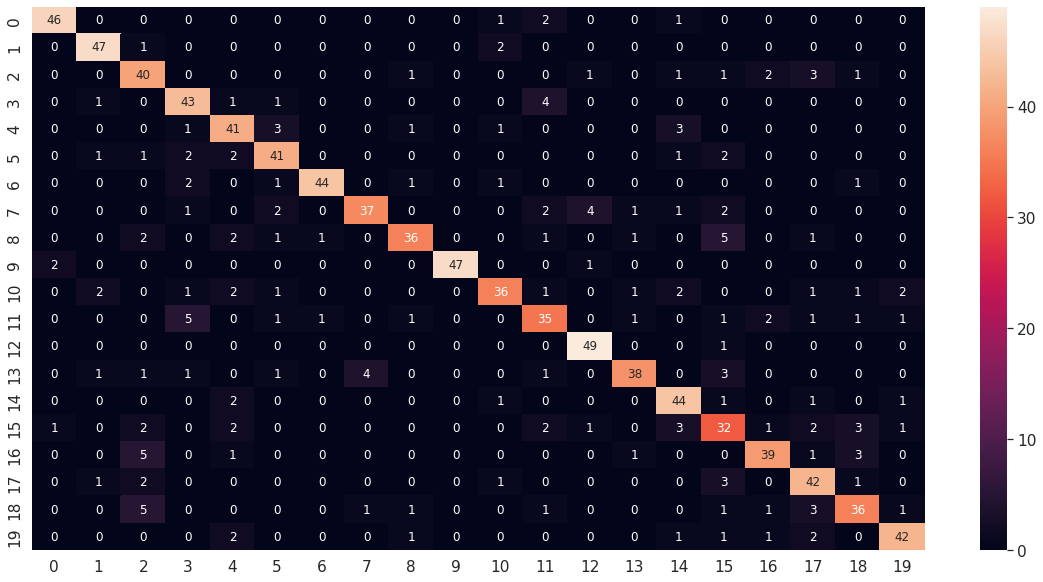

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg2_10_df_CM = pd.DataFrame(deepface_model_vgg2_10_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg2_10_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg2_10_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg2_10_report)

              precision    recall  f1-score   support

           1       0.94      0.92      0.93        50
           2       0.89      0.94      0.91        50
           3       0.68      0.80      0.73        50
           4       0.77      0.86      0.81        50
           5       0.75      0.82      0.78        50
           6       0.79      0.82      0.80        50
           7       0.96      0.88      0.92        50
           8       0.88      0.74      0.80        50
           9       0.86      0.72      0.78        50
          10       1.00      0.94      0.97        50
          11       0.84      0.72      0.77        50
          12       0.71      0.70      0.71        50
          13       0.88      0.98      0.92        50
          14       0.88      0.76      0.82        50
          15       0.77      0.88      0.82        50
          16       0.60      0.64      0.62        50
          17       0.85      0.78      0.81        50
          18       0.74    

#### Modelo 11: (BTH = 40, EHS = 80, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg2_11 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg2_11.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg2_11.add(Dropout(rate=0, name='D0'))
deepface_model_vgg2_11.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg2_11.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_vgg2_11.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_11.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg2_11 = deepface_model_vgg2_11.fit(new_trainX, new_trainY, batch_size=40, epochs=80, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/80
54/54 [==============================] - 140s 831ms/step - loss: 2.7331 - accuracy: 0.5269 - val_loss: 1.2050 - val_accuracy: 0.7191
Epoch 2/80
54/54 [==============================] - 14s 253ms/step - loss: 0.4812 - accuracy: 0.9489 - val_loss: 1.0728 - val_accuracy: 0.7753
Epoch 3/80
54/54 [==============================] - 14s 253ms/step - loss: 0.3118 - accuracy: 0.9981 - val_loss: 0.9695 - val_accuracy: 0.8109
Epoch 4/80
54/54 [==============================] - 14s 252ms/step - loss: 0.2867 - accuracy: 1.0000 - val_loss: 0.9341 - val_accuracy: 0.8221
Epoch 5/80
54/54 [==============================] - 14s 252ms/step - loss: 0.2747 - accuracy: 1.0000 - val_loss: 0.9181 - val_accuracy: 0.8165
Epoch 6/80
54/54 [==============================] - 14s 255ms/step - loss: 0.2645 - accuracy: 1.0000 - val_loss: 0.9058 - val_accuracy: 0.8240
Epoch 7/80
54/54 [==============================] - 14s 254ms/step - loss: 0.2551 - accuracy: 1.0000 - val_loss: 0.8989 - val_accuracy: 0.825

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg2_11 = load_model(path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_11.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg2_11.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg2_11.evaluate(testX, testY)

32/32 [==============================] - 2s 68ms/step - loss: 0.7412 - accuracy: 0.8330


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg2_11.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg2_11_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

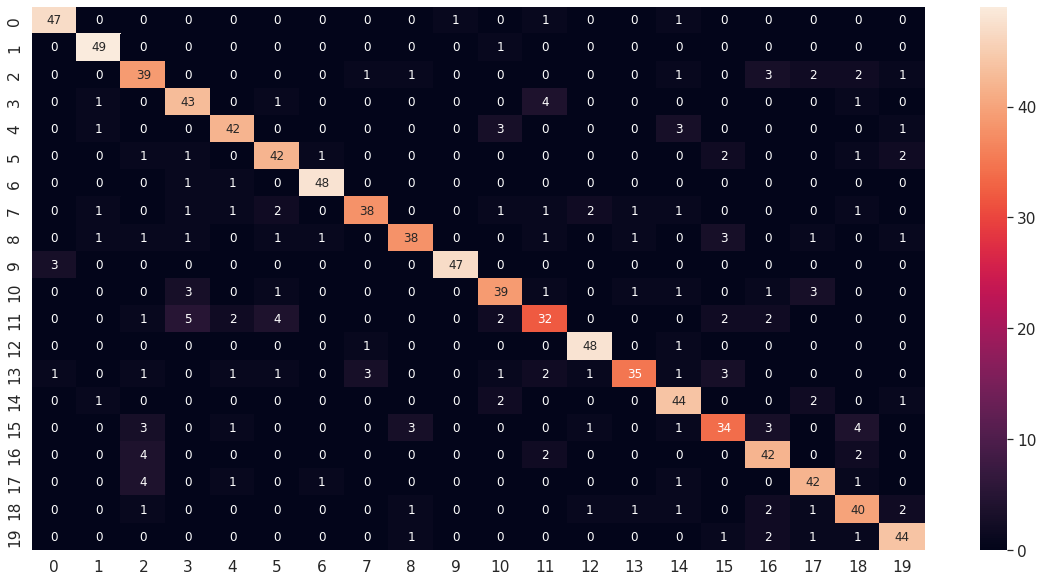

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg2_11_df_CM = pd.DataFrame(deepface_model_vgg2_11_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg2_11_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg2_11_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg2_11_report)

              precision    recall  f1-score   support

           1       0.92      0.94      0.93        50
           2       0.91      0.98      0.94        50
           3       0.71      0.78      0.74        50
           4       0.78      0.86      0.82        50
           5       0.86      0.84      0.85        50
           6       0.81      0.84      0.82        50
           7       0.94      0.96      0.95        50
           8       0.88      0.76      0.82        50
           9       0.86      0.76      0.81        50
          10       0.98      0.94      0.96        50
          11       0.80      0.78      0.79        50
          12       0.73      0.64      0.68        50
          13       0.91      0.96      0.93        50
          14       0.90      0.70      0.79        50
          15       0.79      0.88      0.83        50
          16       0.76      0.68      0.72        50
          17       0.76      0.84      0.80        50
          18       0.81    

#### Modelo 12: (BTH = 30, EHS = 80, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg2_12 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg2_12.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg2_12.add(Dropout(rate=0, name='D0'))
deepface_model_vgg2_12.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg2_12.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_vgg2_12.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_12.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg2_12 = deepface_model_vgg2_12.fit(new_trainX, new_trainY, batch_size=30, epochs=80, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/80
72/72 [==============================] - 138s 653ms/step - loss: 5.4659 - accuracy: 0.6047 - val_loss: 1.3288 - val_accuracy: 0.7079
Epoch 2/80
72/72 [==============================] - 15s 213ms/step - loss: 0.4282 - accuracy: 0.9630 - val_loss: 1.0848 - val_accuracy: 0.7697
Epoch 3/80
72/72 [==============================] - 15s 212ms/step - loss: 0.2935 - accuracy: 1.0000 - val_loss: 1.0335 - val_accuracy: 0.7772
Epoch 4/80
72/72 [==============================] - 15s 213ms/step - loss: 0.2788 - accuracy: 1.0000 - val_loss: 1.0284 - val_accuracy: 0.7846
Epoch 5/80
72/72 [==============================] - 15s 212ms/step - loss: 0.2734 - accuracy: 1.0000 - val_loss: 1.0211 - val_accuracy: 0.7921
Epoch 6/80
72/72 [==============================] - 11s 151ms/step - loss: 0.2688 - accuracy: 1.0000 - val_loss: 1.0275 - val_accuracy: 0.7921
Epoch 7/80
72/72 [==============================] - 11s 151ms/step - loss: 0.2646 - accuracy: 1.0000 - val_loss: 1.0249 - val_accuracy: 0.801

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg2_12 = load_model(path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_12.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg2_12.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg2_12.evaluate(testX, testY)

32/32 [==============================] - 2s 65ms/step - loss: 0.8869 - accuracy: 0.8280


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg2_12.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg2_12_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

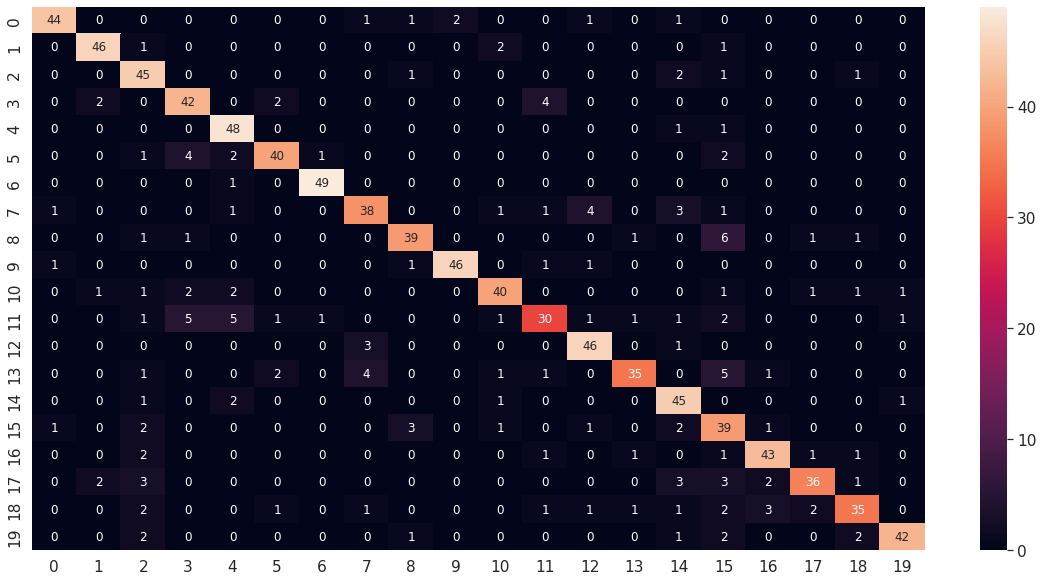

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg2_12_df_CM = pd.DataFrame(deepface_model_vgg2_12_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg2_12_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg2_12_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg2_12_report)

              precision    recall  f1-score   support

           1       0.94      0.88      0.91        50
           2       0.90      0.92      0.91        50
           3       0.71      0.90      0.80        50
           4       0.78      0.84      0.81        50
           5       0.79      0.96      0.86        50
           6       0.87      0.80      0.83        50
           7       0.96      0.98      0.97        50
           8       0.81      0.76      0.78        50
           9       0.85      0.78      0.81        50
          10       0.96      0.92      0.94        50
          11       0.85      0.80      0.82        50
          12       0.77      0.60      0.67        50
          13       0.84      0.92      0.88        50
          14       0.90      0.70      0.79        50
          15       0.74      0.90      0.81        50
          16       0.58      0.78      0.67        50
          17       0.86      0.86      0.86        50
          18       0.88    

#### Modelo 13: (BTH = 50, EHS = 60, ValidSplit = 0.2, Dropout = 0, INI = HeNormal, Dropout=0, REG = L2, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg2_13 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg2_13.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg2_13.add(Dropout(rate=0, name='D0'))
deepface_model_vgg2_13.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg2_13.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_vgg2_13.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_13.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg2_13 = deepface_model_vgg2_13.fit(new_trainX, new_trainY, batch_size=50, epochs=60, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/60
43/43 [==============================] - 154s 1s/step - loss: 2.8261 - accuracy: 0.5204 - val_loss: 1.2101 - val_accuracy: 0.7360
Epoch 2/60
43/43 [==============================] - 13s 301ms/step - loss: 0.5064 - accuracy: 0.9480 - val_loss: 0.9952 - val_accuracy: 0.7828
Epoch 3/60
43/43 [==============================] - 13s 302ms/step - loss: 0.3242 - accuracy: 0.9981 - val_loss: 0.9118 - val_accuracy: 0.8052
Epoch 4/60
43/43 [==============================] - 13s 304ms/step - loss: 0.2977 - accuracy: 1.0000 - val_loss: 0.8509 - val_accuracy: 0.8221
Epoch 5/60
43/43 [==============================] - 13s 302ms/step - loss: 0.2860 - accuracy: 1.0000 - val_loss: 0.8450 - val_accuracy: 0.8202
Epoch 6/60
43/43 [==============================] - 13s 298ms/step - loss: 0.2760 - accuracy: 1.0000 - val_loss: 0.8315 - val_accuracy: 0.8258
Epoch 7/60
43/43 [==============================] - 13s 302ms/step - loss: 0.2667 - accuracy: 1.0000 - val_loss: 0.8231 - val_accuracy: 0.8240
E

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg2_13 = load_model(path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_13.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg2_13.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg2_13.evaluate(testX, testY)

32/32 [==============================] - 2s 66ms/step - loss: 0.7489 - accuracy: 0.8480


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg2_13.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg2_13_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

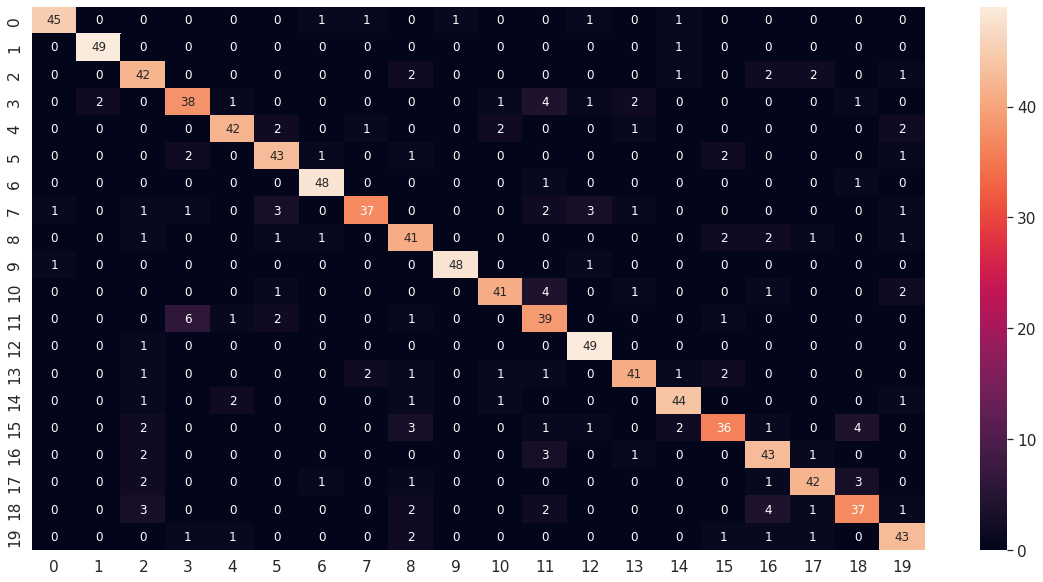

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg2_13_df_CM = pd.DataFrame(deepface_model_vgg2_13_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg2_13_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg2_13_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg2_13_report)

              precision    recall  f1-score   support

           1       0.96      0.90      0.93        50
           2       0.96      0.98      0.97        50
           3       0.75      0.84      0.79        50
           4       0.79      0.76      0.78        50
           5       0.89      0.84      0.87        50
           6       0.83      0.86      0.84        50
           7       0.92      0.96      0.94        50
           8       0.90      0.74      0.81        50
           9       0.75      0.82      0.78        50
          10       0.98      0.96      0.97        50
          11       0.89      0.82      0.85        50
          12       0.68      0.78      0.73        50
          13       0.88      0.98      0.92        50
          14       0.87      0.82      0.85        50
          15       0.88      0.88      0.88        50
          16       0.82      0.72      0.77        50
          17       0.78      0.86      0.82        50
          18       0.88    

#### Modelo 14: (BTH = 50, EHS = 60, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg2_14 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg2_14.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg2_14.add(Dropout(rate=0, name='D0'))
deepface_model_vgg2_14.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg2_14.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg2_14.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_14.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg2_14 = deepface_model_vgg2_14.fit(new_trainX, new_trainY, batch_size=50, epochs=60, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/60
43/43 [==============================] - 133s 1s/step - loss: 9.8226 - accuracy: 0.5667 - val_loss: 1.7262 - val_accuracy: 0.7004
Epoch 2/60
43/43 [==============================] - 11s 256ms/step - loss: 0.9318 - accuracy: 0.9237 - val_loss: 1.4867 - val_accuracy: 0.7734
Epoch 3/60
43/43 [==============================] - 11s 249ms/step - loss: 0.7257 - accuracy: 0.9822 - val_loss: 1.4328 - val_accuracy: 0.7772
Epoch 4/60
43/43 [==============================] - 11s 251ms/step - loss: 0.6618 - accuracy: 0.9981 - val_loss: 1.3820 - val_accuracy: 0.7959
Epoch 5/60
43/43 [==============================] - 11s 250ms/step - loss: 0.6334 - accuracy: 0.9995 - val_loss: 1.3674 - val_accuracy: 0.8015
Epoch 6/60
43/43 [==============================] - 11s 250ms/step - loss: 0.6150 - accuracy: 1.0000 - val_loss: 1.3596 - val_accuracy: 0.8034
Epoch 7/60
43/43 [==============================] - 11s 253ms/step - loss: 0.6015 - accuracy: 1.0000 - val_loss: 1.3469 - val_accuracy: 0.8052
E

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg2_14 = load_model(path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_14.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg2_14.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg2_14.evaluate(testX, testY)

32/32 [==============================] - 2s 73ms/step - loss: 0.9469 - accuracy: 0.8240


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg2_14.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg2_14_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

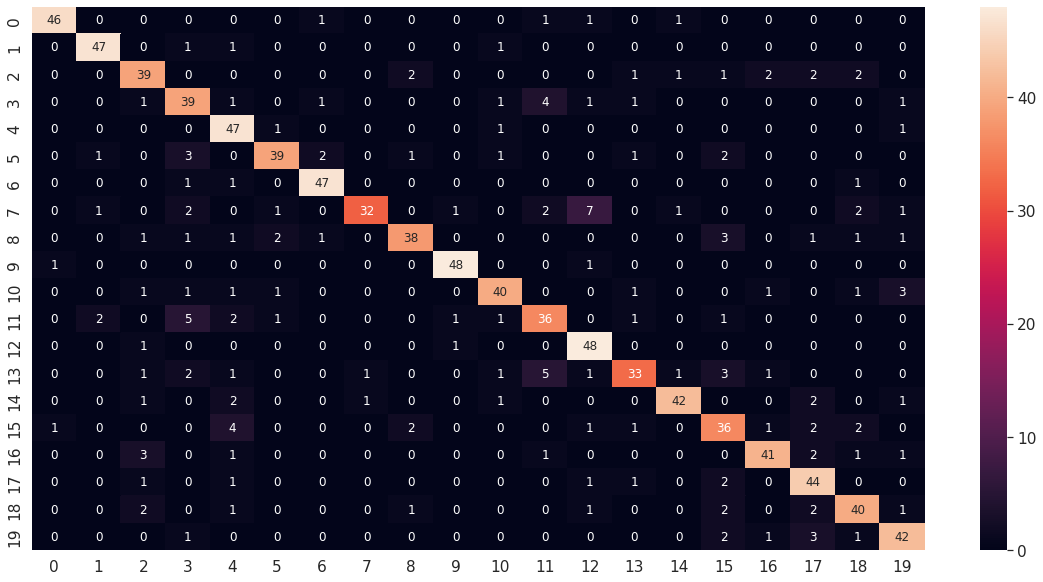

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg2_14_df_CM = pd.DataFrame(deepface_model_vgg2_14_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg2_14_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg2_14_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg2_14_report)

              precision    recall  f1-score   support

           1       0.96      0.92      0.94        50
           2       0.92      0.94      0.93        50
           3       0.76      0.78      0.77        50
           4       0.70      0.78      0.74        50
           5       0.73      0.94      0.82        50
           6       0.87      0.78      0.82        50
           7       0.90      0.94      0.92        50
           8       0.94      0.64      0.76        50
           9       0.86      0.76      0.81        50
          10       0.94      0.96      0.95        50
          11       0.85      0.80      0.82        50
          12       0.73      0.72      0.73        50
          13       0.77      0.96      0.86        50
          14       0.82      0.66      0.73        50
          15       0.91      0.84      0.87        50
          16       0.69      0.72      0.71        50
          17       0.87      0.82      0.85        50
          18       0.76    

#### Modelo 15: (BTH = 50, EHS = 100, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg2_15 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg2_15.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg2_15.add(Dropout(rate=0, name='D0'))
deepface_model_vgg2_15.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg2_15.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg2_15.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_15.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg2_15 = deepface_model_vgg2_15.fit(new_trainX, new_trainY, batch_size=50, epochs=100, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/100
43/43 [==============================] - 137s 1s/step - loss: 1.6746 - accuracy: 0.7246 - val_loss: 1.3037 - val_accuracy: 0.7360
Epoch 2/100
43/43 [==============================] - 11s 264ms/step - loss: 0.4911 - accuracy: 0.9883 - val_loss: 1.2039 - val_accuracy: 0.7809
Epoch 3/100
43/43 [==============================] - 11s 267ms/step - loss: 0.4384 - accuracy: 0.9995 - val_loss: 1.1820 - val_accuracy: 0.7884
Epoch 4/100
43/43 [==============================] - 11s 266ms/step - loss: 0.4229 - accuracy: 1.0000 - val_loss: 1.1710 - val_accuracy: 0.7903
Epoch 5/100
43/43 [==============================] - 8s 195ms/step - loss: 0.4126 - accuracy: 1.0000 - val_loss: 1.1713 - val_accuracy: 0.7884
Epoch 6/100
43/43 [==============================] - 11s 264ms/step - loss: 0.4042 - accuracy: 1.0000 - val_loss: 1.1610 - val_accuracy: 0.7921
Epoch 7/100
43/43 [==============================] - 11s 267ms/step - loss: 0.3965 - accuracy: 1.0000 - val_loss: 1.1558 - val_accuracy: 0.

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg2_15 = load_model(path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_15.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg2_15.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg2_15.evaluate(testX, testY)

32/32 [==============================] - 2s 69ms/step - loss: 0.7033 - accuracy: 0.8360


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg2_15.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg2_15_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

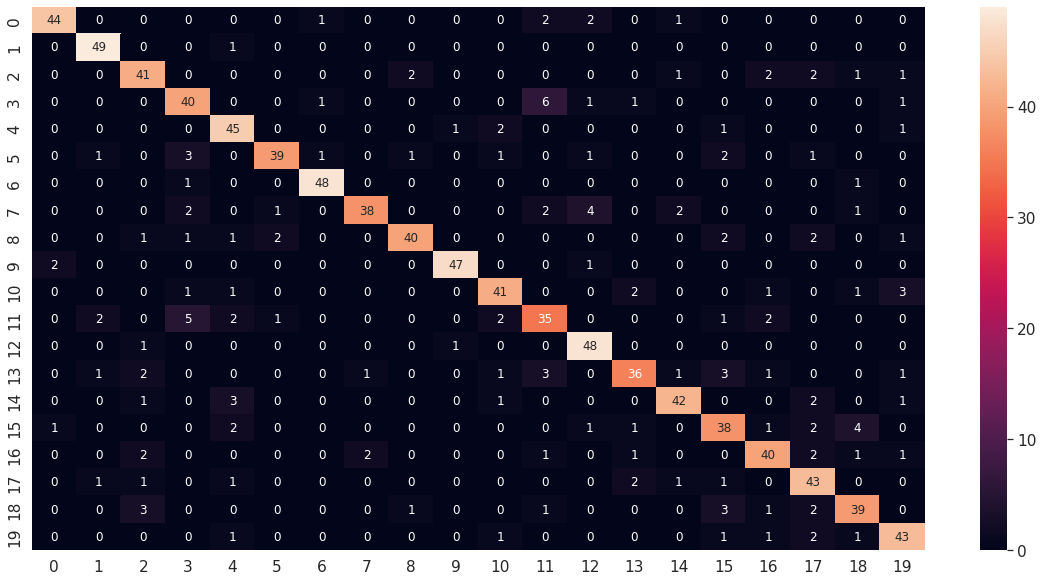

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg2_15_df_CM = pd.DataFrame(deepface_model_vgg2_15_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg2_15_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg2_15_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg2_15_report)

              precision    recall  f1-score   support

           1       0.94      0.88      0.91        50
           2       0.91      0.98      0.94        50
           3       0.79      0.82      0.80        50
           4       0.75      0.80      0.78        50
           5       0.79      0.90      0.84        50
           6       0.91      0.78      0.84        50
           7       0.94      0.96      0.95        50
           8       0.93      0.76      0.84        50
           9       0.91      0.80      0.85        50
          10       0.96      0.94      0.95        50
          11       0.84      0.82      0.83        50
          12       0.70      0.70      0.70        50
          13       0.83      0.96      0.89        50
          14       0.84      0.72      0.77        50
          15       0.88      0.84      0.86        50
          16       0.73      0.76      0.75        50
          17       0.82      0.80      0.81        50
          18       0.74    

#### Modelo 16: (BTH = 60, EHS = 50, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg2_16 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg2_16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg2_16.add(Dropout(rate=0, name='D0'))
deepface_model_vgg2_16.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg2_16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_vgg2_16.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_16.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg2_16 = deepface_model_vgg2_16.fit(new_trainX, new_trainY, batch_size=60, epochs=50, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/50
36/36 [==============================] - 140s 1s/step - loss: 2.6270 - accuracy: 0.5274 - val_loss: 1.3633 - val_accuracy: 0.6929
Epoch 2/50
36/36 [==============================] - 12s 346ms/step - loss: 0.4810 - accuracy: 0.9555 - val_loss: 1.0701 - val_accuracy: 0.7846
Epoch 3/50
36/36 [==============================] - 13s 362ms/step - loss: 0.3282 - accuracy: 0.9972 - val_loss: 0.9850 - val_accuracy: 0.8090
Epoch 4/50
36/36 [==============================] - 12s 345ms/step - loss: 0.3015 - accuracy: 1.0000 - val_loss: 0.9395 - val_accuracy: 0.8127
Epoch 5/50
36/36 [==============================] - 12s 346ms/step - loss: 0.2894 - accuracy: 1.0000 - val_loss: 0.9258 - val_accuracy: 0.8146
Epoch 6/50
36/36 [==============================] - 13s 353ms/step - loss: 0.2790 - accuracy: 1.0000 - val_loss: 0.9141 - val_accuracy: 0.8146
Epoch 7/50
36/36 [==============================] - 12s 349ms/step - loss: 0.2695 - accuracy: 1.0000 - val_loss: 0.9031 - val_accuracy: 0.8165
E

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg2_16 = load_model(path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_16.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg2_16.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg2_16.evaluate(testX, testY)

32/32 [==============================] - 2s 70ms/step - loss: 0.7500 - accuracy: 0.8360


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg2_16.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg2_16_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

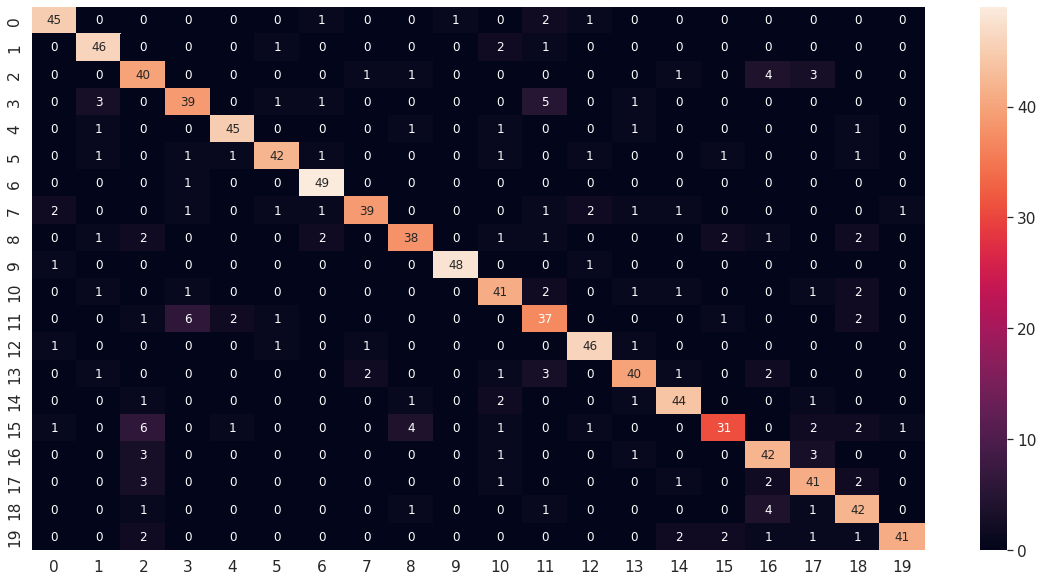

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg2_16_df_CM = pd.DataFrame(deepface_model_vgg2_16_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg2_16_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg2_16_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg2_16_report)

              precision    recall  f1-score   support

           1       0.90      0.90      0.90        50
           2       0.85      0.92      0.88        50
           3       0.68      0.80      0.73        50
           4       0.80      0.78      0.79        50
           5       0.92      0.90      0.91        50
           6       0.89      0.84      0.87        50
           7       0.89      0.98      0.93        50
           8       0.91      0.78      0.84        50
           9       0.83      0.76      0.79        50
          10       0.98      0.96      0.97        50
          11       0.79      0.82      0.80        50
          12       0.70      0.74      0.72        50
          13       0.88      0.92      0.90        50
          14       0.85      0.80      0.82        50
          15       0.86      0.88      0.87        50
          16       0.84      0.62      0.71        50
          17       0.75      0.84      0.79        50
          18       0.77    

#### Modelo 17: (BTH = 20, EHS = 200, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2, OPT =  SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg2_17 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg2_17.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg2_17.add(Dropout(rate=0, name='D0'))
deepface_model_vgg2_17.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg2_17.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg2_17.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_17.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg2_17 = deepface_model_vgg2_17.fit(new_trainX, new_trainY, batch_size=20, epochs=200, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/200
107/107 [==============================] - 144s 457ms/step - loss: 2.4282 - accuracy: 0.5855 - val_loss: 1.2624 - val_accuracy: 0.7622
Epoch 2/200
107/107 [==============================] - 17s 154ms/step - loss: 0.5282 - accuracy: 0.9691 - val_loss: 1.0151 - val_accuracy: 0.8258
Epoch 3/200
107/107 [==============================] - 17s 156ms/step - loss: 0.4156 - accuracy: 0.9995 - val_loss: 0.9358 - val_accuracy: 0.8558
Epoch 4/200
107/107 [==============================] - 17s 158ms/step - loss: 0.3900 - accuracy: 1.0000 - val_loss: 0.9069 - val_accuracy: 0.8652
Epoch 5/200
107/107 [==============================] - 17s 156ms/step - loss: 0.3733 - accuracy: 1.0000 - val_loss: 0.8871 - val_accuracy: 0.8689
Epoch 6/200
107/107 [==============================] - 17s 157ms/step - loss: 0.3579 - accuracy: 1.0000 - val_loss: 0.8685 - val_accuracy: 0.8652
Epoch 7/200
107/107 [==============================] - 17s 155ms/step - loss: 0.3435 - accuracy: 1.0000 - val_loss: 0.8538 

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg2_17 = load_model(path + 'data_reconocimiento2/models_VGG2/deepface_model_VGG2_17.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg2_17.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg2_17.evaluate(testX, testY)

32/32 [==============================] - 2s 65ms/step - loss: 0.4752 - accuracy: 0.8650


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg2_17.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg2_17_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 33s 63ms/step


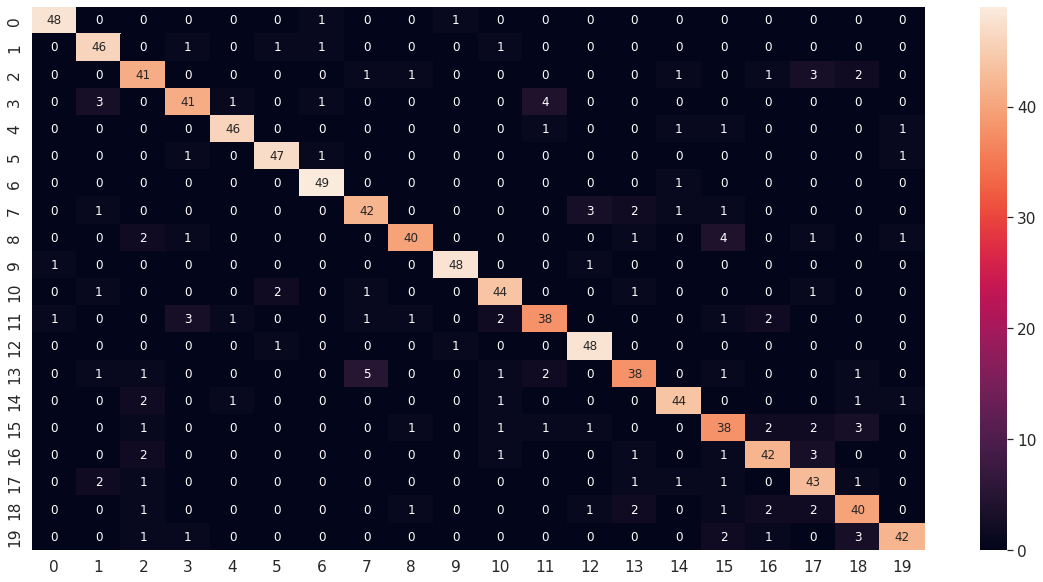

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg2_17_df_CM = pd.DataFrame(deepface_model_vgg2_17_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg2_17_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg2_17_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg2_17_report)

              precision    recall  f1-score   support

           1       0.96      0.96      0.96        50
           2       0.85      0.92      0.88        50
           3       0.79      0.82      0.80        50
           4       0.85      0.82      0.84        50
           5       0.94      0.92      0.93        50
           6       0.92      0.94      0.93        50
           7       0.92      0.98      0.95        50
           8       0.84      0.84      0.84        50
           9       0.91      0.80      0.85        50
          10       0.96      0.96      0.96        50
          11       0.86      0.88      0.87        50
          12       0.83      0.76      0.79        50
          13       0.89      0.96      0.92        50
          14       0.83      0.76      0.79        50
          15       0.90      0.88      0.89        50
          16       0.75      0.76      0.75        50
          17       0.84      0.84      0.84        50
          18       0.78    

## 9. Modelos con base de datos VGG-Latin para condiciones de etnia

#### Modelo 1: (BTH = 30, EHS = 30, ValidSplit = 0.2, Dropout=0, INI = HeNormal, REG = L2, OPT = adam[0.001])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg3_1 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg3_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final dropout y softmax de 11 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg3_1.add(Dropout(rate=0, name='D0'))
deepface_model_vgg3_1.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg3_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)    
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.001)
deepface_model_vgg3_1.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_1.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg3_1 = deepface_model_vgg3_1.fit(new_trainX, new_trainY, batch_size=30, epochs=30, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
74/74 [==============================] - 152s 671ms/step - loss: 2.4961 - accuracy: 0.5625 - val_loss: 1.6557 - val_accuracy: 0.6636
Epoch 2/30
74/74 [==============================] - 16s 215ms/step - loss: 0.8501 - accuracy: 0.8395 - val_loss: 1.1278 - val_accuracy: 0.7800
Epoch 3/30
74/74 [==============================] - 11s 153ms/step - loss: 0.5824 - accuracy: 0.9063 - val_loss: 1.5411 - val_accuracy: 0.7673
Epoch 4/30
74/74 [==============================] - 12s 158ms/step - loss: 0.6764 - accuracy: 0.8981 - val_loss: 1.7702 - val_accuracy: 0.7764
Epoch 5/30
74/74 [==============================] - 11s 154ms/step - loss: 0.5052 - accuracy: 0.9286 - val_loss: 1.5778 - val_accuracy: 0.7745
Epoch 6/30
74/74 [==============================] - 11s 152ms/step - loss: 0.4970 - accuracy: 0.9304 - val_loss: 1.8706 - val_accuracy: 0.7618
Epoch 7/30
74/74 [==============================] - 11s 154ms/step - loss: 0.6772 - accuracy: 0.9136 - val_loss: 2.2741 - val_accuracy: 0.743

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg3_1 = load_model(path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_1.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg3_1.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg3_1.evaluate(testX, testY)

32/32 [==============================] - 2s 71ms/step - loss: 1.2200 - accuracy: 0.7620


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg3_1.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg3_1_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 2s 76ms/step


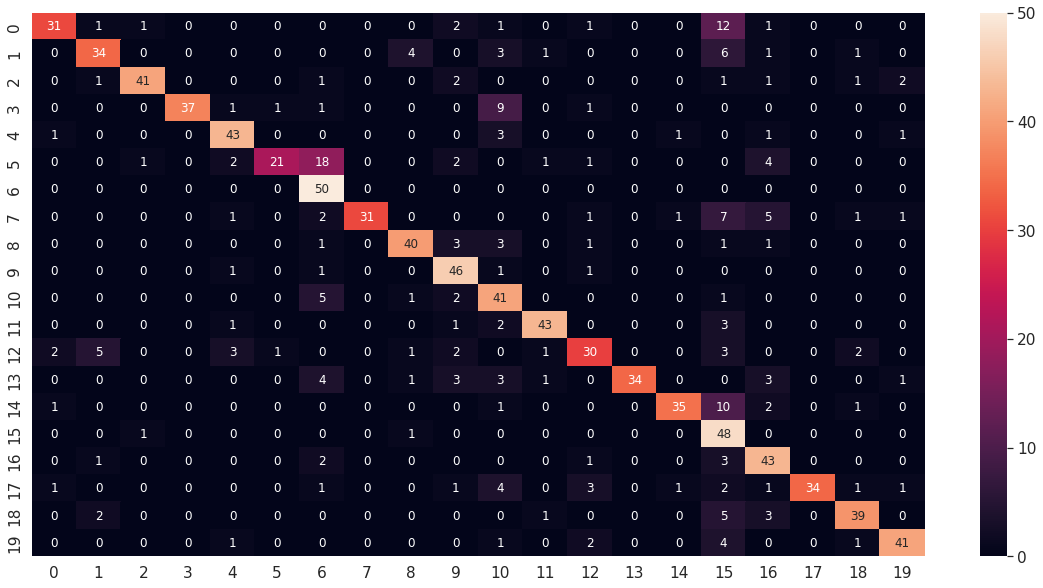

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg3_1_df_CM = pd.DataFrame(deepface_model_vgg3_1_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg3_1_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
2# Resumen de clasificación
deepface_model_vgg3_1_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg3_1_report)

              precision    recall  f1-score   support

           1       0.86      0.62      0.72        50
           2       0.77      0.68      0.72        50
           3       0.93      0.82      0.87        50
           4       1.00      0.74      0.85        50
           5       0.81      0.86      0.83        50
           6       0.91      0.42      0.58        50
           7       0.58      1.00      0.74        50
           8       1.00      0.62      0.77        50
           9       0.83      0.80      0.82        50
          10       0.72      0.92      0.81        50
          11       0.57      0.82      0.67        50
          12       0.90      0.86      0.88        50
          13       0.71      0.60      0.65        50
          14       1.00      0.68      0.81        50
          15       0.92      0.70      0.80        50
          16       0.45      0.96      0.62        50
          17       0.65      0.86      0.74        50
          18       1.00    

#### Modelo 2: (BTH = 30, EHS = 50, ValidSplit = 0.2, Dropout=0, INI = HeNormal, REG = L2, OPT = adam[0.0001])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg3_2 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg3_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final dropout y softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg3_2.add(Dropout(rate=0, name='D0'))
deepface_model_vgg3_2.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg3_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)    
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.0001)
deepface_model_vgg3_2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_2.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg3_2 = deepface_model_vgg3_2.fit(new_trainX, new_trainY, batch_size=30, epochs=50, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/50
74/74 [==============================] - 143s 646ms/step - loss: 11.7438 - accuracy: 0.3456 - val_loss: 3.5748 - val_accuracy: 0.5491
Epoch 2/50
74/74 [==============================] - 16s 212ms/step - loss: 1.3959 - accuracy: 0.8054 - val_loss: 2.4076 - val_accuracy: 0.7164
Epoch 3/50
74/74 [==============================] - 16s 222ms/step - loss: 0.4497 - accuracy: 0.9363 - val_loss: 2.1634 - val_accuracy: 0.7509
Epoch 4/50
74/74 [==============================] - 17s 225ms/step - loss: 0.2109 - accuracy: 0.9759 - val_loss: 2.0382 - val_accuracy: 0.7673
Epoch 5/50
74/74 [==============================] - 16s 222ms/step - loss: 0.1283 - accuracy: 0.9882 - val_loss: 1.9961 - val_accuracy: 0.7691
Epoch 6/50
74/74 [==============================] - 17s 228ms/step - loss: 0.0909 - accuracy: 0.9955 - val_loss: 1.9689 - val_accuracy: 0.7764
Epoch 7/50
74/74 [==============================] - 16s 221ms/step - loss: 0.0734 - accuracy: 0.9986 - val_loss: 1.9547 - val_accuracy: 0.78

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg3_2 = load_model(path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_2.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg3_2.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg3_2.evaluate(testX, testY)

32/32 [==============================] - 2s 66ms/step - loss: 1.5202 - accuracy: 0.8220


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg3_2.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg3_2_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 35s 64ms/step


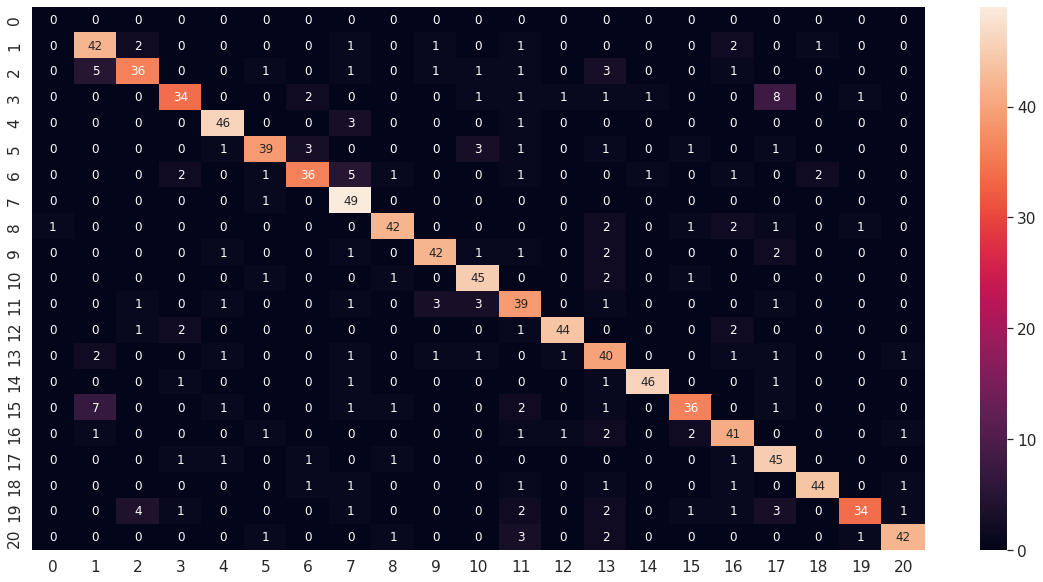

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg3_2_df_CM = pd.DataFrame(deepface_model_vgg3_2_CM, range(21), range(21))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg3_2_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg3_2_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg3_2_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.74      0.84      0.79        50
           2       0.82      0.72      0.77        50
           3       0.83      0.68      0.75        50
           4       0.88      0.92      0.90        50
           5       0.87      0.78      0.82        50
           6       0.84      0.72      0.77        50
           7       0.74      0.98      0.84        50
           8       0.89      0.84      0.87        50
           9       0.88      0.84      0.86        50
          10       0.82      0.90      0.86        50
          11       0.70      0.78      0.74        50
          12       0.94      0.88      0.91        50
          13       0.66      0.80      0.72        50
          14       0.96      0.92      0.94        50
          15       0.86      0.72      0.78        50
          16       0.77      0.82      0.80        50
          17       0.70    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Modelo 3: (BTH = 10, EHS = 50, ValidSplit = 0.2, Dropout=0, INI = HeNormal, REG = L2, OPT = adam[0.0001])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg3_3 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg3_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final dropout y softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg3_3.add(Dropout(rate=0, name='D0'))
deepface_model_vgg3_3.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg3_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)    
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.0001)
deepface_model_vgg3_3.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_3.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg3_3 = deepface_model_vgg3_3.fit(new_trainX, new_trainY, batch_size=10, epochs=50, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/50
220/220 [==============================] - 158s 296ms/step - loss: 7.4470 - accuracy: 0.5211 - val_loss: 2.3756 - val_accuracy: 0.6964
Epoch 2/50
220/220 [==============================] - 31s 139ms/step - loss: 0.3735 - accuracy: 0.9327 - val_loss: 1.9938 - val_accuracy: 0.7636
Epoch 3/50
220/220 [==============================] - 37s 170ms/step - loss: 0.0821 - accuracy: 0.9923 - val_loss: 1.9018 - val_accuracy: 0.7673
Epoch 4/50
220/220 [==============================] - 38s 172ms/step - loss: 0.0481 - accuracy: 0.9986 - val_loss: 1.8884 - val_accuracy: 0.7673
Epoch 5/50
220/220 [==============================] - 36s 166ms/step - loss: 0.0404 - accuracy: 1.0000 - val_loss: 1.8723 - val_accuracy: 0.7782
Epoch 6/50
220/220 [==============================] - 37s 170ms/step - loss: 0.0382 - accuracy: 1.0000 - val_loss: 1.8650 - val_accuracy: 0.7764
Epoch 7/50
220/220 [==============================] - 37s 169ms/step - loss: 0.0369 - accuracy: 1.0000 - val_loss: 1.8558 - val_a

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg3_3 = load_model(path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_3.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg3_3.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg3_3.evaluate(testX, testY)

32/32 [==============================] - 2s 67ms/step - loss: 1.0259 - accuracy: 0.8670


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg3_3.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg3_3_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 40s 65ms/step


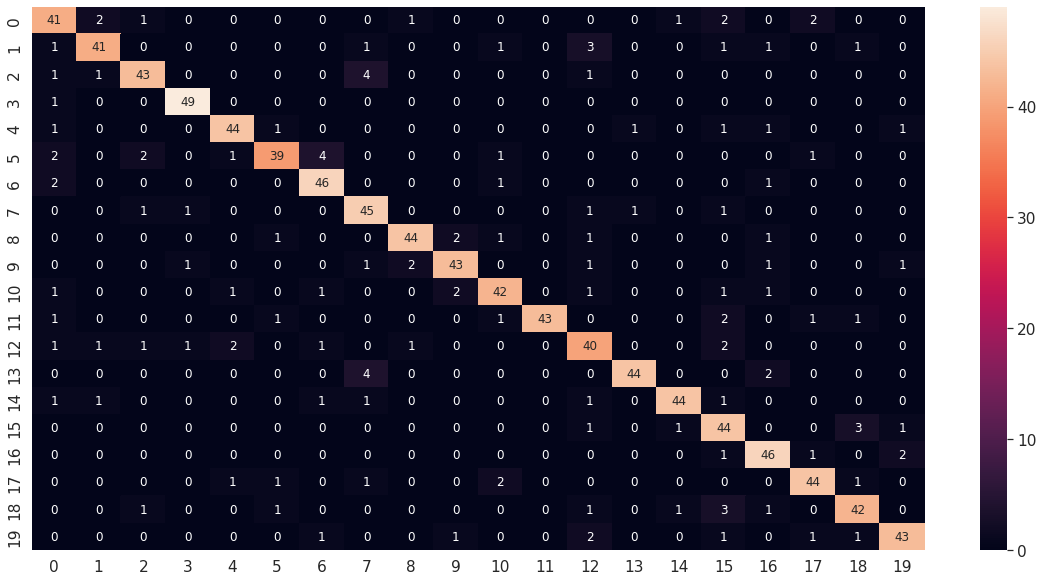

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg3_3_df_CM = pd.DataFrame(deepface_model_vgg3_3_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg3_3_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg3_3_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg3_3_report)

              precision    recall  f1-score   support

           1       0.77      0.82      0.80        50
           2       0.89      0.82      0.85        50
           3       0.88      0.86      0.87        50
           4       0.94      0.98      0.96        50
           5       0.90      0.88      0.89        50
           6       0.89      0.78      0.83        50
           7       0.85      0.92      0.88        50
           8       0.79      0.90      0.84        50
           9       0.92      0.88      0.90        50
          10       0.90      0.86      0.88        50
          11       0.86      0.84      0.85        50
          12       1.00      0.86      0.92        50
          13       0.75      0.80      0.78        50
          14       0.96      0.88      0.92        50
          15       0.94      0.88      0.91        50
          16       0.73      0.88      0.80        50
          17       0.84      0.92      0.88        50
          18       0.88    

#### Modelo 4: (BTH = 40, EHS = 50, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2, OPT = adam[0.0001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg3_4 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg3_4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg3_4.add(Dropout(rate=0, name='D0'))
deepface_model_vgg3_4.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg3_4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.0001)
deepface_model_vgg3_4.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_4.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg3_4 = deepface_model_vgg3_4.fit(new_trainX, new_trainY, batch_size=40, epochs=50, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/50
55/55 [==============================] - 161s 1s/step - loss: 0.2281 - accuracy: 0.9777 - val_loss: 0.9712 - val_accuracy: 0.8473
Epoch 2/50
55/55 [==============================] - 14s 264ms/step - loss: 0.0973 - accuracy: 1.0000 - val_loss: 0.8919 - val_accuracy: 0.8564
Epoch 3/50
55/55 [==============================] - 14s 260ms/step - loss: 0.0757 - accuracy: 1.0000 - val_loss: 0.8556 - val_accuracy: 0.8600
Epoch 4/50
55/55 [==============================] - 15s 278ms/step - loss: 0.0627 - accuracy: 1.0000 - val_loss: 0.8308 - val_accuracy: 0.8600
Epoch 5/50
55/55 [==============================] - 14s 256ms/step - loss: 0.0541 - accuracy: 1.0000 - val_loss: 0.8101 - val_accuracy: 0.8582
Epoch 6/50
55/55 [==============================] - 15s 269ms/step - loss: 0.0481 - accuracy: 1.0000 - val_loss: 0.7924 - val_accuracy: 0.8600
Epoch 7/50
55/55 [==============================] - 15s 268ms/step - loss: 0.0436 - accuracy: 1.0000 - val_loss: 0.7774 - val_accuracy: 0.8618
E

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg3_4 = load_model(path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_4.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg3_4.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg3_4.evaluate(testX, testY)

32/32 [==============================] - 2s 74ms/step - loss: 0.5868 - accuracy: 0.8960


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg3_4.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg3_4_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 36s 67ms/step


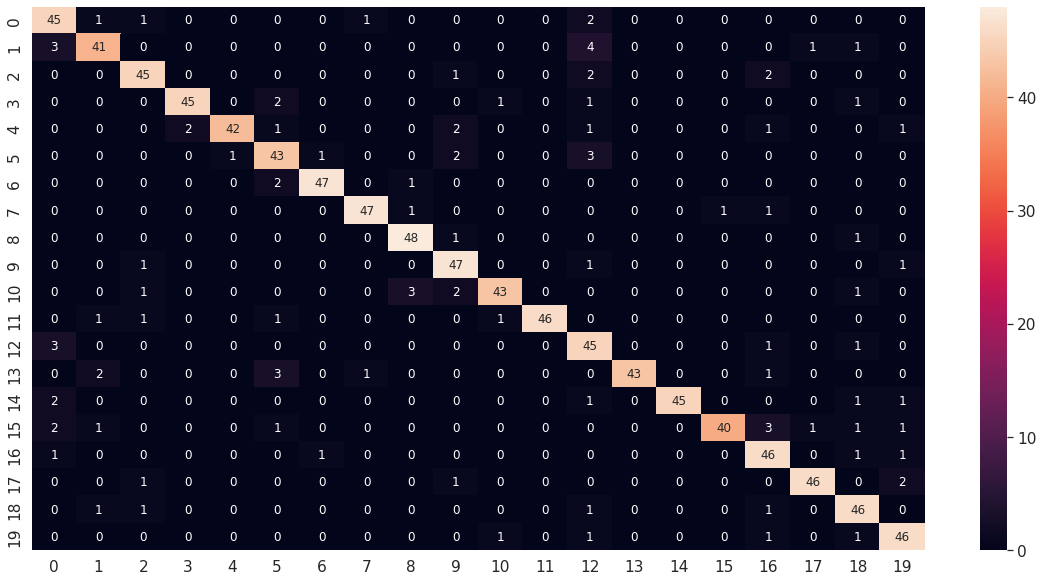

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg3_4_df_CM = pd.DataFrame(deepface_model_vgg3_4_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg3_4_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg3_4_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg3_4_report)

              precision    recall  f1-score   support

           1       0.80      0.90      0.85        50
           2       0.87      0.82      0.85        50
           3       0.88      0.90      0.89        50
           4       0.96      0.90      0.93        50
           5       0.98      0.84      0.90        50
           6       0.81      0.86      0.83        50
           7       0.96      0.94      0.95        50
           8       0.96      0.94      0.95        50
           9       0.91      0.96      0.93        50
          10       0.84      0.94      0.89        50
          11       0.93      0.86      0.90        50
          12       1.00      0.92      0.96        50
          13       0.73      0.90      0.80        50
          14       1.00      0.86      0.92        50
          15       1.00      0.90      0.95        50
          16       0.98      0.80      0.88        50
          17       0.81      0.92      0.86        50
          18       0.96    

#### Modelo 5: (BTH = 20, EHS = 40, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2, OPT = adam[0.0001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg3_5 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg3_5.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 21 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg3_5.add(Dropout(rate=0, name='D0'))
deepface_model_vgg3_5.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg3_5.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.0001)
deepface_model_vgg3_5.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_5.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg3_5 = deepface_model_vgg3_5.fit(new_trainX, new_trainY, batch_size=20, epochs=40, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/40
110/110 [==============================] - 154s 527ms/step - loss: 1.7256 - accuracy: 0.7908 - val_loss: 0.8871 - val_accuracy: 0.8400
Epoch 2/40
110/110 [==============================] - 20s 184ms/step - loss: 0.2382 - accuracy: 0.9982 - val_loss: 0.7863 - val_accuracy: 0.8473
Epoch 3/40
110/110 [==============================] - 21s 187ms/step - loss: 0.1825 - accuracy: 1.0000 - val_loss: 0.7444 - val_accuracy: 0.8545
Epoch 4/40
110/110 [==============================] - 21s 189ms/step - loss: 0.1566 - accuracy: 1.0000 - val_loss: 0.7238 - val_accuracy: 0.8545
Epoch 5/40
110/110 [==============================] - 20s 186ms/step - loss: 0.1424 - accuracy: 1.0000 - val_loss: 0.7096 - val_accuracy: 0.8582
Epoch 6/40
110/110 [==============================] - 20s 186ms/step - loss: 0.1335 - accuracy: 1.0000 - val_loss: 0.6938 - val_accuracy: 0.8564
Epoch 7/40
110/110 [==============================] - 21s 190ms/step - loss: 0.1270 - accuracy: 1.0000 - val_loss: 0.6800 - val_a

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg3_5 = load_model(path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_5.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg3_5.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg3_5.evaluate(testX, testY)

32/32 [==============================] - 2s 69ms/step - loss: 0.6230 - accuracy: 0.8930


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg3_5.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg3_5_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

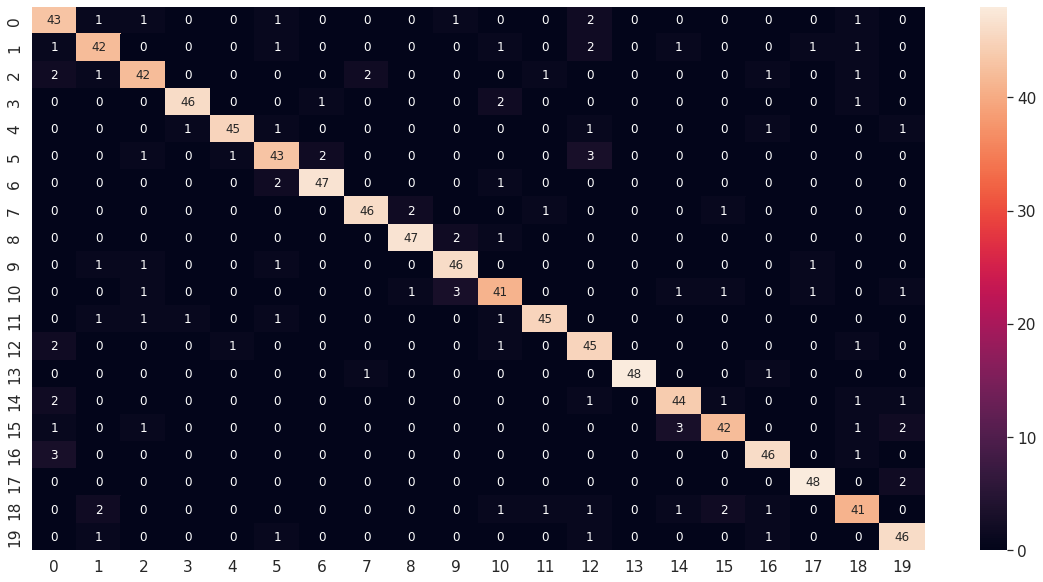

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg3_5_df_CM = pd.DataFrame(deepface_model_vgg3_5_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg3_5_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg3_5_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg3_5_report)

              precision    recall  f1-score   support

           1       0.80      0.86      0.83        50
           2       0.86      0.84      0.85        50
           3       0.88      0.84      0.86        50
           4       0.96      0.92      0.94        50
           5       0.96      0.90      0.93        50
           6       0.84      0.86      0.85        50
           7       0.94      0.94      0.94        50
           8       0.94      0.92      0.93        50
           9       0.94      0.94      0.94        50
          10       0.88      0.92      0.90        50
          11       0.84      0.82      0.83        50
          12       0.94      0.90      0.92        50
          13       0.80      0.90      0.85        50
          14       1.00      0.96      0.98        50
          15       0.88      0.88      0.88        50
          16       0.89      0.84      0.87        50
          17       0.90      0.92      0.91        50
          18       0.94    

#### Modelo 6: (BTH = 10, EHS = 50, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = none, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg3_6 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg3_6.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg3_6.add(Dropout(rate=0, name='D0'))
deepface_model_vgg3_6.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg3_6.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_vgg3_6.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_6.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg3_6 = deepface_model_vgg3_6.fit(new_trainX, new_trainY, batch_size=10, epochs=50, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/50
220/220 [==============================] - 182s 332ms/step - loss: 0.8371 - accuracy: 0.9191 - val_loss: 0.8372 - val_accuracy: 0.8564
Epoch 2/50
220/220 [==============================] - 37s 169ms/step - loss: 0.1017 - accuracy: 0.9995 - val_loss: 0.8057 - val_accuracy: 0.8655
Epoch 3/50
220/220 [==============================] - 32s 147ms/step - loss: 0.0962 - accuracy: 1.0000 - val_loss: 0.8003 - val_accuracy: 0.8673
Epoch 4/50
220/220 [==============================] - 38s 172ms/step - loss: 0.0929 - accuracy: 1.0000 - val_loss: 0.7956 - val_accuracy: 0.8691
Epoch 5/50
220/220 [==============================] - 37s 168ms/step - loss: 0.0897 - accuracy: 1.0000 - val_loss: 0.7919 - val_accuracy: 0.8727
Epoch 6/50
220/220 [==============================] - 37s 171ms/step - loss: 0.0865 - accuracy: 1.0000 - val_loss: 0.7914 - val_accuracy: 0.8727
Epoch 7/50
220/220 [==============================] - 28s 125ms/step - loss: 0.0832 - accuracy: 1.0000 - val_loss: 0.7940 - val_a

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg3_6 = load_model(path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_6.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg3_6.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg3_6.evaluate(testX, testY)

32/32 [==============================] - 2s 68ms/step - loss: 0.4629 - accuracy: 0.9130


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg3_6.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg3_6_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 36s 66ms/step


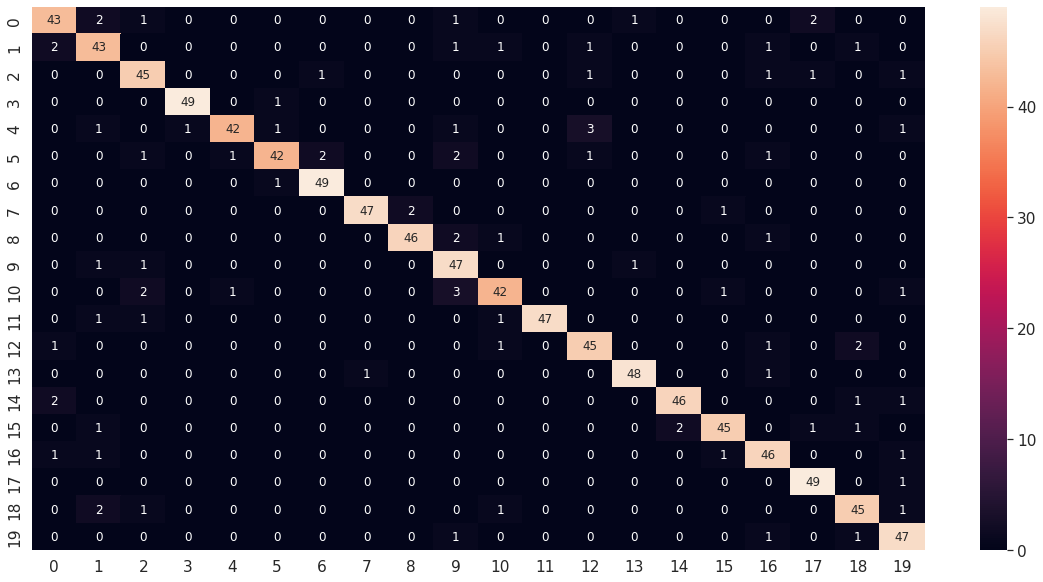

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg3_6_df_CM = pd.DataFrame(deepface_model_vgg3_6_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg3_6_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg3_6_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg3_6_report)

              precision    recall  f1-score   support

           1       0.88      0.86      0.87        50
           2       0.83      0.86      0.84        50
           3       0.87      0.90      0.88        50
           4       0.98      0.98      0.98        50
           5       0.95      0.84      0.89        50
           6       0.93      0.84      0.88        50
           7       0.94      0.98      0.96        50
           8       0.98      0.94      0.96        50
           9       0.96      0.92      0.94        50
          10       0.81      0.94      0.87        50
          11       0.89      0.84      0.87        50
          12       1.00      0.94      0.97        50
          13       0.88      0.90      0.89        50
          14       0.96      0.96      0.96        50
          15       0.96      0.92      0.94        50
          16       0.94      0.90      0.92        50
          17       0.87      0.92      0.89        50
          18       0.92    

#### Modelo 7: (BTH = 20, EHS = 50, ValidSplit = 0.2, INI = none, Dropout=0 REG = L2, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg3_7 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg3_7.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg3_7.add(Dropout(rate=0, name='D0'))
deepface_model_vgg3_7.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg3_7.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)  
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_vgg3_7.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_7.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg3_7 = deepface_model_vgg3_7.fit(new_trainX, new_trainY, batch_size=20, epochs=50, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/50
110/110 [==============================] - 146s 458ms/step - loss: 1.5927 - accuracy: 0.7117 - val_loss: 0.8929 - val_accuracy: 0.8309
Epoch 2/50
110/110 [==============================] - 19s 171ms/step - loss: 0.3317 - accuracy: 0.9836 - val_loss: 0.7163 - val_accuracy: 0.8891
Epoch 3/50
110/110 [==============================] - 19s 170ms/step - loss: 0.2693 - accuracy: 1.0000 - val_loss: 0.6689 - val_accuracy: 0.8873
Epoch 4/50
110/110 [==============================] - 19s 172ms/step - loss: 0.2525 - accuracy: 1.0000 - val_loss: 0.6458 - val_accuracy: 0.8945
Epoch 5/50
110/110 [==============================] - 19s 173ms/step - loss: 0.2390 - accuracy: 1.0000 - val_loss: 0.6278 - val_accuracy: 0.8964
Epoch 6/50
110/110 [==============================] - 19s 173ms/step - loss: 0.2262 - accuracy: 1.0000 - val_loss: 0.6125 - val_accuracy: 0.8964
Epoch 7/50
110/110 [==============================] - 19s 176ms/step - loss: 0.2137 - accuracy: 1.0000 - val_loss: 0.5977 - val_a

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg3_7 = load_model(path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_7.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg3_7.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg3_7.evaluate(testX, testY)

32/32 [==============================] - 2s 66ms/step - loss: 0.3222 - accuracy: 0.9160


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg3_7.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg3_7_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 33s 61ms/step


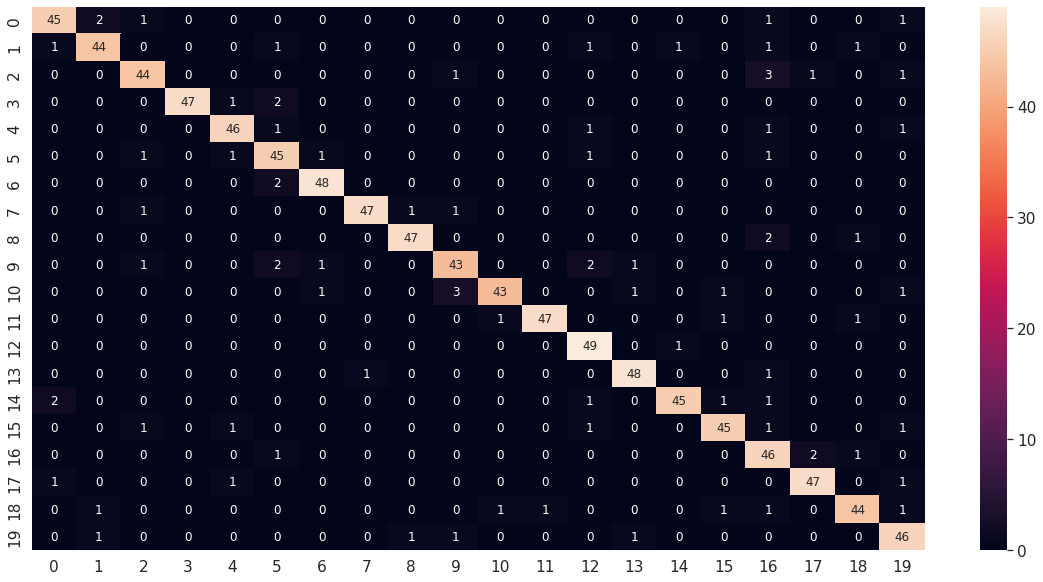

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg3_7_df_CM = pd.DataFrame(deepface_model_vgg3_7_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg3_7_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg3_7_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg3_7_report)

              precision    recall  f1-score   support

           1       0.92      0.90      0.91        50
           2       0.92      0.88      0.90        50
           3       0.90      0.88      0.89        50
           4       1.00      0.94      0.97        50
           5       0.92      0.92      0.92        50
           6       0.83      0.90      0.87        50
           7       0.94      0.96      0.95        50
           8       0.98      0.94      0.96        50
           9       0.96      0.94      0.95        50
          10       0.88      0.86      0.87        50
          11       0.96      0.86      0.91        50
          12       0.98      0.94      0.96        50
          13       0.88      0.98      0.92        50
          14       0.94      0.96      0.95        50
          15       0.96      0.90      0.93        50
          16       0.92      0.90      0.91        50
          17       0.78      0.92      0.84        50
          18       0.94    

#### Modelo 8: (BTH = 30, EHS = 50, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = none, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg3_8 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg3_8.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg3_8.add(Dropout(rate=0, name='D0'))
deepface_model_vgg3_8.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg3_8.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)  
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_vgg3_8.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_8.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg3_8 = deepface_model_vgg3_8.fit(new_trainX, new_trainY, batch_size=30, epochs=50, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/50
74/74 [==============================] - 134s 638ms/step - loss: 1.4251 - accuracy: 0.8258 - val_loss: 0.8196 - val_accuracy: 0.8564
Epoch 2/50
74/74 [==============================] - 16s 211ms/step - loss: 0.2283 - accuracy: 0.9986 - val_loss: 0.7947 - val_accuracy: 0.8691
Epoch 3/50
74/74 [==============================] - 16s 211ms/step - loss: 0.2130 - accuracy: 1.0000 - val_loss: 0.7760 - val_accuracy: 0.8691
Epoch 4/50
74/74 [==============================] - 16s 220ms/step - loss: 0.2047 - accuracy: 1.0000 - val_loss: 0.7579 - val_accuracy: 0.8709
Epoch 5/50
74/74 [==============================] - 16s 220ms/step - loss: 0.1975 - accuracy: 1.0000 - val_loss: 0.7454 - val_accuracy: 0.8745
Epoch 6/50
74/74 [==============================] - 16s 214ms/step - loss: 0.1908 - accuracy: 1.0000 - val_loss: 0.7415 - val_accuracy: 0.8782
Epoch 7/50
74/74 [==============================] - 16s 220ms/step - loss: 0.1846 - accuracy: 1.0000 - val_loss: 0.7362 - val_accuracy: 0.878

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg3_8 = load_model(path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_8.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg3_8.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg3_8.evaluate(testX, testY)

32/32 [==============================] - 2s 64ms/step - loss: 0.5267 - accuracy: 0.9000


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg3_8.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg3_8_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

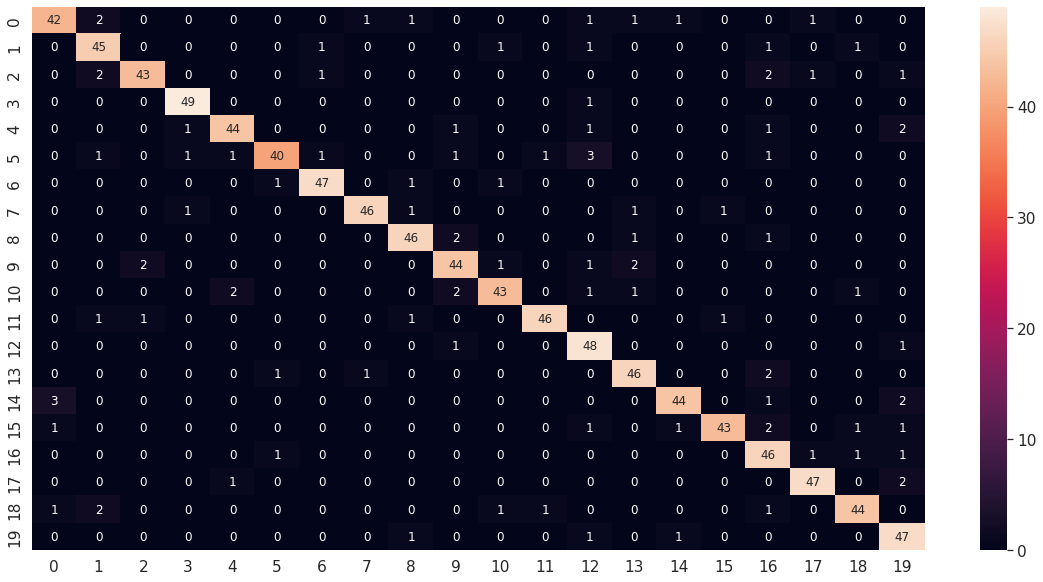

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg3_8_df_CM = pd.DataFrame(deepface_model_vgg3_8_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg3_8_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg3_8_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg3_8_report)

              precision    recall  f1-score   support

           1       0.89      0.84      0.87        50
           2       0.85      0.90      0.87        50
           3       0.93      0.86      0.90        50
           4       0.94      0.98      0.96        50
           5       0.92      0.88      0.90        50
           6       0.93      0.80      0.86        50
           7       0.94      0.94      0.94        50
           8       0.96      0.92      0.94        50
           9       0.90      0.92      0.91        50
          10       0.86      0.88      0.87        50
          11       0.91      0.86      0.89        50
          12       0.96      0.92      0.94        50
          13       0.81      0.96      0.88        50
          14       0.88      0.92      0.90        50
          15       0.94      0.88      0.91        50
          16       0.96      0.86      0.91        50
          17       0.79      0.92      0.85        50
          18       0.94    

#### Modelo 9: (BTH = 40, EHS = 50, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg3_9 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg3_9.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg3_9.add(Dropout(rate=0, name='D0'))
deepface_model_vgg3_9.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg3_9.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_vgg3_9.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_9.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg3_9 = deepface_model_vgg3_9.fit(new_trainX, new_trainY, batch_size=40, epochs=50, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/50
55/55 [==============================] - 146s 906ms/step - loss: 5.7332 - accuracy: 0.6940 - val_loss: 0.7882 - val_accuracy: 0.8345
Epoch 2/50
55/55 [==============================] - 15s 266ms/step - loss: 0.2214 - accuracy: 0.9927 - val_loss: 0.7126 - val_accuracy: 0.8582
Epoch 3/50
55/55 [==============================] - 14s 263ms/step - loss: 0.1875 - accuracy: 1.0000 - val_loss: 0.6914 - val_accuracy: 0.8636
Epoch 4/50
55/55 [==============================] - 10s 174ms/step - loss: 0.1828 - accuracy: 1.0000 - val_loss: 0.7007 - val_accuracy: 0.8582
Epoch 5/50
55/55 [==============================] - 10s 174ms/step - loss: 0.1796 - accuracy: 1.0000 - val_loss: 0.7212 - val_accuracy: 0.8673
Epoch 6/50
55/55 [==============================] - 10s 174ms/step - loss: 0.1769 - accuracy: 1.0000 - val_loss: 0.7451 - val_accuracy: 0.8636
Epoch 7/50
55/55 [==============================] - 10s 176ms/step - loss: 0.1746 - accuracy: 1.0000 - val_loss: 0.7851 - val_accuracy: 0.863

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg3_9 = load_model(path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_9.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg3_9.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg3_9.evaluate(testX, testY)

32/32 [==============================] - 2s 64ms/step - loss: 0.6696 - accuracy: 0.8900


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg3_9.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg3_9_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 32s 62ms/step


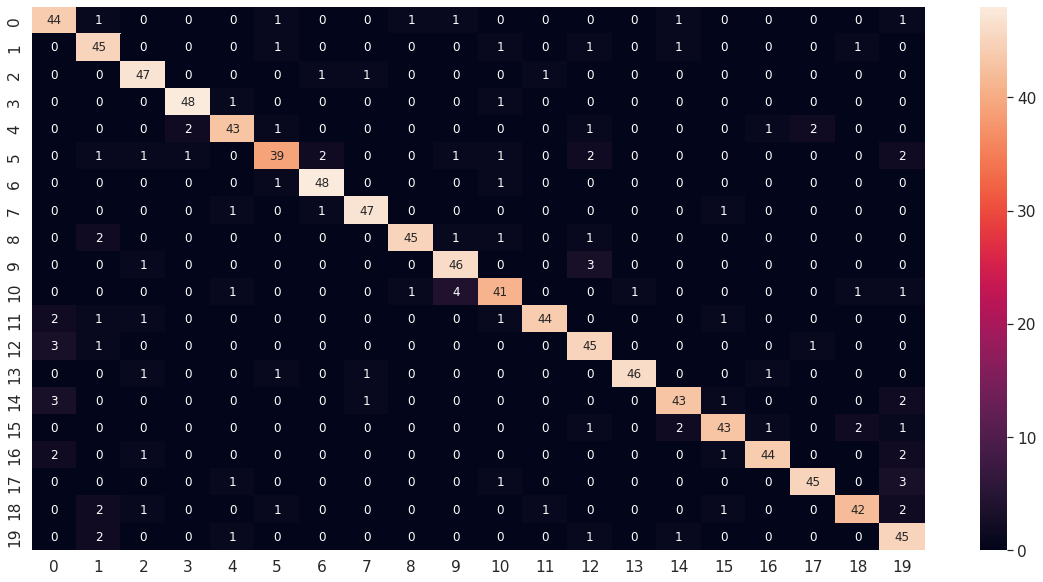

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg3_9_df_CM = pd.DataFrame(deepface_model_vgg3_9_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg3_9_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg3_9_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg3_9_report)

              precision    recall  f1-score   support

           1       0.81      0.88      0.85        50
           2       0.82      0.90      0.86        50
           3       0.89      0.94      0.91        50
           4       0.94      0.96      0.95        50
           5       0.90      0.86      0.88        50
           6       0.87      0.78      0.82        50
           7       0.92      0.96      0.94        50
           8       0.94      0.94      0.94        50
           9       0.96      0.90      0.93        50
          10       0.87      0.92      0.89        50
          11       0.85      0.82      0.84        50
          12       0.96      0.88      0.92        50
          13       0.82      0.90      0.86        50
          14       0.98      0.92      0.95        50
          15       0.90      0.86      0.88        50
          16       0.90      0.86      0.88        50
          17       0.94      0.88      0.91        50
          18       0.94    

#### Modelo 10: (BTH = 50, EHS = 50, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg3_10 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg3_10.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg3_10.add(Dropout(rate=0, name='D0'))
deepface_model_vgg3_10.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg3_10.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_vgg3_10.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_10.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg3_10 = deepface_model_vgg3_10.fit(new_trainX, new_trainY, batch_size=50, epochs=50, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/50
44/44 [==============================] - 153s 1s/step - loss: 1.9488 - accuracy: 0.6703 - val_loss: 0.7761 - val_accuracy: 0.8782
Epoch 2/50
44/44 [==============================] - 14s 309ms/step - loss: 0.3636 - accuracy: 0.9886 - val_loss: 0.7359 - val_accuracy: 0.8818
Epoch 3/50
44/44 [==============================] - 13s 305ms/step - loss: 0.3086 - accuracy: 1.0000 - val_loss: 0.6505 - val_accuracy: 0.9073
Epoch 4/50
44/44 [==============================] - 13s 305ms/step - loss: 0.2922 - accuracy: 1.0000 - val_loss: 0.6301 - val_accuracy: 0.9073
Epoch 5/50
44/44 [==============================] - 14s 317ms/step - loss: 0.2804 - accuracy: 1.0000 - val_loss: 0.6162 - val_accuracy: 0.9073
Epoch 6/50
44/44 [==============================] - 13s 306ms/step - loss: 0.2698 - accuracy: 1.0000 - val_loss: 0.6031 - val_accuracy: 0.9073
Epoch 7/50
44/44 [==============================] - 14s 326ms/step - loss: 0.2599 - accuracy: 1.0000 - val_loss: 0.5916 - val_accuracy: 0.9073
E

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg3_10 = load_model(path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_10.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg3_10.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg3_10.evaluate(testX, testY)

32/32 [==============================] - 2s 71ms/step - loss: 0.3778 - accuracy: 0.9150


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg3_10.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg3_10_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 34s 67ms/step


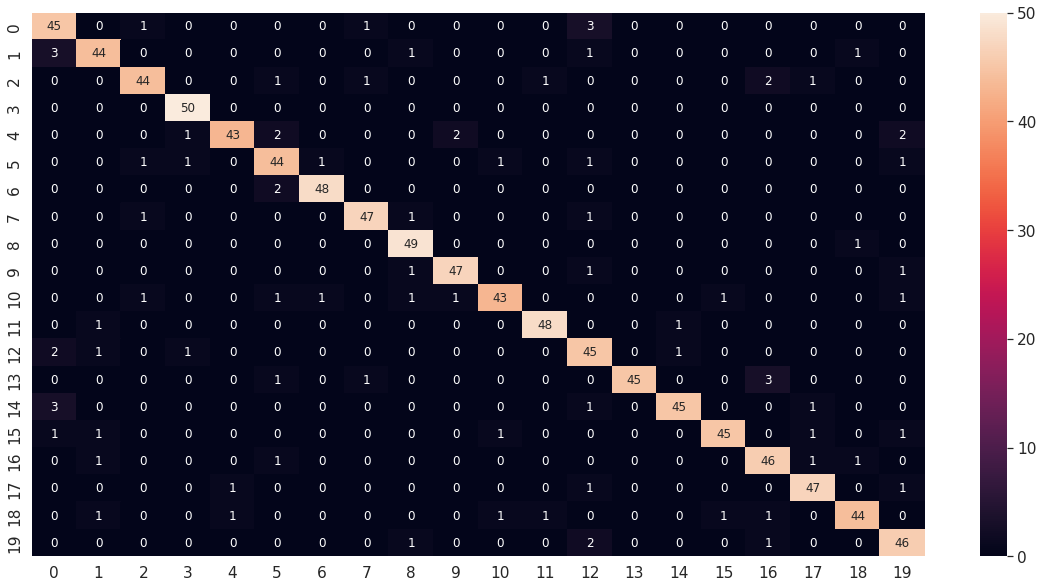

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg3_10_df_CM = pd.DataFrame(deepface_model_vgg3_10_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg3_10_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg3_10_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg3_10_report)

              precision    recall  f1-score   support

           1       0.83      0.90      0.87        50
           2       0.90      0.88      0.89        50
           3       0.92      0.88      0.90        50
           4       0.94      1.00      0.97        50
           5       0.96      0.86      0.91        50
           6       0.85      0.88      0.86        50
           7       0.96      0.96      0.96        50
           8       0.94      0.94      0.94        50
           9       0.91      0.98      0.94        50
          10       0.94      0.94      0.94        50
          11       0.93      0.86      0.90        50
          12       0.96      0.96      0.96        50
          13       0.80      0.90      0.85        50
          14       1.00      0.90      0.95        50
          15       0.96      0.90      0.93        50
          16       0.96      0.90      0.93        50
          17       0.87      0.92      0.89        50
          18       0.92    

#### Modelo 11: (BTH = 10, EHS = 50, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT =  SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg3_11 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg3_11.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg3_11.add(Dropout(rate=0, name='D0'))
deepface_model_vgg3_11.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg3_11.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg3_11.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_11.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg3_11 = deepface_model_vgg3_11.fit(new_trainX, new_trainY, batch_size=10, epochs=50, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/50
220/220 [==============================] - 153s 254ms/step - loss: 1.4135 - accuracy: 0.7322 - val_loss: 0.8364 - val_accuracy: 0.8745
Epoch 2/50
220/220 [==============================] - 30s 138ms/step - loss: 0.4228 - accuracy: 0.9950 - val_loss: 0.6887 - val_accuracy: 0.9145
Epoch 3/50
220/220 [==============================] - 31s 139ms/step - loss: 0.3691 - accuracy: 1.0000 - val_loss: 0.6278 - val_accuracy: 0.9164
Epoch 4/50
220/220 [==============================] - 30s 135ms/step - loss: 0.3381 - accuracy: 1.0000 - val_loss: 0.5925 - val_accuracy: 0.9255
Epoch 5/50
220/220 [==============================] - 30s 135ms/step - loss: 0.3108 - accuracy: 1.0000 - val_loss: 0.5632 - val_accuracy: 0.9236
Epoch 6/50
220/220 [==============================] - 31s 140ms/step - loss: 0.2859 - accuracy: 1.0000 - val_loss: 0.5395 - val_accuracy: 0.9236
Epoch 7/50
220/220 [==============================] - 31s 139ms/step - loss: 0.2632 - accuracy: 1.0000 - val_loss: 0.5148 - val_a

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg3_11 = load_model(path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_11.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg3_11.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg3_11.evaluate(testX, testY)

32/32 [==============================] - 2s 65ms/step - loss: 0.2059 - accuracy: 0.9450


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg3_11.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg3_11_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

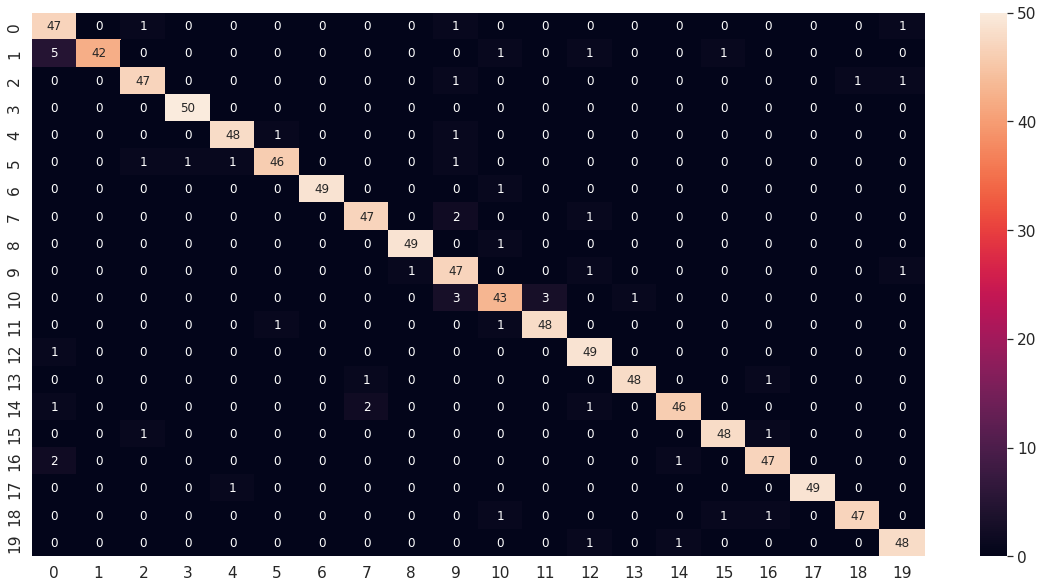

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg3_11_df_CM = pd.DataFrame(deepface_model_vgg3_11_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg3_11_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg3_11_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg3_11_report)

              precision    recall  f1-score   support

           1       0.84      0.94      0.89        50
           2       1.00      0.84      0.91        50
           3       0.94      0.94      0.94        50
           4       0.98      1.00      0.99        50
           5       0.96      0.96      0.96        50
           6       0.96      0.92      0.94        50
           7       1.00      0.98      0.99        50
           8       0.94      0.94      0.94        50
           9       0.98      0.98      0.98        50
          10       0.84      0.94      0.89        50
          11       0.90      0.86      0.88        50
          12       0.94      0.96      0.95        50
          13       0.91      0.98      0.94        50
          14       0.98      0.96      0.97        50
          15       0.96      0.92      0.94        50
          16       0.96      0.96      0.96        50
          17       0.94      0.94      0.94        50
          18       1.00    

#### Modelo 12: (BTH = 20, EHS = 50, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg3_12 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg3_12.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg3_12.add(Dropout(rate=0, name='D0'))
deepface_model_vgg3_12.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg3_12.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg3_12.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_12.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg3_12 = deepface_model_vgg3_12.fit(new_trainX, new_trainY, batch_size=20, epochs=50, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/50
110/110 [==============================] - 138s 438ms/step - loss: 1.2337 - accuracy: 0.8345 - val_loss: 0.8499 - val_accuracy: 0.8800
Epoch 2/50
110/110 [==============================] - 16s 149ms/step - loss: 0.4212 - accuracy: 0.9991 - val_loss: 0.7736 - val_accuracy: 0.8927
Epoch 3/50
110/110 [==============================] - 16s 148ms/step - loss: 0.3983 - accuracy: 1.0000 - val_loss: 0.7445 - val_accuracy: 0.8964
Epoch 4/50
110/110 [==============================] - 17s 151ms/step - loss: 0.3809 - accuracy: 1.0000 - val_loss: 0.7231 - val_accuracy: 0.8964
Epoch 5/50
110/110 [==============================] - 18s 166ms/step - loss: 0.3647 - accuracy: 1.0000 - val_loss: 0.7033 - val_accuracy: 0.8945
Epoch 6/50
110/110 [==============================] - 17s 151ms/step - loss: 0.3493 - accuracy: 1.0000 - val_loss: 0.6840 - val_accuracy: 0.8964
Epoch 7/50
110/110 [==============================] - 17s 150ms/step - loss: 0.3345 - accuracy: 1.0000 - val_loss: 0.6655 - val_a

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg3_12 = load_model(path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_12.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg3_12.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg3_12.evaluate(testX, testY)

32/32 [==============================] - 2s 68ms/step - loss: 0.2445 - accuracy: 0.9410


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg3_12.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg3_12_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 36s 60ms/step


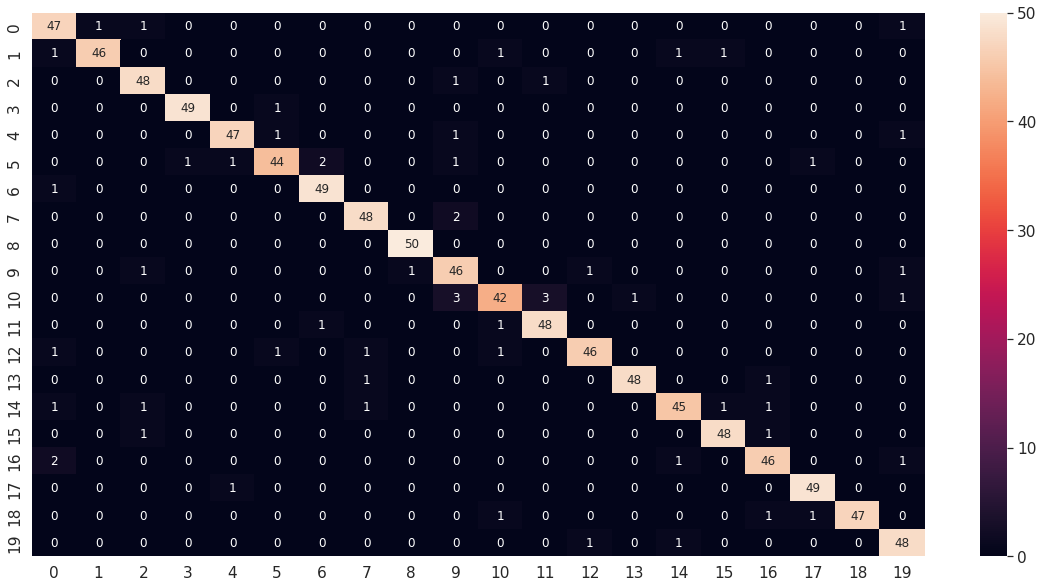

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg3_12_df_CM = pd.DataFrame(deepface_model_vgg3_12_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg3_12_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg3_12_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg3_12_report)

              precision    recall  f1-score   support

           1       0.89      0.94      0.91        50
           2       0.98      0.92      0.95        50
           3       0.92      0.96      0.94        50
           4       0.98      0.98      0.98        50
           5       0.96      0.94      0.95        50
           6       0.94      0.88      0.91        50
           7       0.94      0.98      0.96        50
           8       0.94      0.96      0.95        50
           9       0.98      1.00      0.99        50
          10       0.85      0.92      0.88        50
          11       0.91      0.84      0.87        50
          12       0.92      0.96      0.94        50
          13       0.96      0.92      0.94        50
          14       0.98      0.96      0.97        50
          15       0.94      0.90      0.92        50
          16       0.96      0.96      0.96        50
          17       0.92      0.92      0.92        50
          18       0.96    

#### Modelo 13: (BTH = 30, EHS = 50, ValidSplit = 0.2, Dropout = 0, INI = HeNormal, Dropout=0.2, REG = L2, OPT = SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg3_13 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg3_13.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg3_13.add(Dropout(rate=0, name='D0'))
deepface_model_vgg3_13.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg3_13.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg3_13.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_13.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg3_13 = deepface_model_vgg3_13.fit(new_trainX, new_trainY, batch_size=30, epochs=50, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/50
74/74 [==============================] - 138s 647ms/step - loss: 1.1326 - accuracy: 0.8322 - val_loss: 0.8088 - val_accuracy: 0.8945
Epoch 2/50
74/74 [==============================] - 15s 199ms/step - loss: 0.4200 - accuracy: 1.0000 - val_loss: 0.7591 - val_accuracy: 0.9055
Epoch 3/50
74/74 [==============================] - 16s 212ms/step - loss: 0.4049 - accuracy: 1.0000 - val_loss: 0.7443 - val_accuracy: 0.9073
Epoch 4/50
74/74 [==============================] - 14s 195ms/step - loss: 0.3930 - accuracy: 1.0000 - val_loss: 0.7275 - val_accuracy: 0.9091
Epoch 5/50
74/74 [==============================] - 14s 194ms/step - loss: 0.3816 - accuracy: 1.0000 - val_loss: 0.7130 - val_accuracy: 0.9091
Epoch 6/50
74/74 [==============================] - 14s 195ms/step - loss: 0.3705 - accuracy: 1.0000 - val_loss: 0.6993 - val_accuracy: 0.9091
Epoch 7/50
74/74 [==============================] - 14s 194ms/step - loss: 0.3599 - accuracy: 1.0000 - val_loss: 0.6861 - val_accuracy: 0.909

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg3_13 = load_model(path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_13.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg3_13.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg3_13.evaluate(testX, testY)

32/32 [==============================] - 2s 65ms/step - loss: 0.2954 - accuracy: 0.9440


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg3_13.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg3_13_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 42s 61ms/step


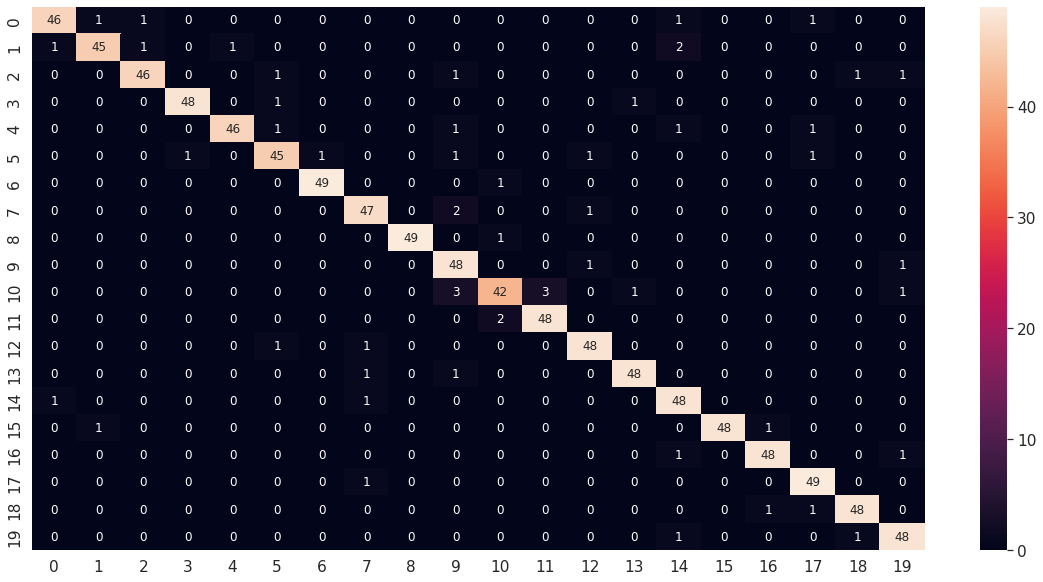

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg3_13_df_CM = pd.DataFrame(deepface_model_vgg3_13_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg3_13_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg3_13_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg3_13_report)

              precision    recall  f1-score   support

           1       0.96      0.92      0.94        50
           2       0.96      0.90      0.93        50
           3       0.96      0.92      0.94        50
           4       0.98      0.96      0.97        50
           5       0.98      0.92      0.95        50
           6       0.92      0.90      0.91        50
           7       0.98      0.98      0.98        50
           8       0.92      0.94      0.93        50
           9       1.00      0.98      0.99        50
          10       0.84      0.96      0.90        50
          11       0.91      0.84      0.87        50
          12       0.94      0.96      0.95        50
          13       0.94      0.96      0.95        50
          14       0.96      0.96      0.96        50
          15       0.89      0.96      0.92        50
          16       1.00      0.96      0.98        50
          17       0.96      0.96      0.96        50
          18       0.92    

#### Modelo 14: (BTH = 40, EHS = 50, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg3_14 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg3_14.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg3_14.add(Dropout(rate=0, name='D0'))
deepface_model_vgg3_14.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg3_14.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg3_14.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_14.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg3_14 = deepface_model_vgg3_14.fit(new_trainX, new_trainY, batch_size=40, epochs=50, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/50
55/55 [==============================] - 134s 820ms/step - loss: 1.2169 - accuracy: 0.8085 - val_loss: 0.8501 - val_accuracy: 0.8909
Epoch 2/50
55/55 [==============================] - 13s 237ms/step - loss: 0.4243 - accuracy: 1.0000 - val_loss: 0.7972 - val_accuracy: 0.9000
Epoch 3/50
55/55 [==============================] - 12s 222ms/step - loss: 0.4112 - accuracy: 1.0000 - val_loss: 0.7811 - val_accuracy: 0.9018
Epoch 4/50
55/55 [==============================] - 12s 222ms/step - loss: 0.4021 - accuracy: 1.0000 - val_loss: 0.7678 - val_accuracy: 0.9073
Epoch 5/50
55/55 [==============================] - 12s 221ms/step - loss: 0.3933 - accuracy: 1.0000 - val_loss: 0.7569 - val_accuracy: 0.9055
Epoch 6/50
55/55 [==============================] - 12s 226ms/step - loss: 0.3848 - accuracy: 1.0000 - val_loss: 0.7462 - val_accuracy: 0.9055
Epoch 7/50
55/55 [==============================] - 12s 220ms/step - loss: 0.3764 - accuracy: 1.0000 - val_loss: 0.7347 - val_accuracy: 0.905

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg3_14 = load_model(path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_14.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg3_14.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg3_14.evaluate(testX, testY)

32/32 [==============================] - 2s 64ms/step - loss: 0.3599 - accuracy: 0.9310


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg3_14.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg3_14_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 33s 61ms/step


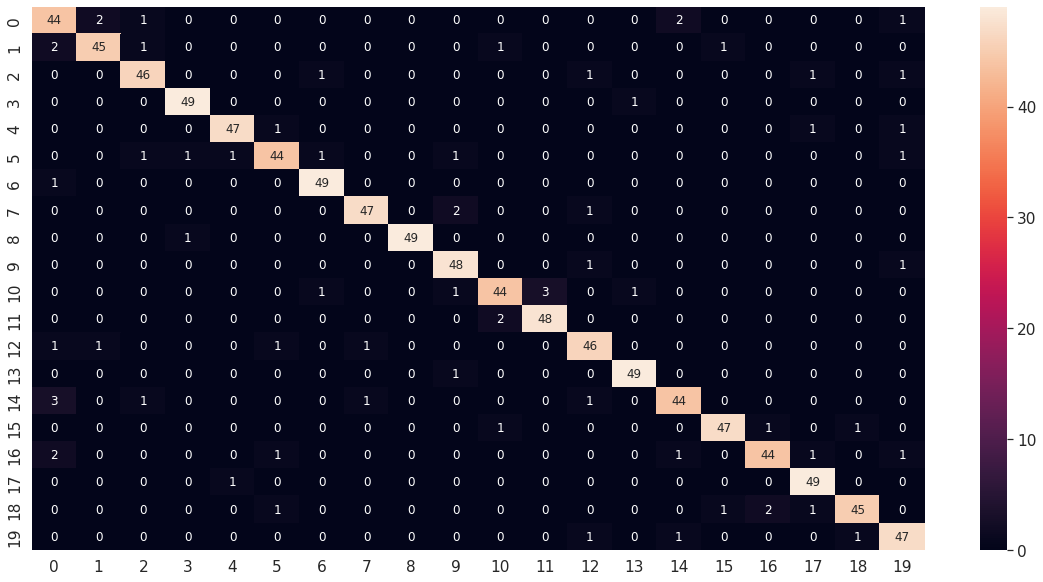

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg3_14_df_CM = pd.DataFrame(deepface_model_vgg3_14_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg3_14_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg3_14_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg3_14_report)

              precision    recall  f1-score   support

           1       0.83      0.88      0.85        50
           2       0.94      0.90      0.92        50
           3       0.92      0.92      0.92        50
           4       0.96      0.98      0.97        50
           5       0.96      0.94      0.95        50
           6       0.92      0.88      0.90        50
           7       0.94      0.98      0.96        50
           8       0.96      0.94      0.95        50
           9       1.00      0.98      0.99        50
          10       0.91      0.96      0.93        50
          11       0.92      0.88      0.90        50
          12       0.94      0.96      0.95        50
          13       0.90      0.92      0.91        50
          14       0.96      0.98      0.97        50
          15       0.92      0.88      0.90        50
          16       0.96      0.94      0.95        50
          17       0.94      0.88      0.91        50
          18       0.92    

#### Modelo 15: (BTH = 50, EHS = 50, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg3_15 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg3_15.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg3_15.add(Dropout(rate=0, name='D0'))
deepface_model_vgg3_15.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg3_15.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg3_15.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_15.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg3_15 = deepface_model_vgg3_15.fit(new_trainX, new_trainY, batch_size=50, epochs=50, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/50
44/44 [==============================] - 142s 998ms/step - loss: 2.1543 - accuracy: 0.5316 - val_loss: 1.1486 - val_accuracy: 0.7764
Epoch 2/50
44/44 [==============================] - 11s 254ms/step - loss: 0.6677 - accuracy: 0.9409 - val_loss: 0.9414 - val_accuracy: 0.8436
Epoch 3/50
44/44 [==============================] - 11s 255ms/step - loss: 0.5025 - accuracy: 0.9950 - val_loss: 0.8432 - val_accuracy: 0.8727
Epoch 4/50
44/44 [==============================] - 11s 255ms/step - loss: 0.4528 - accuracy: 1.0000 - val_loss: 0.8088 - val_accuracy: 0.8800
Epoch 5/50
44/44 [==============================] - 12s 263ms/step - loss: 0.4317 - accuracy: 1.0000 - val_loss: 0.7931 - val_accuracy: 0.8836
Epoch 6/50
44/44 [==============================] - 11s 250ms/step - loss: 0.4185 - accuracy: 1.0000 - val_loss: 0.7732 - val_accuracy: 0.8855
Epoch 7/50
44/44 [==============================] - 12s 282ms/step - loss: 0.4080 - accuracy: 1.0000 - val_loss: 0.7607 - val_accuracy: 0.885

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg3_15 = load_model(path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_15.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg3_15.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg3_15.evaluate(testX, testY)

32/32 [==============================] - 2s 69ms/step - loss: 0.4408 - accuracy: 0.9250


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg3_15.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg3_15_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 39s 64ms/step


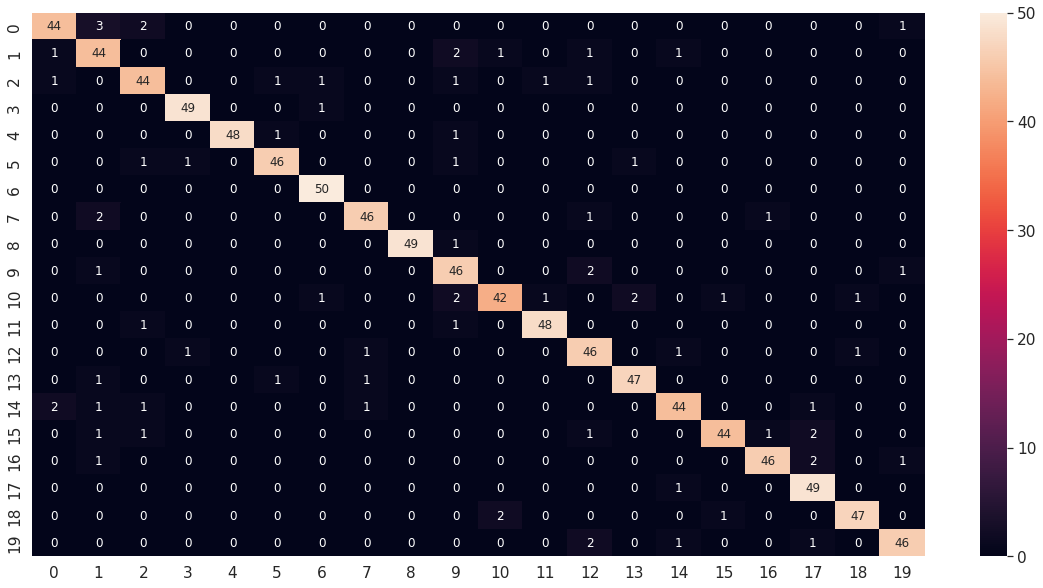

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg3_15_df_CM = pd.DataFrame(deepface_model_vgg3_15_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg3_15_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg3_15_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg3_15_report)

              precision    recall  f1-score   support

           1       0.92      0.88      0.90        50
           2       0.81      0.88      0.85        50
           3       0.88      0.88      0.88        50
           4       0.96      0.98      0.97        50
           5       1.00      0.96      0.98        50
           6       0.94      0.92      0.93        50
           7       0.94      1.00      0.97        50
           8       0.94      0.92      0.93        50
           9       1.00      0.98      0.99        50
          10       0.84      0.92      0.88        50
          11       0.93      0.84      0.88        50
          12       0.96      0.96      0.96        50
          13       0.85      0.92      0.88        50
          14       0.94      0.94      0.94        50
          15       0.92      0.88      0.90        50
          16       0.96      0.88      0.92        50
          17       0.96      0.92      0.94        50
          18       0.89    

#### Modelo 16: (BTH = 10, EHS = 100, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT =  SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg3_16 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg3_16.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg3_16.add(Dropout(rate=0, name='D0'))
deepface_model_vgg3_16.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg3_16.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg3_16.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_16.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg3_16 = deepface_model_vgg3_16.fit(new_trainX, new_trainY, batch_size=10, epochs=100, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/100
220/220 [==============================] - 156s 270ms/step - loss: 2.8321 - accuracy: 0.7231 - val_loss: 0.9362 - val_accuracy: 0.8673
Epoch 2/100
220/220 [==============================] - 31s 141ms/step - loss: 0.4668 - accuracy: 0.9977 - val_loss: 0.8047 - val_accuracy: 0.9000
Epoch 3/100
220/220 [==============================] - 30s 137ms/step - loss: 0.4140 - accuracy: 1.0000 - val_loss: 0.7466 - val_accuracy: 0.9091
Epoch 4/100
220/220 [==============================] - 30s 137ms/step - loss: 0.3792 - accuracy: 1.0000 - val_loss: 0.7061 - val_accuracy: 0.9127
Epoch 5/100
220/220 [==============================] - 30s 138ms/step - loss: 0.3484 - accuracy: 1.0000 - val_loss: 0.6715 - val_accuracy: 0.9164
Epoch 6/100
220/220 [==============================] - 31s 142ms/step - loss: 0.3203 - accuracy: 1.0000 - val_loss: 0.6381 - val_accuracy: 0.9182
Epoch 7/100
220/220 [==============================] - 31s 140ms/step - loss: 0.2947 - accuracy: 1.0000 - val_loss: 0.6078 

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg3_16 = load_model(path + 'data_reconocimiento2/models_VGG3/deepface_model_VGG3_16.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg3_16.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg3_16.evaluate(testX, testY)

32/32 [==============================] - 2s 65ms/step - loss: 0.2104 - accuracy: 0.9380


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg3_16.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg3_16_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 34s 63ms/step


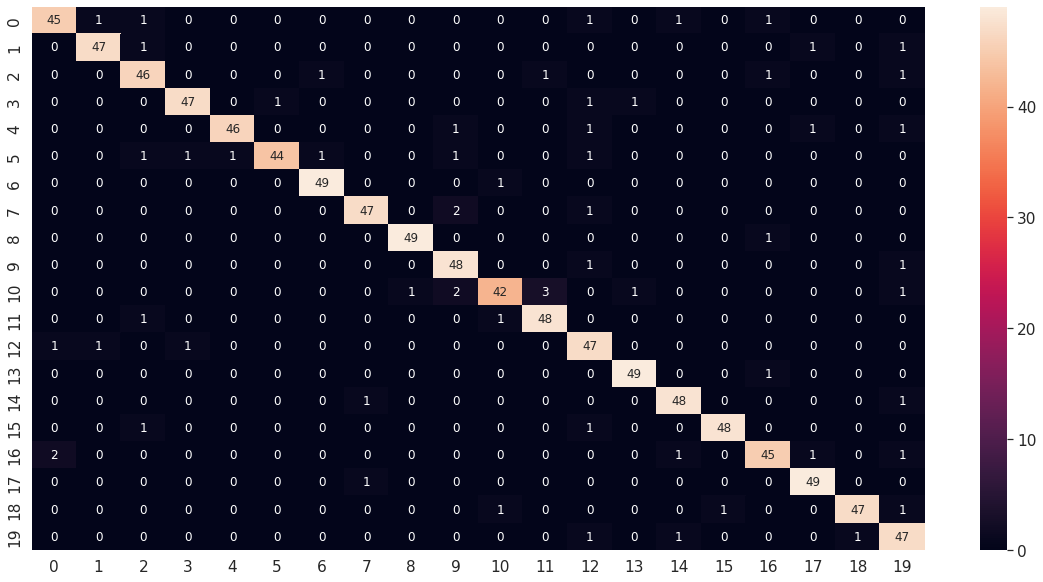

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg3_16_df_CM = pd.DataFrame(deepface_model_vgg3_16_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg3_16_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg3_16_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg3_16_report)

              precision    recall  f1-score   support

           1       0.94      0.90      0.92        50
           2       0.96      0.94      0.95        50
           3       0.90      0.92      0.91        50
           4       0.96      0.94      0.95        50
           5       0.98      0.92      0.95        50
           6       0.98      0.88      0.93        50
           7       0.96      0.98      0.97        50
           8       0.96      0.94      0.95        50
           9       0.98      0.98      0.98        50
          10       0.89      0.96      0.92        50
          11       0.93      0.84      0.88        50
          12       0.92      0.96      0.94        50
          13       0.85      0.94      0.90        50
          14       0.96      0.98      0.97        50
          15       0.94      0.96      0.95        50
          16       0.98      0.96      0.97        50
          17       0.92      0.90      0.91        50
          18       0.94    

## 10. Modelos con base de datos VGG-Indian para condiciones de etnia

#### Modelo 1: (BTH = 10, EHS = 50, ValidSplit = 0.2, Dropout=0, INI = HeNormal, REG = L2, OPT = adam[0.0001])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg4_1 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg4_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final dropout y softmax de 11 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg4_1.add(Dropout(rate=0, name='D0'))
deepface_model_vgg4_1.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg4_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)    
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.0001)
deepface_model_vgg4_1.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_1.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg4_1 = deepface_model_vgg4_1.fit(new_trainX, new_trainY, batch_size=10, epochs=50, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
27/27 [==============================] - 133s 1s/step - loss: 4.1520 - accuracy: 0.3638 - val_loss: 2.3989 - val_accuracy: 0.5050
Epoch 2/30
27/27 [==============================] - 4s 147ms/step - loss: 1.0343 - accuracy: 0.7738 - val_loss: 2.4667 - val_accuracy: 0.5800
Epoch 3/30
27/27 [==============================] - 4s 154ms/step - loss: 0.7705 - accuracy: 0.8438 - val_loss: 2.4922 - val_accuracy: 0.6350
Epoch 4/30
27/27 [==============================] - 4s 162ms/step - loss: 0.5259 - accuracy: 0.8988 - val_loss: 4.1070 - val_accuracy: 0.6250
Epoch 5/30
27/27 [==============================] - 4s 158ms/step - loss: 0.7712 - accuracy: 0.8775 - val_loss: 4.5421 - val_accuracy: 0.5150
Epoch 6/30
27/27 [==============================] - 4s 147ms/step - loss: 0.9680 - accuracy: 0.8600 - val_loss: 3.6667 - val_accuracy: 0.6500
Epoch 7/30
27/27 [==============================] - 4s 153ms/step - loss: 0.9075 - accuracy: 0.9000 - val_loss: 3.8547 - val_accuracy: 0.6500
Epoch 8

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg4_1 = load_model(path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_1.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg4_1.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg4_1.evaluate(testX, testY)

7/7 [==============================] - 0s 63ms/step - loss: 2.6614 - accuracy: 0.3700


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg4_1.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg4_1_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg4_1_df_CM = pd.DataFrame(deepface_model_vgg4_1_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg4_1_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
2# Resumen de clasificación
deepface_model_vgg4_1_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg4_1_report)

#### Modelo 2: (BTH = 20, EHS = 50, ValidSplit = 0.2, Dropout=0, INI = HeNormal, REG = L2, OPT = adam[0.0001])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg4_2 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg4_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final dropout y softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg4_2.add(Dropout(rate=0, name='D0'))
deepface_model_vgg4_2.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg4_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)    
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.0001)
deepface_model_vgg4_2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_2.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg4_2 = deepface_model_vgg4_2.fit(new_trainX, new_trainY, batch_size=20, epochs=50, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/20
47/47 [==============================] - 156s 1s/step - loss: 6.4589 - accuracy: 0.3303 - val_loss: 2.6530 - val_accuracy: 0.4176
Epoch 2/20
47/47 [==============================] - 7s 159ms/step - loss: 0.7406 - accuracy: 0.8658 - val_loss: 2.5358 - val_accuracy: 0.5085
Epoch 3/20
47/47 [==============================] - 5s 96ms/step - loss: 0.4089 - accuracy: 0.9538 - val_loss: 2.7791 - val_accuracy: 0.4972
Epoch 4/20
47/47 [==============================] - 5s 99ms/step - loss: 0.3504 - accuracy: 0.9666 - val_loss: 2.8235 - val_accuracy: 0.5142
Epoch 5/20
47/47 [==============================] - 5s 100ms/step - loss: 0.2746 - accuracy: 0.9830 - val_loss: 2.9851 - val_accuracy: 0.4801
Epoch 6/20
47/47 [==============================] - 5s 100ms/step - loss: 0.2818 - accuracy: 0.9808 - val_loss: 2.9477 - val_accuracy: 0.5199
Epoch 7/20
47/47 [==============================] - 5s 97ms/step - loss: 0.2453 - accuracy: 0.9872 - val_loss: 3.0240 - val_accuracy: 0.5114
Epoch 8/20

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg4_2 = load_model(path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_2.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg4_2.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg4_2.evaluate(testX, testY)

21/21 [==============================] - 36s 68ms/step - loss: 6.2041 - accuracy: 0.1076


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg4_2.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg4_2_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

21/21 [==============================] - 32s 63ms/step


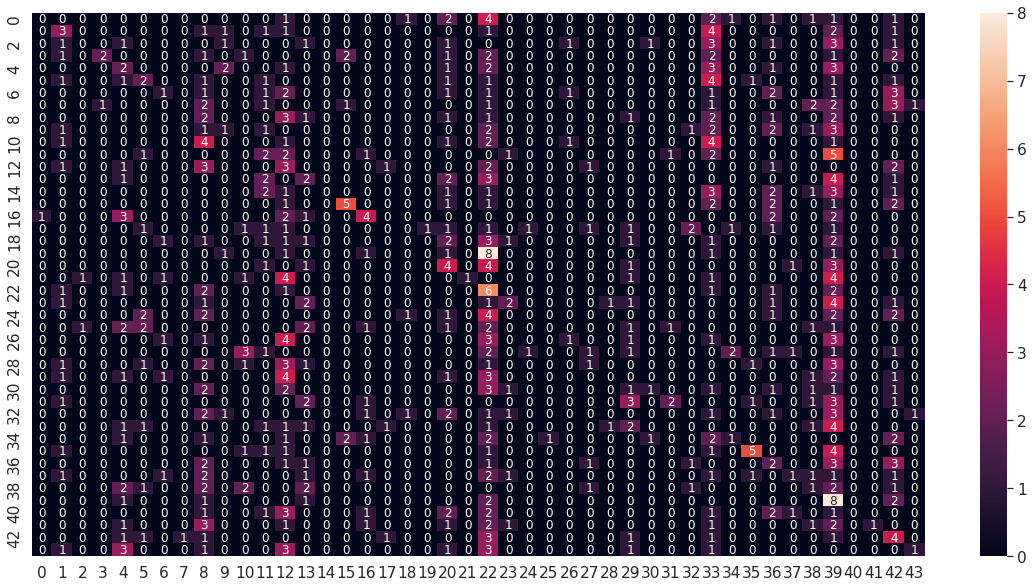

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg4_2_df_CM = pd.DataFrame(deepface_model_vgg4_2_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg4_2_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg4_2_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg4_2_report)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        15
           2       0.18      0.20      0.19        15
           3       0.00      0.00      0.00        15
           4       0.67      0.13      0.22        15
           5       0.08      0.13      0.10        15
           6       0.17      0.13      0.15        15
           7       0.17      0.07      0.10        15
           8       0.00      0.00      0.00        15
           9       0.05      0.13      0.07        15
          10       0.14      0.07      0.09        15
          11       0.00      0.00      0.00        15
          12       0.11      0.13      0.12        15
          13       0.06      0.20      0.09        15
          14       0.10      0.13      0.11        15
          15       0.00      0.00      0.00        15
          16       0.50      0.33      0.40        15
          17       0.31      0.27      0.29        15
          18       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Modelo 3: (BTH = 30, EHS = 100, ValidSplit = 0.2, Dropout=0, INI = HeNormal, REG = L2, OPT = SGD[0.001, momentum=0.9])

In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg4_3 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg4_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final dropout y softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg4_3.add(Dropout(rate=0, name='D0'))
deepface_model_vgg4_3.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg4_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)    
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg4_3.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_3.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg4_3 = deepface_model_vgg4_3.fit(new_trainX, new_trainY, batch_size=30, epochs=100, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/100
72/72 [==============================] - 146s 635ms/step - loss: 2.0274 - accuracy: 0.5877 - val_loss: 1.0018 - val_accuracy: 0.8370
Epoch 2/100
72/72 [==============================] - 13s 185ms/step - loss: 0.5774 - accuracy: 0.9666 - val_loss: 0.8372 - val_accuracy: 0.8870
Epoch 3/100
72/72 [==============================] - 14s 195ms/step - loss: 0.4476 - accuracy: 0.9991 - val_loss: 0.7687 - val_accuracy: 0.9019
Epoch 4/100
72/72 [==============================] - 14s 198ms/step - loss: 0.4182 - accuracy: 1.0000 - val_loss: 0.7393 - val_accuracy: 0.9185
Epoch 5/100
72/72 [==============================] - 14s 193ms/step - loss: 0.4018 - accuracy: 1.0000 - val_loss: 0.7204 - val_accuracy: 0.9185
Epoch 6/100
72/72 [==============================] - 15s 203ms/step - loss: 0.3892 - accuracy: 1.0000 - val_loss: 0.7077 - val_accuracy: 0.9185
Epoch 7/100
72/72 [==============================] - 14s 191ms/step - loss: 0.3776 - accuracy: 1.0000 - val_loss: 0.6925 - val_accuracy

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg4_3 = load_model(path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_3.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg4_3.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg4_3.evaluate(testX, testY)

32/32 [==============================] - 2s 71ms/step - loss: 0.3597 - accuracy: 0.9170


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg4_3.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg4_3_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 39s 64ms/step


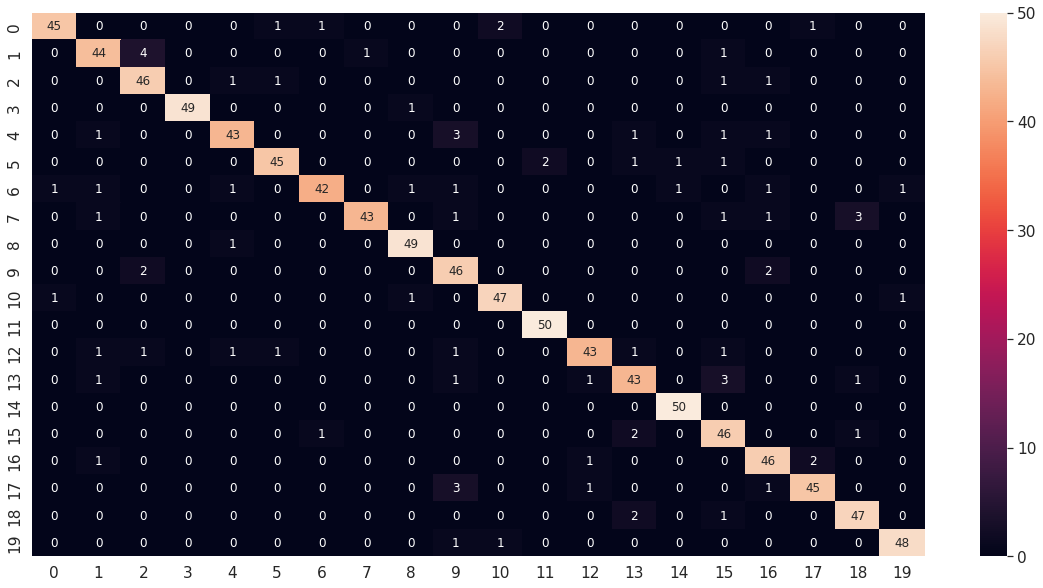

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg4_3_df_CM = pd.DataFrame(deepface_model_vgg4_3_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg4_3_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg4_3_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg4_3_report)

              precision    recall  f1-score   support

           1       0.96      0.90      0.93        50
           2       0.88      0.88      0.88        50
           3       0.87      0.92      0.89        50
           4       1.00      0.98      0.99        50
           5       0.91      0.86      0.89        50
           6       0.94      0.90      0.92        50
           7       0.95      0.84      0.89        50
           8       0.98      0.86      0.91        50
           9       0.94      0.98      0.96        50
          10       0.81      0.92      0.86        50
          11       0.94      0.94      0.94        50
          12       0.96      1.00      0.98        50
          13       0.93      0.86      0.90        50
          14       0.86      0.86      0.86        50
          15       0.96      1.00      0.98        50
          16       0.82      0.92      0.87        50
          17       0.87      0.92      0.89        50
          18       0.94    

#### Modelo 4: (BTH = 40, EHS = 50, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2, OPT = adam[0.0001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg4_4 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg4_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg4_4.add(Dropout(rate=0, name='D0'))
deepface_model_vgg4_4.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg4_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adam=Adam(learning_rate=0.0001)
deepface_model_vgg4_4.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_4.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg4_4 = deepface_model_vgg4_4.fit(new_trainX, new_trainY, batch_size=40, epochs=50, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/30
29/29 [==============================] - 131s 1s/step - loss: 9.5525 - accuracy: 0.6605 - val_loss: 7.3607 - val_accuracy: 0.4034
Epoch 2/30
29/29 [==============================] - 3s 118ms/step - loss: 0.2284 - accuracy: 0.9993 - val_loss: 7.5170 - val_accuracy: 0.4062
Epoch 3/30
29/29 [==============================] - 6s 203ms/step - loss: 0.2043 - accuracy: 0.9993 - val_loss: 7.1865 - val_accuracy: 0.4233
Epoch 4/30
29/29 [==============================] - 6s 208ms/step - loss: 0.1932 - accuracy: 1.0000 - val_loss: 7.1263 - val_accuracy: 0.4233
Epoch 5/30
29/29 [==============================] - 6s 205ms/step - loss: 0.1858 - accuracy: 1.0000 - val_loss: 7.0778 - val_accuracy: 0.4233
Epoch 6/30
29/29 [==============================] - 6s 216ms/step - loss: 0.1793 - accuracy: 1.0000 - val_loss: 7.0318 - val_accuracy: 0.4233
Epoch 7/30
29/29 [==============================] - 6s 214ms/step - loss: 0.1734 - accuracy: 1.0000 - val_loss: 6.9870 - val_accuracy: 0.4233
Epoch 8

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg4_4 = load_model(path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_4.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg4_4.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg4_4.evaluate(testX, testY)

21/21 [==============================] - 33s 67ms/step - loss: 14.3519 - accuracy: 0.0894


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg4_4.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg4_4_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

21/21 [==============================] - 32s 62ms/step


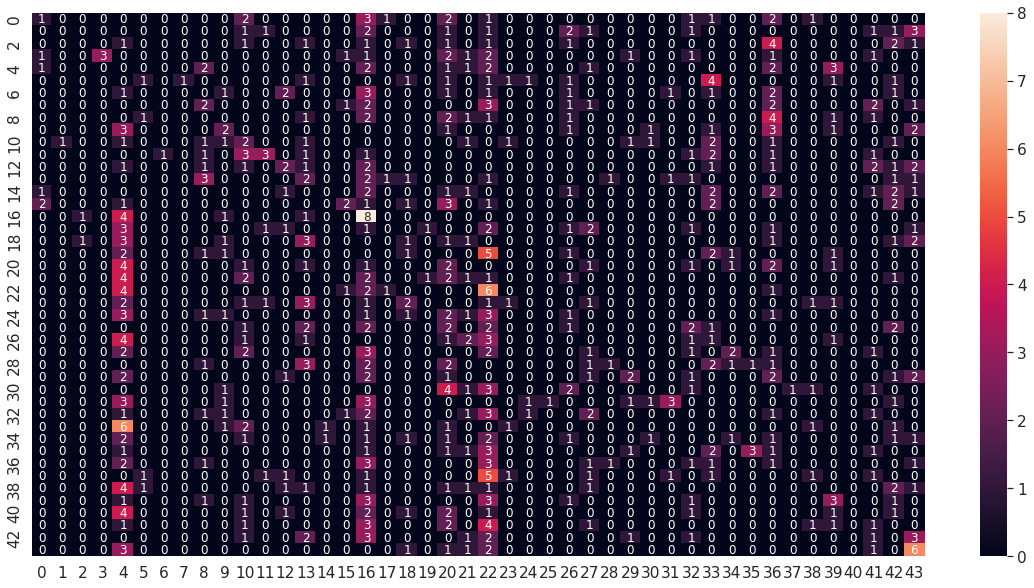

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg4_4_df_CM = pd.DataFrame(deepface_model_vgg4_4_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg4_4_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg4_4_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg4_4_report)

              precision    recall  f1-score   support

           1       0.17      0.07      0.10        15
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00        15
           4       1.00      0.20      0.33        15
           5       0.00      0.00      0.00        15
           6       0.25      0.07      0.11        15
           7       0.00      0.00      0.00        15
           8       0.00      0.00      0.00        15
           9       0.00      0.00      0.00        15
          10       0.17      0.13      0.15        15
          11       0.08      0.13      0.10        15
          12       0.43      0.20      0.27        15
          13       0.20      0.13      0.16        15
          14       0.08      0.13      0.10        15
          15       0.00      0.00      0.00        15
          16       0.33      0.13      0.19        15
          17       0.11      0.53      0.18        15
          18       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Modelo 5: (BTH = 50, EHS = 100, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2, OPT = SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg4_5 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg4_5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 21 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg4_5.add(Dropout(rate=0, name='D0'))
deepface_model_vgg4_5.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg4_5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg4_5.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_5.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg4_5 = deepface_model_vgg4_5.fit(new_trainX, new_trainY, batch_size=50, epochs=100, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/100
44/44 [==============================] - 144s 1s/step - loss: 1.5972 - accuracy: 0.7301 - val_loss: 0.8536 - val_accuracy: 0.8704
Epoch 2/100
44/44 [==============================] - 12s 266ms/step - loss: 0.4344 - accuracy: 0.9991 - val_loss: 0.7530 - val_accuracy: 0.9037
Epoch 3/100
44/44 [==============================] - 12s 273ms/step - loss: 0.4162 - accuracy: 1.0000 - val_loss: 0.7336 - val_accuracy: 0.9093
Epoch 4/100
44/44 [==============================] - 12s 268ms/step - loss: 0.4078 - accuracy: 1.0000 - val_loss: 0.7226 - val_accuracy: 0.9111
Epoch 5/100
44/44 [==============================] - 12s 276ms/step - loss: 0.4004 - accuracy: 1.0000 - val_loss: 0.7150 - val_accuracy: 0.9093
Epoch 6/100
44/44 [==============================] - 12s 276ms/step - loss: 0.3934 - accuracy: 1.0000 - val_loss: 0.7051 - val_accuracy: 0.9111
Epoch 7/100
44/44 [==============================] - 12s 266ms/step - loss: 0.3865 - accuracy: 1.0000 - val_loss: 0.6965 - val_accuracy: 0

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg4_5 = load_model(path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_5.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg4_5.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg4_5.evaluate(testX, testY)

32/32 [==============================] - 2s 70ms/step - loss: 0.3806 - accuracy: 0.9210


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg4_5.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg4_5_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 48s 66ms/step


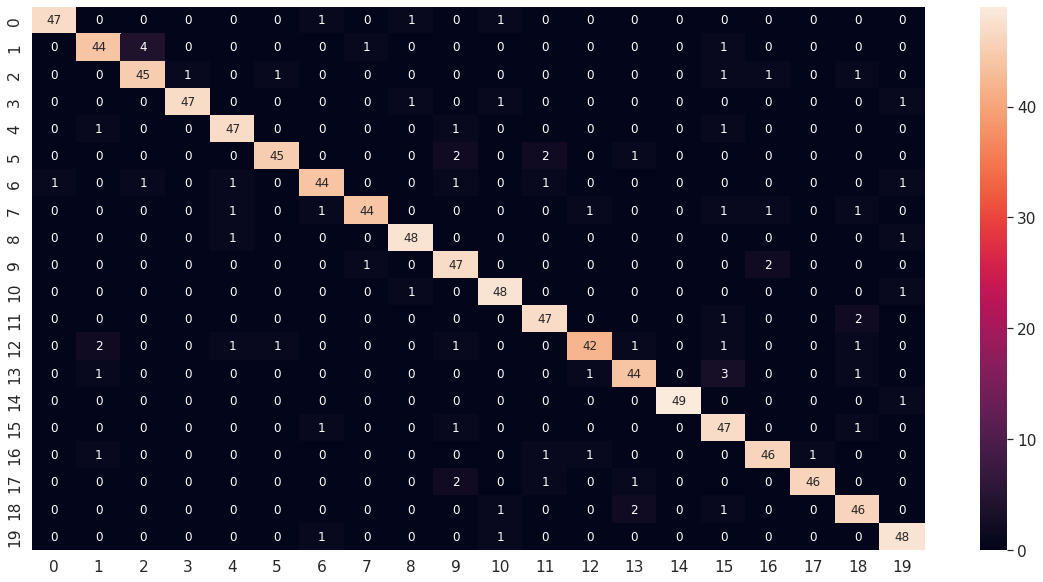

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg4_5_df_CM = pd.DataFrame(deepface_model_vgg4_5_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg4_5_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg4_5_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg4_5_report)

              precision    recall  f1-score   support

           1       0.98      0.94      0.96        50
           2       0.90      0.88      0.89        50
           3       0.90      0.90      0.90        50
           4       0.98      0.94      0.96        50
           5       0.92      0.94      0.93        50
           6       0.96      0.90      0.93        50
           7       0.92      0.88      0.90        50
           8       0.96      0.88      0.92        50
           9       0.94      0.96      0.95        50
          10       0.85      0.94      0.90        50
          11       0.92      0.96      0.94        50
          12       0.90      0.94      0.92        50
          13       0.93      0.84      0.88        50
          14       0.90      0.88      0.89        50
          15       1.00      0.98      0.99        50
          16       0.82      0.94      0.88        50
          17       0.92      0.92      0.92        50
          18       0.98    

#### Modelo 6: (BTH = 10, EHS = 50, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = none, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg4_6 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg4_6.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg4_6.add(Dropout(rate=0, name='D0'))
deepface_model_vgg4_6.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg4_6.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_vgg4_6.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_6.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg4_6 = deepface_model_vgg4_6.fit(new_trainX, new_trainY, batch_size=10, epochs=50, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/50
216/216 [==============================] - 151s 276ms/step - loss: 1.8478 - accuracy: 0.6276 - val_loss: 0.8627 - val_accuracy: 0.7981
Epoch 2/50
216/216 [==============================] - 30s 139ms/step - loss: 0.3176 - accuracy: 0.9759 - val_loss: 0.7317 - val_accuracy: 0.8648
Epoch 3/50
216/216 [==============================] - 30s 137ms/step - loss: 0.2348 - accuracy: 0.9995 - val_loss: 0.5840 - val_accuracy: 0.8944
Epoch 4/50
216/216 [==============================] - 30s 138ms/step - loss: 0.2141 - accuracy: 1.0000 - val_loss: 0.5568 - val_accuracy: 0.8963
Epoch 5/50
216/216 [==============================] - 30s 138ms/step - loss: 0.1986 - accuracy: 1.0000 - val_loss: 0.5350 - val_accuracy: 0.9000
Epoch 6/50
216/216 [==============================] - 31s 142ms/step - loss: 0.1828 - accuracy: 1.0000 - val_loss: 0.5130 - val_accuracy: 0.9037
Epoch 7/50
216/216 [==============================] - 31s 141ms/step - loss: 0.1665 - accuracy: 1.0000 - val_loss: 0.5031 - val_a

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg4_6 = load_model(path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_6.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg4_6.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg4_6.evaluate(testX, testY)

32/32 [==============================] - 2s 69ms/step - loss: 0.4195 - accuracy: 0.9050


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg4_6.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg4_6_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 34s 65ms/step


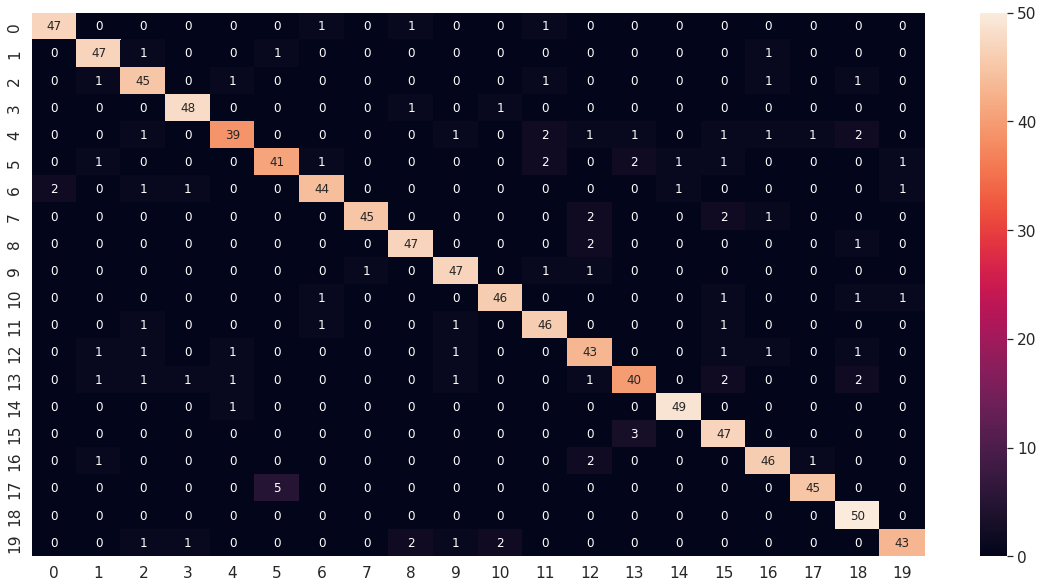

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg4_6_df_CM = pd.DataFrame(deepface_model_vgg4_6_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg4_6_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg4_6_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg4_6_report)

              precision    recall  f1-score   support

           1       0.96      0.94      0.95        50
           2       0.90      0.94      0.92        50
           3       0.87      0.90      0.88        50
           4       0.94      0.96      0.95        50
           5       0.91      0.78      0.84        50
           6       0.87      0.82      0.85        50
           7       0.92      0.88      0.90        50
           8       0.98      0.90      0.94        50
           9       0.92      0.94      0.93        50
          10       0.90      0.94      0.92        50
          11       0.94      0.92      0.93        50
          12       0.87      0.92      0.89        50
          13       0.83      0.86      0.84        50
          14       0.87      0.80      0.83        50
          15       0.96      0.98      0.97        50
          16       0.84      0.94      0.89        50
          17       0.90      0.92      0.91        50
          18       0.96    

#### Modelo 7: (BTH = 20, EHS = 50, ValidSplit = 0.2, INI = none, Dropout=0 REG = L2, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg4_7 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg4_7.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg4_7.add(Dropout(rate=0, name='D0'))
deepface_model_vgg4_7.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg4_7.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)  
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_vgg4_7.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_7.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg4_7 = deepface_model_vgg4_7.fit(new_trainX, new_trainY, batch_size=20, epochs=50, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/50
108/108 [==============================] - 141s 471ms/step - loss: 1.8080 - accuracy: 0.8275 - val_loss: 0.7052 - val_accuracy: 0.8685
Epoch 2/50
108/108 [==============================] - 19s 180ms/step - loss: 0.2117 - accuracy: 0.9972 - val_loss: 0.6409 - val_accuracy: 0.8852
Epoch 3/50
108/108 [==============================] - 20s 188ms/step - loss: 0.1940 - accuracy: 1.0000 - val_loss: 0.5907 - val_accuracy: 0.8944
Epoch 4/50
108/108 [==============================] - 19s 179ms/step - loss: 0.1875 - accuracy: 1.0000 - val_loss: 0.5827 - val_accuracy: 0.8926
Epoch 5/50
108/108 [==============================] - 20s 181ms/step - loss: 0.1824 - accuracy: 1.0000 - val_loss: 0.5749 - val_accuracy: 0.8963
Epoch 6/50
108/108 [==============================] - 19s 180ms/step - loss: 0.1776 - accuracy: 1.0000 - val_loss: 0.5689 - val_accuracy: 0.9000
Epoch 7/50
108/108 [==============================] - 19s 180ms/step - loss: 0.1728 - accuracy: 1.0000 - val_loss: 0.5620 - val_a

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg4_7 = load_model(path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_7.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg4_7.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg4_7.evaluate(testX, testY)

32/32 [==============================] - 2s 66ms/step - loss: 0.6283 - accuracy: 0.8900


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg4_7.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg4_7_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 32s 64ms/step


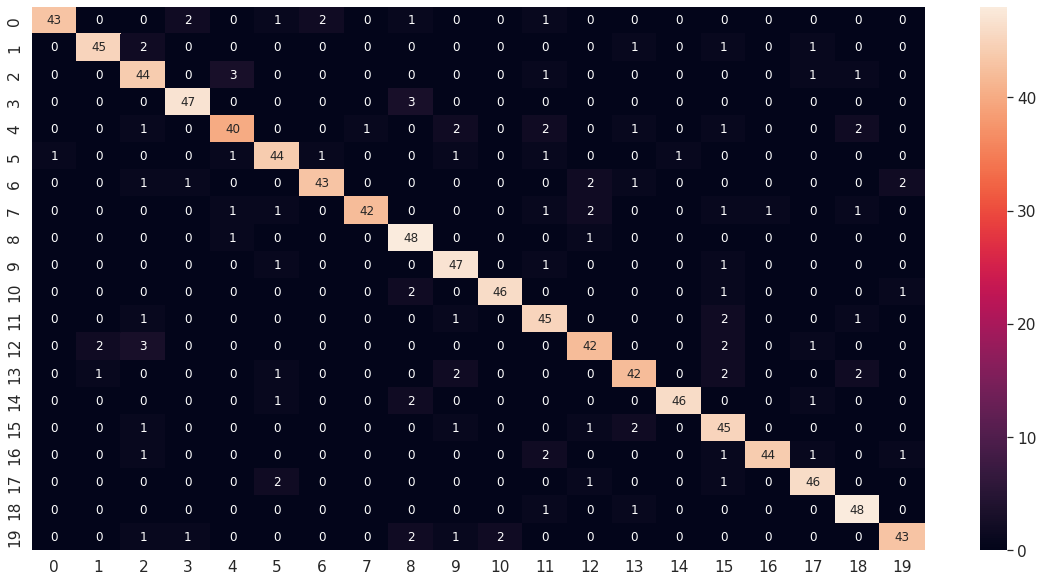

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg4_7_df_CM = pd.DataFrame(deepface_model_vgg4_7_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg4_7_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg4_7_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg4_7_report)

              precision    recall  f1-score   support

           1       0.98      0.86      0.91        50
           2       0.94      0.90      0.92        50
           3       0.80      0.88      0.84        50
           4       0.92      0.94      0.93        50
           5       0.87      0.80      0.83        50
           6       0.86      0.88      0.87        50
           7       0.93      0.86      0.90        50
           8       0.98      0.84      0.90        50
           9       0.83      0.96      0.89        50
          10       0.85      0.94      0.90        50
          11       0.96      0.92      0.94        50
          12       0.82      0.90      0.86        50
          13       0.86      0.84      0.85        50
          14       0.88      0.84      0.86        50
          15       0.98      0.92      0.95        50
          16       0.78      0.90      0.83        50
          17       0.98      0.88      0.93        50
          18       0.90    

#### Modelo 8: (BTH = 30, EHS = 50, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = none, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg4_8 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg4_8.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg4_8.add(Dropout(rate=0, name='D0'))
deepface_model_vgg4_8.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg4_8.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)  
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_vgg4_8.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_8.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg4_8 = deepface_model_vgg4_8.fit(new_trainX, new_trainY, batch_size=30, epochs=50, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/50
72/72 [==============================] - 142s 649ms/step - loss: 1.9892 - accuracy: 0.6252 - val_loss: 0.9552 - val_accuracy: 0.8000
Epoch 2/50
72/72 [==============================] - 15s 209ms/step - loss: 0.3604 - accuracy: 0.9782 - val_loss: 0.6731 - val_accuracy: 0.8815
Epoch 3/50
72/72 [==============================] - 15s 214ms/step - loss: 0.2786 - accuracy: 1.0000 - val_loss: 0.6160 - val_accuracy: 0.9019
Epoch 4/50
72/72 [==============================] - 15s 211ms/step - loss: 0.2619 - accuracy: 1.0000 - val_loss: 0.5968 - val_accuracy: 0.9074
Epoch 5/50
72/72 [==============================] - 15s 211ms/step - loss: 0.2495 - accuracy: 1.0000 - val_loss: 0.5797 - val_accuracy: 0.9074
Epoch 6/50
72/72 [==============================] - 15s 214ms/step - loss: 0.2381 - accuracy: 1.0000 - val_loss: 0.5636 - val_accuracy: 0.9074
Epoch 7/50
72/72 [==============================] - 17s 231ms/step - loss: 0.2273 - accuracy: 1.0000 - val_loss: 0.5496 - val_accuracy: 0.907

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg4_8 = load_model(path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_8.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg4_8.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg4_8.evaluate(testX, testY)

32/32 [==============================] - 2s 67ms/step - loss: 0.4683 - accuracy: 0.8920


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg4_8.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg4_8_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 33s 63ms/step


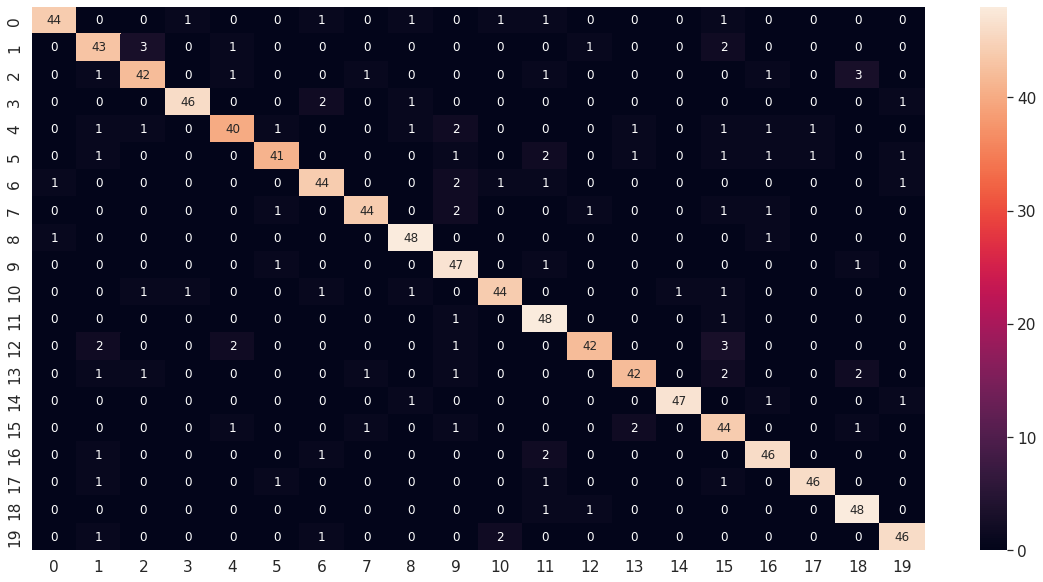

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg4_8_df_CM = pd.DataFrame(deepface_model_vgg4_8_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg4_8_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg4_8_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg4_8_report)

              precision    recall  f1-score   support

           1       0.96      0.88      0.92        50
           2       0.83      0.86      0.84        50
           3       0.88      0.84      0.86        50
           4       0.96      0.92      0.94        50
           5       0.89      0.80      0.84        50
           6       0.91      0.82      0.86        50
           7       0.88      0.88      0.88        50
           8       0.94      0.88      0.91        50
           9       0.91      0.96      0.93        50
          10       0.81      0.94      0.87        50
          11       0.92      0.88      0.90        50
          12       0.83      0.96      0.89        50
          13       0.93      0.84      0.88        50
          14       0.91      0.84      0.87        50
          15       0.98      0.94      0.96        50
          16       0.76      0.88      0.81        50
          17       0.88      0.92      0.90        50
          18       0.96    

#### Modelo 9: (BTH = 40, EHS = 50, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg4_9 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg4_9.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg4_9.add(Dropout(rate=0, name='D0'))
deepface_model_vgg4_9.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg4_9.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_vgg4_9.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_9.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg4_9 = deepface_model_vgg4_9.fit(new_trainX, new_trainY, batch_size=40, epochs=50, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/50
54/54 [==============================] - 135s 864ms/step - loss: 2.2227 - accuracy: 0.7379 - val_loss: 0.7884 - val_accuracy: 0.8593
Epoch 2/50
54/54 [==============================] - 14s 255ms/step - loss: 0.3229 - accuracy: 0.9935 - val_loss: 0.6862 - val_accuracy: 0.8833
Epoch 3/50
54/54 [==============================] - 14s 266ms/step - loss: 0.2876 - accuracy: 1.0000 - val_loss: 0.6587 - val_accuracy: 0.8852
Epoch 4/50
54/54 [==============================] - 14s 261ms/step - loss: 0.2777 - accuracy: 1.0000 - val_loss: 0.6442 - val_accuracy: 0.8889
Epoch 5/50
54/54 [==============================] - 14s 268ms/step - loss: 0.2697 - accuracy: 1.0000 - val_loss: 0.6377 - val_accuracy: 0.8889
Epoch 6/50
54/54 [==============================] - 9s 174ms/step - loss: 0.2622 - accuracy: 1.0000 - val_loss: 0.6426 - val_accuracy: 0.8926
Epoch 7/50
54/54 [==============================] - 9s 175ms/step - loss: 0.2552 - accuracy: 1.0000 - val_loss: 0.6548 - val_accuracy: 0.8981


In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg4_9 = load_model(path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_9.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg4_9.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg4_9.evaluate(testX, testY)

32/32 [==============================] - 2s 66ms/step - loss: 0.5695 - accuracy: 0.8990


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg4_9.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg4_9_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

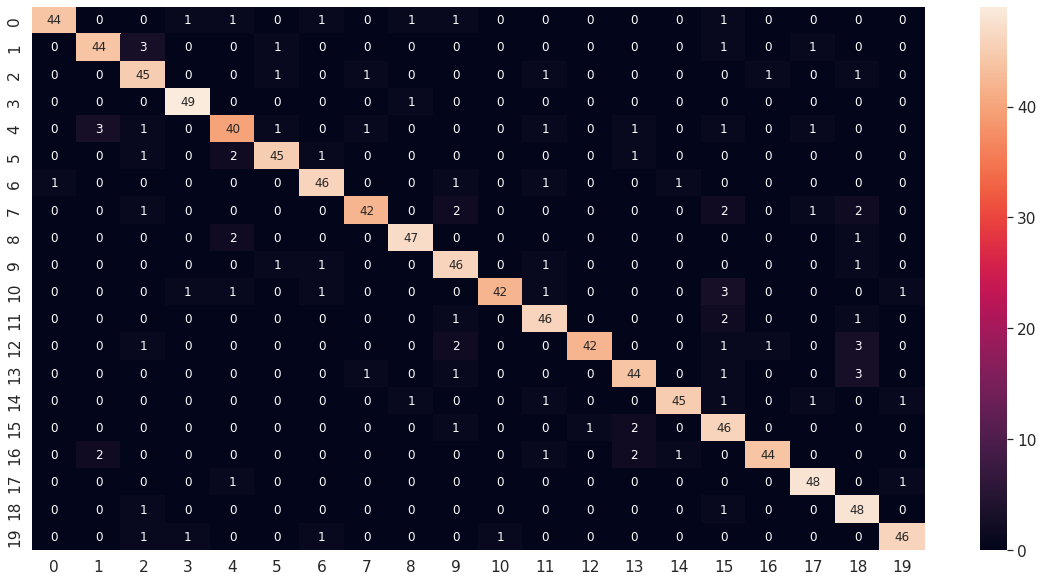

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg4_9_df_CM = pd.DataFrame(deepface_model_vgg4_9_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg4_9_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg4_9_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg4_9_report)

              precision    recall  f1-score   support

           1       0.98      0.88      0.93        50
           2       0.90      0.88      0.89        50
           3       0.83      0.90      0.87        50
           4       0.94      0.98      0.96        50
           5       0.85      0.80      0.82        50
           6       0.92      0.90      0.91        50
           7       0.90      0.92      0.91        50
           8       0.93      0.84      0.88        50
           9       0.94      0.94      0.94        50
          10       0.84      0.92      0.88        50
          11       0.98      0.84      0.90        50
          12       0.87      0.92      0.89        50
          13       0.98      0.84      0.90        50
          14       0.88      0.88      0.88        50
          15       0.96      0.90      0.93        50
          16       0.77      0.92      0.84        50
          17       0.96      0.88      0.92        50
          18       0.92    

#### Modelo 10: (BTH = 50, EHS = 50, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = adamax[0.001])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg4_10 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg4_10.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg4_10.add(Dropout(rate=0, name='D0'))
deepface_model_vgg4_10.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg4_10.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
adamax=Adamax(learning_rate=0.001)
deepface_model_vgg4_10.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_10.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg4_10 = deepface_model_vgg4_10.fit(new_trainX, new_trainY, batch_size=50, epochs=50, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/50
44/44 [==============================] - 138s 1s/step - loss: 5.0749 - accuracy: 0.6192 - val_loss: 0.8903 - val_accuracy: 0.8130
Epoch 2/50
44/44 [==============================] - 14s 322ms/step - loss: 0.3109 - accuracy: 0.9852 - val_loss: 0.7095 - val_accuracy: 0.8593
Epoch 3/50
44/44 [==============================] - 15s 343ms/step - loss: 0.2342 - accuracy: 0.9995 - val_loss: 0.6820 - val_accuracy: 0.8815
Epoch 4/50
44/44 [==============================] - 13s 302ms/step - loss: 0.2245 - accuracy: 1.0000 - val_loss: 0.6663 - val_accuracy: 0.8833
Epoch 5/50
44/44 [==============================] - 9s 197ms/step - loss: 0.2202 - accuracy: 1.0000 - val_loss: 0.6720 - val_accuracy: 0.8833
Epoch 6/50
44/44 [==============================] - 9s 198ms/step - loss: 0.2166 - accuracy: 1.0000 - val_loss: 0.6778 - val_accuracy: 0.8889
Epoch 7/50
44/44 [==============================] - 9s 199ms/step - loss: 0.2133 - accuracy: 1.0000 - val_loss: 0.6816 - val_accuracy: 0.8815
Epoc

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg4_10 = load_model(path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_10.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg4_10.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg4_10.evaluate(testX, testY)

32/32 [==============================] - 2s 66ms/step - loss: 0.7669 - accuracy: 0.8630


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg4_10.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg4_10_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 33s 63ms/step


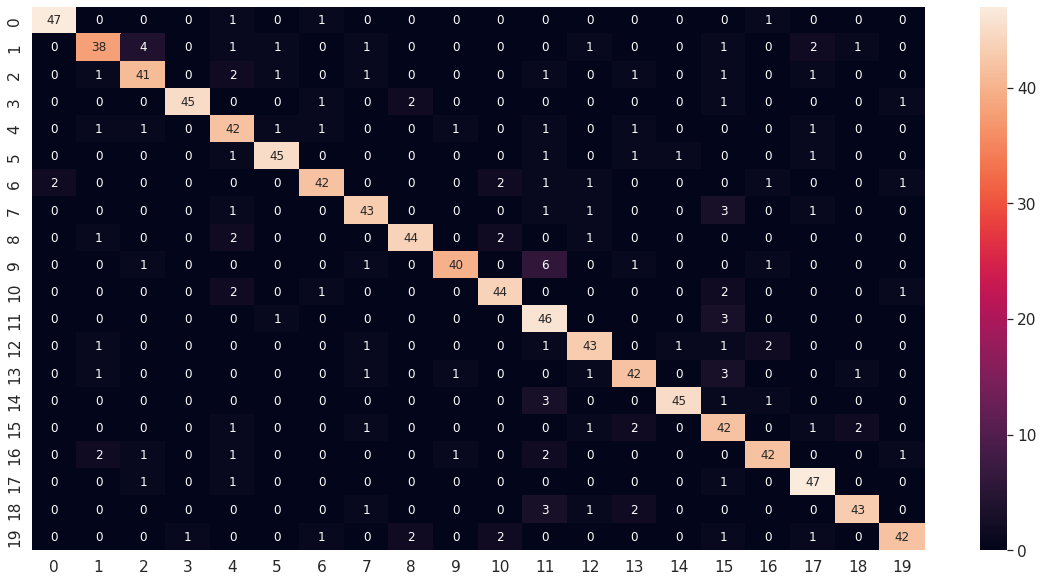

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg4_10_df_CM = pd.DataFrame(deepface_model_vgg4_10_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg4_10_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg4_10_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg4_10_report)

              precision    recall  f1-score   support

           1       0.96      0.94      0.95        50
           2       0.84      0.76      0.80        50
           3       0.84      0.82      0.83        50
           4       0.98      0.90      0.94        50
           5       0.76      0.84      0.80        50
           6       0.92      0.90      0.91        50
           7       0.89      0.84      0.87        50
           8       0.86      0.86      0.86        50
           9       0.92      0.88      0.90        50
          10       0.93      0.80      0.86        50
          11       0.88      0.88      0.88        50
          12       0.70      0.92      0.79        50
          13       0.86      0.86      0.86        50
          14       0.84      0.84      0.84        50
          15       0.96      0.90      0.93        50
          16       0.70      0.84      0.76        50
          17       0.88      0.84      0.86        50
          18       0.85    

#### Modelo 11: (BTH = 10, EHS = 50, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg4_11 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg4_11.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg4_11.add(Dropout(rate=0, name='D0'))
deepface_model_vgg4_11.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg4_11.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg4_11.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_11.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg4_11 = deepface_model_vgg4_11.fit(new_trainX, new_trainY, batch_size=10, epochs=50, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/50
216/216 [==============================] - 148s 269ms/step - loss: 1.3437 - accuracy: 0.8901 - val_loss: 0.9935 - val_accuracy: 0.8556
Epoch 2/50
216/216 [==============================] - 27s 123ms/step - loss: 0.4239 - accuracy: 0.9995 - val_loss: 0.8957 - val_accuracy: 0.8704
Epoch 3/50
216/216 [==============================] - 27s 125ms/step - loss: 0.3857 - accuracy: 1.0000 - val_loss: 0.8479 - val_accuracy: 0.8741
Epoch 4/50
216/216 [==============================] - 27s 126ms/step - loss: 0.3541 - accuracy: 1.0000 - val_loss: 0.8105 - val_accuracy: 0.8796
Epoch 5/50
216/216 [==============================] - 27s 123ms/step - loss: 0.3252 - accuracy: 1.0000 - val_loss: 0.7785 - val_accuracy: 0.8778
Epoch 6/50
216/216 [==============================] - 28s 128ms/step - loss: 0.2988 - accuracy: 1.0000 - val_loss: 0.7430 - val_accuracy: 0.8815
Epoch 7/50
216/216 [==============================] - 27s 124ms/step - loss: 0.2747 - accuracy: 1.0000 - val_loss: 0.7147 - val_a

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg4_11 = load_model(path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_11.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg4_11.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg4_11.evaluate(testX, testY)

32/32 [==============================] - 2s 66ms/step - loss: 0.4362 - accuracy: 0.8830


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg4_11.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg4_11_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 33s 63ms/step


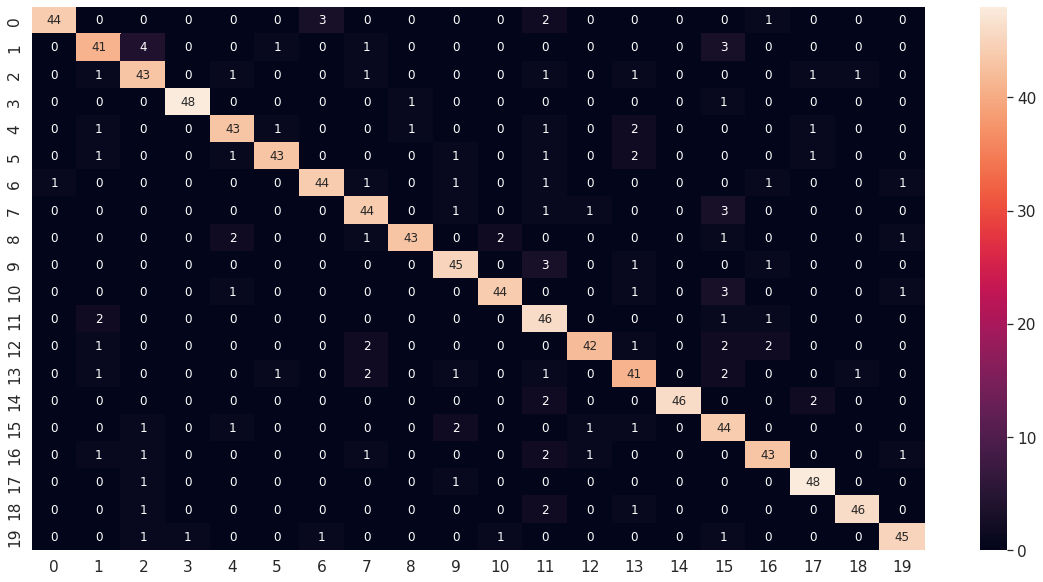

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg4_11_df_CM = pd.DataFrame(deepface_model_vgg4_11_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg4_11_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg4_11_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg4_11_report)

              precision    recall  f1-score   support

           1       0.98      0.88      0.93        50
           2       0.84      0.82      0.83        50
           3       0.83      0.86      0.84        50
           4       0.98      0.96      0.97        50
           5       0.88      0.86      0.87        50
           6       0.93      0.86      0.90        50
           7       0.92      0.88      0.90        50
           8       0.83      0.88      0.85        50
           9       0.96      0.86      0.91        50
          10       0.87      0.90      0.88        50
          11       0.94      0.88      0.91        50
          12       0.73      0.92      0.81        50
          13       0.93      0.84      0.88        50
          14       0.80      0.82      0.81        50
          15       1.00      0.92      0.96        50
          16       0.72      0.88      0.79        50
          17       0.88      0.86      0.87        50
          18       0.91    

#### Modelo 12: (BTH = 20, EHS = 50, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg4_12 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg4_12.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg4_12.add(Dropout(rate=0, name='D0'))
deepface_model_vgg4_12.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg4_12.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg4_12.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_12.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg4_12 = deepface_model_vgg4_12.fit(new_trainX, new_trainY, batch_size=20, epochs=50, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/50
108/108 [==============================] - 135s 454ms/step - loss: 0.8622 - accuracy: 0.9188 - val_loss: 0.9464 - val_accuracy: 0.8778
Epoch 2/50
108/108 [==============================] - 17s 155ms/step - loss: 0.4097 - accuracy: 1.0000 - val_loss: 0.8960 - val_accuracy: 0.8870
Epoch 3/50
108/108 [==============================] - 17s 154ms/step - loss: 0.3918 - accuracy: 1.0000 - val_loss: 0.8745 - val_accuracy: 0.8889
Epoch 4/50
108/108 [==============================] - 17s 158ms/step - loss: 0.3753 - accuracy: 1.0000 - val_loss: 0.8485 - val_accuracy: 0.8889
Epoch 5/50
108/108 [==============================] - 17s 159ms/step - loss: 0.3595 - accuracy: 1.0000 - val_loss: 0.8260 - val_accuracy: 0.8907
Epoch 6/50
108/108 [==============================] - 17s 155ms/step - loss: 0.3444 - accuracy: 1.0000 - val_loss: 0.8060 - val_accuracy: 0.8907
Epoch 7/50
108/108 [==============================] - 17s 154ms/step - loss: 0.3300 - accuracy: 1.0000 - val_loss: 0.7856 - val_a

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg4_12 = load_model(path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_12.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg4_12.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg4_12.evaluate(testX, testY)

32/32 [==============================] - 2s 67ms/step - loss: 0.4858 - accuracy: 0.8750


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg4_12.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg4_12_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 37s 63ms/step


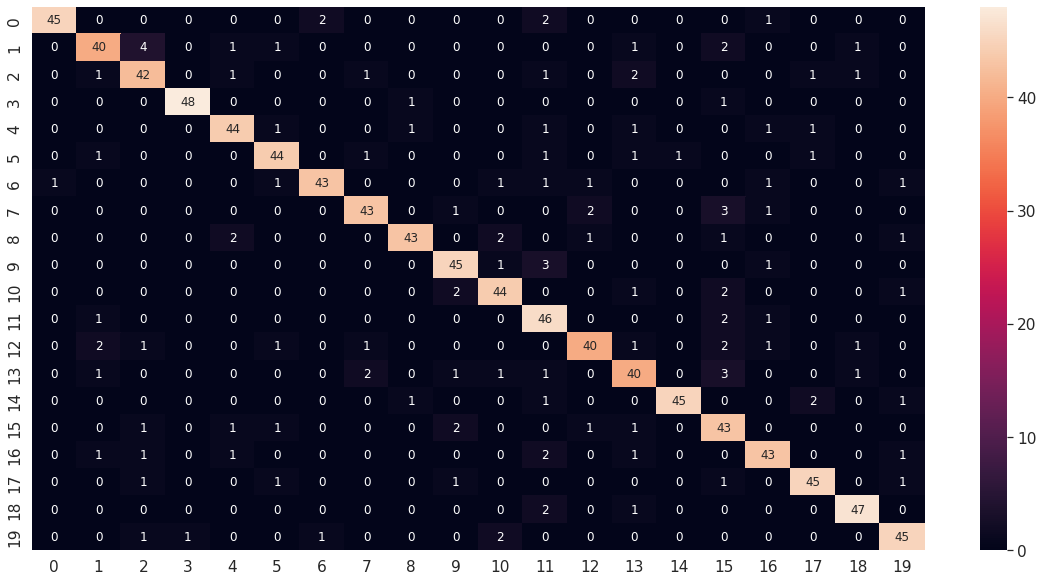

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg4_12_df_CM = pd.DataFrame(deepface_model_vgg4_12_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg4_12_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg4_12_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg4_12_report)

              precision    recall  f1-score   support

           1       0.98      0.90      0.94        50
           2       0.85      0.80      0.82        50
           3       0.82      0.84      0.83        50
           4       0.98      0.96      0.97        50
           5       0.88      0.88      0.88        50
           6       0.88      0.88      0.88        50
           7       0.93      0.86      0.90        50
           8       0.90      0.86      0.88        50
           9       0.93      0.86      0.90        50
          10       0.87      0.90      0.88        50
          11       0.86      0.88      0.87        50
          12       0.75      0.92      0.83        50
          13       0.89      0.80      0.84        50
          14       0.80      0.80      0.80        50
          15       0.98      0.90      0.94        50
          16       0.72      0.86      0.78        50
          17       0.86      0.86      0.86        50
          18       0.90    

#### Modelo 13: (BTH = 30, EHS = 50, ValidSplit = 0.2, Dropout = 0.2, INI = HeNormal, Dropout=0, REG = L2, OPT = SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg4_13 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg4_13.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 40 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg4_13.add(Dropout(rate=0, name='D0'))
deepface_model_vgg4_13.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg4_13.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg4_13.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_13.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg4_13 = deepface_model_vgg4_13.fit(new_trainX, new_trainY, batch_size=30, epochs=50, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/50
72/72 [==============================] - 149s 646ms/step - loss: 2.0533 - accuracy: 0.5612 - val_loss: 1.0679 - val_accuracy: 0.8037
Epoch 2/50
72/72 [==============================] - 13s 185ms/step - loss: 0.5925 - accuracy: 0.9624 - val_loss: 0.8412 - val_accuracy: 0.8722
Epoch 3/50
72/72 [==============================] - 13s 186ms/step - loss: 0.4491 - accuracy: 0.9986 - val_loss: 0.7818 - val_accuracy: 0.8870
Epoch 4/50
72/72 [==============================] - 13s 185ms/step - loss: 0.4178 - accuracy: 1.0000 - val_loss: 0.7571 - val_accuracy: 0.8870
Epoch 5/50
72/72 [==============================] - 13s 183ms/step - loss: 0.4012 - accuracy: 1.0000 - val_loss: 0.7266 - val_accuracy: 0.9019
Epoch 6/50
72/72 [==============================] - 13s 183ms/step - loss: 0.3881 - accuracy: 1.0000 - val_loss: 0.7128 - val_accuracy: 0.9000
Epoch 7/50
72/72 [==============================] - 13s 186ms/step - loss: 0.3765 - accuracy: 1.0000 - val_loss: 0.6976 - val_accuracy: 0.903

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg4_13 = load_model(path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_13.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg4_13.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg4_13.evaluate(testX, testY)

32/32 [==============================] - 2s 67ms/step - loss: 0.4525 - accuracy: 0.9040


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg4_13.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg4_13_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 35s 64ms/step


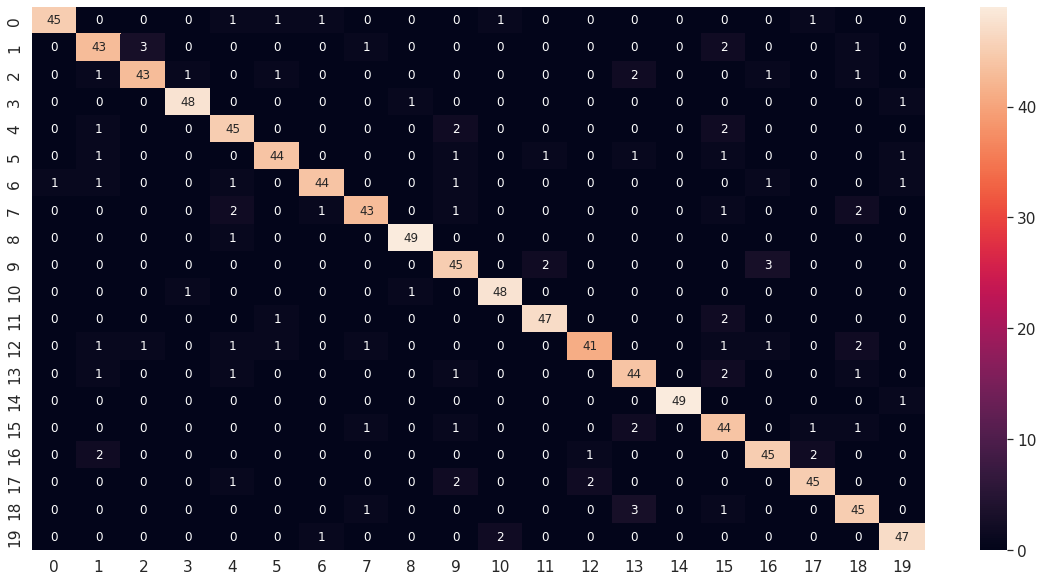

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg4_13_df_CM = pd.DataFrame(deepface_model_vgg4_13_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg4_13_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg4_13_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg4_13_report)

              precision    recall  f1-score   support

           1       0.98      0.90      0.94        50
           2       0.84      0.86      0.85        50
           3       0.91      0.86      0.89        50
           4       0.96      0.96      0.96        50
           5       0.85      0.90      0.87        50
           6       0.92      0.88      0.90        50
           7       0.94      0.88      0.91        50
           8       0.91      0.86      0.89        50
           9       0.96      0.98      0.97        50
          10       0.83      0.90      0.87        50
          11       0.94      0.96      0.95        50
          12       0.94      0.94      0.94        50
          13       0.93      0.82      0.87        50
          14       0.85      0.88      0.86        50
          15       1.00      0.98      0.99        50
          16       0.79      0.88      0.83        50
          17       0.88      0.90      0.89        50
          18       0.92    

#### Modelo 14: (BTH = 40, EHS = 50, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg4_14 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg4_14.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg4_14.add(Dropout(rate=0, name='D0'))
deepface_model_vgg4_14.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg4_14.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg4_14.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_14.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg4_14 = deepface_model_vgg4_14.fit(new_trainX, new_trainY, batch_size=40, epochs=50, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/50
54/54 [==============================] - 136s 843ms/step - loss: 1.8841 - accuracy: 0.6429 - val_loss: 0.9796 - val_accuracy: 0.8463
Epoch 2/50
54/54 [==============================] - 12s 230ms/step - loss: 0.4712 - accuracy: 0.9935 - val_loss: 0.8348 - val_accuracy: 0.8889
Epoch 3/50
54/54 [==============================] - 12s 232ms/step - loss: 0.4260 - accuracy: 0.9995 - val_loss: 0.7785 - val_accuracy: 0.8944
Epoch 4/50
54/54 [==============================] - 12s 230ms/step - loss: 0.4112 - accuracy: 1.0000 - val_loss: 0.7689 - val_accuracy: 0.8907
Epoch 5/50
54/54 [==============================] - 12s 229ms/step - loss: 0.4013 - accuracy: 1.0000 - val_loss: 0.7529 - val_accuracy: 0.8944
Epoch 6/50
54/54 [==============================] - 12s 226ms/step - loss: 0.3922 - accuracy: 1.0000 - val_loss: 0.7378 - val_accuracy: 0.8926
Epoch 7/50
54/54 [==============================] - 12s 229ms/step - loss: 0.3836 - accuracy: 1.0000 - val_loss: 0.7336 - val_accuracy: 0.894

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg4_14 = load_model(path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_14.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg4_14.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg4_14.evaluate(testX, testY)

32/32 [==============================] - 2s 68ms/step - loss: 0.4817 - accuracy: 0.9130


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg4_14.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg4_14_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 37s 64ms/step


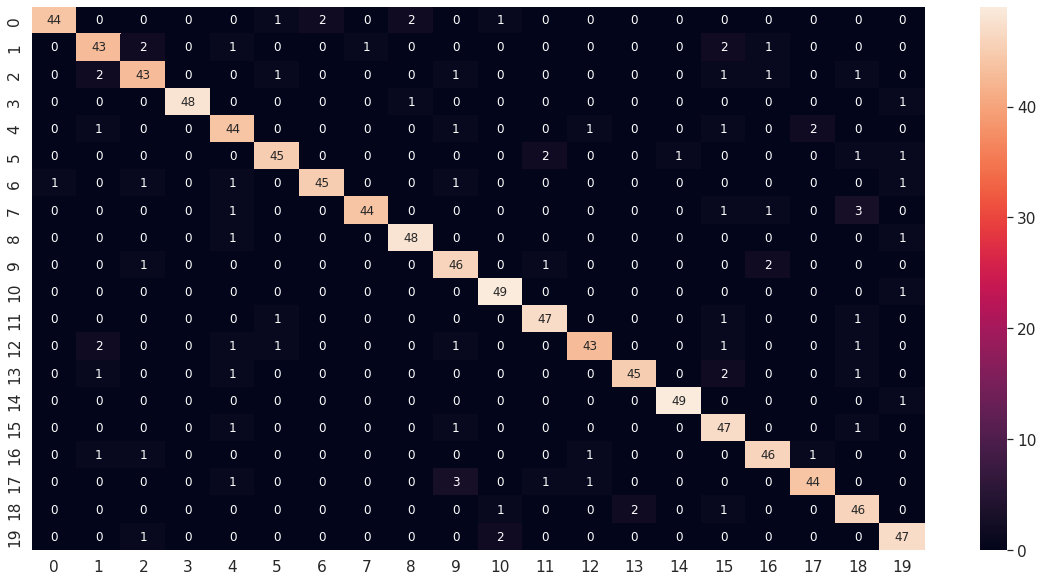

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg4_14_df_CM = pd.DataFrame(deepface_model_vgg4_14_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg4_14_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg4_14_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg4_14_report)

              precision    recall  f1-score   support

           1       0.98      0.88      0.93        50
           2       0.86      0.86      0.86        50
           3       0.88      0.86      0.87        50
           4       1.00      0.96      0.98        50
           5       0.85      0.88      0.86        50
           6       0.92      0.90      0.91        50
           7       0.96      0.90      0.93        50
           8       0.98      0.88      0.93        50
           9       0.94      0.96      0.95        50
          10       0.85      0.92      0.88        50
          11       0.92      0.98      0.95        50
          12       0.92      0.94      0.93        50
          13       0.93      0.86      0.90        50
          14       0.96      0.90      0.93        50
          15       0.98      0.98      0.98        50
          16       0.82      0.94      0.88        50
          17       0.90      0.92      0.91        50
          18       0.94    

#### Modelo 15: (BTH = 50, EHS = 50, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg4_15 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg4_15.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg4_15.add(Dropout(rate=0, name='D0'))
deepface_model_vgg4_15.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg4_15.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg4_15.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_15.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg4_15 = deepface_model_vgg4_15.fit(new_trainX, new_trainY, batch_size=50, epochs=50, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/50
44/44 [==============================] - 135s 1s/step - loss: 1.7966 - accuracy: 0.6684 - val_loss: 0.9553 - val_accuracy: 0.8426
Epoch 2/50
44/44 [==============================] - 12s 263ms/step - loss: 0.4719 - accuracy: 0.9903 - val_loss: 0.7710 - val_accuracy: 0.8944
Epoch 3/50
44/44 [==============================] - 11s 258ms/step - loss: 0.4239 - accuracy: 1.0000 - val_loss: 0.7425 - val_accuracy: 0.9074
Epoch 4/50
44/44 [==============================] - 12s 267ms/step - loss: 0.4133 - accuracy: 1.0000 - val_loss: 0.7283 - val_accuracy: 0.9056
Epoch 5/50
44/44 [==============================] - 12s 264ms/step - loss: 0.4050 - accuracy: 1.0000 - val_loss: 0.7183 - val_accuracy: 0.9056
Epoch 6/50
44/44 [==============================] - 12s 265ms/step - loss: 0.3975 - accuracy: 1.0000 - val_loss: 0.7070 - val_accuracy: 0.9056
Epoch 7/50
44/44 [==============================] - 11s 261ms/step - loss: 0.3903 - accuracy: 1.0000 - val_loss: 0.6972 - val_accuracy: 0.9056
E

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg4_15 = load_model(path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_15.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg4_15.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg4_15.evaluate(testX, testY)

32/32 [==============================] - 2s 69ms/step - loss: 0.5459 - accuracy: 0.9050


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg4_15.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg4_15_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

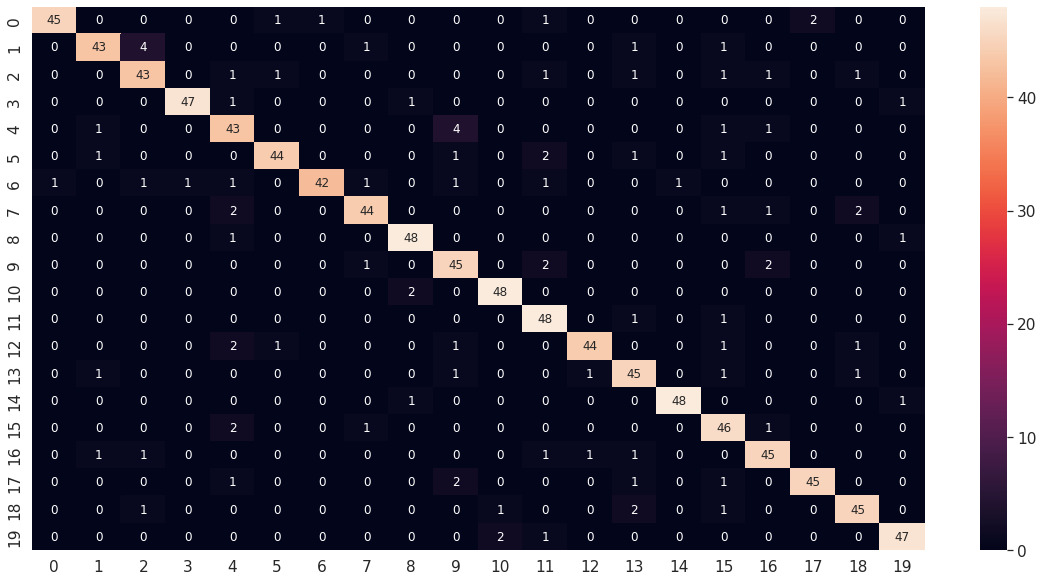

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg4_15_df_CM = pd.DataFrame(deepface_model_vgg4_15_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg4_15_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg4_15_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg4_15_report)

              precision    recall  f1-score   support

           1       0.98      0.90      0.94        50
           2       0.91      0.86      0.89        50
           3       0.86      0.86      0.86        50
           4       0.98      0.94      0.96        50
           5       0.80      0.86      0.83        50
           6       0.94      0.88      0.91        50
           7       0.98      0.84      0.90        50
           8       0.92      0.88      0.90        50
           9       0.92      0.96      0.94        50
          10       0.82      0.90      0.86        50
          11       0.94      0.96      0.95        50
          12       0.84      0.96      0.90        50
          13       0.96      0.88      0.92        50
          14       0.85      0.90      0.87        50
          15       0.98      0.96      0.97        50
          16       0.82      0.92      0.87        50
          17       0.88      0.90      0.89        50
          18       0.96    

#### Modelo 16: (BTH = 40, EHS = 100, ValidSplit = 0.2, INI = HeNormal, Dropout=0 REG = L2 none, OPT = SGD[0.001, momentum=0.9])






In [ ]:
# Eliminación de las capas D0 y F8. 
deepface_model_vgg4_16 = tf.keras.models.Sequential(model.layers[:-2])
deepface_model_vgg4_16.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Se agrega una capa final softmax de 45 clases. Esto permite que la red haga la predicción de las clases que tenemos.
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()
deepface_model_vgg4_16.add(Dropout(rate=0, name='D0'))
deepface_model_vgg4_16.add(Dense(21, kernel_initializer=initializer, kernel_regularizer=reg, activation='softmax', name='Class'))
deepface_model_vgg4_16.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        2829456   
                                                                 
 F0 (Flatten)                (None, 7056)             

In [ ]:
# Hacer shuffle a los datos de entrenamiento
index = [i for i in range(len(trainY))]    
random.Random(10).shuffle(index)   
new_trainX = trainX[index]  
new_trainY = trainY[index] 

In [ ]:
# Compilación del modelo
sgd=SGD(learning_rate=0.001, momentum=0.9)
deepface_model_vgg4_16.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo, con un chekpoint para guardar los hiperparametros que consiguen los mejores resultados en el set de validación
checkpointer = ModelCheckpoint(filepath=path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_16.h5', monitor="val_loss", save_best_only=True)
hist_model_vgg4_16 = deepface_model_vgg4_16.fit(new_trainX, new_trainY, batch_size=40, epochs=100, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

Epoch 1/100
54/54 [==============================] - 151s 915ms/step - loss: 1.5629 - accuracy: 0.7314 - val_loss: 0.9594 - val_accuracy: 0.8444
Epoch 2/100
54/54 [==============================] - 13s 251ms/step - loss: 0.4453 - accuracy: 0.9954 - val_loss: 0.7417 - val_accuracy: 0.9000
Epoch 3/100
54/54 [==============================] - 13s 239ms/step - loss: 0.4167 - accuracy: 1.0000 - val_loss: 0.7171 - val_accuracy: 0.9074
Epoch 4/100
54/54 [==============================] - 13s 237ms/step - loss: 0.4061 - accuracy: 1.0000 - val_loss: 0.7040 - val_accuracy: 0.9148
Epoch 5/100
54/54 [==============================] - 13s 244ms/step - loss: 0.3971 - accuracy: 1.0000 - val_loss: 0.6919 - val_accuracy: 0.9148
Epoch 6/100
54/54 [==============================] - 13s 241ms/step - loss: 0.3885 - accuracy: 1.0000 - val_loss: 0.6806 - val_accuracy: 0.9111
Epoch 7/100
54/54 [==============================] - 12s 229ms/step - loss: 0.3802 - accuracy: 1.0000 - val_loss: 0.6705 - val_accuracy

In [ ]:
# Carga del modelo obtenido durante el entrenamiento, evaluación del modelo con trainX, testX y generamos las predicciones a partir del testX
load_deepface_model_vgg4_16 = load_model(path + 'data_reconocimiento2/models_VGG4/deepface_model_VGG4_16.h5')

# Evaluación del modelo
train_loss, train_acc = load_deepface_model_vgg4_16.evaluate(trainX, trainY)
test_loss, test_acc = load_deepface_model_vgg4_16.evaluate(testX, testY)

32/32 [==============================] - 3s 84ms/step - loss: 0.3650 - accuracy: 0.9190


In [ ]:
# Matriz de confusión usando Scikit Learn
predY = load_deepface_model_vgg4_16.predict(testX)  
predictedY = np.argmax(predY, axis=1)  #revisar el bias adecuado

#Creamos la matriz de confusión
deepface_model_vgg4_16_CM = confusion_matrix(np.argmax(testY, axis=1), predictedY)

32/32 [==============================] - 40s 69ms/step


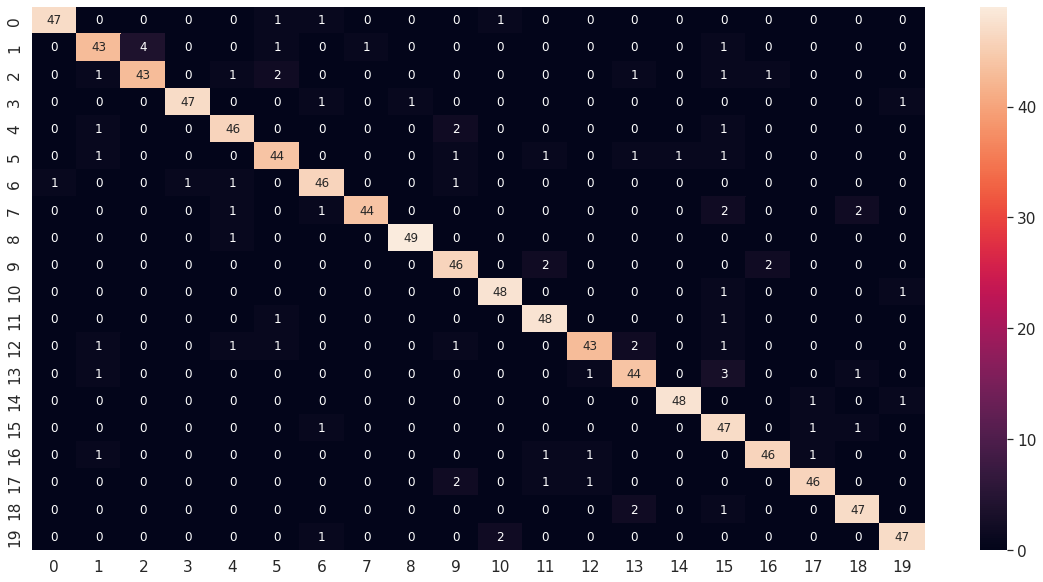

In [ ]:
# Visualizamos la matriz de confusión
deepface_model_vgg4_16_df_CM = pd.DataFrame(deepface_model_vgg4_16_CM, range(20), range(20))  
plt.figure(figsize = (20,10))  
seaborn.set(font_scale=1.4) #for label size  
seaborn.heatmap(deepface_model_vgg4_16_df_CM, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [ ]:
# Resumen de clasificación
deepface_model_vgg4_16_report = classification_report(np.argmax(testY, axis=1), predictedY)  
print(deepface_model_vgg4_16_report)

              precision    recall  f1-score   support

           1       0.98      0.94      0.96        50
           2       0.88      0.86      0.87        50
           3       0.91      0.86      0.89        50
           4       0.98      0.94      0.96        50
           5       0.90      0.92      0.91        50
           6       0.88      0.88      0.88        50
           7       0.90      0.92      0.91        50
           8       0.98      0.88      0.93        50
           9       0.98      0.98      0.98        50
          10       0.87      0.92      0.89        50
          11       0.94      0.96      0.95        50
          12       0.91      0.96      0.93        50
          13       0.93      0.86      0.90        50
          14       0.88      0.88      0.88        50
          15       0.98      0.96      0.97        50
          16       0.78      0.94      0.85        50
          17       0.94      0.92      0.93        50
          18       0.94    